In [383]:
from fastai.tabular import *
from fastai import *


In [384]:
! ls

category_based_tabular-03.ipynb
models
predict-ratings-collborative-filtering-02.ipynb
Predict-ratings-fastai-tabular-01.ipynb


In [385]:
path = Path('.')
ROOT_PATH = Path(path/'../')
DATA_PATH = ROOT_PATH/'data'
SAVED_MODELS = ROOT_PATH/'saved_models'

reviews_file_path = DATA_PATH/'reviews_with_category.csv'

In [386]:
df = pd.read_csv(reviews_file_path)

In [387]:
df = df.drop(columns=['Unnamed: 0'])

### Remove unwanted columns like Review Title, Review Text 

In [388]:
without_reviews_df = df.drop(columns=['review_title', 'cosmetics_review_id'])
without_reviews_df.head()

product_id  \
0  f309a5aa-c47a-4c3c-9e7b-ff6cf2f71e7a   
1  94d1384c-1b58-402f-96a8-30d82fb1a106   
2  3858badd-8a32-4775-996b-8f08197dffaf   
3  f309a5aa-c47a-4c3c-9e7b-ff6cf2f71e7a   
4  1a21cbc0-44c8-4581-bc3f-0f8b32292864   

                                        product               brand  \
0                              Balenciaga Paris          BALENCIAGA   
1                     Pre-Shave Oil - Unscented  The Art of Shaving   
2  Orange Sanguine Cologne Absolue Pure Perfume     Atelier Cologne   
3                              Balenciaga Paris          BALENCIAGA   
4                      Glycolic Facial Cleanser             Anthony   

                                     id user_nickname  rating  \
0  0ba8b592-4a23-497e-a552-7a00d2aab624           NaN       5   
1  9e4619a8-e16d-4a7e-8147-24648db5b06e    charlie201       5   
2  c839ee43-074b-48e6-98a9-1d2350192ec9         sz123       1   
3  fcd90538-4465-4ca3-8c27-734b4d81c6c8  dolceragazza       5   
4  4478b6f8-27a4-4585-a829-e7e3bb226f50      MouseRat       5   

                                         review_text  avataar_url  \
0  Until now, this was only available at very hig...          NaN   
1  This is another excellent product that complim...          NaN   
2  This starts out smelling like a delieghtfully ...          NaN   
3  I have received lots of compliments when I wea...          NaN   
4  I grabbed this deluxe sample for my boyfriend ...          NaN   

              submitted_date              modified_date  ...  \
0  2012-03-21 18:18:56+00:00  2012-03-21 18:30:39+00:00  ...   
1  2011-02-28 06:54:06+00:00  2011-02-28 07:00:03+00:00  ...   
2  2013-08-11 21:58:33+00:00  2019-08-10 02:52:30+00:00  ...   
3  2012-08-18 02:59:55+00:00  2019-06-08 09:59:24+00:00  ...   
4  2013-12-26 21:26:00+00:00  2013-12-26 21:30:13+00:00  ...   

  IncentivizedReview hairCondition hairColor beautyInsider skinTone     age  \
0                NaN           NaN       NaN           NaN      NaN     NaN   
1                NaN           NaN       NaN           yes      NaN  35to44   
2                NaN           NaN       NaN           NaN      NaN     NaN   
3                NaN           NaN       NaN           yes      NaN     NaN   
4                NaN           NaN       NaN           NaN      NaN     NaN   

  eyeColor hairConcerns product_category_primary product_category_secondary  
0      NaN          NaN                Fragrance                        NaN  
1      NaN          NaN                      Men                    Shaving  
2      NaN          NaN                Fragrance                        NaN  
3      NaN          NaN                Fragrance                        NaN  
4      NaN          NaN                      Men                        NaN  

[5 rows x 26 columns]

### Deduplicate on name, product and review_text

In [389]:
dedup_df = without_reviews_df.drop_duplicates(subset=['product_id', 'user_nickname', 'review_text'], 
                                   keep='first', 
                                   inplace=False)
dedup_df

product_id  \
0       f309a5aa-c47a-4c3c-9e7b-ff6cf2f71e7a   
1       94d1384c-1b58-402f-96a8-30d82fb1a106   
2       3858badd-8a32-4775-996b-8f08197dffaf   
3       f309a5aa-c47a-4c3c-9e7b-ff6cf2f71e7a   
4       1a21cbc0-44c8-4581-bc3f-0f8b32292864   
...                                      ...   
376408  ecd25af0-2a66-4828-89b2-6976e45ff1a6   
376409  ecd25af0-2a66-4828-89b2-6976e45ff1a6   
376410  ecd25af0-2a66-4828-89b2-6976e45ff1a6   
376411  ecd25af0-2a66-4828-89b2-6976e45ff1a6   
376412  ecd25af0-2a66-4828-89b2-6976e45ff1a6   

                                                  product               brand  \
0                                        Balenciaga Paris          BALENCIAGA   
1                               Pre-Shave Oil - Unscented  The Art of Shaving   
2            Orange Sanguine Cologne Absolue Pure Perfume     Atelier Cologne   
3                                        Balenciaga Paris          BALENCIAGA   
4                                Glycolic Facial Cleanser             Anthony   
...                                                   ...                 ...   
376408  BIRTHDAY GIFT KVD BEAUTY TATTOO LINER, SETTING...           Kat Von D   
376409  BIRTHDAY GIFT KVD BEAUTY TATTOO LINER, SETTING...           Kat Von D   
376410  BIRTHDAY GIFT KVD BEAUTY TATTOO LINER, SETTING...           Kat Von D   
376411  BIRTHDAY GIFT KVD BEAUTY TATTOO LINER, SETTING...           Kat Von D   
376412  BIRTHDAY GIFT KVD BEAUTY TATTOO LINER, SETTING...           Kat Von D   

                                          id    user_nickname  rating  \
0       0ba8b592-4a23-497e-a552-7a00d2aab624              NaN       5   
1       9e4619a8-e16d-4a7e-8147-24648db5b06e       charlie201       5   
2       c839ee43-074b-48e6-98a9-1d2350192ec9            sz123       1   
3       fcd90538-4465-4ca3-8c27-734b4d81c6c8     dolceragazza       5   
4       4478b6f8-27a4-4585-a829-e7e3bb226f50         MouseRat       5   
...                                      ...              ...     ...   
376408  9ca6cb58-3c93-4b76-93b9-63964d9a851c  ReginaMariaEliz       1   
376409  4ac7f271-b618-4989-88ad-80dbf8ba3b60         beyonka1       4   
376410  653a357f-21a5-469a-9ce7-8a8048f50622    thelovelyrach       2   
376411  2f45ca40-55c9-4476-9c29-124c4ac128de       imarylin09       5   
376412  1f75b483-0e9a-4395-8bcb-f568e7adf9f6    heatherheffer       5   

                                              review_text  avataar_url  \
0       Until now, this was only available at very hig...          NaN   
1       This is another excellent product that complim...          NaN   
2       This starts out smelling like a delieghtfully ...          NaN   
3       I have received lots of compliments when I wea...          NaN   
4       I grabbed this deluxe sample for my boyfriend ...          NaN   
...                                                   ...          ...   
376408  I don't understand people's obsession with thi...          NaN   
376409  It’s a small birthday gift so don’t expect som...          NaN   
376410  Lipstick set way too small. Don’t think the ta...          NaN   
376411                                                NaN          NaN   
376412  it was awesome and beautiful too use best stuf...          NaN   

                   submitted_date              modified_date  ...  \
0       2012-03-21 18:18:56+00:00  2012-03-21 18:30:39+00:00  ...   
1       2011-02-28 06:54:06+00:00  2011-02-28 07:00:03+00:00  ...   
2       2013-08-11 21:58:33+00:00  2019-08-10 02:52:30+00:00  ...   
3       2012-08-18 02:59:55+00:00  2019-06-08 09:59:24+00:00  ...   
4       2013-12-26 21:26:00+00:00  2013-12-26 21:30:13+00:00  ...   
...                           ...                        ...  ...   
376408  2019-06-11 03:54:19+00:00  2019-06-12 16:15:07+00:00  ...   
376409  2019-07-05 22:56:53+00:00  2019-07-07 23:15:04+00:00  ...   
376410  2019-09-05 19:30:00+00:00  2019-09-05 19:45:04+00:00  ...   
376411  2019-09-05 20:39:41+

### Group by categories

1. Find the list of primary categories that exist (let n be the number of primary_categories identified)
2. Create n csvs, one for each category
3. Try to run the tabular process on each.

In [254]:
grouped_by_category_df = dedup_df.groupby(by='product_category_primary')
grouped_by_category_df

In [255]:
for category, data_frame in grouped_by_category_df:
    print(f'{category}')
    file_name = "_".join(category.split()) + '.csv'
    file_path = DATA_PATH/file_name
    data_frame.to_csv(file_path)

Bath & Body
Fragrance
Gifts
Hair
Makeup
Men
Mini Size
Skincare
Tools & Brushes


In [256]:
"_".join("Bath & Body".split()) + '.csv'

'Bath_&_Body.csv'

### Start with Makeup

In [390]:
makeup_df = pd.read_csv(DATA_PATH/'Makeup.csv')
makeup_df

Unnamed: 0                            product_id  \
0              68  ee868898-5955-4f0b-9dac-eed8c0551fb5   
1              80  b18e64a7-bc8f-44d6-977f-ba9e893e8ffa   
2              81  941cc3bf-5770-4f4e-8ef2-73fae8eb6c31   
3             111  9c8d9d55-a936-47af-b887-d11c4acdead3   
4             160  941cc3bf-5770-4f4e-8ef2-73fae8eb6c31   
...           ...                                   ...   
45350      375687  3ea6c118-6622-4d0f-b864-2b7c588327a7   
45351      375793  b42b1d6b-8a27-4770-b805-fb0a1355bc28   
45352      375794  b42b1d6b-8a27-4770-b805-fb0a1355bc28   
45353      375796  b42b1d6b-8a27-4770-b805-fb0a1355bc28   
45354      375832  c46bb68a-5291-4a76-9f14-45dc66dacf4c   

                                                 product  \
0      Color Control Cushion Compact Broad Spectrum S...   
1                                             Pro Pencil   
2                          Certified Organic Highlighter   
3                                   Rose Lip Conditioner   
4                          Certified Organic Highlighter   
...                                                  ...   
45350              Rouge Pur Couture Lipstick Collection   
45351  Touche Eclat Le Teint Radiance Awakening Found...   
45352  Touche Eclat Le Teint Radiance Awakening Found...   
45353  Touche Eclat Le Teint Radiance Awakening Found...   
45354                  TOP SECRETS Instant Moisture Glow   

                         brand                                    id  \
0                 AMOREPACIFIC  708319ed-055f-456d-b8ba-69ed6344b207   
1      Anastasia Beverly Hills  b1fc0651-eaf6-4e02-b994-a45a289fe390   
2                      Antonym  658d82fc-27ed-42b3-8047-5621052ffb34   
3                        AERIN  df26ede4-cc46-4a1b-9aa3-ac59be7d2912   
4                      Antonym  aa7fd93a-f53a-401d-aac6-008e4786b15a   
...                        ...                                   ...   
45350       Yves Saint Laurent  f7e0808c-0adf-4f2f-851a-c729679a9363   
45351       Yves Saint Laurent  052b5f66-4ff1-48a9-81b9-6ec30eb5cdba   
45352       Yves Saint Laurent  d1c95a33-89a6-4b4d-a4c2-2259243d2d92   
45353       Yves Saint Laurent  7bae08f7-b827-4843-a157-596c02f72883   
45354       Yves Saint Laurent  d21d7485-ef7b-440b-87ec-973e32aa3dfd   

         user_nickname  rating  \
0             cagirl71       5   
1              Nannykk       3   
2      HeLLooooooooooo       5   
3              amm1582       5   
4                 obi1       5   
...                ...     ...   
45350    gingerhoney86       5   
45351         yvonne67       1   
45352        fairygirl       2   
45353    glamgirl00718       2   
45354         ShaaronF       4   

                                             review_text  avataar_url  \
0      And I think she might be right.I have virtuall...          NaN   
1      Great for covering spots and veins but must be...          NaN   
2      I loveeeeeeeeee this product it's awesome, I w...          NaN   
3           I love the smell  and it seems to be working          NaN   
4      Finally an Organic and Cruely free product tha...          NaN   
...                                                  ...          ...   
45350  This is an amazing lipstick, beautiful color, ...          NaN   
45351  I bought this without realizing it is a new fo...          NaN   
45352  After years and years of searching for the per...          NaN   
45353  I was a faithful supporter of the previous Tou...          NaN   
45354  Only reason I'm giving a 4 star is because you...          NaN   

                  submitted_date  ... IncentivizedReview hairCondition  \
0      2013-10-14 18:18:34+00:00  ...                NaN           NaN   
1      2014-08-10 02:23:12+00:00  ...                NaN           NaN   
2      2017-07-21 22:53:36+00:00  ...                NaN           NaN   
3      2017-02-15 23:52:49+00:00  ...              False           NaN   
4      2017-07-28 18:39:11+00:00  ...                NaN

In [317]:
makeup_df.columns

Index(['Unnamed: 0', 'product_id', 'product', 'brand', 'id', 'user_nickname',
       'rating', 'review_text', 'avataar_url', 'submitted_date',
       'modified_date', 'createdAt', 'updatedAt', 'StaffContext',
       'VerifiedPurchaser', 'skinConcerns', 'skinType', 'IncentivizedReview',
       'hairCondition', 'hairColor', 'beautyInsider', 'skinTone', 'age',
       'eyeColor', 'hairConcerns', 'product_category_primary',
       'product_category_secondary'],
      dtype='object')

In [391]:
relevant_makeup_df = makeup_df.drop(columns=['Unnamed: 0', 
                                             'avataar_url',
                                             'submitted_date',
                                             'modified_date', 
                                             'createdAt', 
                                             'updatedAt',
                                             'beautyInsider',
                                             'StaffContext',
                                             'IncentivizedReview',
                                             'VerifiedPurchaser',
                                             'hairCondition', 
                                             'hairColor', 
                                             'hairConcerns', 
                                             'review_text', 
                                             'id'], inplace=False)
relevant_makeup_df

product_id  \
0      ee868898-5955-4f0b-9dac-eed8c0551fb5   
1      b18e64a7-bc8f-44d6-977f-ba9e893e8ffa   
2      941cc3bf-5770-4f4e-8ef2-73fae8eb6c31   
3      9c8d9d55-a936-47af-b887-d11c4acdead3   
4      941cc3bf-5770-4f4e-8ef2-73fae8eb6c31   
...                                     ...   
45350  3ea6c118-6622-4d0f-b864-2b7c588327a7   
45351  b42b1d6b-8a27-4770-b805-fb0a1355bc28   
45352  b42b1d6b-8a27-4770-b805-fb0a1355bc28   
45353  b42b1d6b-8a27-4770-b805-fb0a1355bc28   
45354  c46bb68a-5291-4a76-9f14-45dc66dacf4c   

                                                 product  \
0      Color Control Cushion Compact Broad Spectrum S...   
1                                             Pro Pencil   
2                          Certified Organic Highlighter   
3                                   Rose Lip Conditioner   
4                          Certified Organic Highlighter   
...                                                  ...   
45350              Rouge Pur Couture Lipstick Collection   
45351  Touche Eclat Le Teint Radiance Awakening Found...   
45352  Touche Eclat Le Teint Radiance Awakening Found...   
45353  Touche Eclat Le Teint Radiance Awakening Found...   
45354                  TOP SECRETS Instant Moisture Glow   

                         brand    user_nickname  rating skinConcerns skinType  \
0                 AMOREPACIFIC         cagirl71       5          NaN      NaN   
1      Anastasia Beverly Hills          Nannykk       3          NaN      NaN   
2                      Antonym  HeLLooooooooooo       5          NaN      NaN   
3                        AERIN          amm1582       5          NaN      NaN   
4                      Antonym             obi1       5          NaN      NaN   
...                        ...              ...     ...          ...      ...   
45350       Yves Saint Laurent    gingerhoney86       5          NaN      NaN   
45351       Yves Saint Laurent         yvonne67       1          NaN   normal   
45352       Yves Saint Laurent        fairygirl       2          NaN      NaN   
45353       Yves Saint Laurent    glamgirl00718       2          NaN      dry   
45354       Yves Saint Laurent         ShaaronF       4         acne     oily   

      skinTone     age eyeColor product_category_primary  \
0          NaN     NaN      NaN                   Makeup   
1          NaN     NaN      NaN                   Makeup   
2          NaN     NaN      NaN                   Makeup   
3          NaN     NaN      NaN                   Makeup   
4          NaN     NaN      NaN                   Makeup   
...        ...     ...      ...                      ...   
45350      NaN     NaN      NaN                   Makeup   
45351    light  45to54    brown                   Makeup   
45352     fair  35to44     blue                   Makeup   
45353     fair  25to34    brown                   Makeup   
45354    olive     NaN    brown                   Makeup   

      product_category_secondary  
0                           Face  
1                            NaN  
2                           Face  
3                            Lip  
4                           Face  
...                          ...  
45350                        NaN  
45351                       Face  
45352                       Face  
45353                       Face  
45354                       Face  

[45355 rows x 12 columns]

In [392]:
relevant_makeup_df.groupby(by=['user_nickname'], sort=True)['product'].count().nlargest(38679)

user_nickname
dreamyone          46
Mochapj            45
DressageQueen86    29
jonieku            27
bakeamuffin        21
                   ..
SamRun              1
SamRica             1
SamRad              1
SamNicole18         1
zzxxx               1
Name: product, Length: 38678, dtype: int64

In [393]:
relevant_makeup_df['user_nickname'].unique().size

38679

In [394]:
relevant_makeup_df.columns

Index(['product_id', 'product', 'brand', 'user_nickname', 'rating',
       'skinConcerns', 'skinType', 'skinTone', 'age', 'eyeColor',
       'product_category_primary', 'product_category_secondary'],
      dtype='object')

In [395]:
relevant_makeup_df.shape[0]

45355

### Percentage of missing value

In [396]:
relevant_makeup_df.isna().sum()/relevant_makeup_df.shape[0] * 100

product_id                     0.000000
product                        0.000000
brand                          0.000000
user_nickname                  0.829016
rating                         0.000000
skinConcerns                  80.571051
skinType                      33.070224
skinTone                      20.074964
age                           66.735751
eyeColor                      21.580862
product_category_primary       0.000000
product_category_secondary    33.473707
dtype: float64

### Remove rows with missing username

```python
df.dropna(subset=['EPS'], how='all', inplace=True)
```

In [397]:
relevant_makeup_df.dropna(subset=['user_nickname'], how='all', inplace=True)

In [398]:
relevant_makeup_df.isna().sum()/relevant_makeup_df.shape[0] * 100

product_id                     0.000000
product                        0.000000
brand                          0.000000
user_nickname                  0.000000
rating                         0.000000
skinConcerns                  80.530914
skinType                      32.973165
skinTone                      20.033794
age                           66.831188
eyeColor                      21.541164
product_category_primary       0.000000
product_category_secondary    33.473399
dtype: float64

### Try to check if for a specific user the skinType and SkinTone are present for all of the users comments

In [399]:
grouped_by_user_df = relevant_makeup_df.groupby(['user_nickname'])

In [400]:
grouped_by_user_df['product_id'].count().nlargest(100)

user_nickname
dreamyone          46
Mochapj            45
DressageQueen86    29
jonieku            27
bakeamuffin        21
                   ..
Jenn088             6
JillyBeanTX         6
Kate1707            6
Krista0526          6
LaylaKitten         6
Name: product_id, Length: 100, dtype: int64

In [401]:
grouped_by_user_df.get_group('dreamyone')

product_id  \
3325   f94e5207-1362-4618-8adf-0fb40a26baa5   
3522   e7201ede-58b2-4e8a-a92f-d6f7d7196650   
3531   e7201ede-58b2-4e8a-a92f-d6f7d7196650   
4114   1fe1377c-5cca-420d-8220-e606b567f152   
5544   3e2b7575-d316-4a32-8103-8b890f26decf   
5548   3e2b7575-d316-4a32-8103-8b890f26decf   
5576   3e2b7575-d316-4a32-8103-8b890f26decf   
7520   3fb480d7-b68e-4c94-939b-a599e7db29d1   
7534   3fb480d7-b68e-4c94-939b-a599e7db29d1   
7542   3fb480d7-b68e-4c94-939b-a599e7db29d1   
7543   3fb480d7-b68e-4c94-939b-a599e7db29d1   
7568   3fb480d7-b68e-4c94-939b-a599e7db29d1   
7680   cd91bf6b-fabb-4867-9d82-13d97cedf34c   
10258  81662dc2-6997-47a8-95cc-c55a1ae89faa   
10265  81662dc2-6997-47a8-95cc-c55a1ae89faa   
10330  aa5582dd-0b1b-467f-8b8f-4a6048c02598   
10335  aa5582dd-0b1b-467f-8b8f-4a6048c02598   
11830  6570c779-709f-496f-bd37-b29d6b641092   
12322  dd90d2a0-f69a-42ab-aa4d-eb834b8f943f   
12333  dd90d2a0-f69a-42ab-aa4d-eb834b8f943f   
14887  2a0f488f-f574-4d6c-aebc-a2ee7c134e84   
16672  dda52403-3f6a-4b35-b4b3-928725c45236   
16806  7cd9ac8d-a4d9-479c-b9d1-433c39baeb2f   
16811  7cd9ac8d-a4d9-479c-b9d1-433c39baeb2f   
23077  911bb577-cf7b-4ba1-89a4-7d4534eb4d91   
23124  911bb577-cf7b-4ba1-89a4-7d4534eb4d91   
23701  e0236385-78e1-464d-b682-2ed7661f3153   
28688  cc196cc4-267e-4f3f-a9cf-dba92e85a59a   
28824  01906172-34a4-4fbf-a30e-a9cc4568f933   
28834  01906172-34a4-4fbf-a30e-a9cc4568f933   
28893  9b2faf64-22c8-475b-9b50-06f2e1912c81   
28896  9b2faf64-22c8-475b-9b50-06f2e1912c81   
28899  9b2faf64-22c8-475b-9b50-06f2e1912c81   
33998  5799d5a2-af4f-4ada-a466-3e2aacbd56db   
34471  a2ab452f-342d-4f21-937d-e712b17505d1   
34796  a2ab452f-342d-4f21-937d-e712b17505d1   
34929  a8cbfe60-236a-4b5d-b5e2-88cf3dee7f71   
36154  29c15517-4fca-4040-87aa-94652d005df2   
36519  167fcea6-b4b4-46a0-bb98-8e5ea0d020f6   
36597  a2ab452f-342d-4f21-937d-e712b17505d1   
37054  10159c17-b62f-4d4d-91ea-2803e38054e1   
37063  10159c17-b62f-4d4d-91ea-2803e38054e1   
37736  426b5774-b484-41d3-8884-b7810f68bf82   
38597  71c78b2e-fcd9-4b4d-9b74-31b99a8d5210   
39268  3f791ca6-7442-45fc-b6ee-caf289e5520d   
41635  3f791ca6-7442-45fc-b6ee-caf289e5520d   

                                                 product               brand  \
3325          Prime Time Foundation Primer - Brightening        bareMinerals   
3522                        liquid blendercleanser&#xAE;       beautyblender   
3531                        liquid blendercleanser&#xAE;       beautyblender   
4114                                             Bronzer         Bobbi Brown   
5544                                 BADgal Lash Mascara   Benefit Cosmetics   
5548                                 BADgal Lash Mascara   Benefit Cosmetics   
5576                                 BADgal Lash Mascara   Benefit Cosmetics   
7520           Full-On&#x2122; Plumping Lip Polish Gloss               Buxom   
7534           Full-On&#x2122; Plumping Lip Polish Gloss               Buxom   
7542           Full-On&#x2122; Plumping Lip Polish Gloss               Buxom   
7543           Full-On&#x2122; Plumping Lip Polish Gloss               Buxom   
7568           Full-On&#x2122; Plumping Lip Polish Gloss               Buxom   
7680                             Lash Volumizing Mascara               Buxom   
10258                                    Almost Lipstick            CLINIQUE   
10265                                    Almost Lipstick            CLINIQUE   
10330  Take The Day Off Makeup Remover For Lids, Lash...            CLINIQUE   
10335  Take The Day Off Makeup Remover For Lids, Lash...            CLINIQUE   
11830                                      Dior Lip Glow                Dior   
12322                            Diorshow Iconic Mascara                Dior   
12333                            Diorshow Iconic Mascara                Dior   
14887               Sugar Advanced Therapy Lip Treatment               Fresh   
16672            Terracotta Skin Cream Powder Foundation       

### Update missing values for each group by

```python
# For each group - in this case for user `Mochapj`
d = grouped_by_user_df.get_group('Mochapj')

# Find all the `skinConcerns` that are not null
skin_concerns_df = d[d['skinConcerns'].notnull()]

# Fetch the unique value if only one
skin_concerns_df['skinConcerns'].unique()[0]

# select all records from `relevant_make_df` for the user `Mochapj` and assign the attribute `skinConcerns` with the value `aging`
relevant_makeup_df.loc[relevant_makeup_df['user_nickname']=='Mochapj', 'skinConcerns'] = 'aging'

# List and view the updated values
relevant_makeup_df.loc[relevant_makeup_df['user_nickname']=='Mochapj']
```

###    Update dataFrame with missing values for skinConcerns

In [402]:
x = ['aging', 'darkCircles']
'-'.join(sorted(x))
print(x[:])

['aging', 'darkCircles']


In [403]:
def update_user(user_nickname, attribute, value):
    relevant_makeup_df.loc[relevant_makeup_df['user_nickname']== user_nickname, attribute] = value

for user_nickname, grouped_df in grouped_by_user_df:    
    user_skin_concerns_df = grouped_df[grouped_df['skinConcerns'].notnull()]  
    
    if user_skin_concerns_df['skinConcerns'].unique().size == 1:
        unique_skin_concern = user_skin_concerns_df['skinConcerns'].unique()[0]
        update_user(user_nickname=user_nickname, 
                    attribute='skinConcerns', 
                    value=unique_skin_concern)
        print(f'Nickname: {user_nickname} - {unique_skin_concern}')
    
    elif user_skin_concerns_df['skinConcerns'].unique().size > 1:
        unique_skin_concerns = user_skin_concerns_df['skinConcerns'].unique()[:]
        unique_skin_concern = '-'.join(sorted(unique_skin_concerns))
        update_user(user_nickname=user_nickname, 
                    attribute='skinConcerns', 
                    value=unique_skin_concern)
        print(f'*Nickname: {user_nickname} - {unique_skin_concerns}')
    
    else: 
        print(f'Nickname: {user_nickname} - None')

Nickname: 007gal - None
Nickname: 007lisa007 - None
Nickname: 00Glenda00 - darkCircles
Nickname: 00hatter - None
Nickname: 00maymay00 - None
Nickname: 011570 - None
Nickname: 01beauty - None
Nickname: 02LadyCortes13 - None
Nickname: 0607Bailee - None
Nickname: 08misse - None
Nickname: 0akheart - None
Nickname: 0blivion - None
Nickname: 0bsidian - darkCircles
Nickname: 0elle0 - acne
Nickname: 0linds0 - None
Nickname: 0liviadawson - None
Nickname: 0mnisci3nt - None
Nickname: 0w00 - blackheads
Nickname: 1010Han - aging
Nickname: 101528 - None
Nickname: 1041pm - None
Nickname: 10eels - None
Nickname: 110v3mak3up - None
Nickname: 111michelle111 - None
Nickname: 1125dmw - None
Nickname: 113times - None
Nickname: 11GK - acne
Nickname: 11Makeup11 - acne
Nickname: 11to1 - None
Nickname: 1233C - None
Nickname: 1234567899 - None
Nickname: 1234Erin - None
Nickname: 123Gaby - None
Nickname: 123Tracy - None
Nickname: 123angie456 - darkCircles
Nickname: 123jess - None
Nickname: 123pancakes321 - None


Nickname: AHB86 - aging
Nickname: AHGentile - None
Nickname: AHHHthena - blackheads
Nickname: AHiggi - None
Nickname: AHlovesmakeup - None
Nickname: AHphoto - None
Nickname: AJ123456 - None
Nickname: AJ7771 - dullness
Nickname: AJAV - None
Nickname: AJEinhorn - None
Nickname: AJHamaker - None
Nickname: AJHred - cuticles
Nickname: AJKSanders - None
Nickname: AJKemm - None
Nickname: AJLClough - None
Nickname: AJN2 - None
Nickname: AJW3 - None
Nickname: AK1986 - blackheads
Nickname: AK2554 - sensitivity
Nickname: AK4SA - None
Nickname: AKATT - sensitivity
Nickname: AKGROWN - None
Nickname: AKHA - acne
Nickname: AKJack101 - acne
Nickname: AKMakeupAdict - None
Nickname: AKR95 - acne
Nickname: AKWren - None
Nickname: AKraemer3 - None
Nickname: AKstyle - None
Nickname: AL123456 - None
Nickname: ALDaley - None
Nickname: ALICENE - None
Nickname: ALICEYAYA - None
Nickname: ALLinNY - None
Nickname: ALM1518 - acne
Nickname: ALMAL - None
Nickname: ALMcG - None
Nickname: ALSUNDRESSED - acne
Nickname

Nickname: AlexandraRose14 - dullness
Nickname: Alexandramotan1 - darkCircles
Nickname: Alexareddit - None
Nickname: Alexbeauty26 - None
Nickname: Alexcentdraps - None
Nickname: Alexdisensi - None
Nickname: Alexel - acne
Nickname: AlexiAlexo - None
Nickname: Alexia1055 - blackheads
Nickname: Alexirae - None
Nickname: Alexis007 - acne
Nickname: Alexis2102 - acne
Nickname: AlexisGeorge264 - None
Nickname: AlexisWatt - None
Nickname: Alexisgi08 - dullness
Nickname: Alexismae97 - None
Nickname: Alexk223 - None
Nickname: Alexsadora - acne
Nickname: Alexuus - acne
Nickname: Alexv91 - None
Nickname: Alexxxandra - None
Nickname: AlexyC - None
Nickname: Aleybaby - redness
Nickname: Alfey - None
Nickname: Alfie0412 - aging
Nickname: Alfiedafonz - None
Nickname: Alfinger - None
Nickname: Alg0831 - None
Nickname: Ali07 - acne
Nickname: Ali112 - None
Nickname: Ali41729 - None
Nickname: Ali5on19 - acne
Nickname: AliAnnMar - None
Nickname: AliChae - None
Nickname: AliD89 - None
Nickname: AliHolly - No

Nickname: AmyB621 - dullness
Nickname: AmyBowser - None
Nickname: AmyCave1 - None
Nickname: AmyDaw - None
Nickname: AmyET - None
Nickname: AmyEVilleneuve - blackheads
Nickname: AmyG189 - aging
Nickname: AmyGmc - aging
Nickname: AmyJMAtl - None
Nickname: AmyJean15 - None
Nickname: AmyJoan907 - acne
Nickname: AmyJoy81 - aging
Nickname: AmyKate27 - acne
Nickname: AmyLeG - None
Nickname: AmyMCFC - aging
Nickname: AmyMJ - None
Nickname: AmyMarie90 - None
Nickname: AmyMay01 - None
Nickname: AmyPierce - None
Nickname: AmyRose30 - None
Nickname: AmySHuang - None
Nickname: AmySck - None
Nickname: AmydNg - darkCircles
Nickname: AmyfromChicago - None
Nickname: AmylinaB - None
Nickname: Amylovesmakeups - None
Nickname: Amyr22 - None
Nickname: AmysOpinion - None
Nickname: AmyyMac - None
Nickname: Amyziqi - sensitivity
Nickname: AmzH - aging
Nickname: An15 - None
Nickname: An25 - None
Nickname: AnAmazement - None
Nickname: AnAmazonian - None
Nickname: AnAngelic1 - None
Nickname: AnDiscretion - None


Nickname: Anrivs - acne
Nickname: Ant3 - None
Nickname: AntCarmine - sensitivity
Nickname: Antigua - acne
Nickname: Antooo - acne
Nickname: Antora0808 - None
Nickname: Anu90 - None
Nickname: Anush628 - None
Nickname: Anushai - None
Nickname: Anyacr - darkCircles
Nickname: AnythingPretty - None
Nickname: Aoede - None
Nickname: Aokigahara - None
Nickname: Aolsen123 - None
Nickname: Apetar - blackheads
Nickname: ApexJess - None
Nickname: Aphernai - None
Nickname: Apies - None
Nickname: AppleBanana - None
Nickname: AppleCh1ck - None
Nickname: AppleI - None
Nickname: Appleby - None
Nickname: April12345 - None
Nickname: AprilMari - None
Nickname: AprilMcKenzie - acne
Nickname: Aprildawn25 - aging
Nickname: Aprilfl0wer - acne
Nickname: Aprilmc91 - acne
Nickname: Aprilstte - None
Nickname: Aprilyy - None
Nickname: Aproooo - None
Nickname: AprylC - None
Nickname: AptAmanda - acne
Nickname: Aquaazure - acne
Nickname: AquarEye - None
Nickname: Arabela95 - None
Nickname: Arabella94 - aging
Nicknam

Nickname: Awest1017 - sensitivity
Nickname: AwildaG - None
Nickname: Awildac17 - acne
Nickname: Awomanda22 - None
Nickname: Awwyeahoz - None
Nickname: AyAy96 - None
Nickname: AyaR - None
Nickname: Ayana21 - None
Nickname: Ayanna528 - None
Nickname: AyannaBaby - None
Nickname: Ayannie - None
Nickname: Aydynsmom - None
Nickname: AyeInfluenster - None
Nickname: Ayeshahussain - None
Nickname: AylinMDePoorter - None
Nickname: AyrialMarie - None
Nickname: AyuSaraswatiFL - None
Nickname: Ayua123 - None
Nickname: Azaleas - None
Nickname: AzaliaR - None
Nickname: Azcorva - None
Nickname: Aziii - None
Nickname: AzucarKat - None
Nickname: Azzi225 - None
Nickname: BAHRDD - acne
Nickname: BAV89 - None
Nickname: BBGirlDeluca - aging
Nickname: BBM303 - None
Nickname: BBNoelle - None
Nickname: BBPROTC - None
Nickname: BBWaller - None
Nickname: BBXX2017 - None
Nickname: BBaran181 - None
Nickname: BBling03 - None
Nickname: BBlovesMU - None
Nickname: BCCGIRL - aging
Nickname: BCarter23 - None
Nickname: B

Nickname: Becka001 - aging
Nickname: Becka123456 - None
Nickname: BecksMUA - None
Nickname: Beckster727 - None
Nickname: Becky90 - acne
Nickname: BeckyD666 - None
Nickname: BeckyJo20 - None
Nickname: Bedubs - None
Nickname: Bee999 - None
Nickname: BeeBee7 - acne
Nickname: BeeGirl2018 - None
Nickname: BeeGood - aging
Nickname: BeeMartin - acne
Nickname: BeeNic - None
Nickname: Beea95 - None
Nickname: Beeatrixbona - None
Nickname: BeebsLovesPeeps - None
Nickname: BeeeLady - acne
Nickname: Beemoo - None
Nickname: Beenish3284 - aging
Nickname: Beesfoodgossips - acne
Nickname: Beetus - None
Nickname: Beginner90 - None
Nickname: Bekahdawn09 - None
Nickname: Bekkahboo87 - None
Nickname: BekkidyBekkidy - None
Nickname: Bel9o - dullness
Nickname: BelbyLynne - None
Nickname: Belcantodiva - None
Nickname: Beleny - None
Nickname: Belgradian - aging
Nickname: BelindaBB - None
Nickname: Belisa0501 - None
Nickname: Belisma - None
Nickname: Belizabeth21 - dullness
Nickname: BelkaFl - aging
Nickname: B

Nickname: BooAnn922 - None
Nickname: Booandpeach - None
Nickname: Boobeauty - None
Nickname: Booberka - None
Nickname: BoobooJ - None
Nickname: Booboolovebug - None
Nickname: Boogrchic - None
Nickname: Bookdeity - None
Nickname: Bookie123 - aging
Nickname: Bookofglamstori - acne
Nickname: BooksANDtattoos - None
Nickname: Bookwormerz - acne
Nickname: BootheelBrooke - None
Nickname: BootsyBonBon - aging
Nickname: Bori224 - None
Nickname: Borovnia - None
Nickname: BossLeo93 - None
Nickname: Bosscangel - None
Nickname: BossyMeags - None
Nickname: Boston30s - None
Nickname: BostonBlonde75 - None
Nickname: BostonEB - None
Nickname: BostonGal8 - None
Nickname: BostonPrincess - None
Nickname: BostonTech - None
Nickname: BoszDiva - None
Nickname: Botts - redness
Nickname: Boucl23 - None
Nickname: Boulz - None
Nickname: Bourney - None
Nickname: BoxyGirl - None
Nickname: Bozy76 - acne
Nickname: Bpalmer22 - None
Nickname: Bpatel24 - None
Nickname: Bpsql018MISHA2 - None
Nickname: Braishna - None
Ni

Nickname: BusyBever - None
Nickname: BusyGirlMom - None
Nickname: Butkovich - None
Nickname: ButterCreamz - None
Nickname: ButterflyGirl86 - aging
Nickname: Butterflyqw33n8 - acne
Nickname: Butterscotch0 - None
Nickname: BuysMakeup - None
Nickname: BuzyRN - None
Nickname: BuzzaBEE - None
Nickname: BuzzkillJill - None
Nickname: Bvbygal - None
Nickname: BwkGaGirl - None
Nickname: Byma - None
Nickname: Byng - None
Nickname: Byrnesie - None
Nickname: Byrns - acne
Nickname: C0smicDancer - None
Nickname: C2keri - None
Nickname: C2khan14 - None
Nickname: CABeautyNewbie - None
Nickname: CAKate - aging
Nickname: CAMurphy - None
Nickname: CASINE22 - None
Nickname: CASSMF - None
Nickname: CAborntraveler - acne
Nickname: CAnnamarie3 - None
Nickname: CBC94 - None
Nickname: CBCDLC - None
Nickname: CBDSkincareCeo - aging
Nickname: CBMcKay - redness
Nickname: CBmom - None
Nickname: CC1985 - None
Nickname: CC84 - None
Nickname: CC91 - None
Nickname: CCBeautymark - None
Nickname: CCBel - None
Nickname: 

Nickname: Casey100 - None
Nickname: Casey24 - None
Nickname: CaseyAnnt - dullness
Nickname: CaseyDM - None
Nickname: CaseyHill - None
Nickname: CaseyK21 - None
Nickname: CaseyRaee - None
Nickname: Caseymua56 - None
Nickname: CashmereNoxx - None
Nickname: Cashmerepnk - None
Nickname: Casidie - None
Nickname: Casper13 - None
Nickname: Cass165 - None
Nickname: Cass715 - blackheads
Nickname: Cass83 - None
Nickname: CassBro - aging
Nickname: CassEh - None
Nickname: CassSieliakus - darkCircles
Nickname: CassTastic33 - None
Nickname: CassandraH1991 - acne
Nickname: CassandraSauce - None
Nickname: Cassarolli - None
Nickname: Casseline - None
Nickname: Cassey778 - None
Nickname: Cassidael - None
Nickname: CassidyMich - acne
Nickname: CassidySchnare - None
Nickname: Cassie0305 - None
Nickname: CassieMP - None
Nickname: CassieRhea - None
Nickname: Cassieq - None
Nickname: Cassierose94 - None
Nickname: Cassies00 - None
Nickname: Cassy7 - None
Nickname: Cassyr7 - None
Nickname: Casteal - None
Nickn

Nickname: Chicklebear - None
Nickname: Chickletfox - aging
Nickname: Chickmamma - None
Nickname: ChicksAndSalsa - aging
Nickname: Chicoliss - None
Nickname: Chikoboo - aging
Nickname: ChiliMango - acne
Nickname: ChilliNik - None
Nickname: ChillyCurtis - aging
Nickname: ChillyPepper - None
Nickname: Chimega - None
Nickname: ChinaSantos - None
Nickname: ChinnyChinz - darkCircles
Nickname: ChinoTX - None
Nickname: ChipmunkV - None
Nickname: ChiquitaRam - aging
Nickname: Chirry - None
Nickname: Chispa22 - blackheads
Nickname: Chjust - acne
Nickname: ChloChlox3 - None
Nickname: ChloPark - None
Nickname: Chloe12001 - None
Nickname: Chloe33 - None
Nickname: Chloe653 - acne
Nickname: Chloe907 - None
Nickname: ChloeBaldino - None
Nickname: Chloeb0212 - None
Nickname: Chloejoe100 - None
Nickname: Chlotoro - None
Nickname: ChocDoll - acne
Nickname: ChocoLabbit - None
Nickname: Chocoba8y - None
Nickname: Choep - None
Nickname: Choeunxoxo - None
Nickname: Cholakk - blackheads
Nickname: Chomolulu - 

Nickname: Corinnejb - None
Nickname: Corrielee - None
Nickname: Corrilorri - None
Nickname: CortHaz - None
Nickname: CortneyMarie - None
Nickname: CortneySaxena - None
Nickname: Cortneyj - None
Nickname: Corttt - None
Nickname: Corya - acne
Nickname: CosmeticNovice - darkCircles
Nickname: CosmeticSnobYT - acne
Nickname: Cosmeticlove - None
Nickname: CosmeticsFav - aging
Nickname: Cosmetologypro - None
Nickname: CosmicAddiction - acne
Nickname: CosmicBear - None
Nickname: CosmoGirl22 - acne
Nickname: CosmoGirl85 - None
Nickname: CosmoGirl88 - None
Nickname: CosmoLisa - None
Nickname: Cosmobyqu3llz - pores
Nickname: Cosmochiq101 - None
Nickname: Cosmochris91 - acne
Nickname: Cosmochristine - None
Nickname: Cosmogirl9 - acne
Nickname: Cosmopolis - None
Nickname: Cotinsayon - None
Nickname: CountessB - None
Nickname: CountessChocula - None
Nickname: CountryCityGirl - None
Nickname: CountryLover - None
Nickname: Court1214 - None
Nickname: Court5594 - None
Nickname: Court622 - None
Nickname:

Nickname: Dandelion711 - None
Nickname: DandelionMine - sensitivity
Nickname: DandyS - None
Nickname: DaneeSpeaks - acne
Nickname: Daneka23 - acne
Nickname: Dani0613 - None
Nickname: Dani1463 - None
Nickname: Dani1559SEC - None
Nickname: Dani1994 - None
Nickname: Dani30Kay - acne
Nickname: Dani67 - None
Nickname: DaniAdkins - None
Nickname: DaniAnnie - None
Nickname: DaniBeeGee - None
Nickname: DaniBites - None
Nickname: DaniBlu08 - None
Nickname: DaniCV - None
Nickname: DaniDaniela - None
Nickname: DaniDank - None
Nickname: DaniDesl - None
Nickname: DaniJaneB - None
Nickname: DaniMarc - None
Nickname: DaniND - None
Nickname: DaniPaskevitch - None
Nickname: DaniPhantom99 - None
Nickname: DaniRosey - None
Nickname: DaniShayB - None
Nickname: DaniTack - None
Nickname: DaniWX2 - None
Nickname: Daniaggs - None
Nickname: Daniahamdan1 - None
Nickname: DanieB10 - None
Nickname: DanieJD - None
Nickname: Daniela3113 - None
Nickname: DanielaCardona - None
Nickname: DanieleNicole - None
Nickname:

Nickname: Dijon - None
Nickname: DillyDilly - None
Nickname: DimiJimmy - None
Nickname: DimitraB2M - None
Nickname: Dimples1218 - None
Nickname: Dimplessssss - None
Nickname: DinaD4168 - acne
Nickname: DinaMina - None
Nickname: DinaT80 - acne
Nickname: DinahVivero - None
Nickname: Dinahh - None
Nickname: Dinasma - None
Nickname: DinooB - None
Nickname: DionysusCurl - None
Nickname: DiorDoll - None
Nickname: DiorObsessed - None
Nickname: Diorgirl82 - None
Nickname: DippedInGlitter - None
Nickname: Dipti21 - None
Nickname: Dirvin - acne
Nickname: DisastrLilbit - aging
Nickname: Discere - None
Nickname: Discerning1 - None
Nickname: DiscoSatan - None
Nickname: Dishertin - sunDamage
Nickname: Disneypigs - None
Nickname: DistractedAtty - None
Nickname: Dithdrew - None
Nickname: Div10 - None
Nickname: DivaDoll16 - None
Nickname: DivaPony - None
Nickname: DivaSLW - None
Nickname: DivaSims - None
Nickname: Divafoushee - None
Nickname: Divakind - None
Nickname: DiversMuse - None
Nickname: Divine

Nickname: Elisa103 - blackheads
Nickname: ElisaCavaliere - None
Nickname: ElisabethZ - acne
Nickname: Elise21 - None
Nickname: Elissar - None
Nickname: ElizJ - None
Nickname: Eliza009 - None
Nickname: Eliza4295 - None
Nickname: ElizaEm - None
Nickname: Elizabeettthhhh - None
Nickname: Elizabeth0109 - None
Nickname: Elizabeth0903 - None
Nickname: Elizabeth1983 - None
Nickname: Elizabeth2016 - None
Nickname: Elizabeth379 - None
Nickname: ElizabethAnn123 - aging
Nickname: ElizabethDawn - None
Nickname: ElizabethGH - aging
Nickname: ElizabethHope - None
Nickname: ElizabethJoy09 - aging
Nickname: ElizabethKS - None
Nickname: ElizabethLynnM - acne
Nickname: ElizabethMcK - None
Nickname: ElizabethPowers - acne
Nickname: ElizabethWeekes - None
Nickname: Elizabethhrh - None
Nickname: Elizabethx7 - None
Nickname: Elizagarci - None
Nickname: Elizzacor - None
Nickname: Elj12681 - None
Nickname: ElkisMakeup - None
Nickname: Ella01 - aging
Nickname: Ella340 - None
Nickname: EllaFunk - None
Nickname:

Nickname: Erikaace - acne
Nickname: Erikaiscoconuts - None
Nickname: Erikalatrisia - None
Nickname: Erikita0730 - None
Nickname: Erin000 - None
Nickname: Erin2879 - None
Nickname: ErinAmalie - None
Nickname: ErinAshley9 - None
Nickname: ErinBrittanyR - aging
Nickname: ErinDeidre - None
Nickname: ErinE3 - None
Nickname: ErinEmry - None
Nickname: ErinFos5218 - None
Nickname: ErinJK - None
Nickname: ErinJT - None
Nickname: ErinJoris - acne
Nickname: ErinLeigh333 - acne
Nickname: ErinLindeman - None
Nickname: ErinLuvsBeauty - None
Nickname: ErinMB15 - None
Nickname: ErinMaureen - None
Nickname: ErinRiley7 - aging
Nickname: ErinRosalie - redness
Nickname: ErinRoseM - dullness
Nickname: ErinSL - None
Nickname: ErinVontrapp - blackheads
Nickname: Erinmc423 - None
Nickname: ErinpSF - None
Nickname: ErinsLucky - acne
Nickname: Erivershill - None
Nickname: ErnieMills - None
Nickname: Eros17 - None
Nickname: Errrrrin - None
Nickname: ErykahD1998 - None
Nickname: Esbie - None
Nickname: Eseff - Non

Nickname: GASouthern - acne
Nickname: GApeachKRISTIN - None
Nickname: GBBBB - None
Nickname: GBaby521 - acne
Nickname: GCCW - None
Nickname: GCorner - None
Nickname: GEN2016 - None
Nickname: GEbunny - None
Nickname: GFMakeupLis - None
Nickname: GFiege - None
Nickname: GG0927 - None
Nickname: GG1999 - None
Nickname: GG84 - aging
Nickname: GGastelum - None
Nickname: GGrudz93 - None
Nickname: GGteresa - acne
Nickname: GIGGIII - None
Nickname: GIGI321 - None
Nickname: GIGlow - blackheads
Nickname: GKDmomma - None
Nickname: GKuprel - None
Nickname: GLAMBOYJAY - None
Nickname: GLAMJA - None
Nickname: GLEGER - acne
Nickname: GLMRbyGabriella - None
Nickname: GMAbella - None
Nickname: GMICHELL - None
Nickname: GMPW - None
Nickname: GMiller0512 - None
Nickname: GOMIco - None
Nickname: GOTFilms - None
Nickname: GOlympe - None
Nickname: GRose90 - None
Nickname: GSmith1 - None
Nickname: GTG3 - None
Nickname: GW14 - aging
Nickname: Gab003 - None
Nickname: Gab1331 - None
Nickname: GabLikesGlitter - N

Nickname: GollyMissMolly - None
Nickname: GomezJay - dullness
Nickname: GooGuru - acne
Nickname: GoodBoyfriend - None
Nickname: GoodGalGoneGlam - None
Nickname: GoodKiki - None
Nickname: GoodStuffOnly - None
Nickname: Goodin1058 - None
Nickname: GoodsKira - acne
Nickname: Goodwyn - None
Nickname: Googlegaby88 - None
Nickname: Goonyberry - None
Nickname: Gordizzle - acne
Nickname: GorgeousSkin - sunDamage
Nickname: GorgeouslyChey - acne
Nickname: GorgiMom - None
Nickname: GosiaPi - None
Nickname: GotProperToofs - None
Nickname: GothMom07 - None
Nickname: GothamAsGirl - None
Nickname: GothamSirens - None
Nickname: GothicSparkle - None
Nickname: Gotice9 - None
Nickname: Goza - None
Nickname: Grace1986 - None
Nickname: Grace77 - None
Nickname: GraceBabatunde - None
Nickname: GraceBrowning - acne
Nickname: GraceCait - None
Nickname: GraceGuo - None
Nickname: GraceKelly75 - None
Nickname: GraceKong - None
Nickname: GraceTDang - None
Nickname: Gracecamille - dullness
Nickname: Graceleee - Non

Nickname: Hbeth24 - None
Nickname: Hcseppi - None
Nickname: Hdavison - None
Nickname: Hdela88 - None
Nickname: Hdubfive - None
Nickname: HeLLooooooooooo - None
Nickname: HearMeRoar - aging
Nickname: HeartSeen - aging
Nickname: Heath77 - aging
Nickname: Heather0526 - darkCircles
Nickname: Heather1110 - None
Nickname: Heather193 - acne
Nickname: Heather1990 - blackheads
Nickname: Heather71234 - None
Nickname: Heather90 - None
Nickname: HeatherAK47 - None
Nickname: HeatherAnn34 - None
Nickname: HeatherAnn654 - None
Nickname: HeatherBje - None
Nickname: HeatherDesigns - None
Nickname: HeatherFeathery - None
Nickname: HeatherLouWho - None
Nickname: HeatherMeiling - None
Nickname: HeatherN2463 - None
Nickname: HeatherN82 - acne
Nickname: HeatherSage - None
Nickname: HeatherYim - None
Nickname: Heatheralaboudi - aging
Nickname: Heatherbooo - acne
Nickname: Heatherg415 - None
Nickname: HeatherinFL - None
Nickname: Heatherkatelyn - None
Nickname: Heathernyc - None
Nickname: Heatho11 - None
Nick

Nickname: IrishGirl719 - acne
Nickname: Irishgirlefd920 - None
Nickname: Irishmick - None
Nickname: IrmaAdela - darkCircles
Nickname: IrmaNevarez - None
Nickname: IrmaxElizondo - darkCircles
Nickname: Irresponsible - None
Nickname: IrynaR - None
Nickname: IrynaW - None
Nickname: IsaEllison - acne
Nickname: Isabel - None
Nickname: Isabel0928 - None
Nickname: Isabel1118 - None
Nickname: Isabel37 - None
Nickname: IsabelAustin - acne
Nickname: IsabelJade - None
Nickname: IsabelMRomero - None
Nickname: IsabelSofia - None
Nickname: IsabellaGraceb - acne
Nickname: IsabellaJoy24 - None
Nickname: Isabellasssssss - darkCircles
Nickname: Isabelle89 - None
Nickname: Isabelleanne - None
Nickname: Isabelleyri - None
Nickname: Isacrguez - None
Nickname: Isaelias - acne
Nickname: Isavel30 - None
Nickname: Ish8Inf - None
Nickname: Isisreneesotelo - None
Nickname: Isla21 - None
Nickname: Islamay - darkCircles
Nickname: IslandBeauty77 - dullness
Nickname: IslandPAGirl - None
Nickname: Islay07 - None
Nick

Nickname: JamiRae - puffiness
Nickname: Jamie1123 - None
Nickname: Jamie81197 - None
Nickname: JamieB18 - None
Nickname: JamieFrances - aging
Nickname: JamieL041 - sensitivity
Nickname: JamieLS127 - None
Nickname: JamieMcAdoo - None
Nickname: JamieMcG - unevenSkinTones
Nickname: JamieWoody - None
Nickname: Jamieann26 - acne
Nickname: Jamieray13 - None
Nickname: Jamiii123 - None
Nickname: JamilaAbdi0414 - blackheads
Nickname: Jamilah10 - None
Nickname: JamilahQ00 - None
Nickname: Jamkin - None
Nickname: Jammy2202 - None
Nickname: Jampat072096 - None
Nickname: Jamreviews - None
Nickname: Jamumi - None
Nickname: Jan209 - None
Nickname: Jan68 - None
Nickname: JanaStar5 - None
Nickname: Janabug - None
Nickname: Janalyn222 - None
Nickname: Jandrie - None
Nickname: Jane0102 - None
Nickname: Jane6622 - None
Nickname: Jane725 - None
Nickname: JaneATL - None
Nickname: JaneAustenite - None
Nickname: JaneB510 - None
Nickname: JaneBoo - aging
Nickname: JaneGreen - acne
Nickname: JaneVe - None
Nickn

Nickname: Jennyaazane - acne
Nickname: Jennyduvall - None
Nickname: Jennyfaaa303 - None
Nickname: Jennyfur36 - None
Nickname: Jennyfurhh - None
Nickname: Jennymp6 - None
Nickname: Jennypev - None
Nickname: Jennyseybert - acne
Nickname: Jennywrenn - None
Nickname: Jennyyyng - None
Nickname: Jennyzhx - None
Nickname: Jennyzpa - None
Nickname: Jenoa - None
Nickname: Jenp46 - None
Nickname: Jenthegreat1 - None
Nickname: Jenuhfur - None
Nickname: Jenweb80 - None
Nickname: Jenyuu - None
Nickname: Jenzapster - aging
Nickname: Jenzero86 - None
Nickname: Jenzica - None
Nickname: JerJerJer - None
Nickname: Jerebear2009 - None
Nickname: Jeremysbabe - None
Nickname: JeriT - None
Nickname: Jerls - None
Nickname: Jerluv - darkCircles
Nickname: JeromeTM - None
Nickname: JerseyAnn75 - None
Nickname: Jerseyj9 - None
Nickname: Jes93 - acne
Nickname: JesMakeup - None
Nickname: JesV - None
Nickname: Jesaa - acne
Nickname: Jesikamichelle - None
Nickname: Jesiyka - None
Nickname: JeslynNycole - None
Nicknam

Nickname: Jordannnnn - None
Nickname: Jordansmr - blackheads
Nickname: JordeneElise - None
Nickname: Jordiemarie5 - None
Nickname: Jordss28 - None
Nickname: JordyArizona - dullness
Nickname: JordyTeal - None
Nickname: Jordyboo - None
Nickname: Jordynb123 - None
Nickname: Jordynnn - None
Nickname: Joreyslays - None
Nickname: JorjinaA - None
Nickname: Josefinareynabe - None
Nickname: JoselynG - None
Nickname: JosephineGreene - None
Nickname: JosephineP - aging
Nickname: Josewales - None
Nickname: Josie5922 - acne
Nickname: JosieDM - None
Nickname: JosieFury - None
Nickname: JosieLeeann - None
Nickname: Josieev - acne
Nickname: Josiefox - acne
Nickname: JoslineV - acne
Nickname: Joslynm - None
Nickname: Joss16 - None
Nickname: JossieAbreu - None
Nickname: Josslyn899 - None
Nickname: Josy0914 - None
Nickname: Joth28 - redness
Nickname: Jourdizzle - None
Nickname: JourneySkye - acne
Nickname: Journeytograce - None
Nickname: Jowelle - None
Nickname: Joy0706 - aging
Nickname: JoyBowles - cell

Nickname: Kahnaime18 - acne
Nickname: Kai137 - None
Nickname: KaiLeo - acne
Nickname: Kaiaihale - None
Nickname: KailaBriJay - acne
Nickname: KailaniOkeKai - None
Nickname: Kailllllllllll - None
Nickname: KailyB - None
Nickname: KairiSu - None
Nickname: KaiserBun - None
Nickname: Kait103 - acne
Nickname: Kait90 - acne
Nickname: KaitBilodeau14 - None
Nickname: KaitCott - None
Nickname: KaitElizabeth - None
Nickname: KaitLeDo - None
Nickname: Kaiti4 - None
Nickname: Kaitip610 - None
Nickname: Kaitlin21 - blackheads
Nickname: Kaitlin5 - acne
Nickname: Kaitlindid101 - acne
Nickname: Kaitlyn89 - None
Nickname: KaitlynMP - None
Nickname: KaitlynMichelle - None
Nickname: KaitlynWest03 - acne
Nickname: Kaitlynxx - None
Nickname: KaityDagny - None
Nickname: Kaityogill - None
Nickname: Kajemich - None
Nickname: Kajuzzz - None
Nickname: Kalabashen - None
Nickname: KalaiK - darkCircles
Nickname: Kalcuadrado - None
Nickname: Kaleend - None
Nickname: Kaleighababy - None
Nickname: Kaleisa - None
Nick

Nickname: Katieesalinas - acne
Nickname: Katiegall - None
Nickname: Katiegirl91 - acne
Nickname: Katiejay11 - aging
Nickname: Katiela9 - None
Nickname: Katieland - darkCircles
Nickname: Katielb2 - None
Nickname: Katiemarshh - redness
Nickname: Katiemwill - acne
Nickname: Katiepatterson0 - None
Nickname: Katiermbrown - None
Nickname: KatiesFace - None
Nickname: KatlynLamont - acne
Nickname: KatnissE - aging
Nickname: Katouchka - None
Nickname: Katperrier - acne
Nickname: KatrinaFdez - None
Nickname: Katrinarose - None
Nickname: KatrynH - None
Nickname: Katsoo - None
Nickname: KattAtomic - None
Nickname: Kattah - None
Nickname: Kattlovesmakeup - None
Nickname: Kattrin - None
Nickname: Katts15 - None
Nickname: Kattttie - None
Nickname: Kattyanne - acne
Nickname: Katunga - acne
Nickname: Katwandell - acne
Nickname: Katy2021 - acne
Nickname: KatyChong - None
Nickname: KatyInNeverland - None
Nickname: KatyKat211 - None
Nickname: KatyMBarnes - None
Nickname: KatyMS - None
Nickname: KatybbK - 

Nickname: KimH724 - acne
Nickname: KimJeff1227 - None
Nickname: KimJorg - None
Nickname: KimR7 - stretchMarks
Nickname: KimT5 - None
Nickname: KimVU79 - darkCircles
Nickname: KimandMom - acne
Nickname: Kimanda - None
Nickname: Kimas - acne
Nickname: Kimba67 - None
Nickname: Kimbelry12 - None
Nickname: Kimber15502 - None
Nickname: KimberDG - None
Nickname: KimberleyGrey - None
Nickname: Kimberleyelle - acne
Nickname: Kimberly190 - None
Nickname: Kimberly209 - acne
Nickname: Kimberly2663 - None
Nickname: Kimberly3181 - None
Nickname: KimberlyAngela - None
Nickname: KimberlyBerly - None
Nickname: KimberlyBrooke - None
Nickname: KimberlyCarmen - None
Nickname: KimberlyDavis - None
Nickname: KimberlyNguyen - acne
Nickname: KimberlyNo5 - None
Nickname: Kimberlyannexo - acne
Nickname: KimberlyxLe - None
Nickname: Kimberlyyyyy - None
Nickname: Kimbii - None
Nickname: Kimbosmitho - None
Nickname: Kimbyy - sensitivity
Nickname: Kimcam14 - acne
Nickname: Kimdcovey - acne
Nickname: Kimeek - None
N

Nickname: KyleOConnor - acne
Nickname: KyleeGreer - aging
Nickname: KyleighPoultney - None
Nickname: KylieCinnamon - None
Nickname: KylieD87 - None
Nickname: KylieHutch - None
Nickname: KylieRose23 - None
Nickname: KymFredricks - aging
Nickname: KymmyLouWho - None
Nickname: KymoraT - unevenSkinTones
Nickname: KyndalRicks - None
Nickname: Kyndral - None
Nickname: Kyra21 - darkCircles
Nickname: Kyra29 - None
Nickname: KyraKH - None
Nickname: KyraWinterr - None
Nickname: Kyrene - None
Nickname: Kyrod89 - acne
Nickname: KyrstenJ - None
Nickname: L000ps - aging
Nickname: L0VE4BEAUTY - None
Nickname: L3JC - None
Nickname: L962001 - None
Nickname: LABRITGIRL - None
Nickname: LABased - None
Nickname: LAClimber2012 - aging
Nickname: LAGirl123 - None
Nickname: LAGirl6 - None
Nickname: LAGoddess405 - None
Nickname: LAH1111 - None
Nickname: LAK783 - None
Nickname: LANGJ11 - aging
Nickname: LAbabe - None
Nickname: LBG123 - None
Nickname: LBJan - None
Nickname: LBVA - None
Nickname: LBVP - None
Nick

Nickname: Lauren0120 - redness
Nickname: Lauren0306 - aging
Nickname: Lauren0731 - None
Nickname: Lauren0813 - None
Nickname: Lauren11108 - None
Nickname: Lauren2352 - None
Nickname: LaurenAlexxo - None
Nickname: LaurenAlli - None
Nickname: LaurenAshley87 - None
Nickname: LaurenAshleyB - None
Nickname: LaurenAshleyyy - None
Nickname: LaurenBayy - redness
Nickname: LaurenBrooke411 - darkCircles
Nickname: LaurenBrooke59 - None
Nickname: LaurenC83 - None
Nickname: LaurenDane - None
Nickname: LaurenF23 - redness
Nickname: LaurenGrow - blackheads
Nickname: LaurenGuy - None
Nickname: LaurenHatch - None
Nickname: LaurenHenning2 - None
Nickname: LaurenLM00 - None
Nickname: LaurenLaChant - None
Nickname: LaurenLuzia - sensitivity
Nickname: LaurenMMartinez - None
Nickname: LaurenMarquez - None
Nickname: LaurenMor - None
Nickname: LaurenNoel13 - None
Nickname: LaurenRLopez - None
Nickname: LaurenRayRay - None
Nickname: LaurenSells - None
Nickname: Laurenamor - acne
Nickname: Laurencesbeauty - Non

Nickname: LilyMoon1 - aging
Nickname: LilyMundell - None
Nickname: LilyPadz - acne
Nickname: LilyYu - acne
Nickname: LilyanaMarie - None
Nickname: Lilybearrr - None
Nickname: Lilyllamalover - acne
Nickname: Lilyloveslemons - dullness
Nickname: Lilzrawr - None
Nickname: LimaLeem - unevenSkinTones
Nickname: Limby - None
Nickname: LinLin329 - None
Nickname: LinLuLu1 - None
Nickname: LinRP - None
Nickname: LinRiden - None
Nickname: Lina322 - acne
Nickname: Lina94 - None
Nickname: LinaCastel - blackheads
Nickname: LinaLogic - None
Nickname: Linacg - None
Nickname: Linaka2 - None
Nickname: Linasaurus - None
Nickname: Linaxo - None
Nickname: LincyP - None
Nickname: LindMeng - None
Nickname: Linda818 - None
Nickname: LindaFraz - None
Nickname: LindaWilmarth - aging
Nickname: Lindabear90 - None
Nickname: Lindage - None
Nickname: Linderella1225 - acne
Nickname: Lindoh87 - None
Nickname: Lindook - None
Nickname: Linds0323 - blackheads
Nickname: Linds1012 - None
Nickname: Linds32 - None
Nickname: 

Nickname: LoveSoraya - None
Nickname: LoveSweetCrystal - None
Nickname: LoveTme - None
Nickname: LoveUrLife - None
Nickname: LoveWhitneyx3 - None
Nickname: Loveablek - blackheads
Nickname: Lovebat - acne
Nickname: Lovebees - aging
Nickname: Lovecakeface42 - None
Nickname: Loveden12 - aging
Nickname: LovefromJenny - sunDamage
Nickname: LovelyCGray - dullness
Nickname: LovelyCry - None
Nickname: LovelyJessie - None
Nickname: LovelyLaila - None
Nickname: LovelyLisa8 - None
Nickname: LovelyLivly - None
Nickname: LovelyMerc - None
Nickname: LovelyMrsWinge - None
Nickname: LovelyNT - None
Nickname: LovelyOlderLady - None
Nickname: Lovelybrea - None
Nickname: Lovelylandings - None
Nickname: LoveofBeauty13 - acne
Nickname: Lovepurchases - None
Nickname: LoverOfMakeup1 - None
Nickname: LoverofMatte - None
Nickname: Loves01 - None
Nickname: Loves2Shop312 - None
Nickname: Loves3 - None
Nickname: LovesHim6 - None
Nickname: LovesLioness - acne
Nickname: Lovesepherin - None
Nickname: LovetoLoveLife 

Nickname: MT16 - redness
Nickname: MTBROCKER - None
Nickname: MTLMadeleine - None
Nickname: MTaylor - None
Nickname: MUA7 - None
Nickname: MUADy - None
Nickname: MUAJ21 - None
Nickname: MUAJMB - aging
Nickname: MUAKate - None
Nickname: MUAMEGHANW326 - None
Nickname: MUAcece - acne
Nickname: MUAgabbyC - acne
Nickname: MULOVA - None
Nickname: MUManiac - None
Nickname: MUaddict01 - unevenSkinTones
Nickname: MUaddict123 - None
Nickname: MUaddict81 - darkCircles
Nickname: MUloveaffair - acne
Nickname: MV2016 - None
Nickname: MWettler - None
Nickname: MZY1 - acne
Nickname: MZxK - None
Nickname: Maaaargot - acne
Nickname: Maaliinaa - None
Nickname: Mabemakeup - None
Nickname: Mabla - None
Nickname: MacBright - None
Nickname: MacKenzieB - None
Nickname: MacKenzieWhetro - acne
Nickname: Mace93 - None
Nickname: Macerise72 - None
Nickname: MaceyH - None
Nickname: Machri - aging
Nickname: MachynesSister - aging
Nickname: Mack0100 - None
Nickname: Mack2898 - acne
Nickname: Mackenzie246 - blackheads

Nickname: Mamasan13 - None
Nickname: Mamatessa - None
Nickname: Mambazi - None
Nickname: Mambopoet - None
Nickname: MammaJJ - None
Nickname: Manarg - None
Nickname: Manda613 - None
Nickname: Manda9657 - None
Nickname: MandaBearPig - None
Nickname: MandaG1 - None
Nickname: MandaLV - None
Nickname: MandaLynnWord - None
Nickname: MandaMachete - blackheads
Nickname: MandaMakeup2 - None
Nickname: MandaRome - acne
Nickname: Mandac03 - aging
Nickname: Mandaleigh1211 - None
Nickname: Mandalf - None
Nickname: MandeLoo - None
Nickname: Mandeep - None
Nickname: Manders85 - None
Nickname: Manderx0x - None
Nickname: MandiR6 - None
Nickname: MandiWright - None
Nickname: Mandie1234 - None
Nickname: MandieCandie3 - None
Nickname: MandiiB - None
Nickname: Manditierra - None
Nickname: Mandiu - None
Nickname: Mando9 - acne
Nickname: MandoRazo - aging
Nickname: Mandy03 - None
Nickname: Mandy0523 - acne
Nickname: Mandy182 - None
Nickname: Mandy22Ben - aging
Nickname: Mandy666 - None
Nickname: MandyEleuteri

Nickname: Maureenfmh - None
Nickname: Maveena - darkCircles
Nickname: Mavies - None
Nickname: MavisV - None
Nickname: Mavismomma - None
Nickname: Mawlsie - None
Nickname: MaxiFlu - pores
Nickname: Maxnation - aging
Nickname: MaxwellElliot - None
Nickname: Maxxyvonne - None
Nickname: MayEv - None
Nickname: MayNel - None
Nickname: Maya0425 - None
Nickname: Maya65 - None
Nickname: Maya730 - None
Nickname: Maya97 - None
Nickname: MayaBoyer - aging
Nickname: MayaD1494 - None
Nickname: MayaEde - aging
Nickname: MayaKC - blackheads
Nickname: MayaLoquita - None
Nickname: MayaR08 - None
Nickname: MayaR0se - dullness
Nickname: Mayafaby - None
Nickname: MayanSte - None
Nickname: Mayapisiw - blackheads
Nickname: MaybeLiv - None
Nickname: Mayberie - None
Nickname: Mayci - acne
Nickname: Mayday10 - None
Nickname: MayeIddanny - None
Nickname: Mayfleur - acne
Nickname: MaygenK - None
Nickname: Mayke - None
Nickname: Mayrik - None
Nickname: MayuLynn - None
Nickname: Mayyay - None
Nickname: MazakaStar -

Nickname: MerylB - None
Nickname: MesAmours - None
Nickname: Meshellmybelle - None
Nickname: Mesimps2 - None
Nickname: MessyLily - None
Nickname: Metalbaby - None
Nickname: Metalicious13 - acne
Nickname: Meteora - aging
Nickname: MethodsChica36 - aging
Nickname: Metroid001 - None
Nickname: Metropolitan - None
Nickname: Mew1823 - None
Nickname: Mew93 - None
Nickname: MexiMorticia - None
Nickname: Mexnerd101 - None
Nickname: Meylen - None
Nickname: Meza32 - None
Nickname: Meztita - None
Nickname: Mezzo78 - None
Nickname: Mflorkow - None
Nickname: Mformother - None
Nickname: Mfparrish14 - acne
Nickname: Mggirll - None
Nickname: Mheartsu - None
Nickname: Mheret - None
Nickname: Mhicks1881 - None
Nickname: MiBFTo - None
Nickname: MiRe15 - acne
Nickname: MiSSzha0 - acne
Nickname: MiWuvPandaz - None
Nickname: Mia1212 - None
Nickname: Mia150 - None
Nickname: MiaAnastasia - None
Nickname: MiaCrass - blackheads
Nickname: MiaEP - None
Nickname: MiaJJ - acne
Nickname: MiaKast - None
Nickname: MiaM

Nickname: MissLiz920 - None
Nickname: MissLorRee - None
Nickname: MissLoriM - None
Nickname: MissLynsey3 - None
Nickname: MissMCF - None
Nickname: MissMLCD - None
Nickname: MissMaari - None
Nickname: MissMaggieJo - None
Nickname: MissMagicxo - None
Nickname: MissMarchGirl - None
Nickname: MissMarianne - None
Nickname: MissMarieee - darkCircles
Nickname: MissMarilynn - None
Nickname: MissMasud - None
Nickname: MissMayra - None
Nickname: MissMayris - None
Nickname: MissMeB - None
Nickname: MissMeek - None
Nickname: MissMelanieLynn - None
Nickname: MissMesha - sensitivity
Nickname: MissMia23 - sensitivity
Nickname: MissMollyMc - None
Nickname: MissMonica80 - None
Nickname: MissMoniqueMay - None
Nickname: MissMu2U - None
Nickname: MissMychael - None
Nickname: MissN0mer - None
Nickname: MissNathalie - None
Nickname: MissNiece - sensitivity
Nickname: MissOli - None
Nickname: MissPinkAngel - None
Nickname: MissPorcelana - None
Nickname: MissPufffff - None
Nickname: MissRina - None
Nickname: M

Nickname: MrsCooke324 - aging
Nickname: MrsD91711 - None
Nickname: MrsDKM - None
Nickname: MrsDMG - None
Nickname: MrsDalrymple - None
Nickname: MrsDelatos914 - None
Nickname: MrsDennison - acne
Nickname: MrsEJU - None
Nickname: MrsElgntlyFnshd - aging
Nickname: MrsEmilou - aging
Nickname: MrsFell - None
Nickname: MrsFrankandCo - None
Nickname: MrsFrizz - aging
Nickname: MrsFussy - None
Nickname: MrsG2014 - None
Nickname: MrsGeorgia - None
Nickname: MrsGoldiiluxe - None
Nickname: MrsHoney - None
Nickname: MrsJayde - None
Nickname: MrsJenkins - None
Nickname: MrsJetson - None
Nickname: MrsJoosey - None
Nickname: MrsKEL - None
Nickname: MrsKJW - None
Nickname: MrsKanelakos - None
Nickname: MrsKevO - None
Nickname: MrsKilljoy963 - None
Nickname: MrsKing13 - None
Nickname: MrsKstan - None
Nickname: MrsKyler - aging
Nickname: MrsMJ - None
Nickname: MrsMata - None
Nickname: MrsMcClary - None
Nickname: MrsMike - None
Nickname: MrsMouton - None
Nickname: MrsNicoleC - None
Nickname: MrsP0225 - 

Nickname: Naimahh - None
Nickname: Naimoon - None
Nickname: NaimsRS - None
Nickname: Naina56 - None
Nickname: Naisha888 - None
Nickname: Najahiman - None
Nickname: NakeDAmiE - aging
Nickname: Nalah - None
Nickname: Nalini1012 - None
Nickname: Namary - None
Nickname: Namelio - acne
Nickname: Namenicked - None
Nickname: Namorim47 - None
Nickname: Nan112233 - None
Nickname: NanA85 - None
Nickname: NanDJ - None
Nickname: NanRamir - None
Nickname: Nana1001 - None
Nickname: NanceeJ - None
Nickname: NancieD - None
Nickname: NancyBDot - None
Nickname: NancyHuh - None
Nickname: NancyMarquez - acne
Nickname: NancyMovsisyan - None
Nickname: NancyNavarro95 - None
Nickname: NancyNest - None
Nickname: Nancyfidelity - aging
Nickname: Nancyjane21 - None
Nickname: Nandadaniel - None
Nickname: Nannuz - None
Nickname: Nannykk - aging
Nickname: Nano379 - calluses
Nickname: Nansiiiiiii - None
Nickname: Nansouis - aging
Nickname: Nanzgrlz - None
Nickname: Naomi12345 - aging
Nickname: NaomixSasaki - None
Nic

Nickname: NikMarie - cellulite
Nickname: NikMarie127 - unevenSkinTones
Nickname: NikV - None
Nickname: NikZ123 - acne
Nickname: Nika17 - None
Nickname: Nikalv - None
Nickname: NikiB85 - acne
Nickname: NikitaMarie - darkCircles
Nickname: Nikki0x - None
Nickname: Nikki1993 - blackheads
Nickname: Nikki1996 - blackheads
Nickname: Nikki19A - None
Nickname: Nikki2874 - None
Nickname: Nikki5566 - None
Nickname: Nikki8989 - None
Nickname: Nikki92585 - None
Nickname: NikkiAlex97 - None
Nickname: NikkiG1329 - None
Nickname: NikkiGood - sunDamage
Nickname: NikkiJG - acne
Nickname: NikkiJain - None
Nickname: NikkiLeigh16 - None
Nickname: NikkiMV88 - None
Nickname: NikkiMil - aging
Nickname: NikkiPotato - None
Nickname: NikkiProkopetz - None
Nickname: NikkiShops - aging
Nickname: NikkiSoFab - sensitivity
Nickname: NikkiSunshine1 - None
Nickname: NikkiTheBeauty - None
Nickname: NikkiVee1460 - None
Nickname: NikkiW2 - None
Nickname: Nikkidw2000 - None
Nickname: NikkieLynn - None
Nickname: Nikkij17 - 

Nickname: PaigleBee - acne
Nickname: Paintingal54 - None
Nickname: Paislinn - None
Nickname: PaleandDry - None
Nickname: Paleface - None
Nickname: Palenoka - None
Nickname: PalestShade - None
Nickname: Paletrvsh - None
Nickname: PalmTree5 - None
Nickname: PalomaR - acne
Nickname: Pam789 - None
Nickname: Pam9817 - None
Nickname: PamT78 - None
Nickname: PamayB - acne
Nickname: Pamela55 - None
Nickname: PamelaAshley - None
Nickname: PamelaJe4n - None
Nickname: PammSou - None
Nickname: Pammie490 - acne
Nickname: PammieCee - None
Nickname: PammieW - aging
Nickname: Pammik - darkCircles
Nickname: Pammkat - aging
Nickname: PammyLav - None
Nickname: Panda168 - aging
Nickname: Panda20 - None
Nickname: Panda91 - None
Nickname: PandaB003 - aging
Nickname: PandaEye - None
Nickname: PandaMoo - acne
Nickname: PandaOxO - None
Nickname: Pandagirl7 - None
Nickname: Pandamad - None
Nickname: Pandriis - None
Nickname: PantsuitChic - None
Nickname: PaolaGuerra - None
Nickname: PaolaTorres95 - pores
Nickna

Nickname: PrettyMama114 - acne
Nickname: PrettyMomof2 - None
Nickname: PrettyPedantic - None
Nickname: PrettyPierced - None
Nickname: PrettyPinkFrog - None
Nickname: PrettyPrettyS - None
Nickname: PrettyQueenBee - None
Nickname: PrettyRikki - None
Nickname: PrettyRobot - None
Nickname: Prettybrowni1 - aging
Nickname: PriAraujo - None
Nickname: PriMuny - acne
Nickname: Priceless34 - acne
Nickname: Pricila0425 - None
Nickname: Primadoneup - None
Nickname: PrimadonnaSky72 - None
Nickname: PrimandPosh - None
Nickname: PrimandPropah - None
Nickname: Princess148 - None
Nickname: PrincessBrii - None
Nickname: PrincessDesiree - None
Nickname: PrincessGumdrop - None
Nickname: PrincessKO - None
Nickname: PrincessLaiya - None
Nickname: PrincessLeya - None
Nickname: PrincessMimiVP - blackheads
Nickname: PrincessRi - None
Nickname: PrincessSLH - None
Nickname: PrincessTia - None
Nickname: PrincessYolee - None
Nickname: PrincessZifi - None
Nickname: Prinny79 - dullness
Nickname: Prisc1981 - None
Nic

Nickname: Rainuhh - None
Nickname: RainyHere604 - aging
Nickname: RaizaH26 - None
Nickname: Raketa - None
Nickname: Rakjoe - None
Nickname: Rakz - acne
Nickname: Ralitza - None
Nickname: Rally16 - None
Nickname: RalphC - None
Nickname: Ramona017 - None
Nickname: RamrodCel - None
Nickname: RanaA98 - None
Nickname: Randi77 - cellulite
Nickname: RandiBrady06 - None
Nickname: Randok - None
Nickname: Randomstranger - None
Nickname: Ranene - None
Nickname: Ranger3 - acne
Nickname: Ranran123 - None
Nickname: Ranski - None
Nickname: RansomLady - None
Nickname: Ranuna - None
Nickname: Raphaela418 - None
Nickname: Raptoriffic - acne
Nickname: Raquel04 - aging
Nickname: RaquelVC - None
Nickname: RaquelVand - None
Nickname: Raquelv - acne
Nickname: Raqueza - None
Nickname: Rashell91 - None
Nickname: Rashenfelter - acne
Nickname: RassieD - calluses
Nickname: Rastafar1 - None
Nickname: RatchetRachel - None
Nickname: RationalBeauty - None
Nickname: Raunnie - None
Nickname: Rauos - None
Nickname: Raus

Nickname: RoseF1001 - acne
Nickname: RoseQu - cellulite
Nickname: RoseQuartz - None
Nickname: Rosebergamot - None
Nickname: Rosebonbon - None
Nickname: Rosebud143 - aging
Nickname: Roseeemary - None
Nickname: Roseelise - None
Nickname: Rosegold47 - None
Nickname: Rosejean619 - None
Nickname: Rosemarie21 - None
Nickname: RosemeryCosmos - None
Nickname: Rosemg83 - None
Nickname: Roseserhal - None
Nickname: Rosestr - darkCircles
Nickname: Rosey123 - None
Nickname: Rosey151 - None
Nickname: Rosey85 - None
Nickname: Roseypoo1234 - acne
Nickname: Roshanara - pores
Nickname: Roshanay - None
Nickname: Roshi87 - None
Nickname: Roshie2121 - None
Nickname: Rosie1015 - None
Nickname: Rosie13 - None
Nickname: RosieBoo2017 - None
Nickname: RosieDiaz - None
Nickname: RosieMarr - None
Nickname: RosiePetunia - None
Nickname: RosiePosie59 - aging
Nickname: Rosieme - blackheads
Nickname: RositaC - None
Nickname: Roso88 - None
Nickname: Rossi2008 - None
Nickname: RossyPollito - None
Nickname: RosyMD13 - N

Nickname: Samfoxyeah - acne
Nickname: Samgibs - None
Nickname: Samhood - None
Nickname: Samhopefaith - acne
Nickname: Sami17imas - None
Nickname: SamiLouLou - None
Nickname: SamiRo - acne
Nickname: SamiSosa - None
Nickname: SamiSue21 - None
Nickname: Samill08 - None
Nickname: Saminicholls - acne
Nickname: SamiraLee - blackheads
Nickname: Samisam87 - None
Nickname: Samisweetheart1 - None
Nickname: Samm49 - None
Nickname: SammaB016 - darkCircles
Nickname: Sammerai - None
Nickname: Sammerkblammer - None
Nickname: SammiG - None
Nickname: SammiK08 - None
Nickname: SammiRae93 - None
Nickname: SammieJL - None
Nickname: SammieMorrissey - darkCircles
Nickname: SammieNase - None
Nickname: SammieSams - None
Nickname: SammieVano - aging
Nickname: Sammitx - None
Nickname: Sammma - None
Nickname: Sammy008 - None
Nickname: Sammy021 - None
Nickname: Sammy89 - None
Nickname: SammyJDS - darkCircles
Nickname: SammyJoJoPants - aging
Nickname: SammyLarabie - None
Nickname: Sammyfcg - None
Nickname: SammyjB

Nickname: SephoriteYVR - blackheads
Nickname: Sepideh - acne
Nickname: SeptemberRad - None
Nickname: Septsown - None
Nickname: SeqSeq - None
Nickname: Sequinkitten - None
Nickname: SeraCurran - None
Nickname: Serafine - acne
Nickname: Serasly - None
Nickname: Seren2ti - acne
Nickname: SerenaC - None
Nickname: SerenaLively - acne
Nickname: Serendipity811 - None
Nickname: SereneCnM - None
Nickname: Serenitym82 - None
Nickname: Serfbort - None
Nickname: Seriki - acne
Nickname: SerkehNamaki - None
Nickname: Sesame9 - acne
Nickname: Seuk - None
Nickname: Sevens - None
Nickname: Sew0159 - None
Nickname: SewLes - None
Nickname: Sewrider - None
Nickname: Sexxxxybexxxxy - None
Nickname: Seymour2000 - None
Nickname: Sgold1 - None
Nickname: SgtMakeupJ - None
Nickname: Sh00 - acne
Nickname: Sh3lbunny - None
Nickname: ShaPanganiban - acne
Nickname: Shaaji - None
Nickname: ShaaronF - acne
Nickname: Shaayy - None
Nickname: Shabelli - None
Nickname: Shabrig - None
Nickname: Shadai - None
Nickname: Sha

Nickname: SimplyZee - None
Nickname: Simplyynique - acne
Nickname: SimranSaini - None
Nickname: Simsimma007 - None
Nickname: SinSitySindrela - None
Nickname: Sinara - None
Nickname: SincerelyAishah - None
Nickname: SincerelyR - None
Nickname: SindKeck - None
Nickname: Sinderella71 - None
Nickname: SindromeHaunt - None
Nickname: Sinduh - None
Nickname: SineadButcher - None
Nickname: SinsualK - None
Nickname: SiobhanOLS - None
Nickname: SipShopSocial - None
Nickname: SipsandSequins - None
Nickname: Siren4378 - aging
Nickname: Siriuspadfoot - None
Nickname: Sirk72 - aging
Nickname: Sisi621 - None
Nickname: SistaEbony - None
Nickname: SistarPhilly - acne
Nickname: SisterAsh - None
Nickname: SisterButterfly - None
Nickname: SitaSita - None
Nickname: SitaraChan - None
Nickname: Sitdownwithdeb - None
Nickname: Sittinprettyxx - None
Nickname: Sivar3489 - acne
Nickname: Sixel - dullness
Nickname: Sixxter - None
Nickname: Sjagoo - None
Nickname: Sjenda - None
Nickname: Sjonee - None
Nickname: Sj

Nickname: Stacyhop - redness
Nickname: Stahh - acne
Nickname: StarWhale75 - None
Nickname: Starchic - acne
Nickname: Starcommand - None
Nickname: StarcourtMel - None
Nickname: StardustGypsy - aging
Nickname: Stardustgirl - aging
Nickname: Starfire12 - None
Nickname: Stargyal - None
Nickname: Starlett08 - None
Nickname: Starqueentnk - None
Nickname: Starrenee421 - None
Nickname: Starrone83 - acne
Nickname: StarryEyed77 - None
Nickname: StayCal - None
Nickname: Stdam69 - darkCircles
Nickname: Stednay - None
Nickname: Steephx0 - None
Nickname: Stef5844 - None
Nickname: Stef976 - None
Nickname: Stefakitty - None
Nickname: Stefani1223 - None
Nickname: StefaniVee - darkCircles
Nickname: Stefania23 - None
Nickname: Stefanie0023 - None
Nickname: Steff4866 - None
Nickname: SteffStuf - None
Nickname: Steffetz - None
Nickname: SteffiInsider - None
Nickname: Steffurlicious - None
Nickname: Steffy21 - None
Nickname: Stefistat - None
Nickname: Stella138 - None
Nickname: StellaR0se - aging
Nickname: 

Nickname: Swirls01 - None
Nickname: Swoozy - None
Nickname: Swotka - aging
Nickname: SwtStarlight24 - None
Nickname: Swulff - None
Nickname: Sybellis - cuticles
Nickname: Syblis - None
Nickname: Syburden - None
Nickname: Syco - None
Nickname: Syd15 - None
Nickname: Syd330 - aging
Nickname: SydBristow - aging
Nickname: Syddle - None
Nickname: Sydlen - None
Nickname: SydneeArmstrong - None
Nickname: SydneeyJane - None
Nickname: Sydney09 - None
Nickname: Sydney30 - None
Nickname: Sydney9485 - acne
Nickname: SydneyB1453 - None
Nickname: SydneyBurke - None
Nickname: SydneyDionne - None
Nickname: Sydneyb123 - None
Nickname: Sydridge - acne
Nickname: SydtheMakeupKid - None
Nickname: Syeda27 - None
Nickname: SylRod96 - None
Nickname: Sylver9 - None
Nickname: SylviaDiNapoli - darkCircles
Nickname: SylviaLeszan - None
Nickname: SylvieB - None
Nickname: Syma08 - None
Nickname: Symbai - aging
Nickname: Symph - None
Nickname: Synseer - None
Nickname: Syrill - None
Nickname: Syxx - None
Nickname: Sz

Nickname: Teena06 - dullness
Nickname: TeenieBoggs76 - None
Nickname: Teenyboppers - aging
Nickname: Teesa77 - None
Nickname: Tefyfefy - None
Nickname: Teigh - None
Nickname: Teires - None
Nickname: Tellenella - None
Nickname: Tellululah2 - None
Nickname: Tena03 - None
Nickname: Tenebrea - None
Nickname: TennaRaeder - None
Nickname: TennisLover13 - None
Nickname: Tennismama23 - None
Nickname: Tennyson - acne
Nickname: Tenten3 - acne
Nickname: TenuchiSuzi - None
Nickname: Ter402 - None
Nickname: Terabeauty - None
Nickname: Teraisa - None
Nickname: TereBravo - None
Nickname: Teresa11 - darkCircles
Nickname: Teresa44443 - None
Nickname: Teresa55 - None
Nickname: TeresaZh - darkCircles
Nickname: TereseS - None
Nickname: Terinicola - None
Nickname: Terrab77 - None
Nickname: TerranceXu - acne
Nickname: Terri12 - None
Nickname: TerriAnne70 - None
Nickname: Terriece81 - None
Nickname: Terrones - None
Nickname: Terry84 - None
Nickname: TerryKimmel - None
Nickname: TerryMac - acne
Nickname: Tess

Nickname: TooFacedFreak95 - aging
Nickname: TooManyFreckles - None
Nickname: TooTurntT - None
Nickname: Toobz91 - sunDamage
Nickname: Toomuchcoffee - None
Nickname: Toopearlfect - None
Nickname: Tootcpop - None
Nickname: Tooths - None
Nickname: Topazzz - None
Nickname: Toppist - dullness
Nickname: TorchyTodd - None
Nickname: Tori1821 - None
Nickname: Tori5840 - None
Nickname: Tori86 - None
Nickname: ToriAnne - None
Nickname: ToriGeo - None
Nickname: ToriLewis - None
Nickname: ToriLoves - aging
Nickname: ToriLynn127 - None
Nickname: ToriSchick - None
Nickname: ToriaEA - blackheads
Nickname: ToriaY - aging
Nickname: Toriamin - acne
Nickname: Torifan - None
Nickname: Toriiii - None
Nickname: Torij1195 - None
Nickname: Torijs - None
Nickname: Torilynn123 - None
Nickname: Torimck - None
Nickname: Torirex - None
Nickname: Toritza - None
Nickname: Torley - None
Nickname: Tormanator - None
Nickname: Tororo19 - None
Nickname: Torrrro - acne
Nickname: Tory77 - None
Nickname: Tostina - None
Nickn

Nickname: VeriTerri - None
Nickname: VermontChica - acne
Nickname: VermontFashion - None
Nickname: Vern111 - None
Nickname: Vero0625 - None
Nickname: VeroLuna - None
Nickname: Veronica2018 - aging
Nickname: Veronica213 - None
Nickname: VeronicaCB - None
Nickname: VeronicaGee - None
Nickname: VeronicaIF - None
Nickname: VeronicaMarie - None
Nickname: VeronicaNC - None
Nickname: VeronicaT3 - None
Nickname: VeronicaW1985 - None
Nickname: VeronicasCurls - None
Nickname: Veroskis - None
Nickname: Versha212 - aging
Nickname: Versitile - None
Nickname: Vespaaah - None
Nickname: VetaLouise - acne
Nickname: Vgc007 - aging
Nickname: ViMc - None
Nickname: ViaTay - None
Nickname: Viangys - None
Nickname: Vic0711 - None
Nickname: Vic322 - None
Nickname: VicVictorious - acne
Nickname: Vicarabia - None
Nickname: Vicctoriaa - acne
Nickname: Vicka27 - None
Nickname: Vicki72 - aging
Nickname: VickiCC - None
Nickname: VickiSL - None
Nickname: Vickie206 - None
Nickname: Vickie82 - None
Nickname: VickieMag

Nickname: XirisX559 - dullness
Nickname: Xkod - None
Nickname: Xkwizit7 - None
Nickname: Xo0Erin0oX - None
Nickname: XoCheergirloX - None
Nickname: XoJasss - None
Nickname: Xochi808 - None
Nickname: XococoXo - None
Nickname: Xotkdgirlox - None
Nickname: XoxJessica - None
Nickname: XoxoAmira - None
Nickname: Xoxoemgro - acne
Nickname: XstarX - acne
Nickname: XtalC - None
Nickname: XtieS - None
Nickname: Xtina21040 - acne
Nickname: Xtina505 - acne
Nickname: XtinaEliz - None
Nickname: XtineRoseElle - aging
Nickname: Xuxuan - None
Nickname: Xwanderlustx - None
Nickname: XxTashaxTerrorx - None
Nickname: Xxthaoxx - None
Nickname: YAAAAAAAAASS - None
Nickname: YAMINI6 - None
Nickname: YASSSSS - None
Nickname: YBrooks - None
Nickname: YCTNY - sensitivity
Nickname: YEGMUA - acne
Nickname: YESGIRLS - None
Nickname: YH418 - None
Nickname: YINANYINAN - None
Nickname: YMizuma - None
Nickname: YOUNGAT50 - None
Nickname: YUQ919 - None
Nickname: YUQI7 - None
Nickname: YYYV - None
Nickname: YYYdd - Non

Nickname: abrilita - None
Nickname: abrookea - aging
Nickname: abrz23 - None
Nickname: absobeckalutely - acne
Nickname: abt1978 - None
Nickname: aburns302 - None
Nickname: abusby419 - acne
Nickname: ac1dicmoon - None
Nickname: acacac - None
Nickname: acaciacat - None
Nickname: acap311 - None
Nickname: acarter - None
Nickname: accessoryluvr - aging
Nickname: accidentalrouge - None
Nickname: according2r - None
Nickname: accordingtoame - aging
Nickname: ace2021 - None
Nickname: aceemcd - None
Nickname: achau - None
Nickname: achinooker - None
Nickname: achristene - None
Nickname: ack143 - None
Nickname: ackermissall - None
Nickname: acmulcahy - None
Nickname: aco1188 - dullness
Nickname: aconlin - None
Nickname: acookie4u - None
Nickname: actt05 - None
Nickname: acubed - None
Nickname: ad110 - darkCircles
*Nickname: ada20 - ['darkCircles' 'blackheads']
Nickname: adalipink - None
Nickname: adamchristopher - None
Nickname: adamsk921 - None
Nickname: adanne - None
Nickname: adapomeroy - agin

Nickname: alexhm - blackheads
Nickname: alexho28 - None
Nickname: alexhorn - None
Nickname: alexi5 - None
Nickname: alexinthecity - None
Nickname: alexis93 - None
Nickname: alexisBK - None
Nickname: alexisanne4596 - None
Nickname: alexisarcher7 - None
Nickname: alexisflo - None
Nickname: alexislundqvist - None
Nickname: alexismichele26 - acne
Nickname: alexissa - None
Nickname: alexisxb - darkCircles
Nickname: alexjones913 - None
Nickname: alexkarate - None
Nickname: alexkitkat - None
Nickname: alexleigh902 - None
Nickname: alexlucas - None
Nickname: alexlunamarie - None
Nickname: alexmackaroni - None
Nickname: alexnic0213 - None
Nickname: alexnicole1 - None
Nickname: alexpw - None
Nickname: alexrusso123455 - None
Nickname: alexseeee - None
Nickname: alexsollman - None
Nickname: alexv92 - acne
Nickname: alexwest49 - None
Nickname: alexx2 - None
Nickname: alexxabee - None
Nickname: alexxtsap - None
Nickname: alh7263 - None
Nickname: alheli - aging
Nickname: ali0304 - aging
Nickname: ali

Nickname: alyssam42988 - acne
Nickname: alyssamakeup5 - None
Nickname: alyssamalibu - None
Nickname: alyssamccombs - acne
Nickname: alyssan - None
Nickname: alyssanemo - acne
Nickname: alyssasaurus - None
Nickname: alyssiar - None
Nickname: alysslynch - None
Nickname: alyssr - None
Nickname: alysssamaria - None
Nickname: alyviia - blackheads
Nickname: alyweb - None
Nickname: alyx17 - acne
Nickname: alyxcosplay - None
Nickname: alyy12 - sensitivity
Nickname: alyzzlemynizzle - None
Nickname: alzander - None
Nickname: am16 - aging
Nickname: am210 - acne
Nickname: am305639 - None
Nickname: am608 - None
Nickname: am7777 - None
Nickname: am85 - None
Nickname: amacami - None
Nickname: amachine - None
Nickname: amadancer1 - None
Nickname: amaione - None
Nickname: amakda - None
Nickname: amakeupcritic - None
Nickname: amalchristine - None
Nickname: amalyssa9 - None
Nickname: amand4nicol3 - None
Nickname: amanda0000 - acne
Nickname: amanda0543 - aging
Nickname: amanda1112 - None
Nickname: amanda

Nickname: andreah - None
Nickname: andreaj - None
Nickname: andreajohnson88 - None
Nickname: andrealauren12 - acne
Nickname: andreamary - acne
Nickname: andreanyc28 - None
Nickname: andrearussell - None
Nickname: andreaskywalker - None
Nickname: andreasscraps - None
Nickname: andreiasofia - None
Nickname: andreinavanessa - unevenSkinTones
Nickname: andym24 - None
Nickname: aneeqaj - acne
Nickname: anella - None
Nickname: anette30 - None
Nickname: aneubaum - None
Nickname: anewc01 - None
Nickname: ang18 - None
Nickname: ang517 - None
Nickname: ang76102 - None
Nickname: ang83 - acne
Nickname: angbrey - aging
Nickname: ange31 - None
Nickname: angeehem - None
Nickname: angeemarie - None
Nickname: angehhh - None
Nickname: angel1998 - None
Nickname: angel214892007 - acne
Nickname: angel7594 - None
Nickname: angel80nine - None
Nickname: angel957 - None
Nickname: angelKiss24 - None
Nickname: angela1112 - aging
Nickname: angela2475 - None
Nickname: angela2797 - None
Nickname: angela29 - None
Ni

Nickname: arbe523 - acne
Nickname: arbeau906 - None
Nickname: arcadiarose - None
Nickname: arcanePotato - None
Nickname: arch81 - None
Nickname: archivista - None
Nickname: arcticrose7 - None
Nickname: arcyvonne - acne
Nickname: ardelysti - None
Nickname: ardent27 - acne
Nickname: areallagurll - None
Nickname: areid3 - None
Nickname: arelimx - None
Nickname: arellle - acne
Nickname: arewa - None
Nickname: argelia26 - None
Nickname: arh86 - None
Nickname: ariaLove - None
Nickname: ariana19 - None
Nickname: arianamacchiato - acne
Nickname: arianar2 - None
Nickname: arianaranee - acne
Nickname: arianepatrice - None
Nickname: ariannaolive - acne
Nickname: ariannaw - None
Nickname: ariannebeglaw - None
Nickname: aribaby19 - acne
Nickname: ariberri13 - None
Nickname: aribop - pores
Nickname: arieeelshianne - None
Nickname: ariel - None
Nickname: ariel17lev - None
Nickname: arielaaaaaaaa - None
Nickname: arieladam - None
Nickname: arielgugg - None
Nickname: ariellairene - None
Nickname: ariel

Nickname: atty88 - acne
Nickname: aturley12 - None
Nickname: aturn27 - None
Nickname: atvanh - acne
Nickname: atwollenberger - aging
Nickname: atxex - None
Nickname: aub23 - None
Nickname: auberginequeen - None
Nickname: aubieone - None
Nickname: aubonthecob - None
Nickname: aubreeisme - None
Nickname: aubrey1413 - None
Nickname: aubreyannxx - None
Nickname: aubreyd18 - None
Nickname: aubreyl - aging
Nickname: aubsw - None
Nickname: auburn92 - None
Nickname: aud3376 - None
Nickname: aud723 - None
Nickname: auddiemac21 - None
Nickname: audeic - None
Nickname: audiedani - acne
Nickname: audix - None
Nickname: audm - None
Nickname: audra6684 - None
Nickname: audrey1010 - None
Nickname: audreybrucexx - None
Nickname: audreyguc - None
Nickname: audreythursty - acne
Nickname: audrinababe - None
Nickname: augustina - darkCircles
Nickname: auloria - None
Nickname: aunaturel999 - None
Nickname: auntielou - None
Nickname: auntiemandm - None
Nickname: auntiemimi - None
Nickname: auntiesassy - Non

Nickname: bareminbabe - acne
Nickname: bargainmama - None
Nickname: bargon - None
Nickname: baribeccarobin - acne
Nickname: barjot - None
Nickname: barkstae - None
Nickname: barngoddess - None
Nickname: barook84 - None
Nickname: barquilla - None
Nickname: barreen - None
Nickname: barreleyes - None
Nickname: barzard - None
Nickname: baseballmama - aging
Nickname: baseballwifeHCS - None
Nickname: basebllmom64 - None
Nickname: bashfulburn - acne
Nickname: basketlady - None
Nickname: basqueenie - None
Nickname: basrawiyeh24 - blackheads
Nickname: batbrains - None
Nickname: batforlash - None
Nickname: batgirlforever - None
Nickname: batgitl - None
Nickname: batmanthehorse - acne
Nickname: batrice - None
Nickname: batsinthenight - None
Nickname: batwinqs - None
Nickname: baxterd - None
Nickname: baybecat - None
Nickname: baybreeze75 - aging
Nickname: baycaligirl1 - dullness
Nickname: bayclom - None
Nickname: baygurl11 - None
Nickname: bayk - None
Nickname: bayleeey13 - None
Nickname: bayums 

Nickname: beautysprite - None
Nickname: beautystasis - None
Nickname: beautytalk4u - None
Nickname: beautyvee - aging
Nickname: beautywl - None
Nickname: beautywurk - None
Nickname: beautyxox18 - aging
Nickname: beautyxxaddict - None
Nickname: beautyyy808 - aging
Nickname: beaverl - redness
Nickname: bebbehjujula - blackheads
Nickname: bebct - None
Nickname: bebe - None
Nickname: bebe0189 - None
Nickname: bebe45 - None
Nickname: bebe8621 - None
Nickname: bebediamond - None
Nickname: bebesiita - None
Nickname: bebewater - None
Nickname: bebiii - None
Nickname: bebikayz - None
Nickname: bebp - None
Nickname: bec215 - None
Nickname: bec31 - None
Nickname: becaboo27 - None
Nickname: becacard4 - None
Nickname: becauseimacow - None
Nickname: becca123490 - None
Nickname: becca12996 - None
Nickname: becca2400 - None
Nickname: beccab5o4 - None
Nickname: beccabb - None
Nickname: beccaharrison - None
Nickname: beccahh - None
Nickname: beccahu - None
Nickname: beccaiheartMU - None
Nickname: beccaj

Nickname: bingostern - None
Nickname: binibini - None
Nickname: binkysbaby - None
Nickname: binxthecat - None
Nickname: biobrunette - None
Nickname: biokemfem - None
Nickname: biracialbeautyy - None
Nickname: birchesandbears - None
Nickname: birdeania - aging
Nickname: birder - None
Nickname: birdgal83 - None
Nickname: birdiesbuddy - None
Nickname: birdiex - None
Nickname: birdjarrott - None
Nickname: birlybrown - None
Nickname: bisbee - None
Nickname: bisbell - None
Nickname: biscottimaker2 - None
Nickname: bishy1 - None
Nickname: bishybucky - None
Nickname: bisma - None
Nickname: bisousam - None
Nickname: bisousnours - acne
Nickname: bitchasshoe - acne
Nickname: bitchie - None
Nickname: bitchinparadise - None
Nickname: bitostuff - None
Nickname: bitsypineapple - None
Nickname: bituinsalangit - None
Nickname: bitzofglitz - None
Nickname: biubiuget - acne
Nickname: bizzy88 - None
Nickname: bjanderson - None
Nickname: bjc1990 - None
Nickname: bjd1 - None
Nickname: bjeann - None
Nickname

Nickname: brashell - blackheads
Nickname: brass - None
Nickname: bratpak2020 - acne
Nickname: bratzilla3 - aging
Nickname: brayden613 - None
Nickname: braydensgramma - None
Nickname: brazenxvirtue - None
Nickname: brazzbabe - aging
Nickname: brazzer - None
Nickname: brbs023 - None
Nickname: brck - None
Nickname: bre931 - None
Nickname: breadhands - acne
Nickname: breakingcute - None
Nickname: breannab25 - acne
Nickname: breannaj5 - None
Nickname: breannalove - None
Nickname: breannalynn - None
Nickname: brebeau - None
Nickname: bree377 - None
Nickname: breebly - None
Nickname: breebot - None
Nickname: breebrains - None
Nickname: breebreex3 - None
Nickname: breeesbomb - blackheads
Nickname: breeezy32 - None
Nickname: breelovescake - None
Nickname: breesie - None
Nickname: breew99 - acne
Nickname: breezah503 - None
Nickname: breeze2386 - None
Nickname: breezeee17 - None
Nickname: breeziie - None
Nickname: breezy333 - dullness
Nickname: breezybear - None
Nickname: breezybre - acne
Nicknam

Nickname: busyengineer - blackheads
Nickname: busymamaof2 - None
Nickname: busymom42 - redness
Nickname: buszacowa - None
Nickname: butchersxhook - None
Nickname: butterblume - None
Nickname: buttercup1013 - None
Nickname: buttercup14 - None
Nickname: buttercup3699 - darkCircles
Nickname: butterface3000 - None
Nickname: butterfligirl87 - None
Nickname: butterflippers - None
Nickname: butterfly0901 - None
Nickname: butterfly187 - None
Nickname: butterflybabe - None
Nickname: butterflykim80 - None
Nickname: butteryou - None
Nickname: buttsandglitter - None
Nickname: buttyqueeny7 - aging
Nickname: butyjunky - aging
Nickname: buxomblonde - None
Nickname: buxomgenius - aging
Nickname: buzibabe - None
Nickname: buzzybee25 - None
Nickname: buzzygirl - None
Nickname: bv85 - aging
Nickname: bvelez2395 - None
Nickname: bvin - None
Nickname: bwelke - None
Nickname: bwhit321 - None
Nickname: bwilkes143 - None
Nickname: bwittanyanne - None
Nickname: bwmakeupaddict - None
Nickname: bxccx - None
Nick

Nickname: carmelat - None
Nickname: carmelcurves - None
Nickname: carmenalita - None
Nickname: carmenallb1 - None
Nickname: carmenjayelove - None
Nickname: carmenmichellep - None
Nickname: carmie3 - acne
Nickname: carminemelody - None
Nickname: carmitM - None
Nickname: caro224 - None
Nickname: caro2sweet - None
Nickname: carofineeee - None
Nickname: carohdz - None
Nickname: carol322 - None
Nickname: carol76 - None
Nickname: carolda - None
Nickname: carolgons - None
Nickname: carolina12 - None
Nickname: carolina525 - acne
Nickname: carolinabet - None
Nickname: carolinadreams - None
Nickname: carolinagirl - None
Nickname: carolinagirl98 - None
Nickname: carolinameneses - None
Nickname: carolinauw - None
Nickname: carolinawwwwww - blackheads
Nickname: caroline013 - None
Nickname: caroline1116 - None
Nickname: caroline12524 - acne
Nickname: carolineaussie - None
Nickname: carolinecoyle94 - acne
Nickname: carolineg - None
Nickname: carolinegracem - None
Nickname: carolinemar - None
Nickname

Nickname: chanelephant - None
Nickname: chanelfiend - None
Nickname: chaneljoyce - None
Nickname: chanelly37 - acne
Nickname: chanelxbae93 - None
Nickname: chanfeather - sensitivity
Nickname: changsubsmom - None
Nickname: channa11 - None
Nickname: chantalbarbie - acne
Nickname: chante23 - None
Nickname: chantelioso - None
Nickname: chantelle4343 - aging
Nickname: chanti09 - acne
Nickname: chantie2812 - unevenSkinTones
Nickname: chantilleu - None
Nickname: chantilly13 - None
Nickname: chanty - None
Nickname: chanty123 - None
Nickname: chaosbyangelica - blackheads
Nickname: chaotictwin - None
Nickname: chapmanpd - None
Nickname: chapstickbro - None
Nickname: char123 - acne
Nickname: charchuckie - None
Nickname: chardeguerre - None
Nickname: charelldana - None
Nickname: chareymongo - None
Nickname: charfur - None
Nickname: charia - None
Nickname: chariz837 - aging
Nickname: charleesmom - acne
Nickname: charlesmom - None
Nickname: charlessb - None
Nickname: charley16 - None
Nickname: charl

Nickname: christinel27 - None
Nickname: christinelee314 - None
Nickname: christineph - aging
Nickname: christinepm - None
Nickname: christinestu - None
Nickname: christinetsai - None
Nickname: christy1007 - None
Nickname: christy2985 - aging
Nickname: christyann77 - None
Nickname: christylats - None
Nickname: christyruggies - None
Nickname: christysze - None
Nickname: christywhiskey - None
Nickname: chrisuhh - None
Nickname: chrisy221 - None
Nickname: chrisy26 - acne
Nickname: chrmaz - None
Nickname: chronicroadrage - None
Nickname: chrvnic - None
Nickname: chrysa - acne
Nickname: chrysalisheart - None
Nickname: chrystinamarie - None
Nickname: chrystizal - None
Nickname: chsmakeuplady - None
Nickname: chubbyjenny - None
Nickname: chubbylilfish - None
Nickname: chula216 - aging
Nickname: chulaboo - None
Nickname: chulita - None
Nickname: chumky - None
Nickname: chump - None
Nickname: chunri - redness
Nickname: chuntington - None
Nickname: churroparty - None
Nickname: chyna21 - acne
Nick

Nickname: colieannm - blackheads
Nickname: coljam21 - None
Nickname: coll12349 - None
Nickname: coll3 - None
Nickname: collclark - None
Nickname: colldoll - aging
Nickname: colleen1044 - None
Nickname: colleenaz - None
Nickname: colleenlynn - None
Nickname: colleenonyx - None
Nickname: colleensglow - None
Nickname: collielove - None
Nickname: collleen - None
Nickname: collombiabella - aging
Nickname: coloradomd - None
Nickname: coloreverywhere - None
Nickname: colorful - None
Nickname: colorincontext - None
Nickname: colorjunkster - None
Nickname: colorobsession - acne
Nickname: colors5 - None
Nickname: colorsmicaela - None
Nickname: comawhite5 - None
Nickname: comchay - None
Nickname: come2mebabee - None
Nickname: comegv - None
Nickname: cometsandstars - None
Nickname: comfortrose - None
Nickname: comfyLuxury - None
Nickname: commanderfluffy - None
Nickname: comoloaflorjaz - None
Nickname: compsr - None
Nickname: compucuti - acne
Nickname: compulsivebuyer - None
Nickname: concealerfie

Nickname: cshanoss - blackheads
Nickname: cshower - None
Nickname: csilli7 - None
Nickname: csinaichavez - redness
Nickname: csloat - aging
Nickname: csmtcjunkee - None
Nickname: csnyder - None
Nickname: csore - None
Nickname: csp414 - None
Nickname: cspettel - darkCircles
Nickname: cspin - None
Nickname: cspriverratz - None
Nickname: csre - None
Nickname: cssesco - None
Nickname: cstella - aging
Nickname: cstevens - None
Nickname: cstund - darkCircles
Nickname: csummerbaker - None
Nickname: csunga19 - None
Nickname: csurprise - None
Nickname: cswburg - None
Nickname: csyhnyc - None
Nickname: ct0927 - None
Nickname: ctay86 - darkCircles
Nickname: ctelletaylor - None
Nickname: ctessla - None
Nickname: ctexas - None
Nickname: cthulinda - None
Nickname: ctmmendoza - None
Nickname: ctmort - None
Nickname: ctopping - darkCircles
Nickname: ctrinidad - None
Nickname: ctrixy - None
Nickname: ctrose - None
Nickname: ctslee415 - None
Nickname: ctylau - None
Nickname: culebra - None
Nickname: cum

Nickname: darking - None
Nickname: darknesslovesu - None
Nickname: darkside - None
Nickname: darkskyequeen - None
Nickname: darlenam - aging
Nickname: darlenejg - None
*Nickname: darlyndar - ['aging' 'darkCircles']
Nickname: dars3 - aging
Nickname: darthbrader - darkCircles
Nickname: darthbreebear - None
Nickname: darthdagmar - None
Nickname: darthvadar - None
Nickname: daryionjanae - aging
Nickname: darzan - None
Nickname: dash77 - acne
Nickname: dashaaa1234 - None
Nickname: dashalieb - None
Nickname: dashalion - None
Nickname: dasharks - None
Nickname: dasilva - None
Nickname: datiff - None
Nickname: davcv - None
Nickname: davda - None
Nickname: davidLO123 - acne
Nickname: davismt - None
Nickname: dawn1234 - acne
Nickname: dawnab - None
Nickname: dawnmarc - acne
Nickname: dawnsi - None
Nickname: dawnterese - None
Nickname: day66 - None
Nickname: dayanadiego - None
Nickname: dayandnight10 - None
Nickname: daydreamerinnny - acne
Nickname: dayeeeee - None
Nickname: daylene - aging
Nickn

Nickname: dioraddictttt - None
Nickname: diorb4rbie - unevenSkinTones
Nickname: diorchic - None
Nickname: diorgasm - aging
Nickname: diorlover07 - None
Nickname: dipali9 - acne
Nickname: dipraznjc - None
Nickname: dipu - None
Nickname: dirtybird - None
Nickname: dirtythirties - None
Nickname: disapp - None
Nickname: disc0queen - None
Nickname: discolights - None
Nickname: disey - None
Nickname: dishka - None
Nickname: dissatsfied - None
Nickname: ditrab - None
Nickname: diva1313 - None
Nickname: diva19 - None
Nickname: diva1987 - None
Nickname: diva9 - None
Nickname: divadolldanni - sensitivity
Nickname: divagl13 - None
Nickname: divaindenial - None
Nickname: divajuan - None
Nickname: divakenzie - None
Nickname: divaknits - None
Nickname: divaliciousness - None
Nickname: divamom - acne
Nickname: divanana1 - None
Nickname: divatam27 - None
Nickname: divatia43 - None
Nickname: divinemissc - None
Nickname: divineorb - None
Nickname: divino89 - aging
Nickname: dix2019 - None
Nickname: dixi

Nickname: eatonpm - acne
Nickname: eauchloe - None
Nickname: eautumnvaughn - None
Nickname: eav5445 - None
Nickname: eaw105 - acne
Nickname: eb77 - acne
Nickname: ebabewi - None
Nickname: ebatesy - blackheads
Nickname: ebaugh - None
Nickname: ebbie59 - None
Nickname: ebbywebby - None
Nickname: ebeauty77 - None
Nickname: ebeme - None
Nickname: ebgoldma - None
Nickname: ebheartssephora - dullness
Nickname: ebi25 - None
Nickname: ebishop13 - None
Nickname: eboydston - None
Nickname: ebp1 - None
Nickname: ec2150 - None
Nickname: ec54 - acne
Nickname: ecav1 - None
Nickname: echoeden - None
Nickname: echristin - None
Nickname: eclairewar - None
Nickname: eco1368 - None
Nickname: ecoamie - None
Nickname: ecosh - acne
Nickname: ectobandit - None
Nickname: ecurtis - None
Nickname: ecyy - acne
Nickname: edamae - None
Nickname: eddeozzy - None
Nickname: eddie911 - None
Nickname: edeezy - None
Nickname: edella - None
Nickname: eden1 - acne
Nickname: edenb - acne
Nickname: edenmetzger - None
Nickna

Nickname: emily060399 - None
Nickname: emily240 - None
Nickname: emily500 - acne
Nickname: emily666 - None
Nickname: emily929 - None
Nickname: emily940 - None
Nickname: emilyalice27 - None
Nickname: emilyallison - None
Nickname: emilyannkerr - None
Nickname: emilyanov08 - None
Nickname: emilyb1234 - None
Nickname: emilybeaute - None
Nickname: emilybopp - None
Nickname: emilye8888 - None
Nickname: emilyecee - None
Nickname: emilyfata - None
Nickname: emilyfleet - None
Nickname: emilyfromtexas - None
Nickname: emilygc - None
Nickname: emilyglanville - None
Nickname: emilygregoire9 - aging
Nickname: emilyi24 - None
Nickname: emilyistaken - acne
Nickname: emilyj0hns0n - acne
Nickname: emilyjm - None
Nickname: emilyjoanna - None
Nickname: emilykins - acne
Nickname: emilykoo - None
Nickname: emilylime - None
Nickname: emilymae56 - None
Nickname: emilymeade - None
Nickname: emilymegan93 - None
Nickname: emilymeyersxo - None
Nickname: emilyn0814 - None
Nickname: emilynisky - acne
Nickname: emi

Nickname: evilmushroom8 - acne
Nickname: evilstepqueen - None
Nickname: evilt8 - None
Nickname: evmews - None
Nickname: evolvetoday - aging
Nickname: evoncrystal - None
Nickname: evsp - None
Nickname: ew18 - acne
Nickname: eway - None
Nickname: ewiemann - None
Nickname: ewily - acne
Nickname: ewolff - None
Nickname: excaliburCC - None
Nickname: excellentresults - None
Nickname: exhiliration - dullness
Nickname: exoticappeal - None
Nickname: exoticisabella - None
Nickname: exoticqnbee - None
Nickname: exoticsnowdoll - None
Nickname: expatglam - None
Nickname: expatoregon - None
Nickname: expensivepink - aging
Nickname: expert78109 - None
Nickname: expialidocious - None
Nickname: exploits - None
Nickname: expo35 - None
Nickname: extraordinaire7 - None
Nickname: eyTARA - None
Nickname: eyeC - None
Nickname: eyeappeal - None
Nickname: eyeba - None
Nickname: eyeccles - None
Nickname: eyelinerqueen88 - None
Nickname: eyelovexx - None
Nickname: eyemd - None
Nickname: eyemedicine - acne
Nickna

Nickname: flygirlmo - acne
Nickname: flylady - None
Nickname: fmas - blackheads
Nickname: fmg917 - None
Nickname: fmkshop - None
Nickname: fms2011 - None
Nickname: fn20 - acne
Nickname: fncyfreckleface - None
Nickname: fnnyc - None
Nickname: fofinhhaaa - None
Nickname: foghorn3782 - None
Nickname: follo - acne
Nickname: fondof - None
Nickname: fooddiva - aging
Nickname: foodow - None
Nickname: foofighters616 - None
Nickname: fooord25 - None
Nickname: fopaa - None
Nickname: ford280914 - None
Nickname: foreverfresh - aging
Nickname: foreverkacey - None
Nickname: foreverlatekate - blackheads
Nickname: foreveryounq - None
Nickname: formboltron - None
Nickname: formiga - None
Nickname: forthelove0fmu - blackheads
Nickname: fortheloveof38 - None
Nickname: fortunedaze - None
Nickname: fossileyes - None
Nickname: foundeadincali - None
Nickname: fourfifteengirl - aging
Nickname: fourleafDaisy - acne
Nickname: fourpalms - None
Nickname: foxemily - None
Nickname: foxfoto - None
Nickname: foxinsox

Nickname: gigibebe - aging
Nickname: gigicherubini - None
Nickname: gigiflohr - acne
Nickname: gigiforever - None
Nickname: gigiguy - acne
Nickname: gigikitty - None
Nickname: gigismallss - None
Nickname: gigiye - None
Nickname: gigjig - blackheads
Nickname: gildedhoney - None
Nickname: gillian321 - acne
Nickname: gillianwalsh20 - None
Nickname: gillthepill - acne
Nickname: gillyknox - None
Nickname: gimbronone - acne
Nickname: gimmecoffee - None
Nickname: gina25 - None
Nickname: ginaaamarie - None
Nickname: ginab1218 - None
Nickname: ginabfly - None
Nickname: ginafur - None
Nickname: ginahrtmike - None
Nickname: ginaloscerritos - None
Nickname: ginamariax3 - None
Nickname: ginamc - None
Nickname: ginamm112 - None
Nickname: ginaracci - sensitivity
Nickname: ginas123 - None
Nickname: ginathescreama - None
Nickname: ginaz - None
Nickname: ging03 - None
Nickname: ginger304 - None
Nickname: gingeral - None
Nickname: gingerale05 - None
Nickname: gingerbreadgirl - None
Nickname: gingercindy 

Nickname: graycat1984 - None
Nickname: grayse44 - acne
Nickname: graz1 - acne
Nickname: grc145 - aging
Nickname: gre777 - None
Nickname: great2bme - None
Nickname: greatbigG - None
Nickname: greatgranny - None
Nickname: greatlips - None
Nickname: greek - blackheads
Nickname: greekgoddess7 - None
Nickname: green11 - None
Nickname: greenandfair - None
Nickname: greenbean32 - acne
Nickname: greendaisy81 - None
Nickname: greendiamond - None
Nickname: greenegirl - None
Nickname: greenerside - None
Nickname: greeneyedgirl107 - None
Nickname: greeneyedgirlju - None
Nickname: greeneyes775 - sensitivity
Nickname: greeneyes9 - None
Nickname: greeneyesoul - None
Nickname: greenfairy420 - None
Nickname: greenfroggy27 - None
Nickname: greengirlstl - None
Nickname: greengrapes - None
Nickname: greenie814 - None
Nickname: greenighs - None
Nickname: greenl - None
Nickname: greexia - acne
Nickname: gregdodge - aging
Nickname: greghost - None
Nickname: grelizabeth - None
Nickname: grenadene - None
Nickn

Nickname: heart143 - None
Nickname: heartartichoke - None
Nickname: heartlessvang - None
Nickname: heartmade - None
Nickname: heartnurse - None
Nickname: heartofglasss - None
Nickname: heartpolice - None
Nickname: heartsephoranva - None
Nickname: heartslob - None
Nickname: heartsmyface - None
Nickname: heartsong - None
Nickname: heat4312 - None
Nickname: heather121 - None
Nickname: heather2 - None
Nickname: heatheranna - None
Nickname: heatherb17 - None
Nickname: heatherbee - None
Nickname: heathered - None
Nickname: heatherfeather2 - darkCircles
Nickname: heathergerb - acne
Nickname: heatherhazy - None
Nickname: heatherhfkk - None
Nickname: heatherjxxoo - None
Nickname: heathermc - acne
Nickname: heathero - None
Nickname: heatherp40 - None
Nickname: heatherroses - None
Nickname: heatherzreview - None
Nickname: heathiecat - None
Nickname: heavenheather - None
Nickname: heavenlypennies - None
Nickname: heavily - acne
Nickname: heavyhedon - None
Nickname: hebhoob - acne
Nickname: heckofa

Nickname: hsc03 - acne
Nickname: hschwa90 - acne
Nickname: hsheep - None
Nickname: hsiek - None
Nickname: hsim928 - None
Nickname: hsio7 - None
Nickname: hsnails - None
Nickname: hstan050 - None
Nickname: hstaruch - None
Nickname: hsupereme - None
Nickname: hteshome - aging
Nickname: htlevine - acne
Nickname: httppluto - None
Nickname: httpsHaley - acne
Nickname: hudsongirl - None
Nickname: hueym - None
Nickname: hufflepufftash - None
Nickname: huggily - None
Nickname: hughespgt - None
Nickname: hugtime - None
Nickname: huinee - acne
Nickname: humairaa - None
Nickname: humblebee - None
Nickname: humblehedwig - None
Nickname: hummingbee - None
Nickname: hummingbird16 - None
Nickname: hunny1116 - None
Nickname: hunnybunny916 - aging
Nickname: huntzie - pores
Nickname: hurpstradamus - aging
Nickname: hurrokitty - None
Nickname: huskergirl11 - aging
Nickname: huthuthike - None
Nickname: hwa18 - None
Nickname: hweller - None
Nickname: hwrixon - None
Nickname: hxley - None
Nickname: hxln - N

Nickname: irishmom14 - acne
Nickname: irisinstyle - None
Nickname: irisxo - None
Nickname: irlunia - None
Nickname: irngal - None
Nickname: irockcrowns - None
Nickname: ironfashion - None
Nickname: ironmna - aging
Nickname: ironyironyirony - None
Nickname: iroxydi - None
Nickname: irrlblog - None
Nickname: irunn2doorz - acne
Nickname: isaarahi - None
Nickname: isabee - None
Nickname: isabelandre - None
Nickname: isabelkim - None
Nickname: isabell3 - None
Nickname: isabella2 - None
Nickname: isabella85 - acne
Nickname: isabellab11 - acne
Nickname: isabelladance - aging
Nickname: isabellamaria - pores
Nickname: isabellaxo - acne
Nickname: isabelle48 - None
Nickname: isabelleri - None
Nickname: isabelmcleod - None
Nickname: isabelpeony - None
Nickname: isaberries - None
Nickname: isacoconut - None
Nickname: isalan75 - aging
Nickname: isamieh - sunDamage
Nickname: isammiex3 - None
Nickname: isarachelaf - None
Nickname: isastern - None
Nickname: isatrendo - acne
Nickname: isayaki - None
Nic

Nickname: janedoe72 - None
Nickname: janegpak - None
Nickname: janehuangx - acne
Nickname: janele - None
Nickname: janelee501 - None
Nickname: janelle819 - acne
Nickname: janellemarquez - None
Nickname: janellemcm - None
Nickname: janelly9 - None
Nickname: janemichele82 - None
Nickname: janene - None
Nickname: janeontheroad - None
Nickname: janessafc - None
Nickname: janet245 - None
Nickname: janet2a50 - None
Nickname: janetdelgado - acne
Nickname: janethsc - acne
Nickname: janetsopinion - None
Nickname: janetteh - None
Nickname: jangah - None
Nickname: janice21 - None
Nickname: janiceb - None
Nickname: janiceh34 - None
Nickname: janicel03 - acne
Nickname: janicen - aging
Nickname: janie1230 - None
Nickname: janiejc3 - None
Nickname: janiene - None
Nickname: janierr - None
Nickname: janikap - None
Nickname: janilou27 - aging
Nickname: janine1 - dullness
Nickname: janinebaybeh - None
Nickname: janinehm - acne
Nickname: janinelyn09 - None
Nickname: janley - aging
Nickname: janmah51 - Non

Nickname: jennifer557 - aging
Nickname: jennifer98101 - None
Nickname: jenniferb07 - None
Nickname: jenniferbdc - None
Nickname: jenniferfont - None
Nickname: jenniferlenius - None
Nickname: jenniferlouise - None
Nickname: jennifermc - None
Nickname: jenniferpoe - None
Nickname: jenniferrrrrr - None
Nickname: jennig1919 - None
Nickname: jennigarmor - None
Nickname: jennilovesryan - None
Nickname: jennivae - None
Nickname: jennjun - None
Nickname: jennmolina - dullness
Nickname: jennmuaaa - None
Nickname: jennn13 - None
Nickname: jennnnnarose - None
Nickname: jennpaun - None
Nickname: jennsays - None
Nickname: jennsen - None
Nickname: jennspade - None
Nickname: jennsreview - None
Nickname: jennt94 - acne
Nickname: jennv17 - None
Nickname: jennvera - None
Nickname: jennx - None
Nickname: jenny - None
Nickname: jenny1203 - None
Nickname: jenny1563 - None
Nickname: jenny2486 - None
Nickname: jenny2638 - None
Nickname: jenny661 - None
Nickname: jenny8track - None
Nickname: jenny9000 - None


Nickname: jillian7 - blackheads
Nickname: jillian808 - None
Nickname: jilliemarie0308 - None
Nickname: jilljenkins - None
Nickname: jillrbraun - acne
Nickname: jillskin - None
Nickname: jillsky - None
Nickname: jillxo - None
Nickname: jillybean0218 - aging
Nickname: jillyybean - None
Nickname: jimjam95 - None
Nickname: jimmifer - acne
Nickname: jinalee - None
Nickname: jingjinglei - None
Nickname: jinhouston - None
Nickname: jiniiiii - acne
Nickname: jinja - None
Nickname: jinjahhbread - None
Nickname: jinkil - acne
Nickname: jinlincoln - None
Nickname: jinnielee13 - None
Nickname: jinniwind - None
Nickname: jinnymels - None
Nickname: jinping - None
Nickname: jinx13 - None
Nickname: jisbitts - None
Nickname: jissela - None
Nickname: jiti71 - darkCircles
Nickname: jivana - darkCircles
Nickname: jizelleloves - acne
Nickname: jjbloom - sensitivity
Nickname: jjcat - None
Nickname: jjeeaass - None
Nickname: jjeess - None
Nickname: jjenkins94 - None
Nickname: jjiwonx3 - None
Nickname: jjjxxx

Nickname: joyfulgini - None
Nickname: joyinside - None
Nickname: joyjoy89 - None
Nickname: joylovesmakeup - None
Nickname: joymacinnes - None
Nickname: joymarieclaire - None
Nickname: joysofmakeup - None
Nickname: joziegurrl - aging
Nickname: jozkid - None
Nickname: jp2016 - None
Nickname: jperrin12 - dullness
Nickname: jphaly - None
Nickname: jpjenk - None
Nickname: jpmoral - None
Nickname: jpolins - None
Nickname: jppabst - None
Nickname: jpqt - None
Nickname: jquad - blackheads
Nickname: jr2141 - None
Nickname: jrains - None
Nickname: jrajotte33 - None
Nickname: jrao - None
Nickname: jrc279503 - aging
Nickname: jreally - acne
Nickname: jrftx - None
Nickname: jrh1986 - None
Nickname: jrhartwig - acne
Nickname: jrhuynh22 - None
Nickname: jriley - None
Nickname: jrnicole - None
Nickname: jro76 - None
Nickname: jromagosa - acne
Nickname: jromero7486 - acne
Nickname: jromo - None
Nickname: jroxy13 - acne
Nickname: jrp472 - None
Nickname: jrsygrl18 - aging
Nickname: jrudin - None
Nickname

Nickname: kaitlynrsibley - acne
Nickname: kaitmariee - None
Nickname: kaittea - None
Nickname: kaitthegreat - None
Nickname: kaitv53 - None
Nickname: kaitvad - dullness
Nickname: kaitycrumbles - None
Nickname: kaiyaxc - None
Nickname: kakakatrina - None
Nickname: kaki81 - None
Nickname: kakidee - None
Nickname: kaklein36 - None
Nickname: kakylane - None
Nickname: kala25 - None
Nickname: kalamolly - None
Nickname: kaleho - None
Nickname: kaleigherin - None
Nickname: kalesa3 - None
Nickname: kalex - None
Nickname: kalhevki - aging
Nickname: kalicarthy - None
Nickname: kalikala - None
Nickname: kalim - None
Nickname: kalinanicole3 - None
Nickname: kalinicole27 - blackheads
Nickname: kallej - None
Nickname: kallieanna - None
Nickname: kallycakes - None
Nickname: kam24 - None
Nickname: kamichan - None
Nickname: kamile7 - None
Nickname: kamilia - None
Nickname: kamille06 - None
Nickname: kammd - None
Nickname: kamoche - blackheads
Nickname: kamrynclimer8 - redness
Nickname: kams64 - aging
Ni

Nickname: katwilly - None
Nickname: katx3 - None
Nickname: katxluisa - None
Nickname: katxoxo - None
Nickname: katyazmi - acne
Nickname: katydidnt - None
Nickname: katyinok - acne
Nickname: katyjane - None
Nickname: katyjane82 - None
Nickname: katylala - None
Nickname: katyscarlet - None
Nickname: katywalhoutrgr - None
Nickname: katyzf - None
Nickname: kavhops - None
Nickname: kawaiiprincess - None
Nickname: kawaiitilldeath - None
Nickname: kawana - darkCircles
Nickname: kawani - None
Nickname: kawit - acne
Nickname: kay2217 - None
Nickname: kay3009 - None
Nickname: kayDoubleu - sunDamage
Nickname: kayae - None
Nickname: kayanpepper - None
Nickname: kayardy - None
Nickname: kayaz - None
Nickname: kaybbb - blackheads
Nickname: kaybella714 - None
Nickname: kaybray - None
Nickname: kaychanx - None
Nickname: kaycuffaro - acne
Nickname: kayd87 - None
Nickname: kaydots - acne
Nickname: kayemjay - None
Nickname: kayfreen - acne
Nickname: kayger - None
Nickname: kayjayem - None
Nickname: kayka

Nickname: kf10 - darkCircles
Nickname: kfair - None
Nickname: kfarrah - None
Nickname: kfib14 - None
Nickname: kfick541 - None
Nickname: kflorencio - None
Nickname: kfmac - None
Nickname: kfo20 - None
Nickname: kfooch - None
Nickname: kfoorya2 - None
Nickname: kfoster88 - None
Nickname: kfriendy - None
Nickname: kfromdallas - aging
Nickname: kg60 - None
Nickname: kgandy - None
Nickname: kgd876 - None
Nickname: kget74 - None
Nickname: kgillespie - aging
Nickname: kglee - None
Nickname: kgorski - acne
Nickname: kgrady97 - None
Nickname: kgw0006 - None
Nickname: kgwesternnmass - None
Nickname: kh84 - None
Nickname: khaa - None
Nickname: khabbs - None
Nickname: khadijaimtiaz - acne
Nickname: khan255 - None
Nickname: khan84 - None
Nickname: khanpinkey - None
Nickname: kharlinha - None
Nickname: khay213 - redness
Nickname: khealy720 - acne
Nickname: kheathern - None
Nickname: khennessey - None
Nickname: khepri - None
Nickname: khima - None
Nickname: kho651 - None
Nickname: khopkins - None
Ni

Nickname: kkimvw - None
Nickname: kkinzunza - None
Nickname: kkitkatt - None
Nickname: kkitty07 - None
Nickname: kkkkkellly - None
Nickname: kkmaddie - None
Nickname: kkmars - None
Nickname: kkmiller1 - None
Nickname: kko302 - None
Nickname: kkohn - None
Nickname: kkoops8u - None
Nickname: kkoshiyama87 - None
Nickname: kkptse - acne
Nickname: kkremer - None
Nickname: kkrugel - dullness
Nickname: kksmith3 - None
Nickname: kkzz12127 - None
Nickname: kl11 - None
Nickname: klala23 - aging
Nickname: klasssybbbb - None
Nickname: klaudiahenny - None
Nickname: klawren2 - None
Nickname: klbhbeautyjunki - None
Nickname: kleer - None
Nickname: klerissaz - None
Nickname: klew77 - None
Nickname: klewis0808 - acne
Nickname: klied - None
Nickname: klizabeth - None
Nickname: klkonrad - None
Nickname: kll1918 - None
Nickname: kllanos9 - None
Nickname: klm22 - None
Nickname: klm412 - None
Nickname: klmohler - acne
Nickname: kloud11 - None
Nickname: klougle - blackheads
Nickname: klp0510 - None
Nickname:

Nickname: ktbug8806 - acne
Nickname: ktcali - None
Nickname: kthebeau - None
Nickname: ktia - None
Nickname: ktlala - None
Nickname: ktlynn - None
Nickname: ktmac9700 - None
Nickname: ktmischo - None
Nickname: ktob - None
Nickname: ktodarello - None
Nickname: ktorres213 - None
Nickname: ktown134 - acne
Nickname: ktown88 - None
Nickname: ktraph - None
Nickname: ktrus - aging
Nickname: ktua - dullness
Nickname: ktwhite1981 - None
Nickname: kubs - None
Nickname: kuch - None
Nickname: kugal - aging
Nickname: kuhristeen - acne
Nickname: kukaw19 - aging
Nickname: kuntana - None
Nickname: kunthank - None
Nickname: kunursedoc - aging
Nickname: kunx - None
Nickname: kuosanahtj - None
Nickname: kupa - aging
Nickname: kuroko - None
Nickname: kurs10 - None
Nickname: kurstin - None
Nickname: kushiel - None
Nickname: kushimuni - dullness
Nickname: kuzzu25 - None
Nickname: kv06 - None
Nickname: kvarga - None
Nickname: kvicario - None
Nickname: kvnasty - None
Nickname: kvpstyle - None
Nickname: kw65 -

Nickname: lauren9102 - None
Nickname: laurenalew - None
Nickname: laurenaslaughte - redness
Nickname: laurenb3819 - None
Nickname: laurenblack0 - acne
Nickname: laurenccp - acne
Nickname: laurendan - acne
Nickname: laurendanyelle - None
Nickname: laurenebaker - acne
Nickname: laurenel1zabeth - None
Nickname: laurenf11 - None
Nickname: laurenicole91 - blackheads
Nickname: laurenjrich - aging
Nickname: laurenkbrown - None
Nickname: laurenlee1983 - None
Nickname: laurenleegrace - None
Nickname: laurenllove - None
Nickname: laurenmoni77 - None
Nickname: laurenmrow - aging
Nickname: laurenn27 - None
Nickname: laurennnnnnnn - None
Nickname: laurenpetrillo - None
Nickname: laurenpiant - None
Nickname: laurens789 - None
Nickname: laurensch - None
Nickname: laurent - None
Nickname: laurenta - acne
Nickname: laurentt7 - None
Nickname: laurenwho - acne
Nickname: laurenwt - None
Nickname: laurenx333 - None
Nickname: laurenxmichelle - None
Nickname: laurgib - darkCircles
Nickname: laurie1982 - None

Nickname: lgudvangen - None
Nickname: lhalex - None
Nickname: lhenery - None
Nickname: lhern343 - aging
Nickname: lhm74 - aging
Nickname: lhughes - None
Nickname: lhvoyles94 - None
Nickname: lialoe - None
Nickname: liamala - None
Nickname: lianakayarr - None
Nickname: lianii - None
Nickname: liannaamber - None
Nickname: liatommy - None
Nickname: liazazz - None
Nickname: libbbbbbbbbbbby - None
Nickname: libbyy - aging
Nickname: libertyf33 - None
Nickname: libgirl007 - None
Nickname: liblady0524 - acne
Nickname: libra1004 - acne
Nickname: librachick - None
Nickname: libramoon - None
Nickname: librarianbeth - None
Nickname: librariandiva - None
Nickname: librariangal - None
Nickname: libre4 - None
Nickname: lickyandscram - None
Nickname: lida2lovedino - None
Nickname: lidalidalida - None
Nickname: liddlesnowflake - None
Nickname: liddoliz - None
Nickname: liddybug18 - None
Nickname: lidiaelizabethh - None
Nickname: lido - None
Nickname: liduvinaa - redness
Nickname: liebechloe - dullness


Nickname: litoshorttina - aging
Nickname: littleana - None
Nickname: littlebearmd - blackheads
Nickname: littledumplin - None
Nickname: littlefox032 - None
Nickname: littlehorse - None
Nickname: littlejewels - None
Nickname: littlekriss - acne
Nickname: littleladyinne - None
Nickname: littlelillie - None
Nickname: littlelotuss - None
Nickname: littlemisskati - None
Nickname: littlemissleona - None
Nickname: littlemisslip - None
Nickname: littlemisslyss - None
Nickname: littlemissniemi - None
Nickname: littlemznurse - darkCircles
Nickname: littlepanda - None
Nickname: littleraindrop - None
Nickname: littlered8 - None
Nickname: littlesamantha - None
Nickname: littlestbee - aging
Nickname: littlesweeties - None
Nickname: littleteapot19 - None
Nickname: littleteddysgrl - None
Nickname: litttlebean - acne
Nickname: liudeer10 - None
Nickname: liuliu - None
Nickname: liv134 - None
Nickname: liv545 - None
Nickname: liv963 - None
Nickname: livatx - pores
Nickname: livebrilliantly - acne
Nicknam

Nickname: lovebijou - blackheads
Nickname: lovebug72 - None
Nickname: lovebylolo - None
Nickname: lovechanelxo - None
Nickname: lovecosmetics62 - acne
Nickname: lovecupcakes - None
Nickname: lovecycle - blackheads
Nickname: loveebridgett - acne
Nickname: loveeyeliner - None
Nickname: lovefall87 - None
Nickname: lovefitz - aging
Nickname: loveheatherette - None
Nickname: loveitgirl - None
Nickname: lovejamilah - acne
Nickname: lovejemm - acne
Nickname: lovejin - acne
Nickname: lovejuicy - None
Nickname: lovekaida - None
Nickname: lovelea2320 - None
Nickname: lovelee21 - acne
Nickname: loveleee - None
Nickname: loveli1 - None
Nickname: lovelikewinter - None
Nickname: lovelipglosses - None
Nickname: lovelips - None
Nickname: lovelipstick - None
Nickname: lovelipstick70 - aging
Nickname: lovelivelaugh - None
Nickname: loveliy - acne
Nickname: lovelola13 - None
Nickname: loveloudcolors - acne
Nickname: lovelove1234 - None
Nickname: loveluxury - None
Nickname: loveluxury1 - None
Nickname: lo

Nickname: lyssaaaa17 - acne
Nickname: lyssahk - None
Nickname: lyssajenkins - None
Nickname: lyssalange - None
Nickname: lyssalouMUA - redness
Nickname: lyssar - acne
Nickname: lyssawhelan - acne
Nickname: lyssxo - None
Nickname: lythium99 - None
Nickname: lyzzrd - None
Nickname: lzbth814 - None
Nickname: lzcrowder - None
Nickname: m00neyes - None
Nickname: m0mmabear - None
Nickname: m1chelle - None
Nickname: m1ssb - None
Nickname: m1zz3z - None
Nickname: m2013sr - None
Nickname: m2393 - None
Nickname: m3lghanem - None
Nickname: m3rma1d - None
Nickname: mGartistry - None
Nickname: mIstro - None
Nickname: ma5carajunki3 - aging
Nickname: maaddymaddy - acne
Nickname: maalakha - dullness
Nickname: mabailey - acne
Nickname: mabelle19 - None
Nickname: mabodeely - None
Nickname: mac1125 - None
Nickname: mac34lax - None
Nickname: macandtrees - None
Nickname: macbarbieee - None
Nickname: maccey - None
Nickname: macdiva - None
Nickname: macdonald - darkCircles
Nickname: mace321 - sensitivity
Nic

Nickname: makeupjunkieqb - None
Nickname: makeupjunkiie - None
Nickname: makeupjunky8 - None
Nickname: makeupjunkysue - None
Nickname: makeuplisha - None
Nickname: makeuplovee - None
Nickname: makeuploveky - aging
Nickname: makeuplover0927 - None
Nickname: makeuplover1112 - redness
Nickname: makeuplover11234 - darkCircles
Nickname: makeuplover2481 - None
Nickname: makeuplover7210 - acne
Nickname: makeuplover8 - None
Nickname: makeuploverRW - acne
Nickname: makeuploverak - acne
Nickname: makeuploverga - None
Nickname: makeuploverlizz - None
Nickname: makeuplovernv - None
Nickname: makeuplovinmom - None
Nickname: makeupluv12 - None
Nickname: makeupluver2017 - acne
Nickname: makeupluver7459 - None
Nickname: makeupluver84 - dullness
Nickname: makeupluvinmama - acne
Nickname: makeupluvlove - None
Nickname: makeupluvver29 - None
Nickname: makeuplv - aging
Nickname: makeuplvr1 - None
Nickname: makeupmadd96 - acne
Nickname: makeupmads - None
Nickname: makeupmaiden1 - None
Nickname: makeupmama1

Nickname: marissaanne25 - acne
Nickname: marissac5616 - acne
Nickname: marissafaithful - None
Nickname: marissamua12 - None
Nickname: marissane825 - None
Nickname: marissanicolee - sensitivity
Nickname: marissaonfire - None
Nickname: marissapurse - None
Nickname: marissss - None
Nickname: marisun13 - None
Nickname: marisworld - None
Nickname: marit3 - None
Nickname: maritoreli - None
Nickname: maritzahh - acne
Nickname: mariv25 - None
Nickname: marivaldiv - None
Nickname: marixoxo16 - None
Nickname: mariya88 - None
Nickname: mariyum - acne
Nickname: marjfuller - None
Nickname: markella15 - None
Nickname: markiasfriend - None
Nickname: marlaa - None
Nickname: marlaca - None
Nickname: marlag - None
Nickname: marleejo - acne
Nickname: marlene007 - aging
Nickname: marlenie2016 - None
Nickname: marletzepeda27 - None
Nickname: marligras - None
Nickname: marluh - None
Nickname: marlynfrancesch - None
Nickname: marmaly - None
Nickname: marmarj - acne
Nickname: marmarrok - None
Nickname: marmot

Nickname: megala - None
Nickname: megamom - None
Nickname: megan206 - dullness
Nickname: megan877 - None
Nickname: megana44 - None
Nickname: meganbox - None
Nickname: megancarter - None
Nickname: meganchronicles - None
Nickname: megane90 - None
Nickname: meganemmi - None
Nickname: meganfhatfield - None
Nickname: meganfleury - acne
Nickname: megangeneva - None
Nickname: meganho - None
Nickname: meganhomsany - None
Nickname: meganistephens - None
Nickname: megankeiko - None
Nickname: megankelly - None
Nickname: meganlaughs - None
Nickname: meganlisa - None
Nickname: meganlydiana - None
Nickname: meganlynne13 - None
Nickname: meganlynneberry - None
Nickname: meganmaereyes15 - acne
Nickname: meganmaude - None
Nickname: meganmleavitt - None
Nickname: megann17 - None
Nickname: megannholmes - None
Nickname: meganr12 - None
Nickname: meganraew - None
Nickname: meganreeves - acne
Nickname: meganschrepf - None
Nickname: meganyiii - None
Nickname: megara024 - acne
Nickname: megawatts - None
Nickn

Nickname: michelle5555 - sensitivity
Nickname: michelle622 - unevenSkinTones
Nickname: michelle75904 - None
Nickname: michelleQUE - None
Nickname: michelleaho - None
Nickname: michelleatl - None
Nickname: michellebells - None
Nickname: michellec1983 - None
Nickname: michelledm - None
Nickname: michelleelizbth - None
Nickname: michellegold - None
Nickname: michellekreid - None
Nickname: michellemakeup - sunDamage
Nickname: michellemeowbel - None
Nickname: michelleqa - None
Nickname: michellerice - None
Nickname: michellevib - None
Nickname: michellewhy - None
Nickname: michelliee - None
Nickname: michfal - None
Nickname: michfer - None
Nickname: michforoffice - None
Nickname: michiepoo - None
Nickname: michigas - acne
Nickname: michilli - None
Nickname: michitabonita - None
Nickname: michkimberly - None
Nickname: michny2000 - aging
Nickname: michpri - None
Nickname: michsu - None
Nickname: michvu25 - None
Nickname: michy89 - acne
Nickname: mickaa - None
Nickname: mickey1957 - aging
Nick

Nickname: missmaes - redness
Nickname: missmakeup126 - None
Nickname: missmanda13 - None
Nickname: missmargarita - None
Nickname: missmarienv - None
Nickname: missmariie - None
Nickname: missmarlie11 - sunDamage
Nickname: missmartinn - None
Nickname: missmary1 - None
Nickname: missmaryland89 - None
Nickname: missmashamasha - cuticles
Nickname: missmaverick - None
Nickname: missmc707 - None
Nickname: missme105 - aging
Nickname: missmelisny - None
Nickname: missmelissaleah - None
Nickname: missmi - None
Nickname: missmissajade - None
Nickname: missnitwhit75 - acne
Nickname: missofmayhem - None
Nickname: misspammy - None
Nickname: misspaula213 - acne
Nickname: misspeanuthead1 - None
Nickname: missphotog - None
Nickname: misspoopoo - None
Nickname: misspriss28 - None
Nickname: missprisstrix - None
Nickname: misspudding - None
Nickname: missrcc - None
Nickname: missred - None
Nickname: missriss27 - redness
Nickname: misssauce - darkCircles
Nickname: missshea - None
Nickname: misssherlyn - N

Nickname: mommyof2boys - aging
Nickname: mommyof6brats - None
Nickname: mommyritzbitz - acne
Nickname: mommytwo - None
Nickname: mommywantsabs - None
Nickname: momo1086 - None
Nickname: momo171 - None
Nickname: momo1971 - None
Nickname: momo220 - acne
Nickname: momof30 - None
Nickname: momof3girls - None
Nickname: momoftwofromtx - None
Nickname: momolaw88 - None
Nickname: momolou - None
Nickname: momolovesmakeup - None
Nickname: momoney14 - None
Nickname: momor7 - None
Nickname: momsnacks - None
Nickname: momstrong - darkCircles
Nickname: mon2cents - None
Nickname: mon3237 - None
Nickname: mon626 - None
Nickname: mona912 - None
Nickname: monaa1 - None
Nickname: monaltl - None
Nickname: monbonbon - None
Nickname: monchoumonchou - None
Nickname: mondor - None
Nickname: monet79 - None
Nickname: moneymaker - None
Nickname: moneyyd - None
Nickname: mongo3025 - None
Nickname: monica1978 - None
Nickname: monicaale3 - None
Nickname: monicacedeno - None
Nickname: monicagrin - None
Nickname: mon

Nickname: msmeganlee - acne
Nickname: msmel27n - aging
Nickname: msmel78 - acne
Nickname: msmelgal - None
Nickname: msmisk - None
Nickname: msmith125 - acne
Nickname: msmm - None
Nickname: msn1n4 - None
Nickname: msntzo - blackheads
Nickname: mspaulding - None
Nickname: mspeer - None
Nickname: mspibble - None
Nickname: mspolythenepam - None
Nickname: msprissy - None
Nickname: msqtip - None
Nickname: msranda - None
Nickname: msrmg - None
Nickname: msrobyn - None
Nickname: msroxie - None
Nickname: mssharena - None
Nickname: msshelbella - aging
Nickname: mssolo1 - None
Nickname: mssonni - None
Nickname: mst1 - None
Nickname: msteele15 - acne
Nickname: mstewart13 - acne
Nickname: mstrife - None
Nickname: msty - None
Nickname: msuarez9 - None
Nickname: msue15 - None
Nickname: msulliv4 - acne
Nickname: msulvr - None
Nickname: msupercnaturali - None
Nickname: msval - None
Nickname: mswalker - None
Nickname: mswartz - None
Nickname: msweet6599 - acne
Nickname: mswhite504 - None
Nickname: mswjo

Nickname: natalieeare - darkCircles
Nickname: natalieeee16 - acne
Nickname: natalier001 - None
Nickname: nataliesaurr - None
Nickname: nataliesd - None
Nickname: nataliesonya - dullness
Nickname: nataliewillow - None
Nickname: natalinha - aging
Nickname: nataliyalala - None
Nickname: nataliyatsipan - None
Nickname: nataljakaras - None
Nickname: natalooch - None
Nickname: natalyes - None
Nickname: natalyjayy - None
Nickname: natasha2 - acne
Nickname: natasha454 - cellulite
Nickname: natasha99 - None
Nickname: natashabellova - None
Nickname: natashaelaine - acne
Nickname: natashaislegit - aging
Nickname: natashaj713 - None
Nickname: natashamarfatia - blackheads
Nickname: natashanicole - None
Nickname: natasharoxanne - None
Nickname: natashia - aging
Nickname: natattack1913 - dullness
Nickname: natauk - None
Nickname: natb - None
Nickname: natelizabethv - None
Nickname: naterapam - None
Nickname: nathali - acne
Nickname: nathalielka - None
Nickname: nathaliew - None
Nickname: nathansmom -

Nickname: nikkihw - dullness
Nickname: nikkilo8815 - None
Nickname: nikkimaria - None
Nickname: nikkimirabent - None
Nickname: nikkinikkinikki - None
Nickname: nikkinor - aging
Nickname: nikkitashathia - None
Nickname: nikkithediva - None
Nickname: nikkizzzle - redness
Nickname: nikkszs - None
Nickname: nikky - aging
Nickname: nikky1304 - None
Nickname: nikky420 - acne
Nickname: nikkycoley - None
Nickname: niklee - None
Nickname: niknaknext - None
Nickname: niko14 - None
Nickname: nikoles - None
Nickname: nikolexjg - None
Nickname: nikolle - acne
Nickname: nikonnik - None
Nickname: nikssker - acne
Nickname: nilotte - None
Nickname: nima - None
Nickname: nimblegirl - None
Nickname: nimfah - blackheads
Nickname: nina4545 - None
Nickname: nina5 - None
Nickname: nina514 - dullness
Nickname: nina623 - None
Nickname: ninabc - None
Nickname: ninagabrielle - None
Nickname: ninagurl85 - None
Nickname: ninakatharine - darkCircles
Nickname: ninareyes88 - aging
Nickname: ninasabado - None
Nickname

Nickname: officialalye - acne
Nickname: ofgardens - None
Nickname: ogglamour - None
Nickname: ogin - aging
Nickname: ohaiwutang - acne
Nickname: ohbabyitsyvette - None
Nickname: ohcomely - None
Nickname: ohedith - None
Nickname: ohellovee - None
Nickname: ohhai - aging
Nickname: ohhaimeg - blackheads
Nickname: ohhdanicali - None
Nickname: ohhmandyy - None
Nickname: ohiocustomer - None
Nickname: ohiogirl22 - None
Nickname: ohjaechaos - None
Nickname: ohjennyq - None
Nickname: ohkenya - None
Nickname: ohlafemme - None
Nickname: ohlori - None
Nickname: ohmama - None
Nickname: ohminsun - None
Nickname: ohmyalex - None
Nickname: ohmygodthisisstu - aging
Nickname: ohmymali - acne
Nickname: ohna - None
Nickname: ohnoitsashley - None
Nickname: ohrllyurthere - None
Nickname: ohrosiex3 - None
Nickname: ohsnapitzsav - None
Nickname: ohsoadrianna - None
Nickname: ohsococo - None
Nickname: ohthehumanatee - aging
Nickname: ohweiluj - None
Nickname: ohyouprettything - None
Nickname: oilycombi2016 - N

Nickname: panjms - None
Nickname: panponpon - acne
Nickname: pantherfansc - None
Nickname: pantherkitten - None
Nickname: pants7 - None
Nickname: pantsdujour - None
Nickname: panz - None
Nickname: pao121 - None
Nickname: paobeau - acne
Nickname: paolaaa96 - None
Nickname: paolaaxo - None
Nickname: paolaziur - None
Nickname: paorove - acne
Nickname: papajim1 - None
Nickname: papayan - None
Nickname: pappish - None
Nickname: para25 - sensitivity
Nickname: paradisefound - None
Nickname: parashpinkmommy - None
Nickname: paravieja - None
Nickname: parchika - None
Nickname: pari - None
Nickname: pari79 - None
Nickname: paris2001 - None
Nickname: parisbrady - None
Nickname: parisssxoxo - None
Nickname: parissummer - acne
Nickname: paristuf - aging
Nickname: parisww - None
Nickname: parkyeol - acne
Nickname: parrsnips - None
Nickname: part - acne
Nickname: parttimepunk - None
Nickname: pasadenagal - None
Nickname: pascaleL - sensitivity
Nickname: pasdeneige - None
Nickname: pass4ionate - None


Nickname: pinkybella - unevenSkinTones
Nickname: pinkylips - None
Nickname: pinkyloo - None
Nickname: pinkypie72 - None
Nickname: pinkysnob - None
Nickname: pinkz22 - None
Nickname: pinman - None
Nickname: pinpin - None
Nickname: pinupgrrl74 - None
Nickname: pinupred - None
Nickname: pinyo - None
Nickname: pip7715 - None
Nickname: pipixia - None
Nickname: pippaluc - None
Nickname: pipscandy - None
Nickname: pipsqueakpink - None
Nickname: piratekitty - None
Nickname: piruza - None
Nickname: pisces32 - None
Nickname: pishy - None
Nickname: pitachip - None
Nickname: pittgirl03 - None
Nickname: pittsburghnurse - None
Nickname: pixie444 - None
Nickname: pixie4life - None
Nickname: pixiechick1208 - acne
Nickname: pixieglitter - acne
Nickname: pixieland - None
Nickname: pixierita - None
Nickname: pixieval - None
Nickname: pixievix - None
Nickname: pixiewytch - aging
Nickname: pizzalex - None
Nickname: pjfan - None
Nickname: pjvm1799 - acne
Nickname: pkm112 - None
Nickname: pkrabbenhoft - None

Nickname: purepeach - None
Nickname: puretruebeaut - None
Nickname: purfect - None
Nickname: purkinjecell - None
Nickname: purly - None
Nickname: purple4me - acne
Nickname: purpleP76 - None
Nickname: purpleash94 - None
Nickname: purplecitybitch - None
Nickname: purpledrank - None
Nickname: purpledream - None
Nickname: purpleflower83 - None
Nickname: purpleglitter - None
Nickname: purplehairdontc - redness
Nickname: purplehaze420 - None
Nickname: purplelips101 - None
Nickname: purplelvr - None
Nickname: purplemej - None
Nickname: purplepeach - None
Nickname: purplesirenivy - sunDamage
Nickname: purplesox - acne
Nickname: purplestar27 - None
Nickname: pushistic - acne
Nickname: putaringonit817 - sensitivity
Nickname: putonandgo - aging
Nickname: puturfaceon - None
Nickname: pvegas2011 - None
Nickname: pvga - None
Nickname: pwaas - None
Nickname: pwhoaa - None
Nickname: pws714 - None
Nickname: pyaree - None
Nickname: pyjess - None
Nickname: pyogini - None
Nickname: python - None
Nickname:

Nickname: reallionairevee - acne
Nickname: realmrsevans - None
Nickname: realsmilebeauty - acne
Nickname: realtorAmy - None
Nickname: realtordonna - None
Nickname: realtorgwen - None
Nickname: realzuri - None
Nickname: reann - None
Nickname: reasan - None
Nickname: rebecaahdz - dullness
Nickname: rebecca1989 - None
Nickname: rebecca34 - None
Nickname: rebeccabeee - None
Nickname: rebeccabrght - None
Nickname: rebeccacb - None
Nickname: rebeccadawnxo - sensitivity
Nickname: rebeccafed - None
Nickname: rebeccaliiz - None
Nickname: rebeccany1 - None
Nickname: rebeccay10 - None
Nickname: rebekah34 - None
Nickname: rebekahellie - None
Nickname: rebekkaxmarie - None
Nickname: rebel12346 - blackheads
Nickname: rebelandstar - None
Nickname: rebeldiamonds1 - None
Nickname: rebelgirlkiwi - None
Nickname: rebellefleur483 - None
Nickname: rebelrebel313 - None
Nickname: rebequoi - None
Nickname: rebishop11 - None
Nickname: reboli - None
Nickname: rebrozz - None
Nickname: rebs22 - None
Nickname: rec

Nickname: rose8989 - None
Nickname: roseanne - None
Nickname: rosebud3 - aging
Nickname: rosebuddx - None
Nickname: rosechatun - None
Nickname: rosefemme - None
Nickname: rosefilou - None
Nickname: roseglitterbeau - None
Nickname: rosegoldATL - None
Nickname: rosekim520 - blackheads
Nickname: roselilac - None
Nickname: rosemaria - None
Nickname: rosemarytea - None
Nickname: rosemeagan - None
Nickname: rosenflowers - acne
Nickname: rosenuance - None
Nickname: roseofanew2442 - acne
Nickname: rosesandtoses - None
Nickname: rosesgm - pores
Nickname: roseshayna - None
Nickname: rosevega - None
Nickname: rosewashere - None
Nickname: rosewaterr - None
Nickname: rosey628 - None
Nickname: rosi3cheeks - None
Nickname: rosie41 - None
Nickname: rosieCourchesne - blackheads
Nickname: rosieall - acne
Nickname: rosiebross - None
Nickname: rosiechuong - None
Nickname: rosiecrucian - None
Nickname: rosiequeen25 - None
Nickname: rosier24 - None
Nickname: rosiesong - None
Nickname: rosietarte - None
Nick

Nickname: sammy727 - aging
Nickname: sammya - None
Nickname: sammyinthesky - None
Nickname: sammyjo8932 - acne
Nickname: sammykim88 - aging
Nickname: sammyny - aging
Nickname: sammyspam - None
Nickname: sammytutu - None
Nickname: sammyyyyyyy - None
Nickname: sammyzzz - None
Nickname: samnegs - None
Nickname: samnik86 - None
Nickname: samntha5038 - None
Nickname: samokumura - acne
Nickname: samoloops - None
Nickname: samosko - None
Nickname: sampants4 - None
Nickname: sampsonbed - None
Nickname: samram14 - None
Nickname: samsam1132 - acne
Nickname: samsies - acne
Nickname: samsizzle - aging
Nickname: samspiral - None
Nickname: samster0315 - None
Nickname: samt13 - None
Nickname: samtee - None
Nickname: samthetoodle - aging
Nickname: samtonsays - None
Nickname: samueljones - None
Nickname: samui1004 - None
Nickname: samurilla - None
Nickname: samvnthar - acne
Nickname: samwiezorek - None
Nickname: samxxxxx - None
Nickname: samyuh - darkCircles
Nickname: sana17 - None
Nickname: sanaa89 - 

Nickname: scaryteddy - acne
Nickname: scassidy - None
Nickname: scbacchus - None
Nickname: scc97 - None
Nickname: scentguru03 - None
Nickname: scesear - None
Nickname: scf1973 - None
Nickname: schipster - None
Nickname: schmaddy - None
Nickname: schmemy - blackheads
Nickname: schmerm - None
Nickname: schmippy - None
Nickname: schmoopierawks - None
Nickname: schoolhouserock - None
Nickname: schoolpsychdiva - None
Nickname: schoonle - acne
Nickname: schwartzy - acne
Nickname: sciencebunny - None
Nickname: scifidi - None
Nickname: scigrl - None
Nickname: scillalynn - acne
Nickname: scintilla - None
Nickname: scintillante - None
Nickname: sciongirl - None
Nickname: scjb90 - None
Nickname: scm189 - None
Nickname: scolbert - None
Nickname: scomstock - None
Nickname: scongerxo - None
Nickname: scooterdiva - None
Nickname: scorpi0 - None
Nickname: scorpio4 - acne
Nickname: scorpiogal44 - None
Nickname: scorpiovenus88 - None
Nickname: scorps - None
Nickname: scotchwood - None
Nickname: scottish

Nickname: sheba611 - None
Nickname: shecuteorwateva - darkCircles
Nickname: sheecat - aging
Nickname: sheeeeners - None
Nickname: sheenahobbins - None
Nickname: sheenaw - None
Nickname: sheenaxo - None
Nickname: sheensta - blackheads
Nickname: sheerbeauty - acne
Nickname: sheetu08 - None
Nickname: sheewulff - None
Nickname: sheila5678 - None
Nickname: sheilacmk - None
Nickname: sheilataher - None
Nickname: sheilzz - None
Nickname: shelbi3331 - acne
Nickname: shelbs0 - None
Nickname: shelby21 - None
Nickname: shelby722 - None
Nickname: shelbybest - None
Nickname: shelbycl - aging
Nickname: shelbydoll - None
Nickname: shelbyj882 - None
Nickname: shelbykr - acne
Nickname: shelbylauren - None
Nickname: shelbymakeup - None
Nickname: shelbymayes - None
Nickname: shelbynlou - aging
Nickname: shelbyrae - None
Nickname: shelbyrianne - blackheads
Nickname: shelbyroselips - None
Nickname: shelbystepp - None
Nickname: shelbythewave - None
Nickname: shelbyw21 - sensitivity
Nickname: sheldelc - None

Nickname: sjlovesmac - aging
Nickname: sjny10604 - None
Nickname: sjprest - acne
Nickname: sjr1 - dullness
Nickname: sjrea1223 - None
Nickname: sju426 - None
Nickname: sjupiter - None
Nickname: sjvmd - None
Nickname: sjwtexas - None
Nickname: sk1874 - aging
Nickname: sk4487 - None
Nickname: sk8coachmichele - None
Nickname: skalathi - None
Nickname: skapow - None
Nickname: skarges89 - acne
Nickname: skathl - None
Nickname: skatpilcher - None
Nickname: skavamp - acne
Nickname: skay0 - None
Nickname: skbhola - None
Nickname: skc1943 - None
Nickname: skdud712 - None
Nickname: skellieton - None
Nickname: skfr - None
Nickname: skhalil - None
Nickname: skierbreezer - None
Nickname: skim819 - aging
Nickname: skin598 - None
Nickname: skinandtonics - darkCircles
Nickname: skincare426 - None
Nickname: skincarecrazed - None
Nickname: skincareexpert - None
Nickname: skincarefan1 - None
Nickname: skincareislife - None
Nickname: skincarejnky - None
Nickname: skincarenerd1 - None
Nickname: skincareove

Nickname: sophiarenaeee - None
Nickname: sophiat22 - redness
Nickname: sophiebbyg - redness
Nickname: sophiemaybeth - None
Nickname: sophiemom - None
Nickname: sophieonsephora - None
Nickname: sophierachel - None
Nickname: sophies19 - acne
Nickname: sophiesargent - None
Nickname: sophiesofar - None
Nickname: sophietart - None
Nickname: sophieyue - None
Nickname: sophiiarenee - None
Nickname: sophistique - None
Nickname: sophmatch - None
Nickname: sops - None
Nickname: soraya - None
Nickname: sorayax3 - darkCircles
Nickname: sorenkkg - None
Nickname: sorry11 - aging
Nickname: sorryimkat - None
Nickname: sorryitsme - None
Nickname: sorrywongnumber - None
Nickname: sosilver - None
Nickname: sosmitten - acne
Nickname: soudaline - aging
Nickname: souder - None
Nickname: soukaykay - acne
Nickname: soulflower - None
Nickname: soulfulfemme - None
Nickname: soulresin - None
Nickname: soulsmama - sunDamage
Nickname: soumyea - None
Nickname: soupyblueyes03 - None
Nickname: sourcandy - None
Nickna

Nickname: stephspitzer - aging
Nickname: stephtech - None
Nickname: stephwrwa - None
Nickname: stephyd216 - None
Nickname: stephyde - None
Nickname: stephydelpy - None
Nickname: stephzilla - None
Nickname: stepinherheels - None
Nickname: steponme317 - None
Nickname: steponmeee - None
Nickname: steppa - None
Nickname: steppingstone - None
Nickname: sterlingdawn - None
Nickname: stevennn - None
Nickname: stevib0 - None
Nickname: stevielou007 - None
Nickname: stewbird - None
Nickname: sthompsonbeauty - None
Nickname: sthood - None
Nickname: sthurso - None
Nickname: stickbaby - None
Nickname: stilabunny - None
Nickname: stilettogirl - None
Nickname: stillagirl - None
Nickname: stilletto32 - None
Nickname: stillgood - None
Nickname: stina316 - None
Nickname: stinaxoxoxo - acne
Nickname: stirlingsgs - None
Nickname: stitchmakeup - None
Nickname: stitchymom - None
Nickname: stjahh - None
Nickname: stjude - aging
Nickname: stllahappy - None
Nickname: stlmegan - None
Nickname: stlmomof3 - None


Nickname: sweetness5 - acne
Nickname: sweetp3a - None
Nickname: sweetpea377 - acne
Nickname: sweets3 - None
Nickname: sweetsteelpan - acne
Nickname: sweetstuff - None
Nickname: sweetterahtea - None
Nickname: sweetvictorian - None
Nickname: sweetvixen03 - None
Nickname: sweetwink - None
Nickname: sweety11480 - None
Nickname: sweetyam - None
Nickname: sweetymcpie - None
Nickname: swenada - None
Nickname: swertfegerl - None
Nickname: swgr - None
Nickname: swheatie - aging
Nickname: swiftlife - None
Nickname: swilks24 - None
Nickname: swirlybae - None
Nickname: swish2115 - None
Nickname: swishyswish - None
Nickname: swixxer - acne
Nickname: swolesista89 - None
Nickname: swoonie33 - None
Nickname: swooningshells - None
Nickname: swtaz777 - None
Nickname: swtlemon - None
Nickname: sxnnyshine - None
Nickname: sxxml - None
Nickname: sybi - None
Nickname: sybill - None
Nickname: sydah - None
Nickname: sydaltizer - None
Nickname: sydg88 - None
Nickname: sydhick - redness
Nickname: sydkid0122 - b

Nickname: tealovinbeauty - acne
Nickname: teamlipstick - None
Nickname: teaonly - None
Nickname: tearose19 - None
Nickname: teate - None
Nickname: teawithfrodo - None
Nickname: techmessiah - None
Nickname: teddy737 - None
Nickname: tedlover - None
Nickname: tee989 - None
Nickname: teebaby96 - acne
Nickname: teebird415 - None
Nickname: teedee12 - darkCircles
Nickname: teedeee - None
Nickname: teeechanel - None
Nickname: teegee224 - None
Nickname: teek19 - None
Nickname: teemc - None
Nickname: teemz12 - None
Nickname: teenaisis - None
Nickname: teenam - None
Nickname: teenieGaby - None
Nickname: teenieturner - None
Nickname: teenob - None
Nickname: teenvoguegirl - acne
Nickname: teeohh - None
Nickname: teepanda - None
Nickname: teeteebox - None
Nickname: teetg - None
Nickname: teetran - None
Nickname: teezyb - acne
Nickname: teffie1978 - acne
Nickname: teg99 - None
Nickname: teguiin - None
Nickname: teiliableu - None
Nickname: tej3 - None
Nickname: tejada20 - None
Nickname: teknoKitteh91

Nickname: tiffany813 - None
Nickname: tiffanynevada - None
Nickname: tiffanypulv - None
Nickname: tiffanyrtk - None
Nickname: tiffanys11 - None
Nickname: tiffanywestling - cellulite
Nickname: tiffay - None
Nickname: tiffbytiffany - None
Nickname: tiffchantel - None
Nickname: tiffhawk - None
Nickname: tifflam - None
Nickname: tiffmarie1 - None
Nickname: tiffmits - None
Nickname: tiffwang01 - None
Nickname: tiffy0910 - None
Nickname: tiffyb90 - None
Nickname: tiffyx33 - None
Nickname: tiger116 - acne
Nickname: tiger32 - None
Nickname: tigerl18 - None
Nickname: tigerlily6789 - None
Nickname: tigerlilyaj - None
Nickname: tigerteacher - None
Nickname: tiggerama - None
Nickname: tiggerbunny - None
Nickname: tiggyvashti - None
Nickname: tihana0915 - None
Nickname: tikasmalls - None
Nickname: tikitavi - None
Nickname: tikitoy - None
Nickname: tikotiko - aging
Nickname: tiktokonthecloc - acne
Nickname: tilla12 - None
Nickname: tilleycl - None
Nickname: tima00 - None
Nickname: tima1988 - None
Ni

Nickname: tsonevaaa - redness
Nickname: tss2009 - None
Nickname: tstarr123 - None
Nickname: ttaraky - None
Nickname: ttcc - None
Nickname: ttdex - None
Nickname: tthh - aging
Nickname: ttjjy - None
Nickname: ttkk125 - darkCircles
Nickname: ttmx4 - None
Nickname: ttnt - None
Nickname: ttoes6189 - None
Nickname: ttoontti - None
Nickname: ttsmiles21 - None
Nickname: tttori - None
Nickname: tubesocks - None
Nickname: tuckergil - None
Nickname: tucsonbeauty - darkCircles
Nickname: tudaisey - None
Nickname: tudiuystdxfchgv - None
Nickname: tuffluk - None
Nickname: tuffy75 - None
Nickname: tugsmommy - None
Nickname: tuki0804 - redness
Nickname: tulipa - None
Nickname: tulipano - None
Nickname: tully273 - None
Nickname: tunax34 - None
Nickname: tunnelsunshinee - acne
Nickname: turboroxi - None
Nickname: turntable - None
Nickname: turnthepaige - None
Nickname: turtlelisa - None
Nickname: turtletori - None
Nickname: tuskle - None
Nickname: tutukanaki - None
Nickname: tvasie - None
Nickname: tvm1

Nickname: vicjoria - None
Nickname: vickeeohh - None
Nickname: vickeyjay - None
Nickname: vickidumka - acne
Nickname: vickie4500 - None
Nickname: vickiell - aging
Nickname: vickievale0513 - acne
Nickname: vickijenn - None
Nickname: vickiswed - None
Nickname: vicky1424 - None
Nickname: vicky2017 - None
Nickname: vicky4271 - None
Nickname: vicky456 - None
Nickname: vickyci - None
Nickname: vickyevelyn - None
Nickname: vickyinmb - None
Nickname: vickysexy31 - None
Nickname: vickyyy0 - blackheads
Nickname: vickyyyo - None
Nickname: vickyyyyyyyyyyy - None
Nickname: vicmay - None
Nickname: vicparker - None
Nickname: vicrose1127 - None
Nickname: victhechick - None
Nickname: victoria0408 - None
Nickname: victoria1025 - None
Nickname: victoria10580 - None
Nickname: victoria159 - None
Nickname: victoria40 - None
Nickname: victoriaa11 - None
Nickname: victoriaab - None
Nickname: victoriacco - acne
Nickname: victoriaclemons - None
Nickname: victoriakapusta - None
Nickname: victorialardie - None
Ni

Nickname: willworkforprada - None
Nickname: willws - None
Nickname: wilmawildcat - None
Nickname: wilmymom - None
Nickname: wilondai - None
Nickname: wilsogi - None
Nickname: wilsonnmichelle - None
Nickname: wimbels - aging
Nickname: windsor50 - None
Nickname: windwalker - None
Nickname: windylilly - None
Nickname: windyrister - None
Nickname: winelady - None
Nickname: winglessdove - None
Nickname: wings0901 - None
Nickname: wingwing9841 - None
Nickname: wingwoman - None
Nickname: wink4u - None
Nickname: winka - None
Nickname: winkymom - None
Nickname: winner - aging
Nickname: winnie1620 - None
Nickname: winniedapooh - None
Nickname: winonalisa - aging
Nickname: wintercoat - None
Nickname: winterrose - None
Nickname: wintersnowflake - None
Nickname: wintersun - None
Nickname: wintery - None
Nickname: wiseup - None
Nickname: wishedonastar - None
Nickname: wisters - None
Nickname: witchen - None
Nickname: witchstorm - None
Nickname: withay - aging
Nickname: withlovebri - darkCircles
Nick

Nickname: ylianaxoxo - acne
Nickname: ylimeyh - None
Nickname: yllanoj - None
Nickname: ymang - None
Nickname: ymcdnattie - None
Nickname: yme87 - None
Nickname: ynattirB - None
Nickname: ynnccs - None
Nickname: yoa123 - None
Nickname: yobebo - None
Nickname: yodaddy - None
Nickname: yogabbagabba318 - None
Nickname: yogagirl110377 - aging
Nickname: yogagirl1969 - acne
Nickname: yogajkb - None
Nickname: yogijb - None
Nickname: yoginiaz - None
Nickname: yoginichick - None
Nickname: yoitsdatboii - None
Nickname: yojj - None
Nickname: yolanag15 - None
Nickname: yolee50 - None
Nickname: yolyma - None
Nickname: yonayi - None
Nickname: yonder - None
Nickname: yoneeee - None
Nickname: yooi - None
Nickname: yoojeenyah - None
Nickname: yoonhee64 - None
Nickname: yopme26 - blackheads
Nickname: yoptime - None
Nickname: yosheezy - acne
Nickname: yosi27 - acne
Nickname: youalindalee - None
Nickname: youcantbserious - None
Nickname: youheartmaggles - None
Nickname: youki - None
Nickname: youngandbrok

In [404]:
relevant_makeup_df.isna().sum()/relevant_makeup_df.shape[0] * 100

product_id                     0.000000
product                        0.000000
brand                          0.000000
user_nickname                  0.000000
rating                         0.000000
skinConcerns                  75.799818
skinType                      32.973165
skinTone                      20.033794
age                           66.831188
eyeColor                      21.541164
product_category_primary       0.000000
product_category_secondary    33.473399
dtype: float64

### Fix SkinType

In [405]:
for user_nickname, grouped_df in grouped_by_user_df:    
    user_skin_type_df = grouped_df[grouped_df['skinType'].notnull()]  
    
    if user_skin_type_df['skinType'].unique().size == 1:
        unique_skin_type = user_skin_type_df['skinType'].unique()[0]
        update_user(user_nickname=user_nickname, 
                    attribute='skinType', 
                    value=unique_skin_type)
        print(f'Nickname: {user_nickname} - {unique_skin_type}')
    
    elif user_skin_type_df['skinType'].unique().size > 1:
        unique_skin_types = user_skin_concerns_df['skinType'].unique()[:]
        unique_skin_type = '-'.join(sorted(unique_skin_types))
        update_user(user_nickname=user_nickname, 
                    attribute='skinType', 
                    value=unique_skin_type)
        print(f'*Nickname: {user_nickname} - {unique_skin_types}')
    
    else: 
        print(f'Nickname: {user_nickname} - None')

Nickname: 007gal - None
Nickname: 007lisa007 - combination
Nickname: 00Glenda00 - combination
Nickname: 00hatter - combination
Nickname: 00maymay00 - combination
Nickname: 011570 - normal
Nickname: 01beauty - combination
Nickname: 02LadyCortes13 - None
Nickname: 0607Bailee - combination
Nickname: 08misse - oily
Nickname: 0akheart - oily
Nickname: 0blivion - dry
Nickname: 0bsidian - normal
Nickname: 0elle0 - combination
Nickname: 0linds0 - None
Nickname: 0liviadawson - dry
Nickname: 0mnisci3nt - combination
Nickname: 0w00 - combination
Nickname: 1010Han - combination
Nickname: 101528 - dry
Nickname: 1041pm - None
Nickname: 10eels - combination
Nickname: 110v3mak3up - None
Nickname: 111michelle111 - None
Nickname: 1125dmw - None
Nickname: 113times - combination
Nickname: 11GK - combination
Nickname: 11Makeup11 - combination
Nickname: 11to1 - None
Nickname: 1233C - None
Nickname: 1234567899 - None
Nickname: 1234Erin - normal
Nickname: 123Gaby - None
Nickname: 123Tracy - None
Nickname: 123

Nickname: ADicce - oily
Nickname: ADisme - dry
Nickname: AEJS83 - dry
Nickname: AEPL - combination
Nickname: AESB515 - normal
Nickname: AESMITH - combination
Nickname: AEileenA - None
Nickname: AFWife95 - dry
Nickname: AFenton - normal
Nickname: AFinley - oily
Nickname: AFitzgibbons - normal
Nickname: AFlowers125 - combination
Nickname: AFreiMarket - None
Nickname: AGA521 - combination
Nickname: AGEE323 - normal
Nickname: AGND - combination
Nickname: AGNM - combination
Nickname: AGard - normal
Nickname: AGault - None
Nickname: AGirlCanCope - combination
Nickname: AGlitterOfHope - None
Nickname: AHB86 - dry
Nickname: AHGentile - None
Nickname: AHHHthena - combination
Nickname: AHiggi - combination
Nickname: AHlovesmakeup - combination
Nickname: AHphoto - oily
Nickname: AJ123456 - None
Nickname: AJ7771 - combination
Nickname: AJAV - oily
Nickname: AJEinhorn - combination
Nickname: AJHamaker - oily
Nickname: AJHred - dry
Nickname: AJKSanders - combination
Nickname: AJKemm - combination
Ni

Nickname: Alafia - combination
Nickname: Alaina910 - oily
Nickname: AlainaPinto - combination
Nickname: Alalbavincero - None
Nickname: Alana419 - combination
Nickname: Alapharah - None
Nickname: AlaskaSun - combination
Nickname: AlaskanGirl005 - combination
Nickname: Alat - combination
Nickname: Alatrice91 - oily
Nickname: Alauda - combination
Nickname: Alaya3 - combination
Nickname: AlbertaKAS - dry
Nickname: AlbertaP - combination
Nickname: Albs - normal
Nickname: AleHelk - combination
Nickname: AleZ1212 - combination
Nickname: Alee212 - combination
Nickname: Aleena15 - dry
Nickname: Aleenaa - combination
Nickname: Alegirl - oily
Nickname: Alegre9 - None
Nickname: Alehwaleh - combination
Nickname: AleinaY - combination
Nickname: Aleisa - dry
Nickname: Aleishianichole - oily
Nickname: AlejRdgz - None
Nickname: Aleja9719 - combination
Nickname: Alejandr4 - combination
Nickname: Alejandra00 - None
Nickname: AleksBar - oily
Nickname: Aleksander - combination
Nickname: AleksandraJT - None

Nickname: AlyssaHarper - normal
Nickname: AlyssaLi - combination
Nickname: AlyssaLuvMakeup - combination
Nickname: AlyssaM26 - combination
Nickname: AlyssaP07 - None
Nickname: AlyssaRizzo - oily
Nickname: Alyssabear89 - dry
Nickname: Alyssadaniellek - dry
Nickname: Alyssakimiko - dry
Nickname: Alyssamiles - combination
Nickname: Alyssarae1206 - combination
Nickname: Alyvsa - combination
Nickname: Alyy85 - combination
Nickname: AmKhan - None
Nickname: AmSkye - combination
Nickname: AmWisco - combination
Nickname: Amacint - oily
Nickname: AmaliaLiaa - None
Nickname: Amalyn05 - combination
Nickname: Amanda - None
Nickname: Amanda1279 - combination
Nickname: Amanda443 - combination
Nickname: Amanda572 - None
Nickname: Amanda6113 - None
Nickname: Amanda7777 - None
Nickname: AmandaA07 - None
Nickname: AmandaAmore - dry
Nickname: AmandaBluvs23 - None
Nickname: AmandaBrown - None
Nickname: AmandaCharlene - None
Nickname: AmandaD567 - combination
Nickname: AmandaFox253 - dry
Nickname: AmandaGL 

Nickname: Angelashops - None
Nickname: Angelbaby18672 - dry
Nickname: Angelface811 - combination
Nickname: AngelicaF - combination
Nickname: AngelicaHabaner - combination
Nickname: AngelicaMonique - None
Nickname: Angelina02 - combination
Nickname: Angelina97 - combination
Nickname: Angelinaloovee - combination
Nickname: Angelinanotjoli - combination
Nickname: Angelinary - None
Nickname: Angeline87 - normal
Nickname: AngelineA - None
Nickname: Angelique2616 - dry
Nickname: Angelique666 - combination
Nickname: Angeliya - combination
Nickname: Angell881 - combination
Nickname: Angellinaaa - combination
Nickname: Angelmengg - None
Nickname: Angelrose3 - oily
Nickname: AngelsVIB - combination
Nickname: Angelvai - dry
Nickname: Angeyish - dry
Nickname: Angie01a - None
Nickname: Angie1078 - combination
*Nickname: Angie3116 - []
Nickname: Angie3334 - None
Nickname: Angie373 - dry
Nickname: Angie6791 - normal
Nickname: Angie928 - None
Nickname: AngieAV8R - None
Nickname: AngieF010 - combinatio

Nickname: AshUnabashed - dry
Nickname: AshaStenzel - combination
Nickname: Ashalle - combination
Nickname: Ashalwaysbeat - combination
Nickname: Ashbee420 - combination
Nickname: AsheBrooke - combination
*Nickname: AsheRae - []
Nickname: AshelyRose - combination
Nickname: Ashelyjoy - oily
Nickname: Ashers13 - normal
*Nickname: Ashes810 - []
Nickname: Asheslee - None
Nickname: Ashgirl33 - oily
Nickname: AshhK - normal
Nickname: AshhNichole - dry
Nickname: Ashjeanice - dry
Nickname: Ashlais - combination
Nickname: Ashlaynesarge - combination
Nickname: Ashlee1994 - combination
Nickname: Ashlee47 - combination
Nickname: AshleeHock - None
Nickname: AshleeMaduro - combination
Nickname: Ashleigh839 - normal
Nickname: AshleighDeanna - combination
Nickname: AshleighDee - normal
Nickname: AshleighSamihi - combination
Nickname: Ashley0830 - dry
Nickname: Ashley2017 - dry
Nickname: Ashley2194 - None
Nickname: Ashley3536 - None
Nickname: Ashley716 - normal
Nickname: Ashley92343 - dry
Nickname: Ashl

Nickname: Babyblue2323 - normal
Nickname: Babybluetexgal - combination
Nickname: Babyboss8497 - combination
Nickname: Babydollvic - normal
Nickname: Babygirl101 - combination
Nickname: Babylindac - combination
Nickname: Babylyle - oily
Nickname: Babymon - combination
Nickname: Babysinblue - combination
Nickname: Babzy0473 - dry
Nickname: BackOnPointe - None
Nickname: BackalleySally - combination
Nickname: Backchloe1 - combination
Nickname: BacktoBacklands - normal
Nickname: Backwoulds - oily
Nickname: BadAtMakeup - None
Nickname: BadGalBeauty - combination
Nickname: Badbaby - combination
Nickname: Badgalcincin - combination
Nickname: Badgergirl10 - None
Nickname: Badkiti - dry
Nickname: Baeblade - dry
Nickname: Baegals - combination
Nickname: BahamianLily - combination
Nickname: BaharB - oily
Nickname: BaharSarrafian - combination
Nickname: Baholtz - combination
Nickname: BaiDawn - oily
Nickname: Baich - normal
Nickname: BaileeCourt - combination
Nickname: Bailehjean - combination
Nick

Nickname: Belcantodiva - combination
Nickname: Beleny - combination
Nickname: Belgradian - combination
Nickname: BelindaBB - None
Nickname: Belisa0501 - normal
Nickname: Belisma - normal
Nickname: Belizabeth21 - combination
Nickname: BelkaFl - combination
Nickname: BellA1214 - combination
Nickname: Bella1172 - combination
Nickname: Bella1809 - None
Nickname: Bella20010 - combination
Nickname: Bella4912 - dry
Nickname: BellaAlba - None
Nickname: BellaCaramel - combination
Nickname: BellaDelissa - combination
Nickname: BellaDionea - combination
Nickname: BellaFarfella - dry
Nickname: BellaLaRue11 - oily
Nickname: BellaLori - None
Nickname: BellaLuna36 - combination
Nickname: BellaMace - oily
Nickname: BellaMordant - normal
Nickname: BellaOzuna - combination
Nickname: BellaPizzolio - None
Nickname: BellaPrincessia - normal
Nickname: BellaSeasons - combination
Nickname: BellaT211 - combination
Nickname: BellaVivace - combination
Nickname: BellaWilkerson - dry
Nickname: Bellabee24 - combina

Nickname: Bonks28 - combination
Nickname: Bonn - normal
Nickname: BonnieChristine - None
Nickname: BonnieTLJ - None
Nickname: BonnieYu - oily
Nickname: Bonnieblues - combination
Nickname: Bonniexb - None
Nickname: BooAnn922 - oily
Nickname: Booandpeach - combination
Nickname: Boobeauty - combination
Nickname: Booberka - combination
Nickname: BoobooJ - combination
Nickname: Booboolovebug - dry
Nickname: Boogrchic - oily
Nickname: Bookdeity - combination
Nickname: Bookie123 - dry
Nickname: Bookofglamstori - oily
Nickname: BooksANDtattoos - None
Nickname: Bookwormerz - dry
Nickname: BootheelBrooke - None
Nickname: BootsyBonBon - combination
Nickname: Bori224 - oily
Nickname: Borovnia - oily
Nickname: BossLeo93 - oily
Nickname: Bosscangel - None
Nickname: BossyMeags - normal
Nickname: Boston30s - None
Nickname: BostonBlonde75 - None
Nickname: BostonEB - None
Nickname: BostonGal8 - combination
Nickname: BostonPrincess - dry
Nickname: BostonTech - normal
Nickname: BoszDiva - combination
Nick

Nickname: Brownsuge - oily
Nickname: BrowsByJennB - None
Nickname: BrowsLips - oily
Nickname: Brucia - combination
Nickname: BrunetteDollxo - oily
Nickname: BrushFlailer - combination
Nickname: Brushmeup - None
Nickname: Brutalitops - combination
Nickname: Bry1991 - normal
Nickname: Bryanda - combination
Nickname: Brynajim - oily
Nickname: BrynneAlexis - combination
Nickname: Bryona - dry
Nickname: BspFTW - normal
Nickname: Btippetts - combination
Nickname: Btown - None
Nickname: Btree6 - normal
Nickname: Btrudes - combination
Nickname: BuaAgnes - None
Nickname: BubbleBeauty - None
Nickname: BubbleVv - None
Nickname: Bubblegum8368 - None
Nickname: BubblesPPG - combination
Nickname: Buckeyegrl83 - None
Nickname: Buddyismycat - combination
Nickname: Buenavistasc - dry
Nickname: Buenowueno - combination
Nickname: BuffaloBillie - combination
Nickname: BuffaloPlaid - oily
Nickname: Buffy7 - None
Nickname: Builderstea - combination
Nickname: Bukunmi - combination
Nickname: BulletSLC - dry
Ni

Nickname: CandyGirl22 - combination
Nickname: CandyH - dry
Nickname: CandyKayCo - oily
Nickname: Candycane62 - combination
Nickname: Candygirl212223 - combination
Nickname: Candystar24 - combination
Nickname: Canoexie - None
Nickname: CantDulMySparkl - combination
Nickname: Canter09 - combination
Nickname: Cap68 - dry
Nickname: Captain1970 - combination
Nickname: Captivatingee1 - None
Nickname: Captive1103 - oily
Nickname: Car03 - combination
Nickname: CarAestetician - None
Nickname: CarBSmith - combination
Nickname: CarCar19 - dry
Nickname: Cara614 - dry
Nickname: Cara6789 - combination
Nickname: CaraMiaWhy - oily
Nickname: CaraMichelle - None
Nickname: CaraSueD - oily
Nickname: Caraat - combination
Nickname: Caraciture - combination
Nickname: CaramelCutiePie - None
Nickname: Caramelcarabel - None
Nickname: CardaCarda - combination
Nickname: Cardinal07 - None
Nickname: CareBear80 - combination
Nickname: CareBear94954 - combination
Nickname: Carefulone - None
Nickname: Carehh - None
Ni

Nickname: ChannyDoll - dry
Nickname: ChannyZ - combination
Nickname: ChantalA1 - combination
Nickname: Chantalic - combination
Nickname: Chantee91 - combination
Nickname: Chantelli - combination
Nickname: Chantie90 - combination
Nickname: Chantilli - combination
Nickname: Chanyn - dry
Nickname: ChaoticBeauty13 - combination
Nickname: ChaoticCoconut - combination
Nickname: ChaoticWhisperz - normal
Nickname: Char7fav - oily
Nickname: CharChar815 - dry
Nickname: CharLaMane - combination
Nickname: Charelysxo - combination
Nickname: CharissaM - combination
Nickname: CharisseS - dry
Nickname: CharityH96 - combination
Nickname: Charlenedg - oily
Nickname: Charlie37 - oily
Nickname: CharlieK - combination
Nickname: CharlieQuinn - None
Nickname: CharlieSP - oily
Nickname: Charliechick - None
Nickname: Charlieeeee - oily
Nickname: CharloSeefeldt - combination
Nickname: Charlotte - None
Nickname: Charlotte1013 - None
Nickname: Charlotte3 - combination
Nickname: Charlotte360 - None
Nickname: Charl

Nickname: Chy98 - combination
Nickname: ChynnaLynn - oily
Nickname: CiCiMaxineC - oily
Nickname: Ciara1 - None
Nickname: CiaraBianca - None
Nickname: Ciaraslovee - oily
Nickname: Cici27 - combination
Nickname: CieraG - None
Nickname: CierraM1321 - oily
Nickname: CiliaViktoria - combination
Nickname: CimRN - combination
Nickname: Cimmy96 - combination
Nickname: CinaBunnies - combination
Nickname: CincyRealtor - combination
Nickname: Cindabear44 - combination
Nickname: Cinderella1989 - combination
Nickname: Cindermon - normal
Nickname: Cindi77 - combination
Nickname: CindiD - combination
Nickname: Cindimomo - None
Nickname: Cindy683 - oily
Nickname: CindyBeIIaPink - oily
Nickname: CindyBoSs - dry
Nickname: CindyCh - dry
Nickname: CindyLovelle - oily
Nickname: CindyMathew - dry
Nickname: CindyWoman - normal
Nickname: CindyWy - combination
Nickname: Cindymabel - oily
Nickname: Cindyrellaa - None
Nickname: Cindysy - combination
Nickname: Cineben - combination
Nickname: Cinnabum - combinatio

Nickname: CrysC04 - combination
Nickname: CrysValerie - combination
Nickname: CrystaBell - combination
Nickname: Crystal093 - None
Nickname: Crystal23 - None
Nickname: Crystal86 - dry
Nickname: CrystalCattle - combination
Nickname: CrystalGarrard - combination
Nickname: CrystalHo - None
Nickname: CrystalKay - None
Nickname: CrystalLovesMAC - None
Nickname: CrystalS86 - combination
Nickname: CrystalVanity - oily
Nickname: CrystallizeBeUt - combination
Nickname: Crystalocity - normal
Nickname: Cstanfld - combination
Nickname: Cthugggin - normal
Nickname: Ctweety - normal
Nickname: CubFan4Life - combination
Nickname: CubanCreole83 - combination
Nickname: Cubanjuice - dry
Nickname: CuckooKay - oily
Nickname: Cucuo21 - None
Nickname: Cucuve - dry
Nickname: CultOfMadness - None
Nickname: Cumbiaqueen - None
Nickname: CuntfidentGlam - normal
Nickname: CupcakePriPri - None
Nickname: Cupcakemafia - None
Nickname: CurioKatt - oily
Nickname: CuriosRaspyTax - None
Nickname: Curlicue - None
Nickname

Nickname: Daphyduck - combination
Nickname: Dara813 - None
Nickname: Darabear - dry
Nickname: DarciAnnLove - combination
Nickname: DarcieLT - None
Nickname: Daren75 - oily
Nickname: Daresha - oily
Nickname: Dari21 - None
Nickname: DarianK - combination
Nickname: DarkAutumnApril - combination
Nickname: DarkKittenkat95 - None
Nickname: DarkMorgue - combination
Nickname: DarkSithSloth - combination
Nickname: DarkSpyce - oily
Nickname: DarkWaffleLord - combination
Nickname: DarknLovely87 - combination
Nickname: Darlene1949 - combination
Nickname: DarlingDiaz - combination
Nickname: DarlingRogue - combination
Nickname: DarnishaBee - oily
Nickname: Darrienbxtch - oily
Nickname: Darsy - oily
Nickname: Daseana - oily
Nickname: DashDoodle - combination
Nickname: Dashadoo - combination
Nickname: Dashigray - oily
Nickname: Dasy - None
Nickname: DatNuNu - dry
Nickname: Daves1Girl - None
Nickname: DaviaChin - dry
Nickname: DavidaL - dry
Nickname: DavisGrad101 - None
Nickname: Davischata - dry
Nickn

*Nickname: Dlucious81 - []
Nickname: Dlwcfp - combination
Nickname: Dmadespi - combination
Nickname: Dmae1 - None
Nickname: Dman712 - combination
Nickname: Dmay20071 - None
Nickname: Dnapster - combination
Nickname: Dnsrock - combination
Nickname: DoItFancy - None
Nickname: DoNotEatTheCake - None
Nickname: DoanRebecca - dry
Nickname: DocKaly - None
Nickname: DoctorLovely - combination
Nickname: Dodohin - normal
Nickname: Doll19 - combination
Nickname: DolledUpByDesir - combination
Nickname: DolledUpStuck - None
Nickname: DollfaceCosplay - combination
Nickname: Dollita - combination
Nickname: DollyDecay22 - None
Nickname: DollyMacabre - combination
Nickname: DollyPrincess - combination
Nickname: Dollybobo - None
Nickname: DolphinEyed - None
Nickname: DomBaby - combination
Nickname: DomiMommy - oily
Nickname: DomiVer - combination
Nickname: Domika - None
Nickname: DominiqueAbita - dry
Nickname: Dominiquefinis1 - combination
Nickname: Dominoluvsu - oily
Nickname: Domnant - dry
Nickname: D

Nickname: Elizabethx7 - combination
Nickname: Elizagarci - None
Nickname: Elizzacor - combination
Nickname: Elj12681 - combination
Nickname: ElkisMakeup - normal
Nickname: Ella01 - combination
Nickname: Ella340 - dry
Nickname: EllaFunk - None
Nickname: EllaKahele - combination
Nickname: EllaLS - None
Nickname: EllaNicole - None
Nickname: EllaPena - None
Nickname: Ellaabi - combination
Nickname: Ellababan - dry
Nickname: EllanaBeauty - combination
Nickname: Ellastinglove - None
Nickname: Ellawu - dry
Nickname: Elle189 - combination
Nickname: Elle2124 - combination
Nickname: Elle4747 - normal
Nickname: Elle771 - normal
Nickname: ElleBombshelle - oily
Nickname: ElleCav - dry
Nickname: ElleDawn8 - combination
Nickname: ElleDeeGlam - combination
Nickname: ElleEsss - None
Nickname: ElleGreer - normal
Nickname: ElleJByrd - oily
Nickname: ElleMacc - combination
Nickname: ElleMcconnell - dry
Nickname: ElleMich82 - combination
Nickname: ElleOn - None
Nickname: ElleRay325 - combination
Nickname: 

Nickname: ErinMB15 - dry
Nickname: ErinMaureen - oily
Nickname: ErinRiley7 - combination
Nickname: ErinRosalie - combination
Nickname: ErinRoseM - normal
Nickname: ErinSL - combination
Nickname: ErinVontrapp - combination
Nickname: Erinmc423 - normal
Nickname: ErinpSF - combination
Nickname: ErinsLucky - normal
Nickname: Erivershill - combination
Nickname: ErnieMills - None
Nickname: Eros17 - combination
Nickname: Errrrrin - None
Nickname: ErykahD1998 - combination
Nickname: Esbie - combination
Nickname: Eseff - dry
Nickname: Eshabtay - oily
Nickname: EsinamAA - oily
Nickname: EsmeB - None
Nickname: EsmeeC18 - normal
Nickname: Esmerelleda - combination
Nickname: Esmy1111 - combination
Nickname: Esnowierose13 - None
Nickname: Esoo - combination
Nickname: Essie430 - normal
Nickname: EssieElle - normal
Nickname: Estefania13 - None
Nickname: EstefaniaRuiz16 - None
Nickname: Estellajmv - combination
Nickname: EstherNairn - None
Nickname: EstherRosalie - combination
Nickname: Esthersijcp - N

Nickname: FoxyDjinn - combination
Nickname: FoxyLady1418 - None
Nickname: FoxyMissV - normal
Nickname: Foxychickflick - None
Nickname: Fr80 - combination
Nickname: Fractaline - None
*Nickname: Fragonia - []
Nickname: Fran15 - combination
Nickname: Frances101 - None
Nickname: FrancescaAnna - combination
Nickname: FrancescaDM - combination
Nickname: FrancheskaLee - normal
Nickname: Franciechan - dry
Nickname: Francinator - None
Nickname: Franelope - None
Nickname: Franie52 - dry
Nickname: Frankenstein - None
Nickname: Frankhilario - combination
Nickname: FrankieFran - normal
Nickname: Franlovely - None
Nickname: FrannieJo - combination
Nickname: FrannieX - combination
Nickname: Frannn - None
Nickname: FrannyMC - combination
Nickname: Frannyfresca - None
Nickname: Franzyyyy - combination
Nickname: Fraserlocal - combination
Nickname: FrasiersMom - combination
Nickname: Frazay - dry
Nickname: Frebreezy - normal
Nickname: FrecklesandAnce - None
Nickname: Freckly - dry
Nickname: Frederique89 

Nickname: GingerIsabel - combination
Nickname: GingerMuA6 - combination
Nickname: GingerRN - None
Nickname: GingerandFair - dry
Nickname: Gingerlaine - oily
Nickname: Gingerredrich - combination
Nickname: Gingersaurus - None
Nickname: Gingersnap07 - oily
Nickname: Ginny04 - oily
Nickname: GinnyLC - oily
Nickname: Gio1999 - None
Nickname: Gio98 - normal
Nickname: GiraffeCraze - combination
Nickname: GirardMandi - normal
Nickname: GirlFriday516 - None
Nickname: GirlFromNS - None
Nickname: GirlGetGlamorou - dry
Nickname: GirlRebuilt - combination
Nickname: Girlgutz - None
Nickname: Girlinlove35 - combination
Nickname: GirlyGirl55 - None
Nickname: Giselebelle - None
Nickname: Giselle86 - oily
Nickname: GiselleArak - normal
Nickname: Giselleee1 - combination
Nickname: Giselleeee - None
Nickname: Gisk85 - combination
Nickname: GisselaVelarde - None
Nickname: Giulia1189 - combination
Nickname: GiuliaHe - None
Nickname: Giusj - combination
Nickname: GiveTwoKnits - normal
Nickname: Givemethemak

Nickname: HRTT - combination
Nickname: HRiel - None
Nickname: HS00 - normal
Nickname: HSoper - None
Nickname: HTRPH - None
Nickname: HUAY - combination
Nickname: HUYning - combination
Nickname: HW87 - None
Nickname: HaKa - None
Nickname: HaVy - combination
Nickname: Habochen - combination
Nickname: Hadew1 - None
Nickname: Hadriaca - None
Nickname: Haely - None
Nickname: HahaNini - None
Nickname: Hahachick - normal
Nickname: Haiiil - combination
Nickname: Hailey327822 - dry
Nickname: HaileyShope - oily
Nickname: Haileyarsen - dry
Nickname: Haileybird22 - oily
Nickname: Haileylxo - combination
Nickname: HailsCampbell - normal
Nickname: HailzBailz - combination
Nickname: Hairbeauty1 - None
Nickname: Hairchick11 - combination
Nickname: HajarK - normal
Nickname: Hajirasyed - normal
Nickname: Haleees - None
Nickname: Haley18x3 - None
Nickname: Haley4356 - combination
Nickname: Haley98 - None
Nickname: HaleyKatz - dry
Nickname: HaleyLynn - combination
Nickname: HaleyMcFly - combination
Nickna

Nickname: Holly2176 - dry
Nickname: HollyBourassa - oily
Nickname: HollyBradshaw - combination
Nickname: HollyDiane - combination
Nickname: HollyElizabethx - combination
Nickname: HollyGrimes - None
Nickname: HollyJade - None
Nickname: HollyLooYah - dry
Nickname: HollyMsquared - combination
Nickname: HollyOh - None
Nickname: HollyPT - combination
Nickname: HollyQuinnzel - normal
Nickname: HollySinsBoldly - oily
Nickname: Hollybear2016 - dry
Nickname: Hollytal - None
Nickname: Hollywood4Nerds - normal
Nickname: HollywoodMishap - None
Nickname: HollywoodRose - None
Nickname: HolyHope - oily
Nickname: HonestlyFaitj - combination
Nickname: Honey33 - oily
Nickname: Honey9 - combination
Nickname: HoneyBeeBee - combination
Nickname: HoneyBrownBunny - oily
Nickname: HoneyChanel - oily
Nickname: HoneyDewMeUp - normal
Nickname: HoneyMaki - combination
*Nickname: Honeyandtea2012 - []
Nickname: Hongn - combination
Nickname: Honor111 - oily
Nickname: Hoolagoat - None
Nickname: Hoololly - oily
Nickn

Nickname: Izzycat - dry
Nickname: Izzymakeupkid1 - None
Nickname: J0823 - combination
Nickname: J1217 - normal
Nickname: J326 - oily
Nickname: J3nnyFrmDaBlock - combination
Nickname: J3ssicamp - None
Nickname: J66gollie - combination
Nickname: J7777 - combination
Nickname: J9creates - combination
Nickname: JAB15 - dry
Nickname: JACKIPANDA - combination
Nickname: JACLights - dry
Nickname: JAM922 - None
Nickname: JAMESIESLUG - oily
Nickname: JAR96 - combination
Nickname: JATruong - combination
Nickname: JAZOEEE - combination
Nickname: JBSM - normal
Nickname: JBarwin - combination
Nickname: JBelle25 - oily
Nickname: JBiddy87 - oily
Nickname: JBrick67 - None
Nickname: JBron360 - oily
Nickname: JBunnyHunny - combination
Nickname: JBx55 - oily
Nickname: JC35 - None
Nickname: JC97 - None
Nickname: JCB820 - None
Nickname: JCLee14 - oily
Nickname: JCTEXAS - None
Nickname: JCaron - None
Nickname: JCermeno - combination
Nickname: JChilders - dry
Nickname: JChristina19 - combination
Nickname: JCol

Nickname: JanetFord - normal
Nickname: JanetRB - combination
Nickname: JanetSnakehole6 - combination
Nickname: Janetissma - normal
Nickname: Janetw - None
Nickname: Janey401 - dry
Nickname: JaniceRae - oily
Nickname: JanicefromNS - dry
Nickname: Janiepooh - dry
Nickname: JaninaM - combination
Nickname: JanineG16 - combination
Nickname: Janiseee - combination
Nickname: Jankro - dry
Nickname: Janna295 - combination
Nickname: JannaBarry - None
Nickname: JannaHg - None
Nickname: Jannerdy - combination
Nickname: Jannethe - normal
Nickname: JannyTe - combination
Nickname: Janrad - combination
Nickname: Jantone - dry
Nickname: January29 - None
Nickname: Jany30 - None
Nickname: JanzieP - combination
Nickname: Jaqueline2300 - dry
Nickname: JaramI - combination
Nickname: Jarka - combination
Nickname: Jarlis - combination
Nickname: JasMonet - oily
Nickname: JasUrias - None
Nickname: Jasher1125 - combination
Nickname: Jasjemijn - None
Nickname: JasleenW - dry
Nickname: Jaslovescurls - oily
Nicknam

Nickname: JennyJumps - combination
Nickname: JennyLom02 - combination
Nickname: JennyNurse - None
Nickname: JennyPenny13 - dry
Nickname: JennySt - combination
Nickname: JennyVidas - dry
Nickname: Jennyaazane - combination
Nickname: Jennyduvall - None
Nickname: Jennyfaaa303 - None
Nickname: Jennyfur36 - None
Nickname: Jennyfurhh - combination
Nickname: Jennymp6 - None
Nickname: Jennypev - combination
Nickname: Jennyseybert - dry
Nickname: Jennywrenn - combination
Nickname: Jennyyyng - combination
Nickname: Jennyzhx - combination
Nickname: Jennyzpa - normal
Nickname: Jenoa - dry
Nickname: Jenp46 - dry
Nickname: Jenthegreat1 - combination
Nickname: Jenuhfur - combination
Nickname: Jenweb80 - normal
Nickname: Jenyuu - dry
Nickname: Jenzapster - dry
Nickname: Jenzero86 - None
Nickname: Jenzica - oily
Nickname: JerJerJer - combination
Nickname: Jerebear2009 - combination
Nickname: Jeremysbabe - combination
Nickname: JeriT - None
Nickname: Jerls - None
Nickname: Jerluv - dry
Nickname: JeromeT

Nickname: Joany13 - combination
Nickname: Jobagy - dry
Nickname: Joce1299 - None
Nickname: Joce92 - combination
Nickname: JocelynNastuck - combination
Nickname: JocelynR - oily
Nickname: JocelynlcM - normal
Nickname: Jocemmedina - None
Nickname: JoceyTorres - None
Nickname: Joceystyle - combination
Nickname: JocyPoo - dry
Nickname: Jocyb - None
Nickname: JodeeJuicebox - oily
Nickname: Jodes2017 - dry
Nickname: Jodi1kanobi - None
Nickname: Jodi9999 - combination
Nickname: Jodielo - combination
Nickname: Jodilr - dry
Nickname: JodyMA - combination
Nickname: Joe1967 - None
Nickname: Joeleneybeaney - dry
Nickname: Joelle23 - None
Nickname: Joelle2396 - combination
Nickname: JoelleLauren - dry
Nickname: JoelynnR - None
Nickname: Joerox - None
Nickname: Joey1999 - combination
Nickname: JoeyBlouie - combination
Nickname: JoeyFelix - dry
Nickname: JoeyHu - combination
Nickname: Joeychen - combination
Nickname: JohannaGV - combination
Nickname: JohannaMonique - combination
Nickname: Johnika - c

Nickname: KKat5 - oily
Nickname: KKsKK - None
Nickname: KLC2 - combination
Nickname: KLE0205 - oily
Nickname: KLM68 - None
Nickname: KLaguerre - combination
Nickname: KLao - combination
Nickname: KLnyc - combination
Nickname: KLuca - normal
Nickname: KM313 - normal
Nickname: KM3131 - combination
Nickname: KMC1018 - dry
Nickname: KMDZ - dry
Nickname: KMDrake - None
Nickname: KMH170 - dry
Nickname: KMH5 - combination
Nickname: KMO7 - None
Nickname: KMannarino - combination
Nickname: KMarie18 - None
Nickname: KMikrot - normal
Nickname: KMilt - oily
Nickname: KMorse820 - dry
Nickname: KNBeauty - combination
Nickname: KNC24 - combination
Nickname: KNCarol - dry
Nickname: KNor12 - None
Nickname: KOndina - combination
Nickname: KOrmerod - normal
Nickname: KP07 - None
Nickname: KP95 - combination
Nickname: KPALxo - combination
Nickname: KPFF - dry
Nickname: KPotsAndPans - combination
Nickname: KR2020 - combination
Nickname: KRBB - combination
Nickname: KRP1123 - combination
Nickname: KRaeBC - 

Nickname: KateJolly - dry
Nickname: KateKat13 - oily
Nickname: KateKrat - None
Nickname: KateL21 - None
Nickname: KateMagnesen - None
Nickname: KateMahy - combination
Nickname: KateMua19 - combination
Nickname: KateMur - None
Nickname: KateP89 - None
Nickname: KateR333 - combination
Nickname: KateRhaeyn - oily
Nickname: KateSquid - combination
Nickname: KateTheGreatest - combination
Nickname: KateTodorovic - combination
Nickname: KateTw - None
Nickname: KateVn - None
Nickname: KatelanK - dry
Nickname: Katelyle496 - combination
Nickname: Katelyn1803 - combination
Nickname: Katelyn217 - combination
Nickname: Katelyn89 - combination
Nickname: Katelyn899 - None
Nickname: KatelynB23 - oily
Nickname: KatelynMasek - None
Nickname: Katelynann12 - oily
Nickname: Katelynn1213 - oily
Nickname: Katelynn178 - oily
Nickname: Katemakeup - combination
Nickname: Katemeerkat - combination
Nickname: Katemftaylor - None
Nickname: Katerae - oily
Nickname: Katerinade - None
Nickname: Katers2014 - combinatio

Nickname: KellyCasperrr - normal
Nickname: KellyDen - dry
Nickname: KellyGMack - combination
Nickname: KellyGirl41 - None
Nickname: KellyGoGreen - dry
Nickname: KellyGraceless - None
Nickname: KellyHales - combination
Nickname: KellyK318 - normal
Nickname: KellyKMUA - combination
Nickname: KellyLange - None
Nickname: KellyMarieMUA - combination
Nickname: KellyNT - None
Nickname: KellyShamrock - combination
Nickname: Kellychaves - combination
Nickname: Kellyeluvs - combination
Nickname: Kellykins53 - oily
Nickname: Kellykiss - combination
Nickname: Kellymarshh - None
Nickname: Kellys55 - combination
Nickname: Kellytaylor - None
Nickname: Kellyyyy27 - normal
Nickname: KellzPMakeup - oily
Nickname: Kels97 - combination
Nickname: KelsEBMOON - combination
Nickname: KelsSD - None
Nickname: KelseaJune - combination
Nickname: Kelsenator - combination
Nickname: Kelsey120 - combination
Nickname: Kelsey713 - dry
Nickname: Kelsey7996 - combination
Nickname: KelseyAlthea - None
Nickname: KelseyAnne

Nickname: Kml333 - combination
Nickname: KnicksKicks - None
Nickname: Knightingale - oily
Nickname: KnitWitShair - None
Nickname: Knitterbox - None
Nickname: Knotasha - combination
Nickname: KodiJackson - dry
Nickname: KohakuSueda - None
Nickname: Koinie - dry
Nickname: KokoLoko - combination
Nickname: KokoPopRocks - combination
Nickname: KokoRose - None
Nickname: Koksiboks - dry
Nickname: KolieWI - dry
Nickname: KolleenLoLoLo - oily
*Nickname: KomediAnne - []
Nickname: Konami - combination
Nickname: Koofa - None
Nickname: KookiesAngel - None
Nickname: KoolCat2 - oily
Nickname: Koonz - combination
Nickname: Kooziekooo - dry
Nickname: Koraleebabin - combination
Nickname: KoralyJo - dry
Nickname: KoreanEwok - None
Nickname: KoriMich - oily
Nickname: KorinaPaintings - combination
Nickname: Korte - dry
Nickname: Koslun - normal
Nickname: Kotyk - None
Nickname: KourtDugan - oily
Nickname: Kparker2017 - None
Nickname: Kpool - None
Nickname: Kri4Kai88 - normal
Nickname: Kris0322 - None
Nickna

Nickname: Labellajazmine - oily
Nickname: Lace03 - combination
Nickname: LaceFaceMcGace - None
Nickname: LaceyLaine - normal
Nickname: LaceyLorraine - None
Nickname: LaceyTX - combination
Nickname: LacyJoy - None
Nickname: Lacyy - None
Nickname: LadaLada - dry
Nickname: Ladantak - combination
Nickname: Laddidaddi - dry
Nickname: Ladibugg83 - oily
Nickname: LadieShae - None
Nickname: Ladiegrae - combination
Nickname: LadyAlthea - normal
Nickname: LadyBreeOfTarth - dry
Nickname: LadyComstock - oily
Nickname: LadyCouturier - oily
Nickname: LadyD21 - combination
Nickname: LadyDeco - oily
Nickname: LadyDiDC - None
Nickname: LadyElle3 - combination
Nickname: LadyErika - combination
Nickname: LadyHibiscus - dry
Nickname: LadyHowatt - combination
Nickname: LadyHuggington - normal
Nickname: LadyIlsebet - None
Nickname: LadyInRed83 - None
Nickname: LadyKatrina - combination
Nickname: LadyLabrish - normal
Nickname: LadyLifter23 - combination
Nickname: LadyLioness - None
Nickname: LadyMacaron - No

Nickname: Leahnor - oily
Nickname: Leahrene1 - None
Nickname: Lealeia - combination
Nickname: Leann2154 - None
Nickname: LeannLoves - None
Nickname: LeannaB27 - dry
Nickname: Leannaangel45 - combination
Nickname: Leanne4 - None
Nickname: Leanne808 - combination
Nickname: Leanns1 - combination
Nickname: Leash92 - None
Nickname: Leather13 - None
Nickname: LeatherLovely - combination
Nickname: LeddyFzM - None
Nickname: LeeDubs - combination
Nickname: LeeKa01 - normal
Nickname: LeeLa29 - dry
Nickname: LeeLeeBee82 - combination
Nickname: LeeLeeBk - None
Nickname: LeeLikesIt - combination
Nickname: LeeMakeupDiva - None
Nickname: LeeRex - dry
Nickname: Leee7337 - None
Nickname: LeelaMarie - None
Nickname: Leeleeka33 - combination
Nickname: Leelouu - combination
Nickname: Leesaw - combination
*Nickname: Leesh642 - []
Nickname: LeeshR - None
Nickname: Leesha1468 - dry
Nickname: Leeyah93 - None
Nickname: Leezwashere - None
Nickname: Leftymom - combination
Nickname: Legalbeauty - None
Nickname: L

Nickname: LinlyRN - dry
Nickname: Linnea99 - normal
Nickname: Linnouche - oily
Nickname: LinnyLiz - normal
Nickname: Lins1631 - combination
Nickname: Lintendo - combination
Nickname: LinzethLoveth - None
Nickname: LionLashes - None
Nickname: LionP - combination
Nickname: LipFaceMakeuo - None
Nickname: LipFeind - combination
Nickname: LippiePrincess - normal
Nickname: Lipstick3eauty - dry
Nickname: LipstickCutie - oily
Nickname: LipstickJasmine - combination
Nickname: LipstickLaura74 - None
Nickname: LipstickLovah3 - combination
Nickname: LipstickLove123 - None
Nickname: LipstickLover72 - None
Nickname: LipstickMaddie - combination
Nickname: LipstickMafia - oily
Nickname: Lipstickghoulie - oily
*Nickname: Lipstickrim - []
Nickname: LisC - None
Nickname: LisLuna - normal
Nickname: Lisa1234657927 - combination
Nickname: Lisa3333 - dry
Nickname: Lisa4labz - normal
Nickname: LisaB1985 - combination
Nickname: LisaBaz - None
Nickname: LisaBee15 - combination
Nickname: LisaBianco - combination

Nickname: Loveden12 - combination
Nickname: LovefromJenny - combination
Nickname: LovelyCGray - combination
Nickname: LovelyCry - combination
Nickname: LovelyJessie - None
Nickname: LovelyLaila - combination
Nickname: LovelyLisa8 - normal
Nickname: LovelyLivly - None
Nickname: LovelyMerc - combination
Nickname: LovelyMrsWinge - combination
Nickname: LovelyNT - combination
Nickname: LovelyOlderLady - None
Nickname: Lovelybrea - normal
Nickname: Lovelylandings - dry
Nickname: LoveofBeauty13 - combination
Nickname: Lovepurchases - normal
Nickname: LoverOfMakeup1 - combination
Nickname: LoverofMatte - oily
Nickname: Loves01 - combination
Nickname: Loves2Shop312 - None
Nickname: Loves3 - combination
Nickname: LovesHim6 - None
Nickname: LovesLioness - combination
Nickname: Lovesepherin - None
Nickname: LovetoLoveLife - combination
Nickname: Lovexk123 - combination
Nickname: Lovexoxo05 - dry
Nickname: Lovey03 - None
Nickname: Lovey15 - dry
Nickname: Loveyinla - combination
Nickname: Lovia - c

Nickname: MMarie05 - combination
Nickname: MMorales - combination
Nickname: MNSnowPrincess - None
Nickname: MOMMAKEUPCRAZY - combination
Nickname: MOMO07 - combination
Nickname: MOMOS2MEX - oily
Nickname: MOSAkILLZ - combination
Nickname: MP10011 - normal
Nickname: MPBee - combination
Nickname: MPD13 - combination
Nickname: MPSephoraBI - oily
Nickname: MPaige7 - None
Nickname: MRCMS - dry
Nickname: MRSMALES - combination
Nickname: MRebecca - oily
Nickname: MRiebesell - normal
Nickname: MRod9876 - None
Nickname: MS1989 - combination
Nickname: MS99 - combination
Nickname: MSCG - normal
Nickname: MSI15 - oily
Nickname: MSL822 - None
Nickname: MSO15 - combination
Nickname: MSPunk - combination
Nickname: MShakeshaftMUA - None
Nickname: MShaw - None
Nickname: MStanley - None
Nickname: MT16 - dry
Nickname: MTBROCKER - combination
Nickname: MTLMadeleine - None
Nickname: MTaylor - None
Nickname: MUA7 - None
Nickname: MUADy - None
Nickname: MUAJ21 - combination
Nickname: MUAJMB - normal
*Nicknam

Nickname: Malina90 - dry
Nickname: Malinov - dry
Nickname: Malise - normal
Nickname: Malissamil - oily
Nickname: Mallerlyn - combination
Nickname: Mallika81 - None
Nickname: MalloriBjerke - normal
Nickname: Mallory1986 - combination
Nickname: Mallory739 - combination
Nickname: MalloryBaer - combination
Nickname: MalloryG1992 - dry
Nickname: MalloryRN - dry
Nickname: Malloryjp - combination
Nickname: MallyMe - combination
Nickname: MalorieP - combination
Nickname: Malu2u - None
Nickname: Malwright95 - combination
Nickname: Mama17 - combination
Nickname: Mama2Many - None
Nickname: MamaBane - combination
Nickname: MamaBare27 - dry
Nickname: MamaBearRobi - None
Nickname: MamaBees - None
Nickname: MamaBoov - normal
Nickname: MamaEtte - None
Nickname: MamaFinn - dry
Nickname: MamaInRed - None
Nickname: MamaMiabia - combination
Nickname: MamaPoling - None
Nickname: MamaRika4 - normal
Nickname: MamaTattoos - oily
Nickname: MamabearBecca - None
Nickname: Mamabelle1719 - combination
Nickname: Ma

Nickname: MarthaJones - combination
Nickname: MarthaMyDear2 - None
Nickname: MarthaNorway - combination
Nickname: Martina0404 - normal
Nickname: MartinaMaure - dry
Nickname: MartineK - combination
Nickname: Martinizer - None
Nickname: MartitaVA - dry
Nickname: Martjay - dry
Nickname: Marvelousmimi87 - combination
Nickname: Marvi605 - combination
Nickname: Marxalenina - combination
Nickname: Mary0Mary0 - oily
Nickname: Mary2424 - combination
Nickname: MaryAddiciton - combination
Nickname: MaryBernClyde - None
Nickname: MaryCarolKK - normal
Nickname: MaryD14 - dry
Nickname: MaryDarling - None
Nickname: MaryDiocelina - dry
Nickname: MaryFarks - None
Nickname: MaryFish - oily
Nickname: MaryGirl328 - combination
Nickname: MaryLuci - combination
Nickname: MaryM87 - combination
Nickname: MaryTexan - normal
Nickname: MaryTrioneSmith - None
Nickname: MaryWilloya - combination
Nickname: MaryYammy - None
Nickname: Maryanne13 - normal
Nickname: Marybest79 - combination
Nickname: MarybethD - combin

Nickname: MelissaMNJ - combination
Nickname: MelissaMW - None
Nickname: MelissaMelissaC - combination
Nickname: MelissaSG - normal
Nickname: Melissadeexo - normal
Nickname: Melissanamasa - combination
Nickname: Melissastacie - None
Nickname: MelizaM - None
Nickname: MelizaV - None
Nickname: Meljoyous - dry
Nickname: Mell25 - combination
Nickname: Mellimel1962 - normal
Nickname: Melly52 - oily
Nickname: MellyRose - oily
Nickname: Mellybell08 - normal
Nickname: Mellymelxx - None
Nickname: Melmelmeeow - combination
Nickname: Melnadi - combination
Nickname: Melo83 - dry
Nickname: Meloddyy - combination
Nickname: MelodyNguyen - None
Nickname: MelonyCake - normal
Nickname: Melq24 - dry
Nickname: Melrich44 - combination
Nickname: Melroseco2000 - None
Nickname: Melroseee - dry
Nickname: Mels0221 - combination
Nickname: Melsii - combination
Nickname: Melsue1026 - dry
Nickname: MeltheSupernova - oily
Nickname: Mely985697 - None
Nickname: MelyDaisy - oily
Nickname: Melyssa13 - combination
Nicknam

Nickname: MiraC - None
Nickname: MiraGoto - None
Nickname: MiraMirror - combination
Nickname: Miraakulous - oily
Nickname: Mirag94 - None
Nickname: MirahC - None
Nickname: Mirakelly - normal
Nickname: Miramar1 - dry
Nickname: Miramichou - combination
Nickname: Miranda1018 - combination
Nickname: Miranda613 - combination
Nickname: MirandaB0807 - oily
Nickname: MirandaTaylor - dry
Nickname: Mirandakelsey50 - dry
Nickname: Mirel2015 - None
Nickname: Mirelly - combination
Nickname: Mirenda - dry
Nickname: MiriahD - dry
Nickname: MiriamL - combination
Nickname: MiriamNicole - normal
Nickname: MirianCabrera - combination
Nickname: MirjanaFx - None
Nickname: Mirmer4 - oily
Nickname: Mirn68 - dry
Nickname: MirrorZ - dry
Nickname: MirroredEssance - combination
Nickname: MiryLeon - None
Nickname: MiryamS - None
Nickname: Misa96 - combination
Nickname: MisaJo - oily
Nickname: Misbah29 - combination
Nickname: MiscMarilyn - None
Nickname: Misch15 - combination
Nickname: Miserie - oily
Nickname: Mis

Nickname: MonaDiaz - combination
Nickname: MonaMiller - combination
Nickname: Monahex - combination
Nickname: Monalisaconfort - combination
Nickname: Monet02 - normal
Nickname: Moni95 - combination
Nickname: MoniRob - normal
Nickname: Monica1719 - None
Nickname: Monica375 - None
Nickname: Monica408 - oily
Nickname: MonicaCHui - oily
Nickname: MonicaCupcake - combination
Nickname: MonicaDelia - oily
Nickname: MonicaGL - combination
Nickname: MonicaK1121 - combination
Nickname: MonicaLopez94 - combination
Nickname: MonicaWatson - None
Nickname: Monieyo - None
Nickname: Monika26 - combination
Nickname: MonikaJansen - normal
Nickname: Monin3 - combination
Nickname: Monique08 - dry
Nickname: MoniqueAdelaide - combination
Nickname: MoniqueDC - dry
Nickname: MoniqueDurston - dry
Nickname: MoniqueWah - None
Nickname: Moniquedaoust - combination
Nickname: Monireyes - combination
Nickname: Monizxb - combination
Nickname: MonkeyDheather - combination
Nickname: Monneet - combination
Nickname: Monn

Nickname: Mumblebae - combination
Nickname: Mumbles22 - normal
Nickname: Muneezeh - None
Nickname: Munke - None
Nickname: Munroe575 - None
Nickname: MurderDollMouse - normal
Nickname: Murgue - None
Nickname: Murielle1210 - combination
Nickname: MurphMom - combination
Nickname: Murphy1234 - None
Nickname: Murshida - dry
Nickname: Murzik - None
Nickname: Muscha - combination
Nickname: MusclegirlNE - combination
Nickname: MusicLuvr9 - combination
Nickname: MusicalMoonie - combination
Nickname: MusicalSoul - dry
Nickname: Musingfox - combination
Nickname: MustangAly - dry
Nickname: MuviGirl - None
Nickname: Muzika247 - None
Nickname: Mvanessa82 - normal
Nickname: Mvrielisv - oily
Nickname: My4angels - normal
Nickname: MyBeautyDiary - combination
Nickname: MyBeautyJourney - combination
Nickname: MyBeautyPlate - normal
Nickname: MyCoccoPazzo - normal
Nickname: MyDerniereDanse - combination
Nickname: MyHealthyMtl - normal
Nickname: MyLittlePolly - normal
Nickname: MyLovelyFace - combination
N

Nickname: NehaAssar - oily
Nickname: NehaSh - combination
Nickname: Nehalp - combination
Nickname: NejA - combination
Nickname: Nekbeardedlady - combination
Nickname: NekoMisha3 - combination
Nickname: Nekofancy - oily
Nickname: Nekromancr - combination
Nickname: Nelattie - normal
Nickname: NellaDee - None
Nickname: NellaMeg - None
Nickname: NelleNicole - combination
Nickname: NellsSF - None
Nickname: NellyDu - dry
Nickname: NellyLanelle - combination
Nickname: NellyPM - combination
Nickname: Nellykay - combination
Nickname: Nemolatte - None
Nickname: NemuruPanda - combination
Nickname: Nena03 - combination
Nickname: Nena30 - None
Nickname: Nena7612 - combination
Nickname: Nenajj - None
Nickname: Nene1988 - None
Nickname: Nenzina - combination
Nickname: Nepchic - None
Nickname: Nephnay - None
Nickname: NerdDucky - combination
Nickname: NerdHunty - oily
Nickname: Nerdgurl - combination
Nickname: NerdinLipstick - None
Nickname: NerdyBeauty1 - dry
Nickname: NerdyKat - combination
Nickname

Nickname: Nooshie92 - combination
Nickname: Nora84 - None
Nickname: NoraKaitlin - oily
Nickname: Norbronx - None
Nickname: NormaRay - None
Nickname: NormajeanMonroe - combination
Nickname: NorthDFW - None
Nickname: NorthGypsy - None
Nickname: NorthTO - combination
Nickname: NorthernBeaut - dry
Nickname: Northernrn - normal
Nickname: Northstar365 - combination
Nickname: Norwell14 - None
Nickname: Not26Anymore - combination
Nickname: Not2Jasmine - oily
Nickname: NotAmazing - None
Nickname: NotCommonaging - combination
Nickname: NotEnough - normal
Nickname: Notbree - oily
Nickname: Notoriety - combination
Nickname: Notquitehuman - normal
Nickname: Notyourbeyotch - combination
Nickname: NouNou18 - combination
Nickname: Noura8190 - combination
Nickname: Nourelnoor - combination
Nickname: Nouri2014 - dry
Nickname: Nteasytoimpress - combination
Nickname: NubianBeautiee - combination
Nickname: NudeLips77 - None
Nickname: Nundini - combination
Nickname: Nunee94 - None
Nickname: Nure - None
Nick

Nickname: PatriceRoss16 - oily
Nickname: Patricia1031 - normal
Nickname: PatriciaSardo - oily
Nickname: PatriciaVSE - combination
Nickname: Patriicia - dry
Nickname: Patron7 - None
Nickname: Patsy454 - combination
Nickname: PattH - combination
Nickname: Pattar - None
Nickname: PattiG1965 - None
Nickname: PattiTV - normal
Nickname: Pattiann13 - normal
Nickname: Pattidukes - None
Nickname: PattieFore - combination
Nickname: Pattihix - combination
Nickname: Pattilouhoo - None
Nickname: Patttcake - None
Nickname: Patty1986 - combination
Nickname: Patty1Cakes - dry
Nickname: Patty29 - dry
Nickname: PattyBeauty77 - combination
Nickname: Pattyd69 - dry
Nickname: Paula1971 - None
Nickname: PaulaBee - None
Nickname: PaulaDaula - None
Nickname: PaulaG66 - None
Nickname: PaulaMakeup - combination
Nickname: Paulacosta - dry
Nickname: Paulette559 - combination
Nickname: PaulinaJoce - None
Nickname: Paulinaaa - None
Nickname: Paullas - None
Nickname: Pav88 - combination
Nickname: PaviPavi - combinat

Nickname: ProperLush - combination
Nickname: Prosel - combination
Nickname: Proud2beaVIB - oily
Nickname: Proudofmymp - combination
Nickname: Prozrachnyi - normal
Nickname: PruellaDeVil - dry
Nickname: Prurientt - oily
Nickname: Prya - dry
Nickname: PsyKat - None
Nickname: Psychobabblez - dry
Nickname: Psycore - combination
Nickname: Puffchix - None
Nickname: PugBud - None
Nickname: Pugluma - combination
Nickname: PugsNPandas - dry
Nickname: PunchyMango - combination
Nickname: Punjabba - dry
Nickname: Punkluv - None
Nickname: Punkmarkgirl - None
Nickname: Punkmm - None
Nickname: Punksis - combination
Nickname: Punqueen - combination
Nickname: PuntaCana13 - normal
Nickname: Puporing - oily
Nickname: Puppykick - oily
Nickname: Puppylovebeauty - normal
Nickname: PurelyM - combination
Nickname: Purinrin - combination
Nickname: PurpleLippie - oily
Nickname: PurplePlease604 - oily
Nickname: Purplebuttafly - None
Nickname: Purplefeet - combination
Nickname: Purpleroses20 - combination
Nicknam

Nickname: Rayray12 - dry
Nickname: Rayzortrixie - combination
Nickname: RazKayyy - dry
Nickname: RaziaM - oily
Nickname: Raznikk - dry
Nickname: RazzleDazzle007 - normal
Nickname: Rbyred214 - None
Nickname: Rchacko - None
Nickname: Rck11 - combination
Nickname: RckyMtnMamaRN - normal
Nickname: ReHightower - normal
Nickname: Readerrunner - combination
Nickname: ReadyGirl - dry
Nickname: ReadytoWork - dry
Nickname: Reagan13 - None
Nickname: Reagron - None
Nickname: RealArmyWife1 - dry
Nickname: RealEstate101 - dry
Nickname: RealReina - None
Nickname: RealTalkSoph - combination
Nickname: RealityGirl - combination
Nickname: ReallyRoxy - None
Nickname: Realreview - oily
Nickname: Reaston194 - oily
Nickname: RebaEllen - normal
Nickname: Rebbe12 - dry
Nickname: Rebby101 - combination
Nickname: Rebdull - dry
Nickname: Rebeca17 - oily
Nickname: Rebecaruiz - combination
Nickname: Rebecca1010 - oily
Nickname: Rebecca1998 - combination
Nickname: Rebecca217 - oily
Nickname: Rebecca3326 - combinatio

Nickname: Rosemg83 - None
Nickname: Roseserhal - None
Nickname: Rosestr - normal
Nickname: Rosey123 - None
Nickname: Rosey151 - combination
Nickname: Rosey85 - combination
Nickname: Roseypoo1234 - dry
Nickname: Roshanara - oily
Nickname: Roshanay - combination
Nickname: Roshi87 - combination
Nickname: Roshie2121 - combination
Nickname: Rosie1015 - combination
Nickname: Rosie13 - None
Nickname: RosieBoo2017 - combination
Nickname: RosieDiaz - dry
Nickname: RosieMarr - normal
Nickname: RosiePetunia - None
Nickname: RosiePosie59 - dry
Nickname: Rosieme - combination
Nickname: RositaC - combination
Nickname: Roso88 - dry
Nickname: Rossi2008 - combination
Nickname: RossyPollito - dry
Nickname: RosyMD13 - None
Nickname: Rosybelleza - oily
Nickname: Rotorwife - dry
Nickname: Rouba - combination
Nickname: Rouge4lyfe - None
Nickname: RougeCustomer - combination
Nickname: RougeGirl - combination
Nickname: RougeGorge - None
Nickname: RougeMary - None
Nickname: RoxNex - combination
Nickname: RoxRe

Nickname: SamanthaPink - oily
Nickname: SamanthaRosie - None
Nickname: SamanthaTC - dry
Nickname: SamanthaXoX - None
Nickname: Samanthabenne13 - normal
Nickname: Samanthajm - oily
Nickname: Samanthaob1 - combination
Nickname: Samanthaov - None
Nickname: Samanthark1300 - None
Nickname: Samanthasap - combination
Nickname: Samanthazvo - oily
Nickname: Samapti - combination
Nickname: Samboosie19 - oily
Nickname: Samdaluz - None
Nickname: Samfoxyeah - dry
Nickname: Samgibs - combination
Nickname: Samhood - oily
Nickname: Samhopefaith - combination
Nickname: Sami17imas - normal
Nickname: SamiLouLou - combination
Nickname: SamiRo - combination
Nickname: SamiSosa - None
Nickname: SamiSue21 - None
Nickname: Samill08 - None
Nickname: Saminicholls - oily
Nickname: SamiraLee - combination
Nickname: Samisam87 - dry
Nickname: Samisweetheart1 - dry
Nickname: Samm49 - None
Nickname: SammaB016 - combination
Nickname: Sammerai - None
Nickname: Sammerkblammer - normal
Nickname: SammiG - dry
Nickname: Sam

Nickname: SeaDream - normal
Nickname: SeaGirl2017 - dry
Nickname: SeaVixen - oily
Nickname: SeaiU - None
Nickname: Sealbear - None
Nickname: Seamaid - None
Nickname: Sean19 - dry
Nickname: Seashells1121 - dry
Nickname: Seattle2018 - normal
Nickname: SeattleBeauty - None
Nickname: Seaxsun00 - combination
Nickname: SecretK - dry
Nickname: Secretive - combination
Nickname: Seeca - None
Nickname: Seele - dry
Nickname: Seelebee - oily
Nickname: SeemSeema - combination
Nickname: Seema82 - normal
Nickname: Seeshoe - oily
Nickname: Seeshope - combination
Nickname: SegerCat - dry
Nickname: Seh31 - normal
Nickname: Seiba - None
Nickname: SeikoZZ - None
Nickname: Seisey - combination
Nickname: Selden95 - None
Nickname: Selena06 - combination
Nickname: SelenaCanada - None
Nickname: SelenaChu - combination
Nickname: SelenaMarie14 - normal
Nickname: SelenaQF - None
Nickname: SelenaS2 - oily
Nickname: Selenachen1012 - combination
Nickname: SelfCareKitty26 - combination
Nickname: Selianna - combinatio

Nickname: ShineAl - oily
Nickname: Shinel - dry
Nickname: Shiney444 - oily
Nickname: Shirazy - dry
Nickname: Shireedc88 - combination
Nickname: Shirin7 - combination
Nickname: ShirleyCai - None
Nickname: ShirleyMunoz - oily
Nickname: Shirleyxoxo - oily
Nickname: Shirstey - dry
Nickname: Shivanimakeup - combination
Nickname: Shizuka22 - normal
Nickname: Shleybee - oily
Nickname: Shmalarie - combination
Nickname: Shmelanie - combination
Nickname: Shmere - combination
Nickname: Shmike - None
Nickname: Shnibbit - combination
Nickname: Shodiebear - combination
Nickname: ShoeAddict2 - None
Nickname: Shoesnotenough - combination
Nickname: Shonaaaa - combination
Nickname: ShopWearRepeat - combination
Nickname: Shopaholic98 - oily
Nickname: Shopgal280 - combination
Nickname: Shopperc30 - combination
Nickname: ShoppingisLife - dry
Nickname: Shore11 - combination
Nickname: Shorty53 - combination
Nickname: Shortypots - None
Nickname: Shoshana36 - dry
Nickname: Shrewdle - None
Nickname: Shriramya -

Nickname: Somib - normal
Nickname: SonaKS - combination
Nickname: Sonalisarah - None
Nickname: Songu - None
Nickname: Sonia2003 - None
Nickname: Sonietta - combination
Nickname: Soniya86 - None
Nickname: SonjaZ - None
Nickname: Sonjee - oily
Nickname: Sonny4President - None
Nickname: SonnyVi - dry
Nickname: Sonotemo - combination
Nickname: SonshineWard - combination
Nickname: Sony28 - dry
Nickname: SonyBop - None
Nickname: SonyVoodoo - normal
Nickname: SonyaNguyen - dry
Nickname: SonyaShepard - dry
Nickname: SonyaStarrAngel - combination
Nickname: SooBee - combination
Nickname: SooMuchMakeup - combination
Nickname: Sookie17 - None
Nickname: SootSoot - None
Nickname: Soph19 - None
Nickname: Sophhm5 - None
Nickname: Sophia21 - combination
Nickname: SophiaElizabeth - combination
Nickname: SophiaPollo - oily
Nickname: SophiaSmilez - combination
Nickname: Sophiaakaufman - combination
Nickname: Sophiafaith - oily
Nickname: Sophie0495 - dry
Nickname: Sophie365 - combination
Nickname: SophieBa

Nickname: SueRubin - dry
Nickname: SueStorm - combination
Nickname: Suebina - oily
Nickname: SuekiJonnie - combination
Nickname: Sugar420 - None
Nickname: Sugar56 - None
Nickname: SugarAzn - combination
Nickname: SugarGiggles - oily
Nickname: SugarPlum01 - dry
Nickname: SugarSkull30 - dry
Nickname: SugarSnap33 - combination
Nickname: Sugarbites21 - combination
Nickname: Sugarbugger - normal
Nickname: Suhneebee - oily
Nickname: SukhnoorK - dry
Nickname: Sullima - None
Nickname: SumayyahsMom - None
Nickname: Sumi1013 - None
Nickname: Summ21 - combination
Nickname: Summ3rstorm - combination
Nickname: Summer24 - combination
Nickname: SummerBreeze31 - combination
Nickname: SummerForever20 - None
Nickname: SummerLotus - combination
Nickname: SummerSea19 - None
Nickname: Summtseekr - normal
Nickname: SummyB - combination
Nickname: SunblockQueen - combination
Nickname: Sunchild9 - combination
Nickname: Sundae80 - combination
Nickname: SundayAudrey - combination
Nickname: Sunflower68 - normal
N

Nickname: Talia24 - combination
Nickname: Taliadanielle - None
Nickname: TalisaT - oily
Nickname: Talitakumis - normal
Nickname: Talitha84 - None
Nickname: Talithamarie - None
Nickname: Talizat - dry
Nickname: TallChickNJ - None
Nickname: TallGirlLiann - combination
Nickname: TallRedZebra - None
Nickname: TallahasseeDi - combination
Nickname: Tallybear - combination
Nickname: Tallymanders - combination
Nickname: Tals13 - None
Nickname: Talysm81 - None
Nickname: TamCee - None
Nickname: TamH11 - dry
Nickname: TamarFan - normal
Nickname: Tamara70 - oily
Nickname: Tamara76 - combination
Nickname: TamaraKnits - oily
Nickname: TamaraS1984 - None
Nickname: TamaraWatson - None
Nickname: TamboSlice - None
Nickname: Tamitex - dry
Nickname: Tamly123 - normal
Nickname: Tammerz - oily
Nickname: Tammy811 - normal
Nickname: Tammy9689 - oily
Nickname: TammyHotLips - combination
Nickname: TammyJo715 - dry
Nickname: TammyN22 - None
Nickname: TammyNYC16 - dry
Nickname: TammyOK - dry
Nickname: Tamsyn - co

Nickname: TheDivineMsM - normal
Nickname: TheDollNextDoor - combination
Nickname: TheDomesticDesi - None
Nickname: TheEasternIsles - combination
Nickname: TheExoticFox - combination
Nickname: TheFacebyKase - combination
Nickname: TheFanne - None
Nickname: TheFlauntFiles - combination
Nickname: TheGalaxy - None
Nickname: TheGerb - combination
Nickname: TheGlamLife - combination
Nickname: TheGlossier - None
Nickname: TheGlowWorm - None
Nickname: TheGoodMich - None
Nickname: TheGrail - combination
Nickname: TheGreatKel - oily
Nickname: TheGuru101 - None
Nickname: TheHierophant - None
Nickname: TheHotnessRara - dry
Nickname: TheInkBee - combination
Nickname: TheKElement - combination
Nickname: TheKatOfBeauty - combination
Nickname: TheLinz16 - oily
Nickname: TheLittleMermai - combination
Nickname: TheLondonSkye - combination
Nickname: TheLuxeBoheme - combination
Nickname: TheMACIsBack - combination
Nickname: TheMRK - combination
Nickname: TheMakeupvixen - None
Nickname: TheMayaW - dry
Nick

Nickname: TrinaaaBoo - normal
Nickname: Trinh0206 - None
Nickname: Trini209 - combination
Nickname: TriniD - combination
Nickname: Triniti7 - None
Nickname: Trinityi - None
Nickname: TrinkaNYC - None
Nickname: Trinnybear - combination
Nickname: TripleHeart - combination
Nickname: TripleR97 - normal
Nickname: Trish2424 - oily
Nickname: Trish95 - None
Nickname: TrishHarris - None
Nickname: TrishaDesiree - None
Nickname: TrishaWebb1 - combination
Nickname: Trishette - None
Nickname: Trixillia - None
Nickname: Trixxxie - dry
Nickname: Trixyt4 - None
Nickname: TrizzyTrace - combination
Nickname: Trohn - normal
Nickname: Troibella - None
Nickname: TropicalArt - dry
Nickname: Tropigurl - None
Nickname: Trouble29 - None
Nickname: Truble - combination
Nickname: Trudiedutoit - None
Nickname: Trulee - None
Nickname: Trust8a4try - None
Nickname: Tryptaphile - combination
Nickname: TrystaKMo - combination
Nickname: Tsande - combination
Nickname: TsukiNamida - normal
Nickname: Ttturtle - combination

Nickname: VikaViktoryia - combination
Nickname: Vikeejeah - None
Nickname: Vikinggoddess77 - dry
Nickname: VikisLois - combination
Nickname: VikkaD - None
Nickname: Vikkkkk - combination
Nickname: VikkyL - None
Nickname: ViktoryaB - dry
Nickname: Villaguna - normal
Nickname: Viltis - oily
Nickname: Vin2166 - combination
Nickname: Vineetha - normal
Nickname: Vinesse - combination
Nickname: Vinny16334 - None
Nickname: VinnyTheMom - combination
Nickname: VinoAmore - None
Nickname: ViolaKay - combination
Nickname: ViolaMarie - None
Nickname: Violaaaaa - combination
Nickname: Violet77 - combination
Nickname: VioletBlac - dry
Nickname: VioletNovember - None
Nickname: VioletSpencer - None
Nickname: VioletVH - combination
Nickname: VioletWolf - combination
Nickname: VioletYo - combination
Nickname: Violetblaze - None
Nickname: Violetkie - combination
Nickname: Violetlizz - combination
Nickname: Violetray24 - None
Nickname: ViolettaM - None
Nickname: VirginiaEva - combination
Nickname: Virginia

Nickname: YYYV - normal
Nickname: YYYdd - None
Nickname: YYZ74 - combination
Nickname: YYaWannaNO - dry
Nickname: Yaaaaaaaaassss - None
Nickname: YadiAre - normal
Nickname: Yadii16 - combination
Nickname: Yadira15 - oily
Nickname: Yahay - dry
Nickname: YaiLoveBeauty - combination
Nickname: Yamahaprincess - None
Nickname: YamiKitten885 - normal
Nickname: YamonVirgo - oily
Nickname: Yana725 - oily
Nickname: YanaCherie - normal
Nickname: Yanet13 - None
Nickname: YangziRao - combination
Nickname: Yaninastefanova - None
Nickname: YanniO - combination
Nickname: YannisN - dry
Nickname: YaraAlassaad - combination
Nickname: YaraEdmee - combination
Nickname: Yarany - None
Nickname: Yariv - dry
Nickname: YarixaRosa - None
Nickname: YasaminM - None
Nickname: Yash4eva - dry
Nickname: YashaAngele - dry
Nickname: Yasiris05 - combination
Nickname: Yasmin2121 - dry
Nickname: Yasmina85 - None
Nickname: Yasminb - None
Nickname: Yasmine80 - combination
Nickname: YasureOk - combination
Nickname: Yasxx - co

Nickname: abt1978 - normal
Nickname: aburns302 - None
Nickname: abusby419 - combination
Nickname: ac1dicmoon - None
Nickname: acacac - combination
Nickname: acaciacat - None
Nickname: acap311 - None
Nickname: acarter - None
Nickname: accessoryluvr - normal
Nickname: accidentalrouge - combination
Nickname: according2r - None
Nickname: accordingtoame - combination
Nickname: ace2021 - None
Nickname: aceemcd - None
Nickname: achau - None
Nickname: achinooker - oily
Nickname: achristene - None
Nickname: ack143 - None
Nickname: ackermissall - None
Nickname: acmulcahy - None
Nickname: aco1188 - normal
Nickname: aconlin - normal
Nickname: acookie4u - None
Nickname: actt05 - oily
Nickname: acubed - None
Nickname: ad110 - normal
Nickname: ada20 - combination
Nickname: adalipink - None
Nickname: adamchristopher - None
Nickname: adamsk921 - None
Nickname: adanne - None
Nickname: adapomeroy - combination
Nickname: addict2makeup - None
Nickname: addict4ever - normal
Nickname: addict87 - combination


Nickname: alexandra825 - dry
Nickname: alexandraaimee - None
Nickname: alexandrabn - dry
Nickname: alexandralilli - None
Nickname: alexandram - combination
Nickname: alexandratayy12 - None
Nickname: alexandria90 - None
Nickname: alexandria92 - oily
Nickname: alexandriag123 - None
Nickname: alexandriamarie - None
Nickname: alexandriawag - None
Nickname: alexangel - oily
Nickname: alexarb - None
Nickname: alexareece - None
Nickname: alexaritchie - None
Nickname: alexarose - combination
Nickname: alexartistry - combination
Nickname: alexasteph - combination
Nickname: alexateresa - None
Nickname: alexb10 - normal
Nickname: alexbeauty4 - dry
Nickname: alexcerv - None
Nickname: alexeee18 - oily
Nickname: alexforte - dry
Nickname: alexhm - combination
Nickname: alexho28 - combination
Nickname: alexhorn - dry
Nickname: alexi5 - None
Nickname: alexinthecity - combination
Nickname: alexis93 - combination
Nickname: alexisBK - dry
Nickname: alexisanne4596 - normal
Nickname: alexisarcher7 - None
Ni

Nickname: alyssa150 - None
Nickname: alyssa1986 - combination
Nickname: alyssa2468 - dry
Nickname: alyssa2713 - None
Nickname: alyssa302 - combination
Nickname: alyssaabigail - combination
Nickname: alyssaajenaee - oily
Nickname: alyssacai - combination
Nickname: alyssacalie - dry
Nickname: alyssacb - None
Nickname: alyssacw - normal
Nickname: alyssadank - normal
Nickname: alyssadreamer - combination
Nickname: alyssadtd - None
Nickname: alyssagui19 - None
Nickname: alyssahasalife - combination
Nickname: alyssajayd - None
Nickname: alyssalmc - None
Nickname: alyssaloook - None
Nickname: alyssalotus - None
Nickname: alyssalynnxo - None
Nickname: alyssam42988 - combination
Nickname: alyssamakeup5 - combination
Nickname: alyssamalibu - None
Nickname: alyssamccombs - normal
Nickname: alyssan - normal
Nickname: alyssanemo - normal
Nickname: alyssasaurus - None
Nickname: alyssiar - oily
Nickname: alysslynch - normal
Nickname: alyssr - combination
Nickname: alysssamaria - None
Nickname: alyvii

Nickname: anaisfran - combination
Nickname: anakcxoxo - None
Nickname: anakinn - combination
Nickname: analara - combination
Nickname: analaurakuri - combination
Nickname: anale - dry
Nickname: anamari25 - dry
Nickname: anamarianene - None
Nickname: anangelonmyside - None
Nickname: anapana83 - combination
Nickname: anarose0 - combination
Nickname: anasb - combination
Nickname: anasparrow7 - combination
Nickname: anastasia27 - combination
Nickname: anastasia482 - combination
Nickname: anastasiakk - None
Nickname: anastasiausa - None
Nickname: anatashia - None
Nickname: anatheconqueror - None
Nickname: anb27 - None
Nickname: anchio - None
Nickname: anchorite - combination
Nickname: and55 - None
Nickname: anderhyde - normal
Nickname: anderliz - combination
Nickname: anderson23 - normal
Nickname: andersonmallory - combination
Nickname: andibecca - normal
Nickname: andie512 - None
Nickname: andie730 - combination
Nickname: andieg22 - combination
Nickname: andiep - combination
Nickname: andi

Nickname: aolinske - combination
Nickname: aomona - combination
Nickname: aonopa13 - normal
Nickname: aooijo - combination
Nickname: aopi96 - None
Nickname: aoxtrilla - combination
Nickname: aoz13 - None
Nickname: ap93 - oily
Nickname: apanos7 - None
Nickname: aparker39 - combination
Nickname: apasco - dry
Nickname: apate1 - normal
Nickname: apatillo - normal
Nickname: apaull151 - combination
Nickname: apecora73 - oily
Nickname: apendergast - normal
Nickname: aperfectlie - None
Nickname: aperry101 - combination
Nickname: apeyface - None
Nickname: apfeffer - normal
Nickname: aphr0dit3 - None
Nickname: apinchofhope - None
Nickname: apiphi - normal
Nickname: aplxtt - combination
Nickname: apollonia666 - combination
Nickname: apothecarist - None
Nickname: apowell1028 - None
Nickname: appleangel - None
Nickname: appleannie100 - normal
Nickname: applek - combination
Nickname: applesandjeans - None
Nickname: appollom25 - oily
Nickname: appropriate - None
Nickname: april90127 - None
Nickname: 

Nickname: ashlynpaige - combination
Nickname: ashlynstarr - oily
Nickname: ashmacd - None
Nickname: ashmej - combination
Nickname: ashnbarbs - combination
Nickname: ashni - None
Nickname: ashoulak - combination
Nickname: ashowens - combination
Nickname: ashpage86 - dry
Nickname: ashpaige25 - None
Nickname: ashpinkkk87 - combination
Nickname: ashqueen - combination
Nickname: ashqueen17 - dry
Nickname: ashririe - combination
Nickname: ashsessions - None
Nickname: ashstim - normal
Nickname: ashtonbug - oily
Nickname: ashtones - combination
Nickname: ashtu - None
Nickname: ashwad - None
Nickname: ashwarr90 - None
Nickname: ashwee2208 - None
Nickname: ashwi - None
Nickname: asiaamilan80 - None
Nickname: asianangel099 - dry
Nickname: asianave808 - None
Nickname: asianbarbie368 - oily
Nickname: asianbeauty1 - None
Nickname: asiancha - None
Nickname: asianicole - normal
Nickname: asianmexgirl - combination
Nickname: asianprincesss - oily
Nickname: asifboi1 - None
Nickname: asil11 - combination

Nickname: babyd819 - combination
Nickname: babydeee - normal
Nickname: babydoll2 - dry
Nickname: babydollblasian - combination
Nickname: babyelephant - combination
Nickname: babyfaceJ - None
Nickname: babyfireflyy - normal
Nickname: babygal786 - combination
Nickname: babygotback - combination
Nickname: babyjack - None
Nickname: babyjap - None
Nickname: babyjohn - combination
Nickname: babylovekm - dry
Nickname: babyluv1 - None
Nickname: babymchaggis - dry
Nickname: babymegs - combination
Nickname: babymei - oily
Nickname: babymelsmom - None
Nickname: babynoahsmom - combination
Nickname: babyroyalty - combination
Nickname: babyshark37 - normal
Nickname: babysnart - None
Nickname: babystar719 - combination
Nickname: babyvitasoy - None
Nickname: babyxvalentine - None
Nickname: babyyxdee - None
Nickname: babyzoe - combination
Nickname: bac2961 - dry
Nickname: bacchor - combination
Nickname: badbeeanavee - normal
Nickname: badbishleelo - None
Nickname: badcombinationa - combination
Nickname

Nickname: beauty4ashes - combination
Nickname: beauty4free2u - None
Nickname: beauty4stage - None
Nickname: beauty72addict - dry
Nickname: beautyaddict0 - None
Nickname: beautyaddict02 - None
Nickname: beautyaddict247 - combination
Nickname: beautyaddict637 - None
Nickname: beautyaddict83 - normal
Nickname: beautyaddict93 - None
Nickname: beautyamoureuse - combination
Nickname: beautyandcoffee - None
Nickname: beautyandflair - dry
Nickname: beautyasylum - normal
Nickname: beautybabe90 - combination
Nickname: beautybabe92 - combination
Nickname: beautybaby2020 - None
Nickname: beautybarbie13 - None
Nickname: beautybasics123 - None
Nickname: beautybb - None
Nickname: beautybeard - dry
*Nickname: beautybishoujo - []
Nickname: beautybossqueen - combination
Nickname: beautyboutique1 - dry
Nickname: beautyboxx - None
Nickname: beautybrain - None
Nickname: beautybreebee - combination
Nickname: beautybuff93 - dry
Nickname: beautybunny03 - oily
Nickname: beautybyalyssa - combination
Nickname: b

Nickname: bellezabymaria - None
Nickname: bellisima01 - None
Nickname: bellllll - None
Nickname: bellydancer1 - dry
Nickname: bellz - combination
Nickname: belmabee78 - dry
Nickname: belmonte - dry
Nickname: belochka - None
Nickname: belovepassiton - None
Nickname: belover28 - None
Nickname: belrose - combination
Nickname: belshesonfra - None
Nickname: beltrank - None
Nickname: bem564 - combination
Nickname: bemc - combination
Nickname: bemineralsgal - None
Nickname: bemyanchor - None
Nickname: bemynars - None
Nickname: bemyyyhero - normal
Nickname: ben0003 - combination
Nickname: bendecida003 - combination
Nickname: benebabe99 - None
Nickname: benefitfan - None
Nickname: benefitgal2000 - None
Nickname: bennie19 - normal
Nickname: bennyNdajet - dry
Nickname: bensaunt - None
Nickname: bentleysmommee - None
Nickname: benzer4 - combination
Nickname: bequebelle - None
Nickname: berelinde - combination
Nickname: berenicerush13 - combination
Nickname: beriilll - None
Nickname: berkgirl123 - 

Nickname: bluepetals - oily
Nickname: blueroses17 - None
Nickname: bluesadett - None
Nickname: bluesfiddler - dry
Nickname: blueskye2 - dry
Nickname: bluestpurple - None
Nickname: bluesurf - None
Nickname: bluetully - None
Nickname: blueviolet21 - dry
Nickname: blueyedmatador - None
Nickname: blushingbell - combination
Nickname: blushnbeautymua - normal
Nickname: blushwjh - dry
Nickname: bluskyyy - combination
Nickname: bluslady - None
Nickname: blutoes - None
Nickname: bluuuuuu - oily
Nickname: bluzegirl - None
Nickname: blynnaddiction - oily
Nickname: blythe115 - dry
Nickname: bm27 - dry
Nickname: bmarie92 - None
Nickname: bmariet22688 - combination
Nickname: bmbeauty2017 - dry
Nickname: bmcbain - oily
Nickname: bmcclain87 - combination
Nickname: bmcconwagon - dry
Nickname: bmhall - None
Nickname: bmikela - oily
Nickname: bmilleville - None
Nickname: bmjr - None
Nickname: bmorales - dry
Nickname: bmoran - None
Nickname: bmoreamber - combination
Nickname: bmouradian - combination
Nick

Nickname: britnilee - oily
Nickname: britpitt - combination
Nickname: britsauce - normal
Nickname: britsauer - combination
Nickname: britt05 - combination
Nickname: britt20 - normal
Nickname: britt428 - None
Nickname: britt933 - None
Nickname: brittalia - normal
Nickname: brittannnyyyy - None
Nickname: brittany070 - normal
Nickname: brittany407a - None
Nickname: brittanya32 - dry
Nickname: brittanyb393 - normal
Nickname: brittanyb561 - normal
Nickname: brittanygerell - oily
Nickname: brittanyhende - None
Nickname: brittanyjaney1 - combination
Nickname: brittanyleblanc - combination
Nickname: brittanylings - dry
Nickname: brittanynminton - combination
Nickname: brittanyt98 - normal
Nickname: brittanyxx - dry
Nickname: brittay - None
Nickname: brittbby254 - normal
Nickname: brittbot - combination
Nickname: brittbritt609 - combination
Nickname: brittchapman - None
Nickname: brittdani - None
Nickname: britterrittany - combination
Nickname: brittetn - None
Nickname: britthrushka - normal
Ni

Nickname: cad12 - None
Nickname: cadekeyrel - normal
Nickname: cadencehaase - combination
Nickname: cadet - dry
Nickname: cae1995 - None
Nickname: caesar01 - None
Nickname: caezst - combination
Nickname: cafehakyeon - oily
Nickname: cafekitten - None
Nickname: cagalou - None
Nickname: cagirl71 - None
Nickname: cahoulie - combination
Nickname: caileyism - combination
Nickname: cailhesse - combination
Nickname: caimace - combination
Nickname: cairncollection - combination
Nickname: caish - None
Nickname: cait2448 - None
Nickname: caiteyyy18 - oily
Nickname: caitguy - None
Nickname: caiti35 - None
Nickname: caitielager - dry
Nickname: caitiiieee - None
Nickname: caitlin456 - None
Nickname: caitlin8888 - normal
Nickname: caitlinbrown01 - None
Nickname: caitlinconnor - combination
Nickname: caitlincorsetti - oily
Nickname: caitlinsanity - combination
Nickname: caitlinsays - combination
Nickname: caitlinschuz - None
Nickname: caitlinwalt - None
Nickname: caitlinyarbro - dry
Nickname: caitlyn

Nickname: cashshawn98 - normal
Nickname: casiel - oily
Nickname: casmith - combination
Nickname: caspergirl - normal
Nickname: caspia - None
Nickname: cass10 - combination
Nickname: cass11 - None
Nickname: cass8799 - combination
Nickname: cass93xo - normal
Nickname: cassabae - combination
Nickname: cassandra360 - None
Nickname: cassandraanne15 - dry
Nickname: cassandralm - dry
Nickname: cassandrarosee - None
Nickname: casserolo - None
Nickname: cassfish - combination
Nickname: casshill - normal
Nickname: cassidylafaye - normal
Nickname: cassidyw94 - oily
Nickname: cassie1122 - dry
Nickname: cassie123 - combination
Nickname: cassie1234 - None
Nickname: cassie89 - None
Nickname: cassieJxox - None
Nickname: cassielynne - None
Nickname: cassii - dry
Nickname: cassinthecloudz - oily
Nickname: cassofrass - combination
Nickname: casssssssx - normal
Nickname: cassxndre - combination
Nickname: cassyB - normal
Nickname: cassyDL - dry
Nickname: cassyolivia - combination
Nickname: cassyyy - None
N

Nickname: chapstickbro - combination
Nickname: char123 - oily
Nickname: charchuckie - None
Nickname: chardeguerre - None
Nickname: charelldana - combination
Nickname: chareymongo - oily
Nickname: charfur - None
Nickname: charia - None
Nickname: chariz837 - combination
Nickname: charleesmom - combination
Nickname: charlesmom - None
Nickname: charlessb - None
Nickname: charley16 - normal
Nickname: charley2008 - combination
Nickname: charlia21 - None
*Nickname: charlie111 - []
Nickname: charlie47 - None
Nickname: charlie66 - oily
Nickname: charlie777 - combination
Nickname: charliegirl245 - None
Nickname: charlieman1 - normal
Nickname: charlierooose - oily
Nickname: charlig - dry
Nickname: charlihamlin - combination
Nickname: charline1203 - combination
Nickname: charloteeeee - combination
Nickname: charlotte21 - oily
Nickname: charlotteLin - combination
Nickname: charlottebelle - combination
Nickname: charlottedubuc - None
Nickname: charlottesophia - combination
Nickname: charlottestoody 

Nickname: chronicroadrage - combination
Nickname: chrvnic - normal
Nickname: chrysa - oily
Nickname: chrysalisheart - dry
Nickname: chrystinamarie - combination
Nickname: chrystizal - normal
Nickname: chsmakeuplady - combination
Nickname: chubbyjenny - None
Nickname: chubbylilfish - None
Nickname: chula216 - combination
Nickname: chulaboo - combination
Nickname: chulita - None
Nickname: chumky - None
Nickname: chump - None
Nickname: chunri - normal
Nickname: chuntington - None
Nickname: churroparty - dry
Nickname: chyna21 - oily
Nickname: chynnablue - combination
Nickname: ciannaruby - None
Nickname: ciaobells - None
Nickname: ciastek84 - oily
Nickname: ciate714 - normal
Nickname: ciccicassina - combination
*Nickname: cici437 - []
Nickname: cici78 - dry
Nickname: cidnee - None
Nickname: cidnii - normal
Nickname: cierra24 - None
Nickname: cierrax - None
Nickname: cihikibaby - None
Nickname: cillag - None
Nickname: cin12 - combination
Nickname: cin327 - dry
Nickname: cinbentay - None
Nic

Nickname: colleenlynn - dry
Nickname: colleenonyx - None
Nickname: colleensglow - None
Nickname: collielove - None
Nickname: collleen - combination
Nickname: collombiabella - dry
Nickname: coloradomd - None
Nickname: coloreverywhere - None
Nickname: colorful - None
Nickname: colorincontext - combination
Nickname: colorjunkster - None
Nickname: colorobsession - combination
Nickname: colors5 - dry
Nickname: colorsmicaela - None
Nickname: comawhite5 - None
Nickname: comchay - combination
Nickname: come2mebabee - combination
Nickname: comegv - None
Nickname: cometsandstars - None
Nickname: comfortrose - None
Nickname: comfyLuxury - normal
Nickname: commanderfluffy - combination
Nickname: comoloaflorjaz - oily
Nickname: compsr - None
Nickname: compucuti - oily
Nickname: compulsivebuyer - None
Nickname: concealerfiend - dry
Nickname: concep385 - combination
Nickname: concisebabs - oily
Nickname: confusingprice - None
Nickname: connie123w - combination
Nickname: conniebear - None
Nickname: co

Nickname: crystal444 - oily
Nickname: crystalbrooke - None
Nickname: crystalcity - dry
Nickname: crystalempress - dry
Nickname: crystalgp - None
Nickname: crystalkm6yahoo - combination
Nickname: crystalmagnolia - combination
Nickname: crystalrosee - oily
Nickname: crystals79 - combination
Nickname: crystalt1 - combination
Nickname: crystaltornado - oily
Nickname: crystalx1006 - combination
Nickname: crystalzoblisie - combination
Nickname: crystylexoxo19 - normal
Nickname: crzyswtgirl - None
Nickname: cs3990 - None
Nickname: csalvador - combination
Nickname: cschirner - combination
Nickname: csf89 - oily
Nickname: cshanoss - oily
Nickname: cshower - oily
Nickname: csilli7 - None
Nickname: csinaichavez - dry
Nickname: csloat - normal
Nickname: csmtcjunkee - combination
Nickname: csnyder - None
Nickname: csore - normal
Nickname: csp414 - combination
Nickname: cspettel - combination
Nickname: cspin - None
Nickname: cspriverratz - None
Nickname: csre - None
Nickname: cssesco - combination
N

Nickname: dappyking - None
Nickname: dapt529 - dry
Nickname: darbiflute88 - None
Nickname: darbs12344 - combination
Nickname: darby15 - None
Nickname: darby21 - None
Nickname: darbydolly - combination
Nickname: darcar - dry
Nickname: darcy1 - None
Nickname: darcy12 - combination
Nickname: darcylynne - oily
Nickname: daredayle - oily
Nickname: dariaaaaaaa - combination
Nickname: dariaelectra - combination
Nickname: darie - None
Nickname: darint2013 - normal
Nickname: darkblue - None
Nickname: darkchocolate68 - dry
Nickname: darkeyedgirl - combination
Nickname: darkhairedhoney - dry
Nickname: darkiceis - dry
Nickname: darking - None
Nickname: darknesslovesu - None
Nickname: darkside - None
Nickname: darkskyequeen - oily
Nickname: darlenam - dry
Nickname: darlenejg - combination
Nickname: darlyndar - oily
Nickname: dars3 - combination
Nickname: darthbrader - dry
Nickname: darthbreebear - combination
Nickname: darthdagmar - None
Nickname: darthvadar - normal
Nickname: daryionjanae - dry
Ni

Nickname: diamondtasha - normal
Nickname: diamondtiara - None
Nickname: diana246 - combination
Nickname: diana45 - oily
Nickname: diana5155 - combination
Nickname: dianaaa95 - combination
Nickname: dianaashley - combination
Nickname: dianaescobar - dry
Nickname: dianaguliz - dry
Nickname: dianaisme - None
Nickname: dianak98 - combination
Nickname: dianalb - None
Nickname: dianaroo - None
Nickname: dianeem - None
Nickname: dianek1 - combination
Nickname: dianemary126 - None
Nickname: dianesj23 - None
Nickname: dianyslove - combination
Nickname: dianze - oily
Nickname: diatasneem - dry
Nickname: diatrendia - combination
Nickname: diazmg12 - combination
Nickname: diderdone - normal
Nickname: didi29 - combination
Nickname: didi83 - None
Nickname: didielove - oily
Nickname: dierdredenis - combination
Nickname: diesonne - None
Nickname: difitz - dry
Nickname: digitalbeth - None
Nickname: digopheliadug - normal
Nickname: diinnaa - combination
*Nickname: dikzasnahu - []
Nickname: dilemma21 - c

Nickname: drll - normal
Nickname: drmommaT - combination
Nickname: drmommy - dry
Nickname: drnadine - normal
Nickname: drod20 - dry
Nickname: dropdeadredtx - combination
Nickname: drpinkie - None
Nickname: drr8447 - None
Nickname: drrose87 - normal
Nickname: drrragon - dry
Nickname: drsadmin - normal
Nickname: drstacie68 - oily
Nickname: drubyw - combination
Nickname: drunkenshrimp - None
Nickname: drv001 - combination
Nickname: dryandpale - dry
Nickname: dschmidt1007 - oily
Nickname: dslove - None
Nickname: dsm1 - combination
Nickname: dsmartin - None
Nickname: dsn1435 - None
Nickname: dsous - combination
Nickname: dsouzaxoxo - normal
Nickname: dspeev13 - oily
Nickname: dsswpgh - None
Nickname: dstangl - combination
Nickname: dtfloljk - oily
Nickname: dtherese - combination
Nickname: dticas - dry
Nickname: dtobak - combination
Nickname: dtrujillo60 - dry
Nickname: duchess2012 - normal
Nickname: duchessmatisse - combination
Nickname: duchesswalker - None
Nickname: duckeemomo - combinat

Nickname: ellenebay - normal
Nickname: ellenjo - None
Nickname: ellenlj - combination
Nickname: ellenw - normal
Nickname: elleoakland - None
Nickname: elleos - combination
Nickname: ellepixie - combination
Nickname: elles92 - dry
Nickname: ellesbeauty - None
Nickname: ellet - combination
Nickname: elletee1992 - None
Nickname: ellevira - oily
Nickname: ellewagner - normal
Nickname: ellex0 - combination
Nickname: elli0tjude - dry
Nickname: elli28 - combination
Nickname: ellianaak - oily
Nickname: elliann - combination
Nickname: ellie50 - oily
Nickname: elliecurtis - normal
Nickname: elliezelios - oily
Nickname: ellij - combination
Nickname: elliot - combination
Nickname: elliotterae - combination
Nickname: ellkaybee - None
Nickname: ellll3 - dry
Nickname: ellohello - None
Nickname: ellojello - None
Nickname: ellovesmakeup - combination
Nickname: ellsterr - combination
Nickname: elly26 - combination
Nickname: ellygator - None
Nickname: ellymae606 - oily
Nickname: ellzore - combination
Nic

Nickname: ericamichele23 - dry
Nickname: ericanicole27 - combination
Nickname: ericanorth - oily
Nickname: ericara - normal
Nickname: ericarhcp - combination
Nickname: ericariser - None
Nickname: ericaweng - None
Nickname: ericd17 - oily
Nickname: erickucha - dry
Nickname: eriebs - oily
Nickname: eriicuh - None
Nickname: erika0606 - combination
Nickname: erika324 - None
Nickname: erikaaaaaaa - combination
Nickname: erikadani - None
Nickname: erikaee - None
Nickname: erikahernandez - oily
Nickname: erikalifestyle - combination
Nickname: erikaspinosa - None
Nickname: erikavalenz - None
Nickname: erin2083 - dry
Nickname: erina16 - combination
Nickname: erinaballerina - None
Nickname: erincrow - None
Nickname: erindanyelle01 - combination
Nickname: erinel - combination
Nickname: erinenigma - combination
Nickname: eringeant3 - None
Nickname: eringoooo - dry
Nickname: erinj19 - normal
Nickname: erinjadeee21 - combination
Nickname: erinlaurant - combination
Nickname: erinlee24 - combination
N

Nickname: fauxjellyfish - None
Nickname: favauntie - normal
Nickname: fawndom - None
Nickname: faybers - None
Nickname: fayswan - combination
Nickname: fayth43 - None
Nickname: fbkruse - None
Nickname: fckingfowler - combination
Nickname: fcoll - dry
Nickname: fdldd - combination
Nickname: featherf - None
Nickname: feauty - combination
Nickname: feb83 - normal
Nickname: feelinfun - dry
Nickname: feeneyke - combination
Nickname: feeves - dry
Nickname: fefaliciousox - combination
Nickname: feffy11 - combination
Nickname: feismom - None
Nickname: feistfox - None
Nickname: feistymouse - combination
Nickname: fekeys - None
Nickname: felicejkiller - normal
Nickname: felicia2320 - combination
Nickname: felicia58 - None
Nickname: feliciajohnson - None
Nickname: felician - None
Nickname: feliciap - dry
Nickname: feliciash - combination
Nickname: felizdia - combination
Nickname: fellowtaurean - normal
Nickname: felly - None
Nickname: felrupi - combination
Nickname: feltedgirl - None
Nickname: fe

Nickname: fuhtima - combination
Nickname: fujiwater - dry
Nickname: fullsouthern - None
Nickname: funface - oily
Nickname: funkykiwi - dry
Nickname: funnybunny99 - None
Nickname: funshinetena - dry
Nickname: funsizedmint - None
Nickname: funtobegirly - dry
Nickname: fur4elise - combination
Nickname: furba1 - combination
Nickname: furbio - None
Nickname: furbj - oily
Nickname: furcure - None
Nickname: furiousblonde - combination
Nickname: furyangel - combination
Nickname: fuschiaddict - None
Nickname: fut24u - dry
Nickname: futabasakura - combination
Nickname: futilitiesmore - combination
Nickname: futureslp81 - combination
Nickname: fuzzysand - None
Nickname: fwachi - dry
Nickname: fwahn - dry
Nickname: fwarner - None
Nickname: fwetracy - normal
Nickname: fxinthebx - oily
Nickname: fxofmolly - dry
Nickname: fyyy - None
Nickname: g026 - combination
Nickname: g1g2smom - None
Nickname: gStarNYC - normal
Nickname: gaabsaab13 - combination
Nickname: gab2234 - oily
Nickname: gabbbss29 - comb

Nickname: glamaa - dry
Nickname: glamab - None
Nickname: glamaddict - None
Nickname: glamaffair - None
Nickname: glamatobe - oily
Nickname: glamazon56 - combination
Nickname: glambaby - normal
Nickname: glambish - None
Nickname: glambycinaa - combination
Nickname: glamcheeks92 - dry
Nickname: glamdoll85 - None
Nickname: glamexplorer - dry
Nickname: glamfairy1104 - None
Nickname: glamgal1234 - combination
Nickname: glamgalsteph - normal
Nickname: glamgeet - combination
Nickname: glamgirl00718 - dry
Nickname: glamgirl454 - combination
Nickname: glamgirrl11 - combination
Nickname: glamgurl123 - combination
Nickname: glamguru4life - dry
Nickname: glaminbk - normal
Nickname: glamkiran - combination
Nickname: glamlovexo - None
Nickname: glammama - normal
Nickname: glammyb - None
Nickname: glammybirdnerd - None
Nickname: glamorgeek - combination
Nickname: glamourata - combination
Nickname: glamourgal3 - None
Nickname: glamourgirl08 - normal
Nickname: glamourgyrlz - dry
Nickname: glamourhabit 

Nickname: gueraloca - oily
Nickname: gueriita - dry
Nickname: guerr - oily
Nickname: guesswho654 - dry
Nickname: gugubaby - dry
Nickname: guppbeegirl - combination
Nickname: gurlalou - None
Nickname: gurlsquad - None
Nickname: gurlwithcurls - None
Nickname: guru425 - combination
Nickname: guzmango - combination
Nickname: gvbbeh - combination
Nickname: gvdubbs - combination
Nickname: gvy564 - normal
Nickname: gwendolynpaigee - combination
Nickname: gwenji - normal
Nickname: gwenlovesbeauty - dry
Nickname: gwenpool - dry
Nickname: gwenxgwen - combination
Nickname: gwgirl - None
Nickname: gwill98 - oily
Nickname: gwugeezeeg - combination
Nickname: gwynethk - combination
Nickname: gycad - dry
Nickname: gymgirl2 - normal
Nickname: gymglamlaundry - oily
Nickname: gypsyflyerose67 - None
Nickname: gypsywoman - combination
Nickname: h2gkmo - combination
Nickname: h2jianna - normal
Nickname: h3yyitskiki - normal
Nickname: h4ywii - None
Nickname: haaaaayls - combination
Nickname: haaskn - oily
Ni

Nickname: heavenheather - normal
Nickname: heavenlypennies - None
Nickname: heavily - combination
Nickname: heavyhedon - combination
Nickname: hebhoob - combination
Nickname: heckofabecca - dry
*Nickname: hecuba - []
Nickname: hedgelaw - None
Nickname: hees - None
Nickname: heezt - combination
Nickname: heftyhefty - dry
Nickname: heh8787 - None
Nickname: hehicks2 - combination
Nickname: hehnerddd - None
Nickname: hehughes - combination
Nickname: heidchi3maus - dry
Nickname: heidi7 - None
Nickname: heidibella237 - combination
Nickname: heidicwil - combination
Nickname: heidijennifer - None
Nickname: heidilee1 - None
Nickname: heidim528 - dry
Nickname: heidimakeuplove - combination
Nickname: heidimc - None
Nickname: heidiroen - combination
Nickname: heiko - None
Nickname: helena215 - oily
Nickname: helenamary - None
Nickname: helend - None
Nickname: helensmakeup - dry
Nickname: helensteph17 - None
Nickname: helganap - combination
Nickname: heli101 - combination
Nickname: hell0dali - comb

Nickname: hotlips79 - None
Nickname: hotlips87 - combination
Nickname: hotmama123 - oily
Nickname: hotmom23 - combination
Nickname: hotmomof3 - oily
Nickname: hotstrawberry - oily
Nickname: hotyogi - None
Nickname: hourglasslove - normal
Nickname: housegrrrl - None
Nickname: housepalatial - combination
Nickname: houston3aby - combination
Nickname: houstonbeauty - combination
Nickname: howconnie - dry
Nickname: hp0322 - None
Nickname: hraymer - dry
Nickname: hrfe - None
Nickname: hrgatewood - None
Nickname: hrmph72 - dry
Nickname: hrndz - None
Nickname: hryals - oily
Nickname: hs1997 - combination
Nickname: hsandusky - oily
Nickname: hsc03 - combination
Nickname: hschwa90 - combination
Nickname: hsheep - None
Nickname: hsiek - None
Nickname: hsim928 - dry
Nickname: hsio7 - oily
Nickname: hsnails - dry
Nickname: hstan050 - combination
Nickname: hstaruch - combination
Nickname: hsupereme - dry
Nickname: hteshome - normal
Nickname: htlevine - combination
Nickname: httppluto - combination
N

Nickname: insomaniac - combination
Nickname: insouciant - None
Nickname: inspirehealth16 - normal
Nickname: inspiritviki - combination
Nickname: instantkarmalr - combination
Nickname: inthebeautybiz - oily
Nickname: inthesun - combination
Nickname: inthu - None
Nickname: introvertkitty - combination
Nickname: introvsweater - combination
Nickname: inverse0agouti - None
Nickname: inzie - None
Nickname: ioannaath1 - normal
Nickname: iordaniya - None
Nickname: iovemakeup - None
Nickname: irach09 - None
Nickname: irbechza - oily
Nickname: irbrook - None
Nickname: irenea21 - None
Nickname: irenebecker - None
Nickname: irenehc - combination
Nickname: irenet - oily
Nickname: irinaderevko - normal
Nickname: irinas - None
Nickname: irinistav - None
Nickname: irinka88 - None
Nickname: iris1 - None
Nickname: iris8181 - None
Nickname: iriseye - combination
Nickname: irishbabe - None
Nickname: irishcowgirl - combination
Nickname: irishibanez - None
Nickname: irishmich - None
Nickname: irishmom14 - n

Nickname: jamieliisa - combination
Nickname: jamielireync - dry
Nickname: jamiemc - dry
Nickname: jamienyc - None
Nickname: jamiezane - None
Nickname: jamigirl - combination
Nickname: jamileab - combination
Nickname: jamipie831 - None
Nickname: jamtino - None
Nickname: janaklee - combination
Nickname: janaks - dry
Nickname: janascloset - None
Nickname: janastasiow - normal
Nickname: janatha - None
Nickname: janbriela - None
Nickname: jancha - None
Nickname: janchanan - normal
Nickname: jandaaash - oily
Nickname: jandsclare - None
Nickname: jane10 - oily
Nickname: jane6677 - None
Nickname: jane787 - normal
Nickname: janeccman - None
Nickname: janedoe72 - combination
Nickname: janegpak - combination
Nickname: janehuangx - combination
Nickname: janele - None
Nickname: janelee501 - None
Nickname: janelle819 - oily
Nickname: janellemarquez - None
Nickname: janellemcm - combination
Nickname: janelly9 - None
Nickname: janemichele82 - dry
Nickname: janene - None
Nickname: janeontheroad - combi

Nickname: jendeg - None
Nickname: jendivine87 - None
Nickname: jendu129 - None
Nickname: jenf22 - None
Nickname: jenface - None
Nickname: jenfc88 - dry
Nickname: jenflight - combination
Nickname: jengwho - combination
Nickname: jenh0411 - None
Nickname: jenhimes - None
Nickname: jenibear23 - None
Nickname: jeniferlynfen - None
Nickname: jenihoover - normal
Nickname: jeniilene - normal
Nickname: jenine06 - oily
Nickname: jenjamin30 - None
Nickname: jenjeeeee - dry
Nickname: jenjeno3 - dry
Nickname: jenkings - combination
Nickname: jenlk - combination
Nickname: jenlo114 - combination
Nickname: jenluvmakeup - normal
Nickname: jenlyn922 - combination
Nickname: jenlynsparby - dry
Nickname: jenm002 - dry
Nickname: jenmri - None
Nickname: jenmw88 - combination
Nickname: jenn098 - combination
Nickname: jenn12781988 - None
Nickname: jenn287 - None
Nickname: jenn32 - combination
Nickname: jenn420 - None
Nickname: jenn5770 - None
Nickname: jenn8719 - combination
Nickname: jenna220 - combination
N

Nickname: jessshin - combination
Nickname: jessskuo - None
Nickname: jessskyler - combination
Nickname: jessss58 - combination
Nickname: jesssssssssssss - combination
Nickname: jesstexas - combination
Nickname: jessthedragones - combination
Nickname: jesstx89 - oily
Nickname: jessv - normal
Nickname: jessxchow - combination
Nickname: jessxelizabeth - dry
Nickname: jessyGirl2017 - dry
Nickname: jessyb - combination
Nickname: jessyclaire - combination
Nickname: jestap - None
Nickname: jesuit - dry
Nickname: jesusismygrace - combination
Nickname: jetaime22 - None
Nickname: jeterme - None
Nickname: jetset101 - None
Nickname: jetsetrn - None
Nickname: jetsy83 - combination
Nickname: jettybabe - combination
Nickname: jewelgemstones - dry
Nickname: jewellyn - oily
Nickname: jewelrydesigner - dry
Nickname: jewels1837 - None
Nickname: jewels1984 - combination
Nickname: jewels564 - None
Nickname: jewelsalot - None
Nickname: jewelsm - normal
Nickname: jewelstaylor - normal
Nickname: jewelyst - No

Nickname: joebell - combination
Nickname: joelle19 - normal
Nickname: joetie - None
Nickname: joey19 - None
Nickname: joeyboy - normal
Nickname: joeyjoeyjoey - dry
Nickname: joeysmom - None
Nickname: jogu - oily
Nickname: johncena0410 - combination
Nickname: johnnal - combination
Nickname: johnnibouk - combination
Nickname: johnnie374 - combination
Nickname: johnnyhatesjazz - None
Nickname: johnnypants - dry
Nickname: johnsonkrys13 - combination
Nickname: johser - None
Nickname: joie07 - None
Nickname: joiee - None
Nickname: joiousong - oily
Nickname: jojo0825 - oily
Nickname: jojo2499 - normal
Nickname: jojo34 - combination
Nickname: jojo517 - combination
Nickname: jojo7727 - None
Nickname: jojoboheme - None
Nickname: jojocakes - oily
Nickname: jojocakes4 - normal
Nickname: jojodancer18 - None
Nickname: jojojo77777 - None
Nickname: jojojody - combination
Nickname: jojojones - combination
Nickname: jojomojo - None
Nickname: jojonm - combination
Nickname: jojosa - None
Nickname: jojostr

Nickname: juliebear - dry
Nickname: juliebeemac - dry
Nickname: juliech12 - None
Nickname: julieeyf - oily
Nickname: juliejewel - dry
Nickname: juliekout - oily
Nickname: julielove2 - None
Nickname: juliempg - None
Nickname: juliemyers - combination
Nickname: julietam3 - normal
Nickname: juliettestar - dry
Nickname: julika - combination
Nickname: juliloop - None
Nickname: julisad - None
Nickname: juliusrain - None
Nickname: juliz109 - combination
Nickname: julla - None
Nickname: julliette88 - dry
Nickname: juls1 - None
Nickname: juls169 - oily
Nickname: juls33 - normal
Nickname: julsfriedman - combination
Nickname: julsnyc - normal
Nickname: jultrel - dry
Nickname: julyseptember - None
Nickname: julz1025 - oily
Nickname: julzie49 - None
Nickname: junebird46 - None
Nickname: junedc - combination
Nickname: junefirst - normal
Nickname: junghwa619 - None
Nickname: juniceun - dry
Nickname: juniormint76 - None
Nickname: junkie13 - None
Nickname: junkiejules - None
Nickname: junyingwu - combi

Nickname: kat12 - combination
Nickname: kat12325 - None
Nickname: kat1369 - dry
Nickname: kat1925 - combination
Nickname: kat22022 - oily
Nickname: kat280 - None
Nickname: kat323 - oily
Nickname: kat3701 - combination
Nickname: kat812 - combination
Nickname: kat95dc - combination
Nickname: katam - combination
Nickname: katami - dry
Nickname: katann57 - None
Nickname: katarinab - None
Nickname: katb1212 - None
Nickname: katbrook - normal
Nickname: katcalifornia - dry
Nickname: katcen - combination
Nickname: katchats - None
Nickname: katd - None
Nickname: katd15 - combination
Nickname: katd4 - None
Nickname: kate11 - combination
Nickname: kate126 - None
Nickname: kate2015 - combination
Nickname: kate252 - normal
Nickname: kate407 - None
Nickname: kate666 - None
Nickname: kate8787819 - combination
Nickname: kateNguyen - combination
Nickname: kateashley1082 - dry
Nickname: katebenoit - None
Nickname: katecal - combination
Nickname: katecat - combination
Nickname: katece12 - None
Nickname: 

Nickname: kc101 - oily
Nickname: kcabral17 - combination
Nickname: kcaldwell1224 - combination
Nickname: kcarls - combination
Nickname: kcaso - None
Nickname: kcbaby - None
Nickname: kccoop - normal
Nickname: kcef - None
Nickname: kceleste - combination
Nickname: kchatterji - None
Nickname: kching18 - combination
Nickname: kchips - None
Nickname: kcj11 - None
Nickname: kck21886 - None
Nickname: kclab519 - combination
Nickname: kclark61 - dry
Nickname: kcmakeupgal - None
Nickname: kcmil - None
Nickname: kcom1990 - dry
Nickname: kcoog - None
Nickname: kcornejo17 - combination
Nickname: kd1912 - None
Nickname: kdanielle0x - None
Nickname: kdcee - combination
Nickname: kdcichocki26 - None
Nickname: kddnw - combination
Nickname: kdegn - None
Nickname: kdiev - None
Nickname: kdifrancesco - normal
Nickname: kdilke - dry
Nickname: kditty206 - combination
Nickname: kdlovesmakeup3 - oily
Nickname: kdoh1301 - dry
Nickname: kdollery - None
Nickname: kdons - None
Nickname: kdowning812 - oily
Nickna

Nickname: kikimcmann - combination
Nickname: kikime06 - None
Nickname: kikip - None
Nickname: kiks09 - oily
Nickname: killerbarbie - None
Nickname: killerkate - None
Nickname: killersandliars - dry
Nickname: killmerrr - None
Nickname: kiloecholima - combination
Nickname: kilowhiskey - None
Nickname: kilowog - dry
Nickname: kiltcoastie - None
Nickname: kim1318 - None
Nickname: kim191 - combination
Nickname: kim1992 - None
Nickname: kim1994 - None
Nickname: kim206713 - None
Nickname: kim24 - None
Nickname: kim31 - dry
Nickname: kim313 - combination
Nickname: kim524 - None
Nickname: kim68 - None
Nickname: kim7409 - dry
Nickname: kimVt88 - None
Nickname: kimakins - combination
Nickname: kimb1290 - oily
Nickname: kimber5228 - None
Nickname: kimberbrin - None
Nickname: kimberk14 - combination
Nickname: kimberleeee - combination
Nickname: kimberlu - combination
Nickname: kimberly828 - dry
Nickname: kimberlyb - dry
Nickname: kimberlygrrdl - oily
Nickname: kimberlyhm50 - oily
Nickname: kimberly

Nickname: kmnorman - dry
Nickname: kmonte - combination
Nickname: kmoon - None
Nickname: kmoore16 - combination
Nickname: kmorg88 - None
Nickname: kmrSnowWhite - None
Nickname: kms1980 - dry
Nickname: kms904 - None
Nickname: kmt0117 - None
Nickname: kmurphy00 - combination
Nickname: kmvh - None
Nickname: kmw770 - combination
Nickname: knadala - combination
Nickname: knat01 - None
Nickname: knav35 - None
Nickname: knazir7 - combination
Nickname: kndnyc - None
Nickname: knewton96 - combination
Nickname: knickmann - combination
Nickname: knicoley - None
Nickname: knight07 - combination
Nickname: knight745 - None
Nickname: knightfarm - None
Nickname: knitterknockers - None
Nickname: knittingcyclist - dry
Nickname: knixxtay - oily
Nickname: knmoss02 - None
Nickname: knoodlepuss - normal
Nickname: knovoa - combination
Nickname: knowtheshow - normal
Nickname: knoxrocks - None
Nickname: knrander - combination
Nickname: knross0 - normal
Nickname: ko110 - None
Nickname: koalabingham88 - None
Nic

Nickname: kz333 - combination
Nickname: kzagogo - oily
Nickname: kzzylee - None
Nickname: l0v3l0v3 - None
Nickname: l1sta - combination
Nickname: l1w1 - combination
Nickname: l3xy1818 - normal
Nickname: l4ur3nl0l4 - oily
Nickname: l4urenella - normal
Nickname: laatschie - None
Nickname: lab1 - oily
Nickname: labales - combination
Nickname: labe1 - dry
Nickname: labeen - None
Nickname: labelleartiste - combination
Nickname: labgreene - oily
Nickname: labornurse - None
Nickname: laboy1956 - dry
Nickname: labrava - dry
Nickname: labrendle - None
Nickname: lacandace - oily
Nickname: lacedlexi - None
Nickname: lacefacex - None
Nickname: laceituplove - dry
Nickname: lacey1m - None
Nickname: laceyface1992 - combination
Nickname: laceyg22 - None
Nickname: laceylovess - oily
Nickname: laceywick - None
Nickname: laceywilliams - normal
Nickname: lachaton - combination
Nickname: lachellyb - None
Nickname: lachickforever - None
Nickname: lachula78 - None
Nickname: lacipota - oily
Nickname: laclau -

Nickname: lav813 - combination
Nickname: lava2020 - None
Nickname: lavalentine - normal
Nickname: lavanilla - combination
Nickname: lavasilia - combination
Nickname: lavenderblonde7 - dry
Nickname: lavenderbrown - dry
Nickname: lavendercatty - combination
Nickname: lavenderfields - normal
Nickname: lavenderroad - combination
Nickname: lavidamocha - oily
Nickname: lavieenrose42 - None
Nickname: lavil7 - combination
Nickname: lawchic8383 - None
Nickname: lawig4usc - None
Nickname: lawknee - None
Nickname: lawlaw - combination
Nickname: lawprof - None
Nickname: lawsoffashion - normal
Nickname: lawsonad98 - None
Nickname: lawstudent - None
Nickname: lawyerchick83 - combination
Nickname: lax11snk - combination
Nickname: laxluvr14 - normal
Nickname: laxmom18 - None
Nickname: laxmorena - combination
Nickname: laxpdxblogger - normal
Nickname: layb1 - combination
Nickname: laydeedi - None
Nickname: layne1 - None
Nickname: layni1006 - None
Nickname: laz26 - combination
Nickname: lazerlibby - Non

Nickname: librariangal - None
Nickname: libre4 - combination
Nickname: lickyandscram - dry
Nickname: lida2lovedino - dry
Nickname: lidalidalida - None
Nickname: liddlesnowflake - combination
Nickname: liddoliz - None
Nickname: liddybug18 - None
Nickname: lidiaelizabethh - None
Nickname: lido - None
Nickname: liduvinaa - combination
Nickname: liebechloe - normal
Nickname: liesee12 - None
Nickname: liesemarie - combination
Nickname: lifeikeep - dry
Nickname: lifeoverflowing - combination
Nickname: lifewithcharis - combination
Nickname: lifewithrowan - combination
Nickname: liftinglady - oily
Nickname: liftoff1 - dry
Nickname: liftorrejon - combination
Nickname: lightangel88 - None
Nickname: lightaserin - combination
Nickname: lightbulb - dry
Nickname: lihot420 - dry
Nickname: liindsayyy - normal
Nickname: liindsey - None
Nickname: liiz01 - combination
Nickname: liizza - combination
Nickname: likenatural - None
Nickname: likes - combination
Nickname: likes2shop - None
Nickname: likesuchas

Nickname: littlemissniemi - combination
Nickname: littlemznurse - combination
Nickname: littlepanda - normal
Nickname: littleraindrop - combination
Nickname: littlered8 - combination
Nickname: littlesamantha - combination
Nickname: littlestbee - dry
Nickname: littlesweeties - None
Nickname: littleteapot19 - None
Nickname: littleteddysgrl - dry
Nickname: litttlebean - oily
Nickname: liudeer10 - None
Nickname: liuliu - None
Nickname: liv134 - normal
Nickname: liv545 - dry
Nickname: liv963 - oily
Nickname: livatx - oily
Nickname: livebrilliantly - combination
Nickname: livelovemakeup18 - oily
Nickname: livelylady - None
Nickname: livfriday - combination
Nickname: livhair - normal
Nickname: livie8744 - combination
Nickname: livik123 - normal
Nickname: livingdedgrl - None
Nickname: livingmuse - None
Nickname: livinontheedge1 - oily
Nickname: livinthatglam - None
Nickname: livjay - None
Nickname: livlovemakeup13 - normal
Nickname: livlovesmakeup - combination
Nickname: livtsai - normal
Nickn

*Nickname: lovelipstick70 - []
Nickname: lovelivelaugh - None
Nickname: loveliy - combination
Nickname: lovelola13 - oily
Nickname: loveloudcolors - combination
Nickname: lovelove1234 - None
Nickname: loveluxury - normal
Nickname: loveluxury1 - combination
Nickname: lovelyconnie - None
Nickname: lovelycreature - combination
Nickname: lovelydiva - normal
Nickname: lovelydizz - combination
Nickname: lovelyessie - combination
Nickname: lovelyevenstar - None
Nickname: lovelyjay - combination
Nickname: lovelyjesss - normal
Nickname: lovelykatya - normal
Nickname: lovelylady123 - None
Nickname: lovelyladyaot - combination
Nickname: lovelyladylocs - oily
Nickname: lovelylashez - dry
Nickname: lovelylips5 - None
Nickname: lovelylizz - None
Nickname: lovelylois - None
Nickname: lovelymarie05 - combination
Nickname: lovelymissaimee - None
Nickname: lovelyness17 - None
Nickname: lovelyreviewer - combination
Nickname: lovelyrose2121 - combination
Nickname: lovelyskinxo - None
Nickname: lovelysteff

Nickname: lynnmad7 - dry
Nickname: lynnzgrl890 - oily
Nickname: lynnzrae - None
Nickname: lynxpiggy - combination
Nickname: lynz98 - combination
Nickname: lynzee - combination
Nickname: lyoness01 - None
Nickname: lyravega - combination
Nickname: lyria - combination
Nickname: lysh05 - None
Nickname: lysme - None
Nickname: lyss84 - combination
Nickname: lyssaaaa17 - combination
Nickname: lyssahk - combination
Nickname: lyssajenkins - combination
Nickname: lyssalange - None
Nickname: lyssalouMUA - combination
Nickname: lyssar - combination
Nickname: lyssawhelan - combination
Nickname: lyssxo - oily
Nickname: lythium99 - normal
Nickname: lyzzrd - oily
Nickname: lzbth814 - normal
Nickname: lzcrowder - combination
Nickname: m00neyes - None
Nickname: m0mmabear - combination
Nickname: m1chelle - None
Nickname: m1ssb - oily
Nickname: m1zz3z - normal
Nickname: m2013sr - combination
Nickname: m2393 - oily
Nickname: m3lghanem - None
Nickname: m3rma1d - None
Nickname: mGartistry - dry
Nickname: mIs

Nickname: makeupbyviv - combination
Nickname: makeupbyzayri - oily
Nickname: makeupcharm - None
Nickname: makeupchrissy - None
Nickname: makeupdame - combination
Nickname: makeupdejour - combination
Nickname: makeupdiva - None
Nickname: makeupdiva101 - None
Nickname: makeupdiva4ever - None
Nickname: makeupdiva75 - None
Nickname: makeupdollie - None
Nickname: makeupdream - dry
Nickname: makeupelite - dry
Nickname: makeupelsy - normal
Nickname: makeupfab - dry
Nickname: makeupfan34 - dry
Nickname: makeupfan666 - normal
Nickname: makeupfanatic10 - dry
Nickname: makeupfanatic3 - None
Nickname: makeupfiend84 - None
Nickname: makeupfiendcm - None
Nickname: makeupforeliza - combination
Nickname: makeupformommie - None
Nickname: makeupforver - None
Nickname: makeupfreak03 - None
Nickname: makeupfreak12 - combination
Nickname: makeupfreak21 - None
Nickname: makeupfreak6172 - dry
Nickname: makeupfreakgeek - None
Nickname: makeupfreek25 - None
Nickname: makeupgal22 - None
Nickname: makeupgal33 - 

Nickname: marci22 - None
Nickname: marciab - normal
Nickname: marciano - None
Nickname: marciebuzz - None
Nickname: marebearxoxo - normal
Nickname: marebell - combination
Nickname: marenlindsay - None
Nickname: marenlora - combination
Nickname: maretrap - None
Nickname: margan - None
Nickname: margaret1997 - combination
Nickname: margaritawyld - combination
Nickname: margebarge - None
Nickname: margie1 - None
Nickname: margiel333 - dry
Nickname: margiela4 - oily
Nickname: marginalia - None
Nickname: marguerite01 - oily
Nickname: margye - combination
Nickname: marhia - dry
Nickname: mari0060 - combination
Nickname: mari0911 - oily
Nickname: mari4396 - combination
Nickname: mari97 - None
Nickname: maria0393 - combination
Nickname: maria0h - normal
Nickname: maria107antal - None
Nickname: maria108 - dry
Nickname: maria1998 - normal
Nickname: maria19r - combination
Nickname: maria2006 - None
Nickname: maria24maria - None
Nickname: mariaatanasio - normal
Nickname: mariabella88 - None
Nickna

Nickname: mb85 - None
Nickname: mbd17 - None
Nickname: mbeach - None
Nickname: mbee719 - dry
Nickname: mberteig - normal
Nickname: mbik - combination
Nickname: mblacks2 - None
Nickname: mblair - dry
Nickname: mbmm - None
Nickname: mbola - None
Nickname: mbradley8310 - None
Nickname: mbrinton - combination
Nickname: mbrown5054 - dry
Nickname: mbshaw - combination
Nickname: mbukidru - None
Nickname: mbunny93 - None
Nickname: mc001 - None
Nickname: mc12345678 - combination
Nickname: mc93 - oily
Nickname: mcampbellx - dry
Nickname: mcampos46 - combination
Nickname: mcarolyn - None
Nickname: mcarswellgates - combination
Nickname: mcassss - combination
Nickname: mcat35 - combination
Nickname: mcatfox - None
Nickname: mcbridget - None
Nickname: mccarley - combination
Nickname: mccmini - combination
Nickname: mcctrish - combination
Nickname: mccughmomma - normal
Nickname: mcd319 - combination
Nickname: mcfeda - None
Nickname: mcfrillz - normal
Nickname: mcgillu - oily
Nickname: mcguiresamantha

Nickname: mellie - combination
Nickname: melliek2011 - normal
Nickname: melliemoo17 - None
Nickname: melliemum90 - None
Nickname: melloe - oily
Nickname: mellomeg - combination
Nickname: mellowandmadeup - oily
*Nickname: mellowmia - []
Nickname: melly410 - None
Nickname: mellygrace - None
Nickname: mellykev - None
Nickname: mellylu - combination
Nickname: mellylynn - dry
Nickname: mellymel1986 - combination
Nickname: melmel13 - None
Nickname: melmel729 - combination
Nickname: melmelmak - None
Nickname: melneeee - combination
Nickname: melodramatist - oily
Nickname: melodyc - combination
Nickname: melodyxnicole - dry
Nickname: melon1004 - combination
Nickname: melonaid - combination
Nickname: melonshake - combination
Nickname: melovestoshop1 - combination
Nickname: melowdy - combination
Nickname: melprz - oily
Nickname: melr - combination
Nickname: melrose86 - oily
Nickname: melrose92 - combination
Nickname: melryd - oily
Nickname: melsey1014 - dry
Nickname: melsfeng - normal
Nickname: 

Nickname: mily910 - oily
Nickname: milykatt - oily
Nickname: mimasandy - None
Nickname: mimi11211 - combination
Nickname: mimi1957 - dry
Nickname: mimi1983 - None
Nickname: mimi253 - None
Nickname: mimi3463 - None
Nickname: mimi457 - combination
Nickname: mimi504 - dry
Nickname: mimi711 - combination
Nickname: mimi725 - None
Nickname: mimi892 - combination
Nickname: mimiartistryy - combination
Nickname: mimibby - oily
Nickname: mimiblag38 - dry
Nickname: mimicakes - oily
Nickname: mimicakes88 - oily
Nickname: mimifernandes - None
Nickname: mimiis - None
Nickname: mimijo - None
Nickname: mimijoy21 - combination
Nickname: mimiluvsmakeup - None
Nickname: mimipoo - dry
Nickname: mimiqueen - dry
Nickname: mimisweet22 - combination
Nickname: mimiwe - dry
Nickname: mimiwf - combination
Nickname: mimixo24 - combination
Nickname: mimizinha - oily
Nickname: mimoo23 - oily
Nickname: mimosa14 - combination
Nickname: mimosasandwaves - dry
Nickname: mimsybat - None
Nickname: minagirl21 - combination

Nickname: mizzyruth - combination
Nickname: mj0504 - None
Nickname: mj123 - combination
Nickname: mj65 - dry
Nickname: mj753 - normal
Nickname: mj80 - combination
Nickname: mj8380 - None
Nickname: mjbarn - combination
Nickname: mjbuescher - combination
Nickname: mjdabs1204 - dry
Nickname: mjdy - None
Nickname: mjefff - oily
Nickname: mjess17 - combination
Nickname: mjf926 - combination
Nickname: mjflare - normal
Nickname: mjh851 - None
Nickname: mjl21 - combination
Nickname: mjlv - dry
Nickname: mjmaya05 - combination
Nickname: mjones0618 - combination
Nickname: mjoson - normal
Nickname: mjsoflar - None
Nickname: mjudith - None
Nickname: mjune1992 - combination
Nickname: mk1920 - None
Nickname: mk80 - dry
Nickname: mkakop - None
Nickname: mkatyg - dry
Nickname: mkaw - None
Nickname: mkayc - None
Nickname: mkb2012 - None
Nickname: mkbader - combination
Nickname: mkbegirl - None
Nickname: mkbx - None
Nickname: mkc4712 - None
Nickname: mkchan - combination
Nickname: mkdallas - None
Nickna

Nickname: mooncalf - normal
Nickname: moonchildjen - combination
Nickname: moonface46 - combination
Nickname: mooni92 - combination
Nickname: moonic22 - None
Nickname: moonlight1025 - combination
Nickname: moonlightxx - combination
Nickname: moonlitwolfeyes - normal
Nickname: moonstone - combination
Nickname: moonstruck1958 - None
Nickname: moonwolf - None
Nickname: moorerumsey - None
Nickname: mooshihachi - combination
Nickname: moosie - combination
Nickname: moosie676 - None
Nickname: moragamom - dry
Nickname: morahsinablog - None
Nickname: moralenvy13 - None
Nickname: morcelle - None
Nickname: mordia - combination
Nickname: moreadventurous - None
Nickname: moreclosetspace - None
Nickname: morehope - None
Nickname: moremakeuplease - oily
Nickname: morenita1006 - combination
Nickname: morenita21 - combination
Nickname: morenmar93 - oily
Nickname: moreplease33 - None
Nickname: morgan02 - None
Nickname: morgan2278 - None
Nickname: morgan25 - None
Nickname: morgan26 - oily
Nickname: morg

Nickname: mswartz - normal
Nickname: msweet6599 - combination
Nickname: mswhite504 - None
Nickname: mswjones - oily
Nickname: msx0samantha - combination
Nickname: msycee - None
Nickname: mszesty - None
Nickname: mszkami - None
Nickname: mtaylor92 - None
Nickname: mtens - dry
Nickname: mterin - oily
Nickname: mtf419 - None
Nickname: mtgal - dry
Nickname: mtgeric - oily
Nickname: mtjo - dry
Nickname: mtm20 - dry
Nickname: mtoban - combination
Nickname: mtonyc - oily
Nickname: mtopaz14 - combination
Nickname: mtr22 - None
Nickname: mtrask - oily
Nickname: mtreadwell - None
Nickname: mtrini - oily
Nickname: mtrxn - combination
Nickname: mtt72959 - combination
Nickname: mtxmakeup - combination
Nickname: mua9469 - None
Nickname: muaBrenda - normal
Nickname: muaKaren - combination
Nickname: muabliss - combination
Nickname: muabunni - None
Nickname: muaggff - dry
Nickname: muagirl83 - combination
Nickname: muaguru - dry
Nickname: muajuliagrace - dry
Nickname: mualivia - combination
Nickname: m

Nickname: naturaleeme - normal
Nickname: naturalglamor - dry
Nickname: naturalhealth - combination
Nickname: naturalist - combination
Nickname: naturaljunkie - dry
Nickname: naturalladi - normal
Nickname: naturallyhere - None
Nickname: naturalnessy - None
Nickname: naturalpeach - combination
Nickname: naturedefined - combination
Nickname: nautoncall - None
Nickname: naws - None
Nickname: naynayglam - oily
Nickname: naz1979 - combination
Nickname: nazmut - combination
Nickname: nazokat - combination
Nickname: nazranadir - None
Nickname: nbarvo - oily
Nickname: nbashley - None
Nickname: nbeautyfool - combination
Nickname: nbhanson - combination
Nickname: nbhime - combination
Nickname: nbn24 - normal
Nickname: ncat - None
Nickname: ncgal - None
Nickname: ncgal2 - normal
Nickname: ncgirl2008 - normal
Nickname: nchavada - normal
Nickname: nchristinev - normal
Nickname: nchurdamz - combination
Nickname: nclarke4 - combination
Nickname: nclestlr - None
Nickname: ncole22 - None
Nickname: ncoop

Nickname: nikky - normal
Nickname: nikky1304 - None
Nickname: nikky420 - combination
Nickname: nikkycoley - None
Nickname: niklee - None
Nickname: niknaknext - combination
Nickname: niko14 - normal
Nickname: nikoles - None
Nickname: nikolexjg - None
Nickname: nikolle - dry
Nickname: nikonnik - None
Nickname: nikssker - normal
Nickname: nilotte - dry
Nickname: nima - None
Nickname: nimblegirl - normal
Nickname: nimfah - dry
Nickname: nina4545 - None
Nickname: nina5 - None
Nickname: nina514 - combination
Nickname: nina623 - oily
Nickname: ninabc - None
Nickname: ninagabrielle - combination
Nickname: ninagurl85 - oily
Nickname: ninakatharine - dry
Nickname: ninareyes88 - oily
Nickname: ninasabado - oily
Nickname: ninasparkles - oily
Nickname: ninetytwo - normal
Nickname: ninfan - dry
Nickname: ninikarina15 - combination
Nickname: ninjanina - None
Nickname: nins1234 - None
Nickname: nipsy23 - normal
Nickname: nirusha - None
Nickname: niruth1234 - None
Nickname: nisadang - combination
Nickn

*Nickname: octopusme - []
Nickname: oddjune - None
Nickname: odessatexas - oily
Nickname: odgessis - None
Nickname: odinvalhalla - combination
Nickname: odiri - oily
Nickname: odviews - None
Nickname: ofAlexandria - normal
Nickname: officegal - None
Nickname: officialalye - normal
Nickname: ofgardens - combination
Nickname: ogglamour - combination
Nickname: ogin - combination
Nickname: ohaiwutang - dry
Nickname: ohbabyitsyvette - combination
Nickname: ohcomely - None
Nickname: ohedith - oily
Nickname: ohellovee - None
Nickname: ohhai - normal
Nickname: ohhaimeg - combination
Nickname: ohhdanicali - oily
Nickname: ohhmandyy - normal
Nickname: ohiocustomer - None
Nickname: ohiogirl22 - combination
Nickname: ohjaechaos - dry
Nickname: ohjennyq - None
Nickname: ohkenya - oily
Nickname: ohlafemme - combination
Nickname: ohlori - combination
Nickname: ohmama - combination
*Nickname: ohminsun - []
Nickname: ohmyalex - oily
*Nickname: ohmygodthisisstu - []
Nickname: ohmymali - combination
Nick

Nickname: pamelajean214 - oily
Nickname: pamelapedrozaa - combination
Nickname: pamluvsmakeup - dry
Nickname: pammy22 - combination
Nickname: pammy2812 - None
Nickname: pamoakohene81 - oily
Nickname: pamqueb - combination
Nickname: panabunny - None
Nickname: panca - dry
Nickname: panda020512 - normal
Nickname: panda1115 - combination
Nickname: pandabear188 - None
Nickname: pandabear87 - oily
Nickname: pandacoffeebear - combination
Nickname: pandahead - None
Nickname: pandaknox - dry
Nickname: pandamystery - dry
Nickname: pandanotics - combination
Nickname: pandaslady - None
Nickname: pandora1608 - combination
Nickname: pandorablack - None
Nickname: pandoralash - None
Nickname: pandoraspalette - None
Nickname: pandorific - None
Nickname: pandy123 - combination
Nickname: pangxiong69 - normal
Nickname: panjms - oily
Nickname: panponpon - dry
Nickname: pantherfansc - None
Nickname: pantherkitten - dry
Nickname: pants7 - combination
Nickname: pantsdujour - None
Nickname: panz - combination


Nickname: pinkcupcake86 - combination
Nickname: pinkercakes - None
Nickname: pinkf - combination
Nickname: pinkhairedfreak - None
Nickname: pinkie24 - None
Nickname: pinkjezebel - None
Nickname: pinkk24 - None
Nickname: pinklisapink - oily
Nickname: pinklisey26 - combination
Nickname: pinklollipop - combination
Nickname: pinkmeimei - None
Nickname: pinkmoney - oily
Nickname: pinkpianogirl16 - combination
Nickname: pinkpucker - combination
Nickname: pinksapphire81 - None
Nickname: pinksewinglady - normal
Nickname: pinksherbert - None
Nickname: pinksith - None
Nickname: pinksplashes - None
Nickname: pinkvicious - None
Nickname: pinky113 - oily
Nickname: pinky786 - combination
Nickname: pinkybella - combination
Nickname: pinkylips - combination
Nickname: pinkyloo - None
Nickname: pinkypie72 - None
Nickname: pinkysnob - combination
Nickname: pinkz22 - dry
Nickname: pinman - None
Nickname: pinpin - None
Nickname: pinupgrrl74 - combination
Nickname: pinupred - None
Nickname: pinyo - combinat

Nickname: productfiend - None
Nickname: productgaroo - None
Nickname: productgoddess - None
Nickname: producthooked - None
Nickname: productjunkie124 - None
Nickname: productjunkiedee - dry
Nickname: productlover022 - None
*Nickname: productqueenbee - []
Nickname: productwhor - combination
Nickname: profesmakeup - None
Nickname: promakeup7 - None
Nickname: pronger44 - None
Nickname: prooliviabenson - oily
Nickname: properginger - normal
Nickname: propgirl - None
Nickname: protozoa - None
Nickname: prouddiva - combination
Nickname: proudmakeupfan - None
Nickname: prp0202 - normal
Nickname: prplgurl - dry
Nickname: prpride22 - None
Nickname: pru2608 - None
Nickname: pruningtherose - combination
Nickname: prussia - normal
Nickname: pryncess711 - None
Nickname: ps321 - oily
Nickname: psegura1 - combination
Nickname: psethi - combination
Nickname: pseudandry - None
Nickname: pshart - None
Nickname: pshay - oily
Nickname: psionator - None
Nickname: psisouvong - None
Nickname: psitsness - Non

Nickname: rainbowcollision - None
Nickname: rainey - oily
Nickname: raingarcia - oily
Nickname: rainydaygirl - None
Nickname: rainynight - None
Nickname: raisa15 - normal
Nickname: raisedbycats - combination
Nickname: raisha22 - combination
Nickname: raizado - None
Nickname: raizel - oily
Nickname: ral2415 - dry
Nickname: ralen81 - dry
Nickname: ralexander78 - None
Nickname: rallydvg - None
Nickname: ralondra611 - combination
Nickname: rameen121 - combination
Nickname: ramfam - normal
Nickname: rami5 - combination
Nickname: ramonapilgrim - None
Nickname: ramzie - None
Nickname: randajo - None
Nickname: randelyn - oily
Nickname: randi17 - dry
Nickname: randi8922 - combination
Nickname: randiitaylorr - dry
Nickname: randilynne - dry
Nickname: randomreviews - combination
Nickname: randymoss - combination
*Nickname: ranibella - []
Nickname: ranitarunner - normal
Nickname: ranroun1 - normal
Nickname: rapin - None
Nickname: raqg - dry
Nickname: raquelrayy - combination
Nickname: raquelykins 

Nickname: rileynicole - oily
Nickname: rileywriting - dry
Nickname: rina40 - oily
Nickname: rinababy23 - combination
Nickname: rinacalcon - normal
Nickname: rinasmiles - combination
Nickname: rinatae - combination
Nickname: rinaypark - combination
Nickname: rinelll - normal
Nickname: rinky22 - None
Nickname: rinvxo - combination
Nickname: rio1025 - dry
Nickname: rio7 - oily
Nickname: rioja - None
Nickname: riorainbow - normal
Nickname: riotxgrrl - None
Nickname: ripsei - None
Nickname: rira21 - None
Nickname: riri14 - None
Nickname: ririm - None
Nickname: ris17 - combination
Nickname: risaleon - dry
Nickname: risapi - combination
Nickname: rischan - normal
Nickname: riskyt - None
Nickname: riss1106 - None
Nickname: rissacorin - normal
Nickname: rissagirl - combination
Nickname: rissamack - None
Nickname: rissamelody - oily
Nickname: rissasaurus - None
Nickname: risserstad - combination
Nickname: rissymayhem - None
Nickname: ritachicken - combination
Nickname: ritajan - oily
Nickname: r

Nickname: sabbysabs - oily
Nickname: sabeenaq - dry
Nickname: sabelina - oily
Nickname: sabim - combination
Nickname: sabinaa12 - combination
Nickname: sabinad - None
Nickname: sablesky - combination
Nickname: sabmuexo - combination
Nickname: sabri7 - None
Nickname: sabriana - normal
Nickname: sabrie - None
Nickname: sabriel77 - None
Nickname: sabrina12488 - None
Nickname: sabrina512 - oily
Nickname: sabrinadef - None
Nickname: sabrinagorman - combination
Nickname: sabrinak - combination
Nickname: sabrinas - normal
Nickname: sabrown1973 - dry
Nickname: sabs17 - combination
Nickname: sabss - dry
Nickname: sabzi - dry
Nickname: sacrecoeurx - dry
Nickname: sadauskas - None
Nickname: saddiemay11 - None
Nickname: sadec - combination
Nickname: sadgrrl - combination
Nickname: sadgyal3000 - combination
Nickname: sadhyaa - combination
Nickname: sadie812 - dry
Nickname: sadiealysse - combination
Nickname: sadiefl - normal
Nickname: sadiem118 - dry
Nickname: sadiew18 - None
Nickname: sadkait - dr

Nickname: sarahgirl565 - combination
Nickname: sarahgreen - combination
Nickname: sarahgrrl - None
Nickname: sarahhig - oily
Nickname: sarahinLosangls - None
Nickname: sarahiscool - normal
Nickname: sarahj0hnston - None
Nickname: sarahjane94 - dry
Nickname: sarahjeangirl - combination
Nickname: sarahkattt - None
Nickname: sarahken02 - None
Nickname: sarahkfeld - None
Nickname: sarahlen - combination
Nickname: sarahlevins12 - None
Nickname: sarahliz7 - normal
Nickname: sarahlooby1 - combination
Nickname: sarahloreski - combination
Nickname: sarahlynn91 - None
Nickname: sarahmce - None
Nickname: sarahmcinnes13 - None
Nickname: sarahmcmullen - dry
Nickname: sarahmoll14 - combination
Nickname: sarahn1423 - dry
Nickname: sarahnaugler - combination
Nickname: sarahnic - combination
Nickname: sarahollow - None
Nickname: sarahorz - dry
Nickname: sarahpeters88 - None
Nickname: sarahpg - dry
Nickname: sarahpru - None
Nickname: sarahrosa - combination
Nickname: sarahrose2912 - combination
Nickname

Nickname: sefpdx - combination
Nickname: sefra97 - oily
Nickname: segangu - combination
Nickname: seggo - oily
Nickname: segovs - normal
Nickname: sehockett - combination
Nickname: sehrishm - oily
Nickname: seireimua - combination
Nickname: sek8268 - None
Nickname: sekmet - dry
Nickname: sela123 - dry
Nickname: selenazaguirre - None
Nickname: selimz - combination
Nickname: selinakyleee - combination
Nickname: selinalisette - None
Nickname: seliweli - oily
Nickname: selketkrb - dry
Nickname: selra - dry
Nickname: selyg - oily
Nickname: semicolon - combination
Nickname: semierotic - dry
Nickname: semirg - None
Nickname: sendhelp1539592 - combination
Nickname: sendmeonmyway - None
Nickname: senfura - dry
Nickname: senia99 - None
Nickname: senic - combination
Nickname: seniorcit - normal
Nickname: senoritaxlena - None
Nickname: sensitivegirl2 - combination
Nickname: sensitiveskinaf - combination
Nickname: sensualbe - None
Nickname: senzafiltro - combination
Nickname: senzamisura - None
Nic

Nickname: shellydh - oily
Nickname: shellywin - None
Nickname: shelteringsky - dry
Nickname: shemoves - None
Nickname: shen123 - oily
Nickname: shenanigoat - dry
Nickname: shendanya - combination
Nickname: sheneesie - dry
Nickname: sheniceileana - combination
Nickname: shenjohn - None
Nickname: sher23 - combination
Nickname: sherbynerbins - normal
Nickname: sheri - None
Nickname: sherilyn27 - None
Nickname: sheripi - dry
Nickname: sheriscuter - oily
Nickname: shermeli - combination
Nickname: sherpagirl - dry
Nickname: sherrarufina - normal
Nickname: sherri1987 - combination
Nickname: sherriatl - None
Nickname: sherrih - normal
Nickname: sherrrrr - combination
Nickname: sherry5712 - combination
Nickname: sherryvineyard - combination
Nickname: sherryxiaobai - combination
Nickname: shersexy - combination
Nickname: shersiu - dry
Nickname: shervon80 - normal
Nickname: sherylelliott - combination
Nickname: shesawitch - combination
Nickname: shesfrugal - None
Nickname: sheshe1 - combination
N

Nickname: skrappyshatzz - normal
Nickname: skrim - None
Nickname: skwin - oily
Nickname: skxo - combination
Nickname: skybaby - combination
Nickname: skychasing - combination
Nickname: skydancer - oily
Nickname: skyebwood - None
Nickname: skyemadisyn - None
Nickname: skyemarief - combination
Nickname: skyemclachlan - dry
Nickname: skyeukd19 - None
Nickname: skyky - None
Nickname: skylarsms - combination
Nickname: skylernicole123 - oily
Nickname: skylerskye - combination
Nickname: skylockley - oily
Nickname: skyokow - oily
*Nickname: skys20 - []
Nickname: skysongz - dry
Nickname: skywalker1kid - None
Nickname: skyxpie - normal
Nickname: sl50 - None
Nickname: slakins - None
Nickname: slamb4 - combination
Nickname: slamm - dry
Nickname: slanik - normal
Nickname: slasource - None
Nickname: slaura - combination
Nickname: slaydoll - combination
Nickname: slayleste - None
Nickname: sleen - None
Nickname: sleepercell - normal
Nickname: sleepi - None
Nickname: sleepinglessons - None
Nickname: s

Nickname: southerntxgal - oily
Nickname: southfloridamom - oily
Nickname: southpaw07 - combination
Nickname: southwindsuzy - combination
Nickname: sove - oily
Nickname: soyami - None
Nickname: sp2525 - oily
Nickname: spaceblaster09 - None
Nickname: spacecadetEAJ - None
Nickname: spacegurl - None
Nickname: spacergirl - combination
Nickname: spacesh1p - combination
Nickname: spackie - normal
Nickname: spadersgirl - dry
Nickname: spadilla1123 - combination
Nickname: spadiva27 - combination
Nickname: spalinabean - dry
Nickname: spanishlady - combination
Nickname: spard28 - None
Nickname: spark519 - dry
Nickname: sparker19 - None
Nickname: sparkledragon - combination
Nickname: sparklegrl246 - combination
Nickname: sparklegrunge - None
Nickname: sparklejuls - None
Nickname: sparkleluver79 - dry
Nickname: sparklemagic - combination
Nickname: sparkles1386 - combination
Nickname: sparklesavannah - combination
Nickname: sparklingagenda - combination
Nickname: sparklingerin - None
Nickname: spark

Nickname: stephcamp - normal
Nickname: stephcarnoma - combination
Nickname: stephchoiii - combination
Nickname: stephcoffey - None
Nickname: stephdl - combination
Nickname: stephelian - None
Nickname: stephery - dry
Nickname: stephhhx - combination
Nickname: stephhi - None
Nickname: stephht - normal
Nickname: stephie8790 - None
Nickname: stephiekins - None
Nickname: stephiepotatoe - None
Nickname: stephinsf - None
Nickname: stephkins - combination
Nickname: stephl - None
Nickname: stephlifebeauty - oily
Nickname: stephlitty - combination
Nickname: stephlove - combination
Nickname: stephmartin - combination
Nickname: stephmolina - None
Nickname: stephnil - None
Nickname: stephora171 - None
Nickname: stephs9 - dry
Nickname: stephshu - combination
Nickname: stephsimas95 - combination
Nickname: stephspitzer - dry
Nickname: stephtech - None
Nickname: stephwrwa - oily
Nickname: stephyd216 - oily
Nickname: stephyde - combination
Nickname: stephydelpy - combination
Nickname: stephzilla - combi

Nickname: susy312 - combination
Nickname: susybc - combination
Nickname: suthnbelle - None
Nickname: suwaneeb - None
Nickname: suz516ny - dry
Nickname: suzannegrace - dry
Nickname: suzannelondon - None
Nickname: suzannepaul - combination
Nickname: suzannexxo - None
Nickname: suze926 - None
Nickname: suzej - normal
Nickname: suzeo - combination
Nickname: suzettelapo - combination
Nickname: suzib - oily
Nickname: suzmctx - None
Nickname: suzmsteve - dry
Nickname: suznewz - combination
Nickname: suzq92 - combination
Nickname: suzumi - oily
Nickname: suzyo - dry
Nickname: suzysogoyan - combination
Nickname: suzzyh - combination
Nickname: sv222 - dry
*Nickname: svanhorn85 - []
Nickname: svanwalk - dry
Nickname: svbm9 - oily
Nickname: svetaK - None
Nickname: svg419 - combination
Nickname: svjkerslake - None
Nickname: sw33t0n3R053 - combination
Nickname: sw33tsoul - combination
Nickname: sw35 - combination
Nickname: swagnew - combination
Nickname: swagtastic - None
Nickname: swaji - oily
Nick

Nickname: tayherbz - combination
Nickname: taylaah - oily
Nickname: taylor086 - combination
Nickname: taylor1438 - combination
Nickname: taylorann3 - oily
Nickname: tayloravalos - dry
Nickname: taylorbird12 - combination
Nickname: taylorchloepage - combination
Nickname: taylorebert - combination
Nickname: taylorellana - combination
Nickname: taylorf96 - dry
Nickname: taylorfano21 - combination
Nickname: taylorfeldtttt - None
Nickname: taylorgappa - combination
Nickname: taylorhunsleyy - combination
Nickname: taylorkiryluik - None
Nickname: taylorkorrin - dry
Nickname: taylormade26 - normal
Nickname: taylormichelle - None
Nickname: taylorpockets - combination
Nickname: taylorsimi - None
Nickname: taylort - None
Nickname: taylorw97 - combination
Nickname: taymcc - normal
Nickname: taynw - oily
Nickname: tayphillips123 - dry
Nickname: taypz1 - dry
Nickname: tayrie - oily
*Nickname: tayrieb - []
Nickname: tayrur - None
Nickname: tayshea14 - None
Nickname: taysi - None
Nickname: taytayhope 

Nickname: themakeupdork - combination
Nickname: themarma - combination
Nickname: themerebear - combination
Nickname: themicahanne - combination
Nickname: themiiiche - dry
Nickname: themodestones - combination
Nickname: themrsbarden - combination
Nickname: thenandnow - None
Nickname: thenightbird - None
Nickname: theodwyn - oily
Nickname: theonlyBlair - combination
Nickname: theonlylct - oily
Nickname: theorganizer - dry
Nickname: thepaintedpaige - combination
Nickname: thepam22 - combination
Nickname: thepastyharlot - normal
Nickname: thepeepaltree - None
Nickname: thepenelopeb - combination
Nickname: theposhblog - None
Nickname: thepreciouzgeek - None
Nickname: theproducthound - normal
Nickname: theprofessor - oily
Nickname: thepryncess - None
Nickname: thepurplewhale - None
Nickname: therealdibabe - dry
Nickname: therealhhols - combination
Nickname: theredqueen - combination
Nickname: theresa1226 - combination
Nickname: theresarose - combination
Nickname: therhimineecat - oily
Nickna

Nickname: torileede - combination
Nickname: toriliss - normal
Nickname: torilove1920 - dry
Nickname: torimelhado - None
Nickname: toriovoxoxo - oily
Nickname: torirobertson - combination
Nickname: torithepoet - dry
Nickname: torontodeliciat - None
Nickname: torontogirl23 - oily
Nickname: torontololo - None
Nickname: torontotrish - dry
Nickname: torrence33 - None
Nickname: torrieblake - None
Nickname: toryjellybean - dry
Nickname: toshab - dry
Nickname: toshlovesephora - None
Nickname: totallyamanduh - dry
Nickname: totoxx - None
Nickname: toucantuesday - combination
Nickname: touchmycass - combination
Nickname: touchstone1 - dry
Nickname: toukiesa - None
Nickname: tovaL - dry
Nickname: tovenusandback - combination
Nickname: townbound - combination
Nickname: townsym2110 - combination
Nickname: toyacita - None
Nickname: tpep - dry
Nickname: tperk02 - combination
Nickname: tprijic - combination
Nickname: tprwifebreena - combination
Nickname: tr6uytutui - None
Nickname: tracebiz - oily
Nic

Nickname: uwsbeautyjunkie - combination
Nickname: uyghurbeauty - None
Nickname: uzi1234 - dry
Nickname: uzzy1234 - None
Nickname: v4lero - None
Nickname: vBerry - None
*Nickname: va87 - []
Nickname: vaami25 - combination
Nickname: vadoug - dry
Nickname: vafringe - None
Nickname: vainpain - None
Nickname: val8251 - combination
Nickname: val87 - dry
Nickname: valbug - None
Nickname: valcaro - combination
Nickname: valccakes - combination
Nickname: valeaolivas - None
Nickname: valem25 - combination
Nickname: valentina918 - combination
Nickname: valentinasf - combination
Nickname: valentinephoto - combination
Nickname: valerie827 - oily
Nickname: valerieariel123 - combination
Nickname: valeriep11 - normal
Nickname: valeriep13 - dry
Nickname: valerieso - None
Nickname: valerievaleraw - None
Nickname: valerij23 - None
Nickname: valerye1985 - None
Nickname: valeurdaneta - dry
Nickname: valkyrie2 - normal
Nickname: valkyrielooks13 - None
Nickname: valleyval02 - combination
Nickname: vallyjean 

Nickname: vizkid - normal
Nickname: vizzy - None
Nickname: vjane - None
Nickname: vjaylene - combination
Nickname: vjtj - dry
Nickname: vkarawia - oily
Nickname: vkizzy - None
Nickname: vktzoom - None
Nickname: vlcasares - combination
Nickname: vlees - None
Nickname: vlepesant - oily
Nickname: vlherb - combination
Nickname: vlr925 - None
Nickname: vlynn930 - None
Nickname: vmejia - normal
Nickname: vmgal - combination
Nickname: vmin - None
Nickname: vmochoa28 - combination
Nickname: vmoon09 - None
Nickname: vna20 - dry
Nickname: vnezzers - combination
Nickname: vngelv - combination
Nickname: vnsa - combination
Nickname: vnssa906 - oily
Nickname: vnssag - None
Nickname: voguechic2010 - combination
Nickname: voiceover - None
Nickname: volleyballchic - None
Nickname: volta - combination
Nickname: volunteer - None
Nickname: vonezza - normal
Nickname: vonkhan - None
Nickname: vonsloan - None
Nickname: voodhu - None
Nickname: vordy - None
Nickname: vphil - None
Nickname: vprussian - combinat

Nickname: worldofme944 - oily
Nickname: worldwarwill - None
Nickname: wpjw - None
Nickname: wponx - oily
Nickname: wrathfulstars - normal
Nickname: wren77 - None
Nickname: wrenwyld - None
Nickname: writessu - None
Nickname: wrix - combination
Nickname: wtfffsephora - combination
Nickname: wunderglam - normal
Nickname: wuyj - None
Nickname: wvgirlalways - combination
Nickname: wvgypsy - dry
Nickname: wvlin321 - None
Nickname: wwSunny22 - oily
Nickname: wxlf - normal
Nickname: wyatt9 - dry
Nickname: wyldekiwi - combination
Nickname: wylime - None
Nickname: wysiwyg - dry
Nickname: x0angex0 - None
Nickname: x0mo - oily
Nickname: x0niko - combination
Nickname: x0xJoannex0x - combination
Nickname: x0xamanda - None
Nickname: xBrooke - combination
Nickname: xCJx - normal
Nickname: xColie - combination
Nickname: xDasha - combination
Nickname: xEMx - oily
Nickname: xHitomichan - oily
Nickname: xIKRAMx - normal
Nickname: xJillianx - combination
Nickname: xLizbeth - normal
Nickname: xLkay - combin

Nickname: yogagirl110377 - dry
Nickname: yogagirl1969 - combination
Nickname: yogajkb - dry
Nickname: yogijb - None
Nickname: yoginiaz - normal
Nickname: yoginichick - None
Nickname: yoitsdatboii - combination
Nickname: yojj - dry
Nickname: yolanag15 - combination
Nickname: yolee50 - combination
Nickname: yolyma - combination
Nickname: yonayi - dry
Nickname: yonder - None
Nickname: yoneeee - combination
Nickname: yooi - oily
Nickname: yoojeenyah - None
Nickname: yoonhee64 - None
Nickname: yopme26 - dry
Nickname: yoptime - None
Nickname: yosheezy - combination
Nickname: yosi27 - combination
Nickname: youalindalee - dry
Nickname: youcantbserious - combination
Nickname: youheartmaggles - oily
Nickname: youki - None
Nickname: youngandbroke - None
Nickname: youngcobris - combination
Nickname: youngish - dry
Nickname: youngjewzy - dry
Nickname: youngji99 - combination
Nickname: youngmistakes - oily
Nickname: youngn - combination
Nickname: youngthrilla - combination
Nickname: yourhinez - comb

In [406]:
relevant_makeup_df.isna().sum()/relevant_makeup_df.shape[0] * 100

product_id                     0.000000
product                        0.000000
brand                          0.000000
user_nickname                  0.000000
rating                         0.000000
skinConcerns                  75.799818
skinType                      29.502657
skinTone                      20.033794
age                           66.831188
eyeColor                      21.541164
product_category_primary       0.000000
product_category_secondary    33.473399
dtype: float64

### Fix SkinTone

In [407]:
for user_nickname, grouped_df in grouped_by_user_df:    
    user_skin_tone_df = grouped_df[grouped_df['skinTone'].notnull()]  
    
    if user_skin_tone_df['skinTone'].unique().size == 1:
        unique_skin_tone = user_skin_tone_df['skinTone'].unique()[0]
        update_user(user_nickname=user_nickname, 
                    attribute='skinTone', 
                    value=unique_skin_tone)
        print(f'Nickname: {user_nickname} - {unique_skin_tone}')
    
    elif user_skin_tone_df['skinTone'].unique().size > 1:
        unique_skin_tones = user_skin_tone_df['skinTone'].unique()[:]
        unique_skin_tone = '-'.join(sorted(unique_skin_tones))
        update_user(user_nickname=user_nickname, 
                    attribute='skinTone', 
                    value=unique_skin_tone)
        print(f'*Nickname: {user_nickname} - {unique_skin_tones}')
    
    else: 
        print(f'Nickname: {user_nickname} - None')

Nickname: 007gal - fair
Nickname: 007lisa007 - light
Nickname: 00Glenda00 - medium
Nickname: 00hatter - porcelain
Nickname: 00maymay00 - light
Nickname: 011570 - medium
Nickname: 01beauty - light
Nickname: 02LadyCortes13 - None
Nickname: 0607Bailee - fair
Nickname: 08misse - tan
Nickname: 0akheart - fair
Nickname: 0blivion - porcelain
Nickname: 0bsidian - fair
Nickname: 0elle0 - fair
Nickname: 0linds0 - None
Nickname: 0liviadawson - fair
*Nickname: 0mnisci3nt - ['porcelain' 'fair']
Nickname: 0w00 - medium
Nickname: 1010Han - olive
Nickname: 101528 - medium
Nickname: 1041pm - medium
Nickname: 10eels - fair
Nickname: 110v3mak3up - None
Nickname: 111michelle111 - None
Nickname: 1125dmw - None
Nickname: 113times - light
Nickname: 11GK - light
Nickname: 11Makeup11 - light
Nickname: 11to1 - light
Nickname: 1233C - medium
Nickname: 1234567899 - None
Nickname: 1234Erin - fair
Nickname: 123Gaby - medium
Nickname: 123Tracy - None
Nickname: 123angie456 - tan
Nickname: 123jess - light
Nickname: 12

Nickname: AFinley - light
Nickname: AFitzgibbons - tan
Nickname: AFlowers125 - deep
Nickname: AFreiMarket - None
Nickname: AGA521 - olive
Nickname: AGEE323 - medium
Nickname: AGND - fair
Nickname: AGNM - olive
Nickname: AGard - light
Nickname: AGault - None
Nickname: AGirlCanCope - light
Nickname: AGlitterOfHope - fair
Nickname: AHB86 - light
Nickname: AHGentile - None
Nickname: AHHHthena - tan
Nickname: AHiggi - light
Nickname: AHlovesmakeup - fair
Nickname: AHphoto - fair
Nickname: AJ123456 - fair
Nickname: AJ7771 - olive
Nickname: AJAV - medium
Nickname: AJEinhorn - light
Nickname: AJHamaker - medium
Nickname: AJHred - porcelain
Nickname: AJKSanders - light
Nickname: AJKemm - light
Nickname: AJLClough - light
Nickname: AJN2 - fair
Nickname: AJW3 - fair
Nickname: AK1986 - fair
Nickname: AK2554 - medium
Nickname: AK4SA - fair
Nickname: AKATT - porcelain
Nickname: AKGROWN - fair
Nickname: AKHA - deep
Nickname: AKJack101 - medium
Nickname: AKMakeupAdict - light
Nickname: AKR95 - fair
Ni

Nickname: Aleksander - porcelain
Nickname: AleksandraJT - None
Nickname: Aleksya - fair
Nickname: Alen20 - medium
Nickname: AlenaMayer - porcelain
Nickname: Alenasmakeup - light
Nickname: Alenish - light
Nickname: Aleomalley - medium
Nickname: Alerirez201 - light
Nickname: Alescl - fair
Nickname: AleshaA - fair
Nickname: Aless08 - medium
Nickname: AlessMiceli - light
Nickname: AlessandrosMom - medium
Nickname: Alex1984 - porcelain
Nickname: Alex479 - light
Nickname: Alex4Makeup - None
Nickname: Alex5410 - fair
Nickname: AlexAng16789 - light
Nickname: AlexAurelia - None
Nickname: AlexDHansen - None
Nickname: AlexDeviant - None
*Nickname: AlexEM - ['fair' 'porcelain']
Nickname: AlexErnie - porcelain
Nickname: AlexFF - light
Nickname: AlexLB - None
Nickname: AlexM1023 - olive
Nickname: AlexMTL - fair
Nickname: AlexMaiden - None
Nickname: AlexMillerr - fair
Nickname: AlexQueen - None
Nickname: AlexSchmidt1 - fair
Nickname: AlexSuch - None
Nickname: AlexZ14 - None
Nickname: Alexa1001 - oliv

Nickname: Amandaziv - fair
Nickname: Amandurr - fair
Nickname: Amara276 - tan
Nickname: Amarantine - fair
Nickname: Amarasway - medium
Nickname: Amarie001 - medium
Nickname: Amariew91 - olive
Nickname: Amart11 - medium
Nickname: Amatap - fair
Nickname: AmatuerBeautyG - light
Nickname: Amayranie - olive
Nickname: Amaziing - fair
Nickname: AmazingYessi - fair
Nickname: AmbaeRuiz - light
Nickname: Amber1085 - tan
Nickname: Amber1205 - light
Nickname: Amber1224 - None
Nickname: Amber420K - light
Nickname: Amber7777 - olive
Nickname: AmberAlonzo - None
Nickname: AmberBecraft - medium
Nickname: AmberHart - None
Nickname: AmberHaugen1 - None
Nickname: AmberHubbard - porcelain
Nickname: AmberJRN08 - None
Nickname: AmberLS - light
Nickname: AmberPanda - light
Nickname: AmberWe - fair
Nickname: Amberasylum - fair
Nickname: Amberinalabama - fair
Nickname: Amberluvzmakeup - None
Nickname: Amberlynn889 - None
Nickname: Amberrae16 - medium
Nickname: Amberronnamcd - None
Nickname: Amberxl - fair
Nick

Nickname: AnnaH87 - light
Nickname: AnnaHasHeart - medium
Nickname: AnnaIK - None
Nickname: AnnaLTNJ - fair
Nickname: AnnaLaribi - None
Nickname: AnnaMarieD - fair
Nickname: AnnaMichelle95 - porcelain
Nickname: AnnaN91 - fair
Nickname: AnnaNavarro - medium
Nickname: AnnaNic - light
Nickname: AnnaNotAnna - medium
Nickname: AnnaPS613 - light
*Nickname: AnnaSephoraLove - ['deep' 'olive']
Nickname: AnnaStefRob - None
Nickname: Annabel17 - medium
Nickname: Annabell3 - light
Nickname: Annabella08 - medium
Nickname: Annabella1211 - light
Nickname: Annabellestiles - light
Nickname: Annabelly33 - porcelain
Nickname: Annaduv - olive
Nickname: Annak012 - fair
Nickname: Annalvsmakeup - None
Nickname: AnnamarieRose23 - light
Nickname: Annamona - medium
Nickname: Annastraya - light
Nickname: Annawillier - medium
Nickname: Annbrom - deep
Nickname: Annditel - fair
Nickname: AnneCor20 - fair
Nickname: AnneD3 - light
Nickname: AnneLauren - medium
Nickname: AnneMCC - light
Nickname: AnneMargaret - None
N

Nickname: Asli12 - olive
Nickname: Aspen536 - light
Nickname: Aspenkakley - fair
Nickname: Asr664 - light
*Nickname: Asri - ['fair' 'porcelain']
Nickname: Assumta - light
Nickname: Asteroid7 - light
Nickname: AstroKitty - light
Nickname: Astrocat - fair
Nickname: AtFirstGlantz - medium
Nickname: Atheenerz - olive
Nickname: AthenaMangoes - tan
Nickname: Athenaaaaaaaaa - olive
Nickname: Athenzo - fair
Nickname: Atifa - medium
Nickname: Atinuke - None
Nickname: AtlantaRed - light
Nickname: Atlantis804 - light
Nickname: Atlin - porcelain
Nickname: AtmaKitten - medium
Nickname: AtotheDA - light
Nickname: Attie1129 - deep
Nickname: Atusa27 - light
Nickname: Aubberdaubers - fair
Nickname: Aubes - None
Nickname: AubreeW16 - light
Nickname: AubreyJ77 - fair
Nickname: Aubrre - medium
Nickname: Aubs16 - None
Nickname: Auburngirl0013 - medium
Nickname: AudraNoel - light
Nickname: AudraPodra - porcelain
Nickname: Audrey93 - None
Nickname: AudreyA22 - medium
Nickname: AudreyBemo - medium
Nickname: A

Nickname: BeJuled - light
Nickname: BeSparkly - medium
Nickname: BeYoutihful - medium
Nickname: Bea13 - medium
Nickname: Bea1738 - deep
Nickname: BeaVVV - light
Nickname: Beach1982 - None
Nickname: BeachQueen17 - light
Nickname: Beachdimples - dark
Nickname: Beachface91 - light
Nickname: Beachgal24 - medium
Nickname: Beadshopgirl - fair
Nickname: BeahBunnie - light
Nickname: Beakersun - medium
Nickname: Beanahlee - fair
Nickname: Beanbag21 - light
Nickname: BeanerG - medium
Nickname: BeanieBaby27 - deep
Nickname: Beaniebaby90 - None
Nickname: Beanietwinkle - fair
Nickname: Beanji - olive
Nickname: Beanr - medium
Nickname: BeansCat - light
Nickname: BeantownChic35 - fair
Nickname: Bear14 - light
Nickname: BeatByZee - deep
Nickname: BeatGenXer - light
Nickname: Beataj - fair
Nickname: Beatleschick - light
Nickname: BeatnikBeauty - medium
Nickname: BeauTBabe - None
Nickname: Beauti93 - None
Nickname: Beautibyjessica - fair
Nickname: BeautifulHaze - None
Nickname: BeautifulLife82 - None
Ni

Nickname: Billeh - tan
Nickname: Billiec69 - porcelain
Nickname: BinBigD - medium
Nickname: BinSB - light
Nickname: Binchen - light
*Nickname: Binti12 - ['fair' 'light']
Nickname: BirdB - fair
Nickname: BirdGang - light
Nickname: Birdboxygurl - light
Nickname: Birdie32 - fair
Nickname: Birdiezmom - fair
Nickname: BirdyO - light
Nickname: BirryInSF - medium
Nickname: Bishy - olive
Nickname: Bita758 - medium
Nickname: Bitchboinaughty - fair
Nickname: Bitterkitty - light
Nickname: Bize323 - None
Nickname: BizzieK - light
Nickname: BizzyWilkins - light
Nickname: Bjasz - deep
Nickname: BklynGirl123 - light
Nickname: BlTCH - light
Nickname: Blaakorchid - light
Nickname: BlackAsh - None
Nickname: BlackGirl74 - deep
Nickname: BlackHeelsMafia - medium
Nickname: BlackLeather65 - light
Nickname: BlackMac - deep
Nickname: BlackPetticoat - porcelain
Nickname: BlackRedBird - light
Nickname: BlackUtopia - None
Nickname: BlackieO - deep
Nickname: Blackieone - medium
Nickname: Blackkat21 - light
*Nickn

Nickname: Bringer - fair
Nickname: Brinnichi - light
Nickname: Brisies - fair
Nickname: BrissaHuerta - porcelain
Nickname: Brit07 - light
Nickname: Brit8818 - fair
Nickname: Brit902l - medium
Nickname: BritBabcock - tan
Nickname: BritBeideau - None
Nickname: BritCandyG - olive
Nickname: BritJo38 - medium
Nickname: BritKel - light
Nickname: BritNicole44 - fair
Nickname: Britbratz - light
Nickname: Britin - fair
Nickname: Britney526 - medium
Nickname: BritneyRojas - tan
Nickname: Britneyboo - light
Nickname: BritnyMBeauty - medium
Nickname: Britt1127 - medium
Nickname: Britt1784 - olive
Nickname: Britt93 - light
Nickname: BrittG92 - medium
Nickname: BrittHobson - None
Nickname: BrittK111 - medium
Nickname: BrittLR - light
Nickname: BrittMS - medium
Nickname: BrittMichelle - light
Nickname: BrittNicole8 - medium
Nickname: BrittTart - olive
Nickname: BrittWright - deep
Nickname: BrittaS - None
Nickname: Brittaa1 - None
Nickname: BrittainBuccola - None
Nickname: Brittany10 - None
Nickname: 

Nickname: Caiterbug - fair
Nickname: Caitg1 - medium
Nickname: CaitiD - None
Nickname: CaitiePerks - fair
Nickname: Caitlin14 - light
Nickname: Caitlin647 - olive
Nickname: CaitlinH429 - light
Nickname: CaitlinSabol - light
Nickname: Caitlinmmk - fair
Nickname: Caitthegreat312 - None
Nickname: Caitwr27 - light
Nickname: Caity14 - light
Nickname: CaityEliV - None
Nickname: CajunNOLAMoM - fair
Nickname: CakeFaced - None
Nickname: Cal04 - tan
Nickname: Calbtx - medium
Nickname: Calcustomer - medium
Nickname: CaliGrlAtHrt - porcelain
Nickname: CaliJulie - light
Nickname: CaliLally - fair
Nickname: CaliNative89 - None
Nickname: CaliPali - olive
Nickname: CaliSandy - light
Nickname: Calibeauty1222 - deep
Nickname: Calicat13 - light
Nickname: Calico42 - ebony
Nickname: Calina - medium
Nickname: Calirolls - porcelain
Nickname: CalisMami - None
Nickname: Calla7 - medium
Nickname: Callen903 - None
Nickname: CallieDay - light
Nickname: CallieJoe - fair
Nickname: Callifax - porcelain
Nickname: Cal

Nickname: Cecilia08 - light
Nickname: Cecily117 - medium
Nickname: CecyOntiveros - tan
Nickname: CedesJ - tan
Nickname: CeeBiz90 - fair
Nickname: CeeCeeDeVille - light
Nickname: CeeMina - None
Nickname: CeeRinne - medium
Nickname: CeeRod - olive
Nickname: CeiaJ - deep
Nickname: CelesitalLover - light
Nickname: Celeste0110 - None
Nickname: CeliaBadelia - medium
Nickname: CeliaCruz24 - tan
Nickname: Celiawang - fair
Nickname: Celibby - olive
Nickname: CelicaBabyGirl - olive
Nickname: CelinedeLam - light
Nickname: Cem395 - fair
Nickname: CentralPerker - porcelain
Nickname: Cerene - None
Nickname: CeresAnaSeline - light
Nickname: Cerynise - light
Nickname: Ces123 - light
Nickname: Cesmina - None
Nickname: Ceylan730 - None
Nickname: Cfrank28 - light
Nickname: ChReLa - ebony
Nickname: ChTruffles - dark
Nickname: ChaCha1974 - light
Nickname: ChaChaBaby - None
Nickname: ChaReeB - medium
Nickname: Chaaaar - deep
Nickname: Chahira - medium
Nickname: ChamarLatanja - medium
Nickname: Chamedjen - l

Nickname: Christina7 - deep
Nickname: Christina94 - medium
Nickname: ChristinaAD - fair
Nickname: ChristinaB8 - light
Nickname: ChristinaCcc - medium
Nickname: ChristinaEsq - light
Nickname: ChristinaFL2001 - light
Nickname: ChristinaGasprd - None
Nickname: ChristinaGeneva - tan
Nickname: ChristinaInez - olive
Nickname: ChristinaMK - light
Nickname: ChristinaMarieD - olive
Nickname: ChristinaThomas - olive
Nickname: Christinaax0 - medium
Nickname: Christinaxxx - None
Nickname: Christine1390 - fair
Nickname: Christine1984 - light
Nickname: Christine218 - deep
Nickname: Christine711 - light
Nickname: Christine759 - medium
Nickname: Christine8585 - fair
Nickname: ChristineF7 - fair
Nickname: ChristineInPDX - fair
Nickname: ChristineK5 - deep
Nickname: ChristineR07 - fair
Nickname: ChristineSB - light
Nickname: Christineistiny - None
Nickname: Christinfromsky - fair
Nickname: Christinith - olive
Nickname: Christinka52 - light
Nickname: Christinxtan - medium
Nickname: Christmastimer - deep


Nickname: Cryncess - medium
Nickname: Crys23 - None
Nickname: CrysC04 - light
Nickname: CrysValerie - medium
Nickname: CrystaBell - light
Nickname: Crystal093 - light
Nickname: Crystal23 - None
Nickname: Crystal86 - light
Nickname: CrystalCattle - fair
Nickname: CrystalGarrard - light
Nickname: CrystalHo - None
Nickname: CrystalKay - light
Nickname: CrystalLovesMAC - medium
Nickname: CrystalS86 - light
Nickname: CrystalVanity - porcelain
Nickname: CrystallizeBeUt - fair
Nickname: Crystalocity - fair
Nickname: Cstanfld - fair
Nickname: Cthugggin - fair
Nickname: Ctweety - medium
Nickname: CubFan4Life - fair
Nickname: CubanCreole83 - medium
Nickname: Cubanjuice - olive
Nickname: CuckooKay - medium
Nickname: Cucuo21 - None
Nickname: Cucuve - medium
Nickname: CultOfMadness - None
Nickname: Cumbiaqueen - None
Nickname: CuntfidentGlam - dark
Nickname: CupcakePriPri - None
Nickname: Cupcakemafia - None
Nickname: CurioKatt - tan
Nickname: CuriosRaspyTax - None
Nickname: Curlicue - None
Nicknam

Nickname: DarlingRogue - porcelain
Nickname: DarnishaBee - deep
Nickname: Darrienbxtch - light
Nickname: Darsy - fair
Nickname: Daseana - deep
Nickname: DashDoodle - light
Nickname: Dashadoo - tan
Nickname: Dashigray - fair
Nickname: Dasy - None
Nickname: DatNuNu - dark
Nickname: Daves1Girl - fair
Nickname: DaviaChin - deep
Nickname: DavidaL - light
Nickname: DavisGrad101 - None
Nickname: Davischata - fair
Nickname: Davisgirl88 - light
Nickname: Dawn0803 - None
Nickname: Dawn1017 - medium
Nickname: DawnKelly - light
Nickname: DawnM85 - medium
Nickname: DawnMarie17 - fair
Nickname: DawnS35 - light
Nickname: DawnTheFairy - None
Nickname: DawneyD84 - olive
Nickname: Dawnms - light
Nickname: Dawnna - medium
Nickname: Dawson22 - medium
Nickname: Daya2003 - fair
*Nickname: Dayah - ['deep' 'dark']
Nickname: DazyLee - light
Nickname: Dazzle34 - light
Nickname: DazzlingDIVA76 - light
Nickname: Dbeauty624 - light
Nickname: Dc1115 - None
Nickname: DcMe - medium
Nickname: Dcm95 - light
Nickname: D

Nickname: DolphinEyed - fair
Nickname: DomBaby - dark
Nickname: DomiMommy - fair
Nickname: DomiVer - deep
Nickname: Domika - fair
Nickname: DominiqueAbita - light
Nickname: Dominiquefinis1 - olive
Nickname: Dominoluvsu - deep
Nickname: Domnant - medium
Nickname: DomoBeauty - None
Nickname: DomoniqueL - deep
Nickname: DonaVesta - light
Nickname: DonatellaStar - light
Nickname: DonnaN79 - light
Nickname: DonnaWhite14 - light
Nickname: Donnadenise - deep
Nickname: Donnaqc - fair
Nickname: Donnerpartay - None
Nickname: Dontcallmenikki - fair
Nickname: DoobieDeb - light
Nickname: DoobieLove - fair
Nickname: DoodlebugDawg - light
Nickname: Doodlesimmons - light
Nickname: Doooooris - fair
Nickname: Dorooz - None
Nickname: Dory - fair
Nickname: Dory01 - olive
Nickname: Dot1035 - fair
Nickname: Dot89 - fair
Nickname: Doterramum - olive
Nickname: Dottie2105 - medium
Nickname: DoubleGin - medium
Nickname: DoubleL86 - fair
Nickname: DoubleTrouble4 - fair
Nickname: Doublee86 - light
Nickname: Dough

*Nickname: Ellenad - ['fair' 'porcelain']
Nickname: Elleni64 - light
Nickname: Ellentnyc - None
Nickname: ElliMakeup - medium
Nickname: EllieD222 - None
Nickname: EllieEmerald - fair
Nickname: EllieInker - None
Nickname: EllieLace - fair
Nickname: EllieRose7 - light
Nickname: EllieV24 - light
Nickname: EllieVIB - medium
Nickname: EllieX - medium
Nickname: Elliefox - None
Nickname: Ellielawrence - light
Nickname: Elliemay72 - dark
Nickname: Ellimxc - ebony
Nickname: Ellkin - None
Nickname: Elllaf - medium
Nickname: Elloralyn - fair
Nickname: Elly27 - medium
Nickname: Elly3 - None
Nickname: Elm11 - porcelain
Nickname: ElmaK - deep
Nickname: ElmaShen - medium
Nickname: Elmalika - ebony
Nickname: Elmore - light
Nickname: Elnatali - fair
Nickname: EloiseCampos - porcelain
Nickname: EloraDanon - light
Nickname: Elri - light
Nickname: Elrushto - None
Nickname: ElsaJr - olive
Nickname: ElsaV - None
Nickname: ElsieG - medium
Nickname: ElsieOnline - light
Nickname: Elsy83 - fair
Nickname: Elusiv

Nickname: EstherRosalie - fair
Nickname: Esthersijcp - None
Nickname: EstrellaCc - medium
Nickname: EstuahBunny - light
Nickname: Esyam - medium
Nickname: Etazar - None
Nickname: Etceteri - light
Nickname: Ethalduine - fair
Nickname: EthansMomma - light
Nickname: Eti18 - light
Nickname: EufemiaV - medium
Nickname: Euni69 - None
Nickname: Euphora - olive
Nickname: EvJo60 - fair
Nickname: Eva0 - None
Nickname: Eva74 - medium
Nickname: EvaJanet - fair
Nickname: Evaingrid - fair
Nickname: Evathatdiva - medium
Nickname: Eve0904 - porcelain
Nickname: Eve81 - medium
Nickname: Evedreamgirl - olive
Nickname: EvelinaC - medium
Nickname: Evelynjillian - porcelain
Nickname: Evelynn21 - fair
Nickname: Evelynnde - tan
Nickname: Evelynne - fair
Nickname: Everlast - None
Nickname: Every1h8srodney - light
Nickname: Eveserenity - None
Nickname: Evethebelle - dark
Nickname: EvetteA - deep
Nickname: Evie1579 - fair
Nickname: EvieHeaven - fair
Nickname: EvieLyn - None
Nickname: EvilCupcake - fair
Nickname:

Nickname: Fungrl22 - medium
Nickname: FunkFramingham - fair
Nickname: Funkachuzz - fair
Nickname: FunkmasterChels - None
Nickname: Fusette - None
Nickname: FuzzyEmuAK - olive
Nickname: FuzzyLens - light
Nickname: G213 - medium
Nickname: GABSYY - medium
Nickname: GACW - fair
Nickname: GAMartinez - olive
Nickname: GAPeachFLLivin - None
Nickname: GASouthern - olive
Nickname: GApeachKRISTIN - None
Nickname: GBBBB - None
Nickname: GBaby521 - dark
Nickname: GCCW - None
Nickname: GCorner - light
Nickname: GEN2016 - light
Nickname: GEbunny - light
Nickname: GFMakeupLis - fair
Nickname: GFiege - None
Nickname: GG0927 - light
Nickname: GG1999 - fair
Nickname: GG84 - fair
Nickname: GGastelum - light
Nickname: GGrudz93 - fair
Nickname: GGteresa - medium
Nickname: GIGGIII - olive
Nickname: GIGI321 - medium
Nickname: GIGlow - medium
Nickname: GKDmomma - light
Nickname: GKuprel - fair
Nickname: GLAMBOYJAY - None
Nickname: GLAMJA - fair
Nickname: GLEGER - light
Nickname: GLMRbyGabriella - fair
Nicknam

Nickname: Glamzies - medium
Nickname: GlassHips - medium
Nickname: Glasser - light
Nickname: Glazik - light
Nickname: Glca4616 - medium
Nickname: Glinda1234 - tan
Nickname: Glitter365 - fair
Nickname: GlitterChi - None
Nickname: GlitterCottage - medium
Nickname: GlitterDiaries - fair
Nickname: GlitterJess - olive
Nickname: GlitterKittyKat - porcelain
Nickname: GlitterRach - None
Nickname: GlitterTrash - light
Nickname: GlitterWolf - None
Nickname: GlitterZombie - olive
Nickname: Glitterhanggill - tan
Nickname: Glitterkittycat - None
Nickname: Glitterpantz - None
Nickname: Glitterqueen211 - None
Nickname: GlitzyJen - light
Nickname: Gloria34 - light
Nickname: GloriaBiggers - fair
Nickname: Gloriglow - dark
Nickname: GloriousMess - light
Nickname: GloryGlam - olive
Nickname: Gloss2412 - light
Nickname: Glossaholic88 - olive
Nickname: Glovesmac - olive
Nickname: Glow50 - dark
Nickname: GlowBabe - deep
Nickname: GlowBeauty88 - light
Nickname: Glowgetta - porcelain
Nickname: Gmc21 - porcela

Nickname: Hanz99 - light
Nickname: Hanzy - fair
Nickname: HappyCakeDay - porcelain
Nickname: HappyHermoine - fair
Nickname: HappyPandaLing - None
Nickname: HappyPappy - light
Nickname: HappyPappy1 - light
Nickname: HappyReviewer1 - fair
Nickname: HappyTXCamper - light
Nickname: HappyYellow - fair
Nickname: HardCandy6386 - None
Nickname: Hardysmomma - light
Nickname: Harkini - porcelain
Nickname: HarlansMom - medium
Nickname: HarleyQuinn7 - None
Nickname: HarleyQuinnsCat - fair
Nickname: Harlow0301 - None
Nickname: Harobedb - fair
Nickname: Harpgirl23 - fair
Nickname: Harpier82 - fair
Nickname: HarrisTweed - medium
Nickname: HartlyQuin - medium
Nickname: Haruhi323 - olive
Nickname: Harusen - medium
Nickname: Hashlean - light
Nickname: HashtagFabLife - light
Nickname: Hatshepsut22 - None
Nickname: Hatyani - medium
Nickname: HauteAngel - light
Nickname: HauteBella - dark
Nickname: HauteDiva - deep
Nickname: HauteLips7 - None
Nickname: Hava315 - fair
Nickname: HawaiiRouge - deep
Nickname: 

Nickname: Incubigirl - medium
Nickname: IndiT - ebony
Nickname: IndiaM - medium
Nickname: Indiajanai - deep
Nickname: IndieLiz711 - olive
Nickname: Indigo2 - None
Nickname: IndigoNull - fair
Nickname: Indofy - porcelain
Nickname: IndraC - None
Nickname: IndraniB - dark
Nickname: IndubitablyJ - tan
Nickname: Indy701 - porcelain
Nickname: IndyQT317 - dark
Nickname: IndyTraveler - fair
Nickname: Indyaa19 - fair
Nickname: Indychick88 - tan
Nickname: Ineselv - fair
Nickname: Inezminez - light
Nickname: InfinteYams - None
Nickname: InfluencerGabzz - light
Nickname: Infuenster - olive
Nickname: IngSea - None
Nickname: IngaLinnea - light
Nickname: Ingalcia - fair
Nickname: Ingerman - medium
Nickname: Ingridbr84 - medium
Nickname: InimitableD - light
Nickname: Inkntofu - light
Nickname: Inky67 - light
Nickname: InnaIZ - None
Nickname: InnaPre - medium
Nickname: Innavation - tan
Nickname: InnerProjection - medium
Nickname: Innisfree33 - medium
Nickname: InnocuousNinja - medium
Nickname: Inorah -

Nickname: JackieGem - medium
Nickname: JackieHansen827 - medium
Nickname: JackieLizL - None
Nickname: JackieMadrigal - olive
Nickname: JackieNicole - fair
Nickname: JackieOD - medium
Nickname: JackiePRVA - None
Nickname: JackieTehrany - fair
Nickname: Jackieeeperez - tan
Nickname: Jackieex9 - light
Nickname: Jackiepack - None
Nickname: Jackiex87 - medium
Nickname: Jackiez1 - medium
Nickname: JackiiGrieco - fair
Nickname: Jackkayeee - medium
Nickname: Jacklynn22 - olive
Nickname: Jackson0423 - tan
Nickname: JackyLynn - None
Nickname: Jaclyn111 - fair
Nickname: JaclynGee - olive
Nickname: Jacquel0701 - dark
Nickname: JacquelineB9 - None
Nickname: JacquelineG - medium
Nickname: JacquelineGL - light
Nickname: JacquelineLynn - light
Nickname: JacquelineRuby - porcelain
Nickname: JacquelineYansa - None
Nickname: Jacqui47 - fair
Nickname: Jacquibby - deep
Nickname: Jacquie900 - medium
Nickname: Jacu - light
Nickname: Jacynthe86 - light
Nickname: JadaLuna - dark
Nickname: Jadakiss319 - medium


Nickname: Jenicis - medium
Nickname: Jenidne - light
Nickname: Jenikeni - None
Nickname: Jeninmyca - fair
Nickname: Jeninor - None
Nickname: Jenjenf - light
Nickname: Jenjenjen35 - porcelain
Nickname: Jenmag - None
Nickname: Jenn088 - light
Nickname: Jenn1317 - light
Nickname: Jenn2606 - medium
Nickname: Jenn5192 - None
Nickname: Jenn765 - fair
Nickname: JennB16 - None
Nickname: JennB67 - light
Nickname: JennBelle - None
Nickname: JennG9 - light
Nickname: JennJess - light
Nickname: JennLorraine88 - light
Nickname: JennMKenn - medium
Nickname: JennMakeupArtis - fair
Nickname: JennMcKay - medium
Nickname: JennNils - medium
Nickname: JennNov - None
*Nickname: JennRen44 - ['olive' 'fair']
Nickname: JennRoxann - None
Nickname: JennSciorti - medium
Nickname: JennSmiles - medium
Nickname: Jenna2929 - medium
Nickname: JennaB1011 - None
Nickname: JennaB12345 - fair
Nickname: JennaGG9 - None
Nickname: JennaIU87 - fair
Nickname: JennaJenMN - None
Nickname: JennaJoyce554 - None
Nickname: JennaNK -

Nickname: JilliannnLeigh - fair
Nickname: Jilliayy - medium
Nickname: Jillie5000 - dark
Nickname: JillinWPB - light
Nickname: Jillionaire - light
Nickname: Jillmoe - fair
Nickname: Jilly84 - medium
*Nickname: JillyBeanTX - ['light' 'fair']
*Nickname: JillyJill112 - ['light' 'medium']
Nickname: JillyRN - porcelain
Nickname: JillyVee - fair
Nickname: Jillybean25 - porcelain
Nickname: JillybeanKA - None
Nickname: Jillydukez - medium
Nickname: Jillygirl - light
Nickname: JillyyJill - fair
Nickname: Jimbean - light
Nickname: Jimi1 - medium
Nickname: JimmyJune - medium
Nickname: Jin94 - medium
Nickname: JinTampa - olive
Nickname: JinaP - olive
Nickname: JinaYoo120 - light
Nickname: Jinx008 - medium
Nickname: JioXO - olive
Nickname: JjMarieP - olive
Nickname: JjasmineVK - dark
Nickname: JjoK - medium
Nickname: Jlemmons - None
Nickname: Jlj123 - light
Nickname: Jlkelley24 - olive
Nickname: Jloko - light
Nickname: Jlove121215 - None
Nickname: Jmar510 - light
Nickname: Jmarieluv - medium
Nicknam

Nickname: Jzlyle - olive
Nickname: K0ny - None
Nickname: K123072 - None
Nickname: K8LPins - fair
Nickname: K8lnn - fair
Nickname: K8rTotz - light
Nickname: K8ylong - light
Nickname: KA1233 - medium
Nickname: KAC112 - medium
Nickname: KAM007 - fair
Nickname: KAPM - light
Nickname: KAPUY - light
Nickname: KAY321 - fair
Nickname: KAYLeeRose - fair
Nickname: KAmber89 - fair
Nickname: KAsiana - None
Nickname: KB360 - medium
Nickname: KBKilla - light
Nickname: KBaker0515 - light
Nickname: KBallz - medium
Nickname: KBaltrush - fair
Nickname: KBellaBeauty - None
Nickname: KBerrones - light
Nickname: KBinOC - fair
Nickname: KBreecher - medium
Nickname: KBreen - porcelain
Nickname: KC23451 - olive
Nickname: KCBalto - light
Nickname: KCDmakeup - tan
Nickname: KCGNYC - fair
Nickname: KCH518 - light
Nickname: KCHB - tan
Nickname: KCT106 - light
Nickname: KCWH - light
Nickname: KCal1485901 - medium
Nickname: KCar19 - fair
Nickname: KCarini - None
Nickname: KCutsHair - porcelain
Nickname: KDCalgary -

Nickname: KatEvaxo - light
Nickname: KatG66 - olive
Nickname: KatGal007 - fair
Nickname: KatGora - light
Nickname: KatGurlGlow - dark
Nickname: KatH2O - None
Nickname: KatHills - light
Nickname: KatHuynh - light
Nickname: KatKatieKat - fair
Nickname: KatLlama - light
Nickname: KatLuna - tan
Nickname: KatM85 - fair
Nickname: KatPea - fair
Nickname: KatRenee31 - None
Nickname: KatRoc93 - medium
Nickname: KatSJ - light
Nickname: KatSays - light
Nickname: KatSmitty - olive
Nickname: KatStevenson - light
Nickname: KatTexas - porcelain
Nickname: KatToronto - olive
Nickname: KatVonF - light
Nickname: KatWebb92 - fair
Nickname: KatandMel - medium
Nickname: KatandTiffani - fair
Nickname: Katcookie - medium
Nickname: Kate005 - light
Nickname: Kate006 - fair
Nickname: Kate0412 - light
Nickname: Kate1109 - medium
Nickname: Kate144 - light
Nickname: Kate1707 - medium
Nickname: Kate418 - medium
Nickname: Kate65 - light
Nickname: Kate939 - porcelain
Nickname: KateBez - medium
Nickname: KateDanielle -

Nickname: Keiganghxst - light
Nickname: Keiiy - medium
Nickname: Keilla - light
Nickname: Keily1018 - medium
Nickname: Keisa - dark
Nickname: Keisharb - fair
Nickname: Kejabie - None
Nickname: Keke2185 - dark
Nickname: KelJo19 - fair
Nickname: KelKel2012 - porcelain
Nickname: KelcK - fair
Nickname: Kelcherryxo - fair
Nickname: KelciJade - None
Nickname: Keleigh1101 - light
Nickname: Kelizabeth5484 - medium
Nickname: Kelizabethr07 - None
Nickname: KellaRose - porcelain
Nickname: Kellelle - light
Nickname: Keller44 - None
Nickname: Kelley88 - light
Nickname: KelliCarolina - light
Nickname: KelliConlin - None
Nickname: KelliMarie - light
Nickname: KellieKat - light
Nickname: KellieSP - medium
Nickname: Kellit871 - fair
Nickname: Kelllsey - medium
Nickname: Kellonwheelz - medium
Nickname: Kells13 - light
Nickname: Kelly85 - dark
Nickname: KellyA1108 - medium
Nickname: KellyAnn21 - medium
Nickname: KellyAnn89 - fair
Nickname: KellyCasperrr - fair
Nickname: KellyDen - fair
Nickname: KellyGMa

Nickname: KittyKat1317 - fair
Nickname: KittyKatRN - fair
Nickname: KittyKnickers - None
Nickname: KittyLynnNYC - porcelain
Nickname: KittyMPryde - light
Nickname: KittyTin - medium
Nickname: KittyTrini - medium
Nickname: KittyinSF - None
Nickname: Kittykarin - fair
Nickname: Kittykatlizzie - None
Nickname: KittynFace - light
Nickname: Kittystarcandy - tan
Nickname: Kitzel - fair
Nickname: KivrinEngle - porcelain
Nickname: Kiwi625 - None
Nickname: KiyanaBanana - medium
Nickname: Kjayyy - deep
Nickname: Kjayyyee - None
Nickname: Kjlie - light
Nickname: Kk2099 - deep
Nickname: Kkhan822 - olive
Nickname: Kkkai - fair
Nickname: Kknanga - medium
Nickname: Kkxng826 - dark
Nickname: Klarkin816 - light
Nickname: Klassek15 - porcelain
Nickname: Klexington - fair
Nickname: Klizzy2 - fair
Nickname: Klm0106 - fair
Nickname: KloveMar - fair
Nickname: KlovesNars - None
Nickname: Kls5300 - None
Nickname: Klsle - None
Nickname: KlynnMar - light
Nickname: Klynrose - porcelain
Nickname: Kmac916 - None
N

Nickname: LaVieEnRose19 - olive
Nickname: LaVieKC - fair
Nickname: Laalyxx22 - tan
Nickname: LaauraK - light
Nickname: Labananesupreme - fair
Nickname: Labellajazmine - deep
Nickname: Lace03 - medium
Nickname: LaceFaceMcGace - medium
Nickname: LaceyLaine - olive
Nickname: LaceyLorraine - None
Nickname: LaceyTX - light
Nickname: LacyJoy - None
Nickname: Lacyy - None
Nickname: LadaLada - medium
Nickname: Ladantak - medium
Nickname: Laddidaddi - light
Nickname: Ladibugg83 - dark
Nickname: LadieShae - fair
Nickname: Ladiegrae - fair
Nickname: LadyAlthea - fair
Nickname: LadyBreeOfTarth - fair
Nickname: LadyComstock - olive
Nickname: LadyCouturier - tan
Nickname: LadyD21 - deep
Nickname: LadyDeco - None
Nickname: LadyDiDC - None
*Nickname: LadyElle3 - ['dark' 'deep']
Nickname: LadyErika - fair
Nickname: LadyHibiscus - tan
Nickname: LadyHowatt - tan
Nickname: LadyHuggington - light
Nickname: LadyIlsebet - fair
Nickname: LadyInRed83 - None
Nickname: LadyKatrina - fair
Nickname: LadyLabrish - 

Nickname: Leftymom - medium
Nickname: Legalbeauty - None
Nickname: Leggs35 - light
Nickname: LeiBae - dark
Nickname: Leia3 - olive
Nickname: Leigh4580 - light
Nickname: Leigh58 - None
Nickname: LeighAnneLasker - fair
Nickname: LeighElla - medium
Nickname: LeighJenna - fair
Nickname: LeighLC - light
Nickname: LeighLeigh25 - fair
Nickname: LeighMarian - None
Nickname: LeighasBox - light
Nickname: Leila19 - fair
Nickname: LeilaJane - None
Nickname: LeilaVirgnia - light
Nickname: Leilaquinn - None
Nickname: LeiraGleave - porcelain
Nickname: Leiya - None
Nickname: Lejardinier - None
Nickname: Lejla55 - light
Nickname: Lekkijp - light
Nickname: Lele424 - fair
Nickname: Leli24 - None
Nickname: Lelu80 - None
Nickname: LelyJ - None
Nickname: Lemeneux - porcelain
Nickname: Lemmontree22 - fair
Nickname: LemonLamb - porcelain
Nickname: LemonLollipop - fair
Nickname: Lemonpep2 - light
Nickname: Lemur14 - olive
Nickname: Lena14 - light
Nickname: Lena855 - olive
Nickname: LenaBanena29 - fair
Nickname

Nickname: LisaRingler - olive
Nickname: LisaS1970 - fair
Nickname: LisaSJohn - medium
Nickname: LisaT123 - medium
Nickname: LisaTChicago - light
Nickname: LisaV44 - None
Nickname: Lisaaaaaaaa2 - olive
Nickname: Lisabrown82 - light
Nickname: Lisajans - fair
Nickname: Lisalst - tan
Nickname: LisamicheleC - tan
Nickname: LisannJo - deep
Nickname: LisbethZ88 - fair
Nickname: Lish14 - medium
Nickname: Lishness - fair
Nickname: LisiD - deep
Nickname: LisiM - deep
Nickname: LismelyG - deep
Nickname: Liss16 - medium
Nickname: LissB14 - medium
Nickname: Lissa036 - light
Nickname: Lissa8282 - None
Nickname: Lissa8815 - medium
Nickname: Lissa9 - olive
Nickname: Lissette23 - light
Nickname: Lissy09 - medium
Nickname: LissyJo - fair
Nickname: LiteraryLemon - fair
Nickname: LittleBigHill - olive
Nickname: LittleBlavkCat - medium
Nickname: LittleFire24 - light
Nickname: LittleGeneral - medium
Nickname: LittleJoyTX - light
Nickname: LittleKellyR - None
Nickname: LittleLady36 - deep
Nickname: LittleMJ0

Nickname: LucyKPyle - medium
Nickname: LucyMarshall - deep
Nickname: LucyRC - olive
Nickname: LucySawyer - fair
Nickname: Lucyglez - light
Nickname: LucyinVA - medium
Nickname: Ludwica - medium
Nickname: Luffbunny - None
Nickname: Luipita - fair
Nickname: LuisaTeca - deep
Nickname: LuizaKnap - fair
Nickname: Luku38 - light
Nickname: LuliGradel - porcelain
Nickname: LulleBeaumiroir - light
Nickname: Lulu0612 - light
Nickname: Lulu1030 - fair
Nickname: Lulu24871 - ebony
Nickname: Lulu3210 - tan
Nickname: Lulu82143 - medium
Nickname: LuluAddict - medium
Nickname: LuluLavender - fair
Nickname: LuluLiang - medium
Nickname: LuluLula - None
Nickname: LuluMuneca - tan
Nickname: Lulua123 - None
Nickname: Luluss - light
Nickname: Lulwaz - light
Nickname: Lulyhern - light
Nickname: LumaChan - fair
Nickname: LumiKRoss - medium
Nickname: Luminica - olive
Nickname: LuminousLocks - tan
Nickname: Luna0315 - olive
Nickname: Luna0326 - tan
Nickname: LunaDeathstryke - medium
Nickname: LunaLua - medium
Ni

Nickname: Maddilyon - porcelain
Nickname: Maddy56423 - fair
Nickname: Maddy7H - olive
Nickname: MaddyBay - porcelain
Nickname: MaddyBrooks - tan
Nickname: MaddyDC - light
Nickname: MaddyJaegs - light
Nickname: Maddykrafte - porcelain
Nickname: Maddypink - olive
Nickname: Madeleine - light
Nickname: Madeleine8 - None
Nickname: Madeleineaimino - porcelain
Nickname: Madeleinedom - light
Nickname: Madeline12 - None
Nickname: MadelineMN - fair
Nickname: MadelineScan - medium
Nickname: Madelinecxoxo - medium
Nickname: Madelinemcgread - fair
Nickname: MadelynPaige - fair
Nickname: MadelynSaoirse - porcelain
Nickname: Madelynpalmer - tan
Nickname: MademoiseAudrey - light
Nickname: Madgrooves - None
Nickname: Madhun - porcelain
Nickname: MadiLux - porcelain
Nickname: MadiRose98 - fair
Nickname: MadiSierra - None
Nickname: MadiSuli - light
Nickname: MadiTaylor - medium
Nickname: Madiliz - None
Nickname: Madiscull - porcelain
Nickname: Madison1116 - None
Nickname: Madison193 - light
Nickname: Mad

*Nickname: Marathoner422 - ['porcelain' 'fair']
Nickname: Marbellaaa - tan
Nickname: Marbellia - porcelain
Nickname: MarbleX - fair
Nickname: Marbles123 - light
Nickname: Marce1991 - medium
Nickname: Marcecast - deep
Nickname: MarceeR - None
Nickname: MarciT - tan
Nickname: MarciaBrady - light
Nickname: Marciaaa - olive
Nickname: Marciemarr - medium
Nickname: Mardama - None
Nickname: MardixMack - light
Nickname: Mare92 - medium
Nickname: MareLovesMakeup - None
Nickname: MareeCharette - light
Nickname: Mareling - medium
Nickname: Maresias - medium
Nickname: MargaMT - light
Nickname: Margalee - medium
Nickname: MargaretAnn1 - fair
Nickname: Margarita1115 - None
Nickname: MargeW - fair
Nickname: Margirl7 - tan
Nickname: Margot14 - None
Nickname: Margu - porcelain
Nickname: Marguax - light
Nickname: Mari257 - light
Nickname: Mari32Mari - light
Nickname: Mari82592 - None
Nickname: Mari93 - dark
Nickname: MariAubrie - None
Nickname: MariB03 - light
Nickname: MariEvelyn - fair
Nickname: MariM

Nickname: Medina27 - medium
Nickname: Mee10 - None
Nickname: Meechie202 - deep
Nickname: Meeleh - light
Nickname: Meeliza - None
Nickname: Meelly - medium
Nickname: Meena67 - tan
Nickname: Meenaaa - olive
Nickname: Meenah15 - light
Nickname: Meep67 - light
Nickname: Meera0806 - deep
Nickname: Meeraj - None
Nickname: Meeshmatic - medium
Nickname: MeetMeInLondon - None
Nickname: Meg1996 - None
Nickname: Meg501 - None
Nickname: Meg9855 - fair
Nickname: MegAlaine - porcelain
Nickname: MegBobin - light
Nickname: MegDhillon - medium
Nickname: MegECamp - fair
Nickname: MegGVG - porcelain
Nickname: MegInPhilly - None
Nickname: MegRee80 - None
Nickname: MegRyan3684 - medium
Nickname: MegRyan89 - None
Nickname: MegTwinMommy - olive
Nickname: MegWill - medium
Nickname: Megan1008 - light
Nickname: Megan1345 - None
Nickname: MeganC10 - medium
Nickname: MeganCD - None
Nickname: MeganFS - fair
Nickname: MeganJefferson - medium
Nickname: MeganMayday - fair
Nickname: MeganN213 - None
Nickname: MeganPer

Nickname: MichelleSpitz - fair
Nickname: MichelleSzal - fair
Nickname: MichelleWearsMU - fair
Nickname: Michellee590 - None
Nickname: Michellevis - olive
Nickname: Michelley008 - light
Nickname: Michelllllle - None
Nickname: Michie93 - deep
Nickname: Michiemee19 - light
Nickname: MichiyoPink - None
Nickname: Michukitty - porcelain
Nickname: Michy1391 - tan
Nickname: Michylol - light
Nickname: MickiP526 - light
Nickname: Mickiemouse0830 - porcelain
Nickname: Mid40yer - light
Nickname: Mid65 - light
Nickname: MidMoniedle - olive
Nickname: MiddleSister - fair
Nickname: MidnightDreamer - fair
Nickname: MidnightSierra - light
Nickname: Midnite22 - olive
Nickname: MidwestMiss - fair
Nickname: Miears - porcelain
Nickname: MightyFierce - olive
Nickname: MightyMouse93 - fair
Nickname: MightyPuffin - deep
Nickname: MiglenaG - medium
Nickname: Miig - None
Nickname: Mijibeauty - tan
Nickname: Mijubot - medium
Nickname: MikTink - fair
Nickname: Mikac15 - light
Nickname: Mikaelaraem - olive
Nickname

Nickname: Mistia1117 - medium
Nickname: Mistleto - light
Nickname: Mistletoemom - fair
Nickname: Misty915 - None
Nickname: MistyMom - dark
Nickname: MistyMoos - None
Nickname: Misza - porcelain
Nickname: MitMenchaca - medium
Nickname: MitchieNichole - tan
Nickname: Mitchiesuazo - deep
Nickname: Mitra07 - olive
Nickname: MitsiCR - light
Nickname: Miurollss - None
*Nickname: Mixed4 - ['olive' 'deep']
Nickname: Mixfeels - medium
Nickname: Miya056 - medium
Nickname: Miyako81 - light
Nickname: MizJeter - light
Nickname: MizPiNk04 - medium
Nickname: Mizukii - fair
Nickname: MizzAlexmar99 - None
Nickname: MizzLydia - ebony
Nickname: Mizzhitz - light
Nickname: Mizzmel44 - medium
Nickname: Mizzv87 - medium
Nickname: MizzzLizzzy - porcelain
Nickname: Mjz1914 - fair
Nickname: Mk6maree - light
Nickname: Mkaur0305 - tan
Nickname: Mkdbee - dark
Nickname: Mliss2 - light
Nickname: MlleBovary - fair
Nickname: MlleCafeAuLait - deep
Nickname: MlleChanelle - porcelain
Nickname: MlovesK - medium
Nickname: 

Nickname: MsBaksh - tan
Nickname: MsBoss - dark
Nickname: MsBrilly - dark
Nickname: MsCarlitasWay - fair
Nickname: MsCasper - dark
Nickname: MsCheekz - dark
Nickname: MsCoinM - olive
Nickname: MsD79 - None
Nickname: MsDJ - light
Nickname: MsDee2014 - fair
Nickname: MsDeltABeauty - dark
Nickname: MsDonuts - medium
Nickname: MsElizabethO - fair
Nickname: MsEmma - light
Nickname: MsEmmers - fair
Nickname: MsGloss - None
Nickname: MsHGolightly - medium
Nickname: MsHeavy - medium
Nickname: MsHiggins - fair
Nickname: MsIsaBaby - None
Nickname: MsKMJ - medium
Nickname: MsKat215 - None
Nickname: MsKia93 - dark
Nickname: MsKosha - deep
Nickname: MsKris7 - light
Nickname: MsLadyDevil - deep
Nickname: MsLana - light
Nickname: MsLela - None
Nickname: MsLychee - tan
Nickname: MsMDaily - None
Nickname: MsMani2u - deep
Nickname: MsMaroon - medium
Nickname: MsMaven315 - None
Nickname: MsMila92 - medium
Nickname: MsMisdreavus - light
Nickname: MsMissMeliss - olive
Nickname: MsMontague - porcelain
Nickn

Nickname: Natellite - None
Nickname: Natgalla1238901 - medium
Nickname: Nath85 - None
Nickname: NathJL - medium
Nickname: Nathalie88 - fair
Nickname: Nathi15 - tan
Nickname: Nathy1029 - fair
Nickname: NatiJ - fair
Nickname: Natica99 - fair
Nickname: Natiko - fair
Nickname: NativeNewYoker - olive
Nickname: Natl83 - porcelain
Nickname: Natmo7 - ebony
Nickname: Natrisss - None
Nickname: Natskye209 - medium
Nickname: Natt92 - fair
Nickname: Nattie96 - None
Nickname: Nattles25 - fair
Nickname: Nattles5 - olive
Nickname: Natttt - medium
Nickname: Natty156 - medium
Nickname: Natty76 - medium
Nickname: Natty8181998 - light
Nickname: NattyCupcakez - ebony
Nickname: NattyIce - None
Nickname: NattyM83 - fair
Nickname: NaturalBeauty19 - light
Nickname: NaturalCanadia - porcelain
Nickname: NaturalNell - fair
Nickname: NaturallyCaked - None
Nickname: NaturallySimi - dark
Nickname: Naturallysweet - porcelain
Nickname: NatyLopez - tan
Nickname: NatyO - fair
Nickname: Natyyy - medium
Nickname: Navanros

Nickname: Njtex99 - olive
Nickname: Nkiruka - olive
Nickname: NlAdams - medium
Nickname: Nmtshep - medium
Nickname: NoDiva15 - None
Nickname: NoDogz - ebony
Nickname: NoName6786 - light
Nickname: NoSun - None
Nickname: NoaCarter - olive
Nickname: NoahGB205 - tan
Nickname: NocturnalDecay - fair
Nickname: Nodika - tan
Nickname: Noe1721 - None
Nickname: NoelleAdores - ebony
Nickname: Noemoquin - None
Nickname: NoeyMoey - None
Nickname: Nofilter - medium
Nickname: NohaAlMetwally - fair
Nickname: NoirBeauty - None
Nickname: Nola0203 - dark
Nickname: Nola9698 - fair
Nickname: NolaJeepGirl - medium
Nickname: NomDeGuerre5 - fair
Nickname: NomDePlume - light
Nickname: NomadKO - light
Nickname: NomoSJ - porcelain
Nickname: NonSponTane - deep
Nickname: Nona0 - fair
Nickname: Nona02 - deep
Nickname: Noniko - None
Nickname: NonnieT - None
Nickname: Nono13 - deep
Nickname: Nooshie92 - medium
Nickname: Nora84 - medium
Nickname: NoraKaitlin - fair
Nickname: Norbronx - None
Nickname: NormaRay - None
Ni

Nickname: PatP - medium
Nickname: PatStew - medium
Nickname: PatTea - medium
Nickname: PatiSkinCare - None
Nickname: PatienceAdelle - fair
Nickname: Patmog - fair
Nickname: PatriceRoss16 - deep
Nickname: Patricia1031 - fair
Nickname: PatriciaSardo - light
Nickname: PatriciaVSE - fair
Nickname: Patriicia - light
Nickname: Patron7 - None
Nickname: Patsy454 - medium
Nickname: PattH - fair
Nickname: Pattar - None
Nickname: PattiG1965 - light
Nickname: PattiTV - medium
Nickname: Pattiann13 - light
Nickname: Pattidukes - None
Nickname: PattieFore - light
Nickname: Pattihix - porcelain
Nickname: Pattilouhoo - light
Nickname: Patttcake - None
Nickname: Patty1986 - light
Nickname: Patty1Cakes - fair
Nickname: Patty29 - light
Nickname: PattyBeauty77 - medium
Nickname: Pattyd69 - light
Nickname: Paula1971 - light
Nickname: PaulaBee - fair
Nickname: PaulaDaula - medium
Nickname: PaulaG66 - None
Nickname: PaulaMakeup - fair
Nickname: Paulacosta - medium
Nickname: Paulette559 - medium
Nickname: Paul

Nickname: Punqueen - light
Nickname: PuntaCana13 - fair
Nickname: Puporing - fair
Nickname: Puppykick - deep
Nickname: Puppylovebeauty - fair
Nickname: PurelyM - light
Nickname: Purinrin - porcelain
Nickname: PurpleLippie - dark
Nickname: PurplePlease604 - porcelain
Nickname: Purplebuttafly - medium
Nickname: Purplefeet - medium
Nickname: Purpleroses20 - light
Nickname: Purpletwiiist - medium
Nickname: PurtyLilPeptide - fair
Nickname: Puscifer101 - light
Nickname: PushpitaC - tan
Nickname: Putian - None
Nickname: Putrichsha - tan
Nickname: Pyt80Baby - dark
Nickname: QDLAYDEE - light
Nickname: QI4U - fair
Nickname: QSam - tan
Nickname: QTMV - None
Nickname: QerstinMarie - porcelain
Nickname: Qtpie2598 - fair
Nickname: QuadaMeg - porcelain
Nickname: Quantumleaper - fair
Nickname: Queeen0fHearts - deep
Nickname: Queen133 - None
Nickname: Queen206 - olive
Nickname: QueenBee2013 - medium
Nickname: QueenBee6107 - medium
Nickname: QueenBish - light
Nickname: QueenCamielle - deep
Nickname: Que

Nickname: RebekahRouge - None
Nickname: RebelHydrangea - dark
Nickname: Rebgirl - medium
Nickname: Rebmin - light
Nickname: Rebo105 - fair
Nickname: RechelleNicole - deep
Nickname: Red1414 - fair
Nickname: RedCarpetReady - None
Nickname: RedFoxHeidi - light
Nickname: RedFoxxxy - fair
Nickname: RedHairGrayEyes - fair
Nickname: RedHead97 - porcelain
Nickname: RedHeadedStrngr - light
Nickname: RedLeAnne - light
Nickname: RedLips4ever - None
Nickname: RedRaven23 - fair
Nickname: RedSox1983 - fair
Nickname: RedSteph - fair
Nickname: RedWineAllMine - porcelain
Nickname: RedWren - None
Nickname: Redfragoso - olive
Nickname: RedheadedLeo - fair
Nickname: RedheadsSparkle - fair
Nickname: Redleslie - light
Nickname: Redsonya84 - medium
Nickname: Redtruckwest - light
Nickname: Redvamg - medium
Nickname: Redzena - light
Nickname: Ree16 - None
Nickname: Ree76 - None
Nickname: ReeHow - None
Nickname: ReecesPeeces - fair
Nickname: Reedzor - light
Nickname: Reemat - medium
Nickname: Reemii - None
Nick

Nickname: RubyCho - light
Nickname: RubyLikesCake - None
Nickname: RubyRedSC - medium
Nickname: RubyRocker - fair
Nickname: RubyTraveling - light
Nickname: RubyWooWoo - olive
Nickname: Rubydo - None
Nickname: Rubyesme - medium
Nickname: Rubywaiwai - None
Nickname: Rubywoooo - None
Nickname: RudieRiot - light
Nickname: Rumyana - medium
Nickname: RunDream - porcelain
Nickname: RunawayTree - None
Nickname: Rupyy - fair
Nickname: Ruqaiya - medium
Nickname: Ruruismyname - light
Nickname: Rushelle97 - dark
Nickname: RussianDiva - fair
Nickname: RuthD - light
Nickname: RuthSoriano - medium
Nickname: Ruthie4 - porcelain
Nickname: Ruthieee - light
Nickname: Ruthyrr - medium
Nickname: Ry00 - medium
Nickname: RyAnthony98 - None
Nickname: RyWest - deep
Nickname: RyWitt - fair
Nickname: Ryann71 - light
Nickname: RyanneC86 - deep
Nickname: Ryaslima - deep
Nickname: Ryley - porcelain
Nickname: Ryn2011 - fair
Nickname: RyryG - porcelain
Nickname: S0LANA - medium
Nickname: S0nYa - tan
Nickname: S10JT -

Nickname: SandyPandyy - tan
Nickname: SandyRandy - None
Nickname: SandyRoseGlitta - dark
Nickname: Sandyyes - tan
Nickname: SannaBanana - medium
Nickname: Sanshineare - medium
Nickname: Sansmitra - tan
Nickname: Santamango23 - fair
Nickname: SantanaL - tan
Nickname: Sanya87 - fair
Nickname: SapGu - olive
Nickname: Saperlipopette - medium
Nickname: SaphronGirl - light
Nickname: Sapna1994 - medium
Nickname: Sapna8 - tan
Nickname: Sar912 - None
Nickname: SarFigure333 - light
Nickname: SarLor - None
Nickname: Sara1986 - None
Nickname: SaraAnneJ - fair
Nickname: SaraBear22 - light
Nickname: SaraBow - None
Nickname: SaraC1216 - light
Nickname: SaraEmily44 - light
Nickname: SaraGoff - None
Nickname: SaraIvanna - None
Nickname: SaraJanne - None
Nickname: SaraKatherine3 - fair
Nickname: SaraKlein - olive
Nickname: SaraMG - None
Nickname: SaraNY19 - light
Nickname: SaraNicole128 - light
Nickname: SaraOhh - medium
Nickname: SaraRussell - porcelain
Nickname: SaraSerene - fair
Nickname: SaraTB16 - 

Nickname: Sesame9 - light
Nickname: Seuk - light
Nickname: Sevens - fair
Nickname: Sew0159 - light
Nickname: SewLes - None
Nickname: Sewrider - light
Nickname: Sexxxxybexxxxy - medium
Nickname: Seymour2000 - porcelain
Nickname: Sgold1 - medium
Nickname: SgtMakeupJ - dark
Nickname: Sh00 - fair
Nickname: Sh3lbunny - olive
Nickname: ShaPanganiban - tan
Nickname: Shaaji - deep
Nickname: ShaaronF - olive
Nickname: Shaayy - None
Nickname: Shabelli - deep
Nickname: Shabrig - olive
Nickname: Shadai - None
Nickname: Shadchar - medium
Nickname: Shadiat - deep
Nickname: ShadoWitch - light
Nickname: ShadowAngelina - light
Nickname: ShadowGirl12 - light
Nickname: ShadowPlayMiss - medium
Nickname: ShadyyMonroe - ebony
Nickname: Shafer0223 - tan
Nickname: Shafiqa - olive
Nickname: Shai144 - deep
Nickname: ShaiFrmBklyn - dark
Nickname: ShaidyLady - olive
Nickname: Shaina23 - deep
Nickname: ShainaKH - dark
Nickname: ShakeiraW - deep
Nickname: ShalaB - fair
Nickname: Shalatavs - medium
Nickname: Shaleby

Nickname: Simsimma007 - dark
Nickname: SinSitySindrela - None
Nickname: Sinara - light
Nickname: SincerelyAishah - medium
Nickname: SincerelyR - deep
Nickname: SindKeck - olive
Nickname: Sinderella71 - light
Nickname: SindromeHaunt - fair
Nickname: Sinduh - None
Nickname: SineadButcher - tan
Nickname: SinsualK - dark
Nickname: SiobhanOLS - fair
Nickname: SipShopSocial - olive
Nickname: SipsandSequins - medium
Nickname: Siren4378 - medium
Nickname: Siriuspadfoot - porcelain
Nickname: Sirk72 - light
Nickname: Sisi621 - light
Nickname: SistaEbony - tan
Nickname: SistarPhilly - deep
Nickname: SisterAsh - medium
Nickname: SisterButterfly - light
Nickname: SitaSita - light
Nickname: SitaraChan - deep
Nickname: Sitdownwithdeb - None
Nickname: Sittinprettyxx - dark
Nickname: Sivar3489 - olive
Nickname: Sixel - tan
Nickname: Sixxter - None
Nickname: Sjagoo - deep
Nickname: Sjenda - olive
Nickname: Sjonee - medium
Nickname: Sjt87 - None
Nickname: Sk2000 - light
Nickname: Sk2014 - light
Nickname:

Nickname: Starchic - fair
Nickname: Starcommand - None
Nickname: StarcourtMel - light
Nickname: StardustGypsy - porcelain
Nickname: Stardustgirl - fair
Nickname: Starfire12 - None
Nickname: Stargyal - medium
Nickname: Starlett08 - None
Nickname: Starqueentnk - fair
Nickname: Starrenee421 - light
Nickname: Starrone83 - olive
Nickname: StarryEyed77 - ebony
Nickname: StayCal - None
Nickname: Stdam69 - porcelain
Nickname: Stednay - dark
Nickname: Steephx0 - None
Nickname: Stef5844 - fair
Nickname: Stef976 - medium
Nickname: Stefakitty - fair
Nickname: Stefani1223 - olive
Nickname: StefaniVee - light
Nickname: Stefania23 - fair
Nickname: Stefanie0023 - medium
Nickname: Steff4866 - fair
*Nickname: SteffStuf - ['fair' 'light']
Nickname: Steffetz - None
Nickname: SteffiInsider - fair
Nickname: Steffurlicious - tan
Nickname: Steffy21 - tan
Nickname: Stefistat - medium
Nickname: Stella138 - None
Nickname: StellaR0se - porcelain
Nickname: StellaTella - medium
Nickname: Stellabunny - tan
Nickname:

Nickname: Sydlen - olive
Nickname: SydneeArmstrong - tan
Nickname: SydneeyJane - light
Nickname: Sydney09 - None
Nickname: Sydney30 - light
Nickname: Sydney9485 - light
Nickname: SydneyB1453 - porcelain
Nickname: SydneyBurke - None
Nickname: SydneyDionne - fair
Nickname: Sydneyb123 - porcelain
Nickname: Sydridge - light
Nickname: SydtheMakeupKid - fair
Nickname: Syeda27 - medium
Nickname: SylRod96 - None
Nickname: Sylver9 - olive
Nickname: SylviaDiNapoli - medium
Nickname: SylviaLeszan - light
Nickname: SylvieB - None
Nickname: Syma08 - medium
Nickname: Symbai - dark
Nickname: Symph - None
Nickname: Synseer - light
Nickname: Syrill - None
Nickname: Syxx - light
*Nickname: Szandra - ['tan' 'olive']
Nickname: T123 - light
Nickname: T1526 - deep
Nickname: T2736 - olive
Nickname: T3mo - None
Nickname: T484 - porcelain
Nickname: T710 - None
Nickname: TANERITA - light
Nickname: TAS249 - medium
Nickname: TAUREAN - deep
Nickname: TAllC10 - tan
Nickname: TArlethia - deep
Nickname: TBAM101 - oli

Nickname: Terabeauty - fair
Nickname: Teraisa - light
Nickname: TereBravo - fair
Nickname: Teresa11 - light
Nickname: Teresa44443 - fair
Nickname: Teresa55 - light
Nickname: TeresaZh - fair
Nickname: TereseS - light
Nickname: Terinicola - tan
Nickname: Terrab77 - fair
Nickname: TerranceXu - light
Nickname: Terri12 - porcelain
Nickname: TerriAnne70 - fair
Nickname: Terriece81 - deep
Nickname: Terrones - tan
Nickname: Terry84 - None
Nickname: TerryKimmel - medium
Nickname: TerryMac - dark
Nickname: Tess2014 - fair
Nickname: Tess92319 - medium
Nickname: TessJ - fair
Nickname: TessRayne - light
Nickname: Tessa181818 - light
Nickname: TessaBerg - fair
Nickname: TessaLeeLo - fair
Nickname: TessaPBA - light
Nickname: Tessdoesmakeup - light
Nickname: Tetianius - light
Nickname: Tetrimina - olive
Nickname: TetsMom - medium
Nickname: Tetty00 - olive
Nickname: Tex400327 - light
Nickname: Texas5ever - None
Nickname: Texas82 - medium
Nickname: TexasSapphire - fair
Nickname: Texasgal380 - olive
Nick

Nickname: ToriGeo - fair
Nickname: ToriLewis - light
Nickname: ToriLoves - porcelain
Nickname: ToriLynn127 - light
Nickname: ToriSchick - medium
Nickname: ToriaEA - light
Nickname: ToriaY - light
Nickname: Toriamin - light
Nickname: Torifan - light
Nickname: Toriiii - None
Nickname: Torij1195 - None
Nickname: Torijs - None
Nickname: Torilynn123 - fair
Nickname: Torimck - None
Nickname: Torirex - porcelain
Nickname: Toritza - tan
Nickname: Torley - tan
Nickname: Tormanator - None
Nickname: Tororo19 - light
Nickname: Torrrro - tan
Nickname: Tory77 - light
Nickname: Tostina - medium
Nickname: TosyM - fair
Nickname: TotallyMe - None
Nickname: Totes29 - tan
Nickname: Toto1992 - medium
Nickname: TotoroMojo - fair
Nickname: Toulis - fair
Nickname: TouristTrappe - fair
Nickname: ToutEessayer - light
Nickname: Toutrf - dark
Nickname: Towardthe6 - light
Nickname: ToxicAdorabelle - porcelain
Nickname: Toyy - deep
Nickname: Tr8r - light
Nickname: Tracbaldwin - olive
Nickname: Tracey18 - None
Nickn

Nickname: VetaLouise - fair
Nickname: Vgc007 - fair
Nickname: ViMc - fair
Nickname: ViaTay - None
Nickname: Viangys - medium
Nickname: Vic0711 - deep
Nickname: Vic322 - light
Nickname: VicVictorious - medium
Nickname: Vicarabia - None
Nickname: Vicctoriaa - medium
Nickname: Vicka27 - light
Nickname: Vicki72 - light
Nickname: VickiCC - light
Nickname: VickiSL - medium
Nickname: Vickie206 - light
Nickname: Vickie82 - medium
Nickname: VickieMags - None
Nickname: Vickurs - light
Nickname: Vickxx - light
Nickname: VickyAH - light
Nickname: VickyG2 - light
Nickname: VickyZhouuu - fair
Nickname: Vickyemery - None
Nickname: Vickytotoria - medium
Nickname: Vicnclark - light
Nickname: Vicoucou - medium
Nickname: VictorXXIV - tan
Nickname: Victoria0108 - porcelain
Nickname: Victoria103 - None
Nickname: Victoria195973 - fair
Nickname: Victoria1980 - light
Nickname: Victoria2424 - light
Nickname: VictoriaButton - None
Nickname: VictoriaFlowers - None
Nickname: VictoriaHecnar - medium
Nickname: Vict

Nickname: XoxJessica - tan
Nickname: XoxoAmira - medium
Nickname: Xoxoemgro - light
Nickname: XstarX - olive
Nickname: XtalC - light
Nickname: XtieS - medium
Nickname: Xtina21040 - tan
Nickname: Xtina505 - fair
Nickname: XtinaEliz - fair
Nickname: XtineRoseElle - fair
Nickname: Xuxuan - medium
Nickname: Xwanderlustx - light
Nickname: XxTashaxTerrorx - fair
Nickname: Xxthaoxx - None
Nickname: YAAAAAAAAASS - None
Nickname: YAMINI6 - medium
Nickname: YASSSSS - None
Nickname: YBrooks - None
Nickname: YCTNY - deep
Nickname: YEGMUA - tan
Nickname: YESGIRLS - fair
Nickname: YH418 - fair
Nickname: YINANYINAN - fair
Nickname: YMizuma - medium
Nickname: YOUNGAT50 - dark
Nickname: YUQ919 - light
Nickname: YUQI7 - medium
Nickname: YYYV - light
Nickname: YYYdd - None
Nickname: YYZ74 - light
Nickname: YYaWannaNO - dark
Nickname: Yaaaaaaaaassss - None
Nickname: YadiAre - olive
Nickname: Yadii16 - deep
Nickname: Yadira15 - medium
Nickname: Yahay - medium
Nickname: YaiLoveBeauty - medium
Nickname: Yama

Nickname: abreskk - olive
Nickname: abrew - light
Nickname: abril11 - None
Nickname: abrilita - olive
Nickname: abrookea - light
Nickname: abrz23 - fair
Nickname: absobeckalutely - light
Nickname: abt1978 - light
Nickname: aburns302 - fair
Nickname: abusby419 - fair
Nickname: ac1dicmoon - None
Nickname: acacac - fair
Nickname: acaciacat - None
Nickname: acap311 - None
Nickname: acarter - fair
Nickname: accessoryluvr - light
Nickname: accidentalrouge - light
Nickname: according2r - None
Nickname: accordingtoame - fair
Nickname: ace2021 - medium
Nickname: aceemcd - None
Nickname: achau - medium
Nickname: achinooker - fair
Nickname: achristene - light
Nickname: ack143 - None
Nickname: ackermissall - None
Nickname: acmulcahy - fair
Nickname: aco1188 - ebony
Nickname: aconlin - olive
Nickname: acookie4u - None
Nickname: actt05 - fair
Nickname: acubed - medium
Nickname: ad110 - olive
Nickname: ada20 - deep
Nickname: adalipink - None
Nickname: adamchristopher - None
Nickname: adamsk921 - ligh

Nickname: ales54ndra - light
Nickname: aleshchins - porcelain
Nickname: alessastarling - light
Nickname: aleswell - None
Nickname: alevml - tan
Nickname: alex1059942 - None
Nickname: alex117 - light
Nickname: alex6889 - fair
Nickname: alex9976 - light
Nickname: alexa1212 - olive
Nickname: alexa987 - None
Nickname: alexaconner - fair
Nickname: alexadawn25 - light
Nickname: alexadele - medium
Nickname: alexageorgia - light
Nickname: alexajmr - fair
Nickname: alexajopalmer - fair
Nickname: alexanavarrom - None
Nickname: alexandra62492 - fair
Nickname: alexandra825 - fair
Nickname: alexandraaimee - fair
Nickname: alexandrabn - medium
Nickname: alexandralilli - None
Nickname: alexandram - light
Nickname: alexandratayy12 - None
Nickname: alexandria90 - None
Nickname: alexandria92 - porcelain
Nickname: alexandriag123 - None
Nickname: alexandriamarie - fair
Nickname: alexandriawag - None
Nickname: alexangel - deep
Nickname: alexarb - None
Nickname: alexareece - None
Nickname: alexaritchie - No

Nickname: alybabwa - fair
Nickname: alycat10 - light
Nickname: alycat88 - light
Nickname: alycat911 - None
Nickname: alyflo - medium
Nickname: alygal03 - fair
Nickname: alygartly - light
Nickname: alygat - tan
Nickname: alyhunt - medium
Nickname: alyj610 - None
Nickname: alyons - medium
Nickname: alyrica - dark
Nickname: alysha360 - medium
Nickname: alyshalove - None
Nickname: alysiamc - None
Nickname: alyssa1229 - None
Nickname: alyssa150 - None
Nickname: alyssa1986 - fair
Nickname: alyssa2468 - medium
Nickname: alyssa2713 - None
Nickname: alyssa302 - medium
Nickname: alyssaabigail - porcelain
Nickname: alyssaajenaee - medium
Nickname: alyssacai - porcelain
Nickname: alyssacalie - medium
Nickname: alyssacb - light
Nickname: alyssacw - fair
Nickname: alyssadank - porcelain
Nickname: alyssadreamer - light
Nickname: alyssadtd - None
Nickname: alyssagui19 - None
Nickname: alyssahasalife - light
Nickname: alyssajayd - light
Nickname: alyssalmc - None
Nickname: alyssaloook - None
Nickname: 

Nickname: andijomj - light
Nickname: andmich15 - olive
Nickname: andorinha - olive
Nickname: andpeggy1025 - light
Nickname: andraeell - medium
Nickname: andrea1234 - None
Nickname: andrea192819 - olive
Nickname: andrea1961 - deep
Nickname: andrea722 - fair
Nickname: andrea818 - medium
Nickname: andreaav - medium
Nickname: andreacabadas - None
Nickname: andreacorynh - tan
Nickname: andreah - light
Nickname: andreaj - light
Nickname: andreajohnson88 - medium
Nickname: andrealauren12 - medium
Nickname: andreamary - deep
Nickname: andreanyc28 - None
Nickname: andrearussell - light
Nickname: andreaskywalker - light
Nickname: andreasscraps - light
Nickname: andreiasofia - medium
Nickname: andreinavanessa - light
Nickname: andym24 - fair
Nickname: aneeqaj - medium
Nickname: anella - deep
Nickname: anette30 - light
Nickname: aneubaum - medium
Nickname: anewc01 - light
Nickname: ang18 - fair
Nickname: ang517 - None
Nickname: ang76102 - light
Nickname: ang83 - medium
Nickname: angbrey - fair
Nic

Nickname: aqua100 - light
Nickname: aquaeast - tan
Nickname: aquagirl0331 - medium
Nickname: aquamarie101 - medium
Nickname: aquamaryne - None
Nickname: aquin12 - fair
Nickname: aqyila - dark
Nickname: ar216 - light
Nickname: ar93 - deep
Nickname: arabella4 - light
Nickname: arag - deep
Nickname: araina126 - None
Nickname: aramos801 - fair
Nickname: aray17 - porcelain
Nickname: arbe523 - light
Nickname: arbeau906 - None
*Nickname: arcadiarose - ['fair' 'porcelain']
Nickname: arcanePotato - fair
Nickname: arch81 - None
Nickname: archivista - olive
Nickname: arcticrose7 - fair
Nickname: arcyvonne - deep
Nickname: ardelysti - tan
Nickname: ardent27 - fair
Nickname: areallagurll - None
Nickname: areid3 - medium
Nickname: arelimx - tan
Nickname: arellle - olive
Nickname: arewa - None
Nickname: argelia26 - medium
Nickname: arh86 - fair
Nickname: ariaLove - None
Nickname: ariana19 - olive
Nickname: arianamacchiato - light
Nickname: arianar2 - tan
Nickname: arianaranee - deep
Nickname: arianep

Nickname: atallship - fair
Nickname: ataritastic - porcelain
Nickname: atarley - fair
Nickname: ataylor - light
Nickname: aten0 - medium
Nickname: atereece - medium
Nickname: atheinst - light
Nickname: athenahoya - None
Nickname: athenapegasus19 - medium
Nickname: athenashawn - None
Nickname: athenawuwu - fair
Nickname: athinalouiseee - medium
Nickname: atomicballerina - olive
Nickname: atomicdarling - light
Nickname: atomiskk - medium
Nickname: atothelishaa - light
Nickname: atothezp - medium
Nickname: atrapp - fair
Nickname: atsilehcar - fair
Nickname: atsukothe0310 - medium
Nickname: attart - light
Nickname: attiqa - medium
Nickname: atty88 - light
Nickname: aturley12 - fair
Nickname: aturn27 - fair
Nickname: atvanh - olive
Nickname: atwollenberger - light
Nickname: atxex - None
Nickname: aub23 - olive
Nickname: auberginequeen - medium
Nickname: aubieone - fair
Nickname: aubonthecob - fair
Nickname: aubreeisme - porcelain
Nickname: aubrey1413 - None
Nickname: aubreyannxx - None
Nick

Nickname: balletlove - light
Nickname: balletlover93 - porcelain
Nickname: balln - light
Nickname: balltongueblue - tan
Nickname: balogney - fair
Nickname: bama8belle - light
Nickname: bamamakeupjunkie - medium
Nickname: bamamegan - light
Nickname: bambi6915 - olive
Nickname: bambiiiiii - None
Nickname: bambinita - medium
Nickname: bambz - None
Nickname: bamitscam - None
Nickname: banafshe - fair
Nickname: banana1051 - tan
Nickname: bananagrams - light
Nickname: bananamoo - dark
Nickname: banananne - None
Nickname: banansmr - medium
Nickname: banapple - light
Nickname: banbanm - light
Nickname: bandal12 - None
Nickname: bandit13 - light
Nickname: bandsandballet - None
Nickname: bane - medium
Nickname: banez - light
Nickname: bangel - medium
Nickname: banitazK - light
Nickname: bantran - tan
Nickname: banz - light
Nickname: bar31 - None
Nickname: baranowski23 - light
Nickname: barbarakt - fair
Nickname: barbaramsw - light
Nickname: barbaybe - olive
Nickname: barbcokc - None
Nickname: ba

Nickname: beautyholicx - light
Nickname: beautyicon - fair
Nickname: beautyinmybones - None
Nickname: beautyisdin - medium
Nickname: beautyisfromwit - light
Nickname: beautyishard - olive
Nickname: beautyjolie - light
Nickname: beautyjoy98 - None
Nickname: beautyjunkeee - fair
Nickname: beautyjunkie1 - medium
Nickname: beautyjunkie101 - light
Nickname: beautyjunkie1011 - None
Nickname: beautyjunkie26 - olive
Nickname: beautyjunkie64 - light
Nickname: beautyjunkie7 - tan
Nickname: beautyjunkies89 - fair
Nickname: beautyjunkiexl - None
Nickname: beautyjunky91 - None
Nickname: beautykatt - light
Nickname: beautylicious41 - medium
Nickname: beautylife27 - fair
Nickname: beautylin - medium
Nickname: beautylove09 - fair
Nickname: beautylove1 - olive
Nickname: beautylove4563 - None
Nickname: beautylover37 - None
Nickname: beautylover53 - deep
Nickname: beautylover74 - None
*Nickname: beautylover7777 - ['medium' 'light']
Nickname: beautylover91 - fair
Nickname: beautylover94 - medium
Nickname:

Nickname: bettybird - olive
Nickname: bettyiglesi - medium
Nickname: bettyonabike - None
Nickname: betyyxo - None
Nickname: betze - medium
Nickname: beu2fool - medium
Nickname: beutygrrrl - ebony
Nickname: beutyq - None
Nickname: bevelyn14 - deep
Nickname: beverlynk - porcelain
Nickname: bevinbc - None
Nickname: bex1 - light
Nickname: bexter2302 - light
Nickname: beyonceza - None
Nickname: beyou2 - light
Nickname: beyoutifully - olive
Nickname: bezzybop - light
Nickname: bfisher33 - medium
Nickname: bfitchue - None
Nickname: bgbarbie - None
Nickname: bgbgbg - light
Nickname: bgehring - porcelain
Nickname: bggirl333 - light
Nickname: bggle - fair
Nickname: bgirlsquirrel - light
Nickname: bgjbabygirl - tan
Nickname: bgkendall - fair
Nickname: bgm617 - fair
Nickname: bgossling - medium
Nickname: bgrigs - light
Nickname: bgsedwards - fair
Nickname: bgushing - fair
Nickname: bh29 - None
Nickname: bhaaaa - deep
Nickname: bhgirl - medium
Nickname: bhklmk - None
Nickname: bhuahuahua - None
Nic

*Nickname: bobbievn - ['light' 'medium']
Nickname: bobbimom8 - deep
Nickname: bobbins13 - porcelain
Nickname: bobbysue - light
Nickname: bobis - fair
Nickname: bobtheboss - deep
Nickname: bohemia - light
Nickname: boicandy - light
Nickname: boisemom - light
Nickname: bokehgirl - fair
Nickname: boldlipredlip - None
Nickname: bolly - fair
Nickname: bombcupcake - fair
Nickname: bombshellbaby - deep
Nickname: bonbon79 - medium
Nickname: bonbutton - None
Nickname: bondgirlm99 - fair
Nickname: bondsy - deep
Nickname: bonillacupcakes - medium
Nickname: bonitajeanne - fair
Nickname: bonka602 - olive
Nickname: bonkadee - fair
Nickname: bonnesfemmes - light
Nickname: bonnie1095 - fair
Nickname: bonnie13 - light
Nickname: bonnie21 - medium
Nickname: bonnie914 - None
Nickname: bonnieleigh83 - light
Nickname: bonniemerino - light
Nickname: bonny5 - light
Nickname: bonosbabe - fair
Nickname: bonu22 - medium
Nickname: bonzoid - medium
Nickname: boo97 - None
Nickname: booboodaddys - light
Nickname: bo

Nickname: brizums - light
Nickname: brnicutie - medium
Nickname: broadwaywanab - porcelain
Nickname: brocli - medium
Nickname: broke43girls - medium
Nickname: brokenface - medium
Nickname: brokenlipstick - None
Nickname: brokenpromises7 - olive
Nickname: bronxbeauty87 - olive
Nickname: bronzebod - olive
Nickname: bronzedbabes - medium
Nickname: bronzedgirl - None
Nickname: bronzesugar - deep
Nickname: bronzetree - deep
Nickname: brooke201 - light
Nickname: brooke21 - fair
Nickname: brooke5656 - medium
Nickname: brooke76 - None
Nickname: brooke7777 - medium
Nickname: brooke88 - fair
Nickname: brookebeytin - fair
Nickname: brookedavis23 - light
Nickname: brookedg10 - None
Nickname: brookefisher - fair
Nickname: brookeheinkel - fair
Nickname: brookehw - porcelain
Nickname: brookekubath - fair
Nickname: brookemorgan - porcelain
Nickname: brookemullett25 - light
Nickname: brooket - fair
Nickname: brooketaelor - fair
Nickname: brookewadz - medium
Nickname: brookiegurl - fair
Nickname: brookl

Nickname: calikim - olive
Nickname: calikiwi - None
Nickname: calilypso - medium
Nickname: calimakeup - light
Nickname: callie03 - None
Nickname: calliebl - medium
Nickname: callieh22 - None
Nickname: callierenee - light
Nickname: callixto - fair
Nickname: callmeashley - tan
Nickname: callmecakes - fair
Nickname: callmecharlie - None
Nickname: callmenic - None
Nickname: callo - light
Nickname: calluna13 - medium
Nickname: cally77 - light
Nickname: calpal1 - fair
Nickname: calr - fair
Nickname: calyn02 - fair
Nickname: cam57 - None
Nickname: cam791996 - fair
Nickname: camann - None
Nickname: cambriagonzales - None
Nickname: cambridge11 - None
Nickname: camelCase - olive
Nickname: camha - None
Nickname: camiah - fair
Nickname: camidy - light
Nickname: camilalove - olive
Nickname: camilla09 - None
Nickname: camillarszk - None
Nickname: camille19 - olive
Nickname: camilleluna32 - porcelain
Nickname: camillepogue - medium
Nickname: camiller12 - light
Nickname: camillewatson - None
Nickname:

Nickname: cath2396 - light
Nickname: cathbeach721 - None
Nickname: catherine46 - light
Nickname: catherineLong - fair
Nickname: catherineava - medium
Nickname: catherinegail - porcelain
Nickname: catherinem30 - fair
Nickname: catherinerose - None
Nickname: catherineu2 - fair
Nickname: cathkasp - None
Nickname: cathlarochelle - olive
Nickname: cathlean - medium
Nickname: cathsu - medium
Nickname: cathyev7 - None
Nickname: cathygaos2 - light
Nickname: cathyinto - light
Nickname: cathyyy416 - fair
Nickname: catieboo - fair
Nickname: catiebug1988 - porcelain
Nickname: catiechick - fair
Nickname: catiedoe - fair
Nickname: catielove4 - None
Nickname: catindep - fair
Nickname: catkeers - None
Nickname: catlady35 - light
Nickname: catlady4 - medium
Nickname: catlovr - light
Nickname: catmay - None
Nickname: catmellia - porcelain
Nickname: catmom00 - porcelain
Nickname: catorresxyz - dark
Nickname: catpan - fair
Nickname: catsandtea - None
Nickname: catsinboxes - light
Nickname: catsmeow5150 - 

Nickname: cheeseroh - fair
Nickname: cheetagirl317 - light
Nickname: cheetahspots - tan
Nickname: cheetodawson - tan
Nickname: cheffchel - None
Nickname: cheka23 - tan
Nickname: chelassed - fair
Nickname: chelcniicole - None
Nickname: chelit - light
Nickname: chellbro - porcelain
Nickname: chelle3099 - medium
Nickname: chelle381 - light
Nickname: chellebelle0604 - None
Nickname: chellebelle0911 - medium
Nickname: chellebelle101 - olive
Nickname: chellebelle620 - light
Nickname: chelleg79 - None
Nickname: chelles - None
Nickname: chelleyR - medium
Nickname: chellodee - fair
Nickname: chelsaaa - None
Nickname: chelsea1227 - olive
Nickname: chelsea738 - porcelain
Nickname: chelseaa - light
Nickname: chelseaad - None
Nickname: chelseabear - light
Nickname: chelseabird - light
Nickname: chelseahays97 - None
Nickname: chelseamaary - medium
Nickname: chelseanicole89 - light
Nickname: chelsearose729 - medium
Nickname: chelseastamp - light
Nickname: chelseathirza - None
Nickname: chelseaz - med

Nickname: cinmingrl - fair
Nickname: cinnamonlady - None
Nickname: cinnyleeee - fair
Nickname: cintiabatista - medium
Nickname: cintron85 - medium
Nickname: circledot16 - None
Nickname: ciselycormier - medium
Nickname: citara - porcelain
Nickname: citrusbubbles - medium
Nickname: cityWomen124 - olive
Nickname: citygrl00 - light
Nickname: cityloveee - fair
Nickname: cityofnosun - medium
Nickname: cityprof - deep
Nickname: cityslicker77 - fair
Nickname: civ2ru - light
Nickname: cj0716 - None
Nickname: cj13 - light
Nickname: cja82 - medium
Nickname: cjam8 - fair
Nickname: cjbrannan - None
Nickname: cjbwiley - None
Nickname: cjdietz - fair
Nickname: cjft - None
Nickname: cjhopes - None
Nickname: cjimenez4089 - light
Nickname: cjkid - light
Nickname: cjmakeup811 - None
Nickname: cjmussy - light
Nickname: cjt2320 - light
Nickname: cjw411 - None
Nickname: cjx3pooh - light
Nickname: ckane20 - light
Nickname: ckatherine55 - None
Nickname: ckbiscuit - medium
Nickname: ckdeve12 - medium
Nickname:

Nickname: coriarete18 - porcelain
Nickname: coribelle - None
Nickname: coribeth2 - light
Nickname: corinne - medium
Nickname: corinnelat - fair
Nickname: corissa1058 - None
Nickname: corkscrew93 - None
Nickname: corky4 - medium
Nickname: cornejoval - olive
Nickname: corner79 - medium
Nickname: cornfield - None
Nickname: corriecat - light
Nickname: corrintaylor - light
Nickname: corthall - None
Nickname: cortney215 - medium
Nickname: cortnieeeee - fair
Nickname: corvette - medium
Nickname: coryc77 - fair
Nickname: corynn - medium
Nickname: cosaddiction - light
Nickname: cosette28 - light
Nickname: cositarica - olive
Nickname: cosjunkie - None
Nickname: cosmeticaholic1 - fair
Nickname: cosmeticjunkie77 - fair
Nickname: cosmeticlife - fair
Nickname: cosmeticpeanut - light
Nickname: cosmeticsnyc - None
Nickname: cosmobykendra - None
Nickname: cosmocarlie - fair
Nickname: cosmoholic93 - fair
Nickname: cosmokat - light
Nickname: cosmoqt - None
Nickname: cosmoshell - fair
Nickname: cosmostarg

Nickname: cutekatie14 - fair
Nickname: cuten74 - None
Nickname: cutenclassy81 - deep
Nickname: cutesy89 - medium
Nickname: cutie1100 - light
Nickname: cutie23 - None
Nickname: cutiebunny - medium
Nickname: cutiecocolove - fair
Nickname: cutiepie2 - None
Nickname: cutiepiemom - tan
Nickname: cuya - light
Nickname: cvb123 - medium
Nickname: cvnrvn - None
Nickname: cwar - None
Nickname: cxc001 - light
Nickname: cy98103 - None
Nickname: cyandron - porcelain
Nickname: cyanide87 - light
Nickname: cyberhd - medium
Nickname: cyberhunty - None
Nickname: cybi - medium
Nickname: cyclefox76 - light
Nickname: cydneeg - light
Nickname: cykchloe - None
Nickname: cylieee - None
Nickname: cynadan - medium
Nickname: cyncole - light
Nickname: cyndi123 - light
Nickname: cyndiloo6 - light
Nickname: cyndstris - fair
Nickname: cynjean - medium
Nickname: cynlove1 - None
*Nickname: cynlovesmakeup - ['olive' 'tan']
Nickname: cynmc91 - medium
Nickname: cynrox - None
Nickname: cynsalmon - medium
Nickname: cynsvt 

Nickname: dcmichelle - medium
Nickname: dcneish - fair
Nickname: dcohare - light
Nickname: dcox43 - medium
Nickname: dcozzoni - light
Nickname: dcspinupgirl - fair
Nickname: dcvanessa - None
Nickname: dcwriter - None
Nickname: dddd555 - medium
Nickname: dddddddd - fair
Nickname: dddddwq - medium
Nickname: ddgarxx - tan
Nickname: ddlegaspi15 - deep
Nickname: ddm6 - None
Nickname: ddpark - None
Nickname: ddr15 - None
Nickname: ddraines - fair
Nickname: dduri086 - light
Nickname: ddxll - light
Nickname: de56 - light
Nickname: deadly777 - light
Nickname: deadxcute - fair
Nickname: deanadimples - None
Nickname: deanasmr1 - light
Nickname: deaniebme - light
Nickname: deaniemarie - fair
Nickname: deansmama - olive
Nickname: dearcole - fair
Nickname: dearjessicuh - olive
Nickname: dearlilly - None
Nickname: dearsilviaaa - fair
Nickname: deathgoddess2u - porcelain
Nickname: deathination - medium
Nickname: deathsmoothies - fair
Nickname: deaug22 - None
Nickname: deauville - fair
Nickname: deb11 

Nickname: djadzia - medium
Nickname: djarv - light
Nickname: djemmyd - fair
Nickname: djhnyc - light
Nickname: djkadjkfauh - tan
Nickname: djlui05 - olive
Nickname: djm1202 - olive
Nickname: djmerald - light
*Nickname: djrose - ['fair' 'medium']
Nickname: djvictorious - None
Nickname: dkai - olive
Nickname: dkatafia - None
Nickname: dkaye - medium
Nickname: dkefalas - fair
Nickname: dkitty1 - deep
Nickname: dklovesmakeup89 - fair
Nickname: dkm03 - fair
Nickname: dkmakeuplover - medium
Nickname: dkmc - medium
Nickname: dleep - light
Nickname: dlg4160 - fair
Nickname: dlgd - medium
Nickname: dlgdcpa - olive
Nickname: dlmcc - deep
Nickname: dlobb - porcelain
Nickname: dloy17 - medium
Nickname: dlwc - light
Nickname: dlynne30 - medium
Nickname: dm14 - medium
Nickname: dm7918 - light
Nickname: dmarie830 - fair
Nickname: dmarieg - fair
Nickname: dmcg9 - light
Nickname: dmdr - None
Nickname: dmelliot - light
Nickname: dmichelle1 - light
Nickname: dmila86 - medium
Nickname: dminz - porcelain
N

Nickname: echristin - fair
Nickname: eclairewar - fair
*Nickname: eco1368 - ['light' 'fair']
Nickname: ecoamie - None
Nickname: ecosh - fair
Nickname: ectobandit - fair
Nickname: ecurtis - fair
Nickname: ecyy - medium
Nickname: edamae - olive
Nickname: eddeozzy - None
Nickname: eddie911 - light
Nickname: edeezy - medium
Nickname: edella - medium
Nickname: eden1 - light
Nickname: edenb - light
Nickname: edenmetzger - light
Nickname: edenson - light
Nickname: edenyoung - tan
Nickname: edgie - medium
Nickname: edgymeetschic - light
Nickname: ediblesprysky - fair
Nickname: ediestar - light
Nickname: edify - olive
Nickname: edifyarcane - fair
Nickname: edithh - porcelain
Nickname: edito - None
Nickname: editpil - light
Nickname: edmondgirl19 - fair
Nickname: edubbs0781 - None
*Nickname: edunbam1 - ['fair' 'light']
Nickname: edunn - fair
Nickname: edythh - None
Nickname: ee00 - light
Nickname: eeebee - medium
Nickname: eeeebrownnniee - medium
Nickname: eeeere - fair
Nickname: eeezy - light
N

Nickname: emilita414 - light
Nickname: emiliyd83 - light
Nickname: emill8 - fair
Nickname: emilley777 - None
Nickname: emillypaigeexo - fair
Nickname: emilorraine - porcelain
Nickname: emily02nf - fair
Nickname: emily060399 - None
Nickname: emily240 - None
Nickname: emily500 - fair
Nickname: emily666 - medium
Nickname: emily929 - fair
Nickname: emily940 - None
Nickname: emilyalice27 - None
Nickname: emilyallison - None
Nickname: emilyannkerr - porcelain
Nickname: emilyanov08 - fair
Nickname: emilyb1234 - None
Nickname: emilybeaute - light
Nickname: emilybopp - fair
Nickname: emilye8888 - light
Nickname: emilyecee - None
Nickname: emilyfata - fair
Nickname: emilyfleet - None
Nickname: emilyfromtexas - porcelain
Nickname: emilygc - light
Nickname: emilyglanville - None
Nickname: emilygregoire9 - light
Nickname: emilyi24 - None
Nickname: emilyistaken - porcelain
Nickname: emilyj0hns0n - medium
Nickname: emilyjm - None
Nickname: emilyjoanna - porcelain
Nickname: emilykins - light
Nickname:

Nickname: eugena123 - medium
Nickname: eulalia14 - olive
Nickname: eunicer - None
Nickname: eunicorn - fair
Nickname: eurasia55 - light
Nickname: eurojewel - light
Nickname: europegirl - fair
Nickname: euthybro - fair
Nickname: eva00580 - medium
Nickname: eva21 - olive
Nickname: eva8 - porcelain
Nickname: evafaith1 - fair
Nickname: evakx3 - medium
Nickname: evangweston - light
Nickname: evanmua - medium
Nickname: eve314 - medium
Nickname: eveemariee - porcelain
Nickname: eveepz - light
Nickname: evel01 - None
Nickname: evelyneleven - light
Nickname: evelynnjane - deep
Nickname: evenoir - fair
Nickname: everythingirly - olive
Nickname: evestars - medium
Nickname: evieatrockaways - medium
Nickname: evignolo - olive
Nickname: eviiewilliams - light
Nickname: evilbee - fair
Nickname: evilenabler - light
Nickname: evilgreenmist - fair
Nickname: eviljess - fair
Nickname: evilla08 - medium
Nickname: evilmushroom8 - olive
Nickname: evilstepqueen - olive
Nickname: evilt8 - light
Nickname: evmews

Nickname: flavia90 - light
Nickname: flawlessface789 - tan
Nickname: flaxengirl - None
Nickname: flaystal - None
Nickname: fldrmgirl18 - light
Nickname: fleekandsleek - fair
Nickname: fleekfreakk - medium
Nickname: fleshandbone - deep
Nickname: fletchette - fair
Nickname: fleur02 - light
Nickname: fleuredeflorida - fair
Nickname: fleurfairy - None
Nickname: flick2009 - light
Nickname: flickofliner - olive
Nickname: flightRN - medium
Nickname: flipflopchicka - light
Nickname: flirtyfloridian - olive
Nickname: flohall - light
Nickname: floof - fair
Nickname: floofyloops - None
Nickname: flopsy59 - porcelain
Nickname: flopy40 - fair
Nickname: flora - light
Nickname: floraa - light
Nickname: florecita86 - light
Nickname: florence1234567 - porcelain
Nickname: florenciagalvan - light
Nickname: florentienne - light
Nickname: flormeli91 - medium
Nickname: floster - None
Nickname: flower1980 - tan
Nickname: flower68 - light
Nickname: flowerchild415 - None
Nickname: flowerchildmn - medium
Nickna

Nickname: genna187 - light
Nickname: genniegengen - fair
Nickname: gennier - light
Nickname: gennna - light
Nickname: gensis - olive
Nickname: genuineglow - medium
Nickname: geodog - None
Nickname: geoffdi - light
Nickname: geologysteph - None
Nickname: georgettep - None
Nickname: georgi977 - None
Nickname: georgia95 - light
Nickname: georgia97 - light
Nickname: georgiaaaaaaaa - light
Nickname: georgiacurly - olive
Nickname: georgiagirl1990 - porcelain
Nickname: georgial - fair
Nickname: georgialmilton - medium
Nickname: georgiemeijers - None
Nickname: german - light
Nickname: gerta - None
Nickname: gertiegal - light
Nickname: gesh - medium
Nickname: get52shorty - medium
Nickname: gg235 - olive
Nickname: ggar73 - None
Nickname: ggerbasi - light
Nickname: gggail - light
Nickname: ggggggggggg - olive
Nickname: gggigi - fair
Nickname: ggmak - light
Nickname: ggrandma - fair
Nickname: ghadeerhh - medium
Nickname: ghazal224 - medium
Nickname: ghazaleh4 - light
Nickname: ghostemoji - fair
Ni

Nickname: gonebananasbbl8r - light
Nickname: gonerogue - fair
Nickname: goodbyemoney - None
Nickname: goodmother - fair
Nickname: goodtoglow23 - fair
Nickname: goofpuff - light
Nickname: goregeous - light
Nickname: goregirlgolucky - light
Nickname: goregrindgirl - None
Nickname: gorgeousGeek - medium
Nickname: gorgeousgold - None
Nickname: gorgeouuus - light
Nickname: gorjesssss - tan
Nickname: goshgetalife - None
Nickname: gosiaj - None
Nickname: gossip23girl - porcelain
Nickname: gotarheels - None
Nickname: gothblossom - light
Nickname: gotoel - light
Nickname: gotrocks - medium
Nickname: gouli88 - light
Nickname: goveg - None
Nickname: gpatrick - dark
Nickname: gpham407 - medium
Nickname: gpineau - fair
Nickname: gplk - olive
Nickname: gr82bblonde81 - None
Nickname: graaacieeeee - light
Nickname: graacecee - light
Nickname: grace1118e - medium
Nickname: grace1686 - fair
Nickname: grace1973 - light
Nickname: grace2414 - None
Nickname: gracealberti - None
Nickname: graceanna - light
N

Nickname: happyb817 - porcelain
Nickname: happybeachchic - medium
Nickname: happyceci - None
Nickname: happycitylady - None
Nickname: happycustomer32 - olive
Nickname: happyface67 - light
Nickname: happyfranny - medium
Nickname: happyfrog - None
Nickname: happygalusually - light
Nickname: happyjanne - light
Nickname: happylibrarian - None
Nickname: happyplace - deep
Nickname: happypuppy - light
Nickname: happyreviewer - light
Nickname: happysammy - medium
Nickname: happystephanie1 - None
Nickname: happysurfer - light
Nickname: happywi - fair
Nickname: harajudeth - fair
Nickname: hardtopleasee - fair
Nickname: hardy1990 - deep
Nickname: hareem55 - medium
Nickname: harleigh2018 - light
Nickname: harleyfan - light
Nickname: harleyj94 - medium
Nickname: harmanjitsekhon - tan
Nickname: harmony1977 - None
Nickname: harmonymayhugh1 - porcelain
Nickname: harpershadow - olive
Nickname: harpy11 - fair
Nickname: harrlle21 - fair
Nickname: harrypotterfan6 - light
Nickname: harshita - None
Nickname

Nickname: hisgirlaviles - fair
Nickname: historianjen - light
Nickname: hisusan - fair
Nickname: hitachi - olive
Nickname: hitomiE - light
Nickname: hj1madison - light
Nickname: hjade - fair
Nickname: hjd2827 - light
Nickname: hjglam - fair
Nickname: hjke - fair
Nickname: hjp98 - medium
Nickname: hjvabcde - light
Nickname: hkbk - None
Nickname: hkelleher - None
Nickname: hklove9 - light
Nickname: hksingh7 - olive
Nickname: hlash - fair
Nickname: hlauren77 - fair
Nickname: hle2815 - medium
Nickname: hlfbkd - fair
Nickname: hlogan95 - fair
Nickname: hlove2285 - None
Nickname: hm07 - None
Nickname: hm220 - fair
Nickname: hmarieday - None
Nickname: hmccann16 - None
Nickname: hmcooper - fair
Nickname: hmh28 - None
Nickname: hmilner17 - None
Nickname: hmmcin08 - fair
Nickname: hmmiller11 - light
Nickname: hmmladin - None
Nickname: hmmyers - porcelain
Nickname: hmnoel - porcelain
Nickname: hmprn - light
Nickname: hmtorfrag - porcelain
Nickname: hnicholsonxx - fair
Nickname: hnm718 - fair
Nick

Nickname: ilovecoffee - medium
Nickname: iloveeyes - light
Nickname: iloveharley - porcelain
Nickname: ilovelacie - tan
Nickname: ilovemakeup105 - deep
Nickname: ilovemakeup333 - light
Nickname: ilovemakeupmost - light
Nickname: ilovemyfreckles - medium
Nickname: ilovemymaltese - medium
Nickname: ilovepink123 - medium
Nickname: ilovesephora100 - medium
Nickname: ilovesephora2 - olive
Nickname: iloveshanice - deep
Nickname: iloveshopping16 - None
Nickname: ilucio - None
Nickname: iluvdals - light
Nickname: iluveee - medium
Nickname: iluvfrenctoast - fair
Nickname: iluvpmanning18 - None
Nickname: iluvs - olive
Nickname: ily51793 - dark
Nickname: imababymuffin - light
Nickname: imabeliever123 - light
Nickname: imabluehen - None
Nickname: imacherry - light
Nickname: imack - fair
Nickname: imacookie - None
Nickname: imacooper - fair
Nickname: imadork - light
Nickname: imafuckingbaby - porcelain
Nickname: imageo - medium
Nickname: imaghost - porcelain
Nickname: imaginary - None
Nickname: ima

Nickname: izmcd - light
Nickname: izta - tan
Nickname: izziedogdog - fair
Nickname: izzieimpossible - None
Nickname: izzit823 - light
Nickname: izzy145 - olive
Nickname: izzyLamarca - fair
Nickname: izzybitty - fair
Nickname: izzyfizzu - medium
Nickname: izzyj2012 - light
Nickname: izzylaurent - tan
Nickname: izzywild - light
Nickname: izzyy1 - None
Nickname: j12003 - fair
Nickname: j1j2 - light
Nickname: j1johns - light
Nickname: j2000 - porcelain
Nickname: j2010 - medium
Nickname: j337 - light
Nickname: j355ica - light
Nickname: j3nny8 - light
Nickname: j3ssiela - light
Nickname: j6206 - porcelain
Nickname: j9angelika - medium
Nickname: j9ny - medium
Nickname: jHaze - light
Nickname: jTheEsSICa666 - fair
Nickname: jaaaane - None
Nickname: jaabes - fair
Nickname: jaadealyssasole - porcelain
Nickname: jaaelg - None
Nickname: jaam14 - medium
Nickname: jaanblack - deep
Nickname: jaannetg - fair
Nickname: jaaycray - medium
Nickname: jabeach - medium
Nickname: jacama - None
Nickname: jace3

Nickname: jcdnyc - olive
Nickname: jcentofa - medium
Nickname: jcgetz84 - light
Nickname: jcgirl13 - porcelain
Nickname: jcincy - medium
Nickname: jckvlzqz - tan
Nickname: jclsue - None
Nickname: jcmlaws - None
Nickname: jcole8909 - tan
Nickname: jcorma - light
Nickname: jcoves - fair
Nickname: jcr21 - medium
Nickname: jcsamsara - medium
Nickname: jcshovlin - light
Nickname: jdalfeen - fair
Nickname: jdam - light
Nickname: jdavis2017 - medium
Nickname: jdavis9761 - medium
Nickname: jdawg519 - light
Nickname: jdcazm - None
Nickname: jdev1801 - None
Nickname: jdgreatful - light
Nickname: jdhay88 - medium
Nickname: jdinis - medium
Nickname: jdlf - medium
Nickname: jdoll8279 - tan
Nickname: jds2000 - porcelain
Nickname: jdsucec - medium
Nickname: jduc - light
Nickname: jeablo - porcelain
Nickname: jealousywakes - light
Nickname: jean0niah - dark
Nickname: jeanie1 - light
Nickname: jeaniecat123 - medium
Nickname: jeaniexo - medium
Nickname: jeanjean2000 - medium
Nickname: jeankn - medium
Ni

Nickname: jessebell - medium
Nickname: jessecpan - None
Nickname: jessekittycat - light
Nickname: jessenia11 - olive
Nickname: jessepinkmanyo - deep
Nickname: jesserific - None
Nickname: jesseshoodlum - None
Nickname: jesseslilbit - light
Nickname: jessesmom1 - porcelain
Nickname: jesseva - fair
Nickname: jessfashion1 - tan
Nickname: jessflo - None
Nickname: jessfont - medium
Nickname: jesshaidar - fair
Nickname: jessiTmua - deep
Nickname: jessica - light
Nickname: jessica1880 - None
Nickname: jessica19741975 - None
Nickname: jessica74 - porcelain
Nickname: jessica8494 - tan
Nickname: jessica89274 - light
Nickname: jessicaafleming - light
Nickname: jessicaann35 - None
Nickname: jessicabarrie - None
Nickname: jessicabarry - light
Nickname: jessicaelaine9 - tan
Nickname: jessicaestes924 - porcelain
Nickname: jessicahaworth - None
Nickname: jessicakh - deep
Nickname: jessicalanggg - olive
Nickname: jessicana - light
Nickname: jessicaoliviano - medium
Nickname: jessicaparmar - medium
Nickn

Nickname: jmorris4258 - porcelain
Nickname: jmpjmpjmp - None
Nickname: jmsic - medium
Nickname: jmv10 - light
Nickname: jmw7477 - medium
Nickname: jmwilson19 - fair
Nickname: jn0114 - medium
Nickname: jn1c3 - deep
Nickname: jndiaye - fair
Nickname: jnguyen47 - medium
Nickname: jngyn - medium
Nickname: jnine - None
Nickname: jnj2313 - None
Nickname: jnlund - None
Nickname: jnnmllr - light
Nickname: jo17 - fair
Nickname: jo1991 - light
Nickname: jo377 - light
Nickname: jo4nna - None
Nickname: jo74 - light
Nickname: joa9 - olive
Nickname: joane202 - light
Nickname: joaniealie - fair
Nickname: joaniebug1392 - medium
Nickname: joanlavender - light
Nickname: joann2234 - medium
Nickname: joannabanana24 - medium
*Nickname: joannafromsa - ['tan' 'deep']
Nickname: joannajkb - None
Nickname: joanne1968 - light
Nickname: joanne25630 - None
Nickname: joannnna - light
Nickname: joanrudith - medium
Nickname: jobee - light
Nickname: jobi - light
Nickname: jobro1027 - medium
Nickname: jocelineliz - oli

Nickname: juliacsj - medium
Nickname: juliademarjian - fair
Nickname: juliadevinem - fair
Nickname: juliaem - medium
Nickname: juliagonzo - None
Nickname: juliagray - fair
Nickname: juliahughes - None
Nickname: juliamurphy16 - fair
Nickname: julianamikhaiel - None
Nickname: julianna1 - medium
Nickname: juliannabelle - None
Nickname: juliannad - light
Nickname: juliaocchipinti - None
Nickname: juliapaz - medium
Nickname: juliar - fair
Nickname: juliasteeez - porcelain
Nickname: juliau - light
Nickname: julichka - light
Nickname: julie000 - medium
Nickname: julie0002 - None
*Nickname: julie7777 - ['fair' 'porcelain']
Nickname: julie81538 - None
Nickname: julieanng - tan
Nickname: julieannxoxo - tan
Nickname: julieb1 - light
Nickname: julieb87 - fair
Nickname: juliebear - medium
Nickname: juliebeemac - fair
Nickname: juliech12 - None
Nickname: julieeyf - None
Nickname: juliejewel - medium
Nickname: juliekout - fair
Nickname: julielove2 - light
Nickname: juliempg - None
Nickname: juliemyer

Nickname: karuvashi - olive
Nickname: karv - light
Nickname: karvi1280 - None
Nickname: karyan - fair
Nickname: karytobu - None
Nickname: kas24 - None
Nickname: kas4 - None
Nickname: kase7 - light
Nickname: kaseco - None
Nickname: kasei - tan
Nickname: kasey002787 - light
Nickname: kasey15 - medium
Nickname: kasey3934 - tan
Nickname: kaseyd - light
Nickname: kaseytwilajean - light
Nickname: kashi - None
Nickname: kashienka - medium
Nickname: kashyp - olive
Nickname: kasiad11 - light
Nickname: kaspies1 - light
Nickname: kassandra94 - light
Nickname: kassandrawills - fair
Nickname: kassel9638 - olive
Nickname: kassiecutiee - light
Nickname: kassiekate - None
Nickname: kasul - None
Nickname: kat12 - light
Nickname: kat12325 - None
Nickname: kat1369 - light
Nickname: kat1925 - medium
Nickname: kat22022 - porcelain
Nickname: kat280 - None
Nickname: kat323 - medium
Nickname: kat3701 - fair
Nickname: kat812 - tan
Nickname: kat95dc - tan
Nickname: katam - fair
Nickname: katami - fair
Nickname:

Nickname: kb2009 - light
Nickname: kbabe3 - olive
Nickname: kbabyd - None
Nickname: kbach7 - olive
Nickname: kbah - light
Nickname: kbam17 - fair
Nickname: kbastress - light
Nickname: kbawls - olive
Nickname: kbean119 - porcelain
Nickname: kbeane84 - tan
Nickname: kbeautty - fair
Nickname: kbeauty29 - light
Nickname: kbenavidez - olive
Nickname: kbgrose - fair
Nickname: kbkwia - light
Nickname: kbmatthews - None
Nickname: kbmg28 - tan
Nickname: kboston - light
Nickname: kbritz194 - medium
Nickname: kbuck923 - olive
Nickname: kbunyard - None
Nickname: kc101 - olive
Nickname: kcabral17 - tan
Nickname: kcaldwell1224 - light
Nickname: kcarls - fair
Nickname: kcaso - medium
Nickname: kcbaby - None
Nickname: kccoop - light
Nickname: kcef - None
Nickname: kceleste - fair
Nickname: kchatterji - light
Nickname: kching18 - medium
Nickname: kchips - light
Nickname: kcj11 - None
Nickname: kck21886 - None
Nickname: kclab519 - fair
Nickname: kclark61 - olive
Nickname: kcmakeupgal - None
Nickname: kc

Nickname: kikidotca - fair
Nickname: kikii1995 - porcelain
Nickname: kikiluvtom - None
Nickname: kikimcmann - medium
Nickname: kikime06 - None
Nickname: kikip - light
Nickname: kiks09 - olive
Nickname: killerbarbie - fair
Nickname: killerkate - None
Nickname: killersandliars - porcelain
Nickname: killmerrr - None
Nickname: kiloecholima - fair
Nickname: kilowhiskey - None
Nickname: kilowog - light
Nickname: kiltcoastie - None
Nickname: kim1318 - light
Nickname: kim191 - light
Nickname: kim1992 - fair
Nickname: kim1994 - None
Nickname: kim206713 - None
Nickname: kim24 - olive
Nickname: kim31 - light
Nickname: kim313 - None
Nickname: kim524 - light
Nickname: kim68 - fair
Nickname: kim7409 - light
Nickname: kimVt88 - None
Nickname: kimakins - fair
Nickname: kimb1290 - medium
Nickname: kimber5228 - medium
Nickname: kimberbrin - None
Nickname: kimberk14 - light
Nickname: kimberleeee - fair
Nickname: kimberlu - medium
Nickname: kimberly828 - dark
Nickname: kimberlyb - medium
Nickname: kimberl

Nickname: kmmarrero - olive
Nickname: kmmyz - fair
Nickname: kmnorman - olive
Nickname: kmonte - fair
Nickname: kmoon - None
Nickname: kmoore16 - light
Nickname: kmorg88 - None
Nickname: kmrSnowWhite - fair
Nickname: kms1980 - deep
Nickname: kms904 - None
Nickname: kmt0117 - None
Nickname: kmurphy00 - porcelain
Nickname: kmvh - medium
Nickname: kmw770 - fair
Nickname: knadala - light
Nickname: knat01 - None
Nickname: knav35 - None
Nickname: knazir7 - olive
Nickname: kndnyc - medium
Nickname: knewton96 - fair
Nickname: knickmann - light
Nickname: knicoley - None
Nickname: knight07 - porcelain
Nickname: knight745 - light
Nickname: knightfarm - fair
Nickname: knitterknockers - None
Nickname: knittingcyclist - light
Nickname: knixxtay - deep
Nickname: knmoss02 - None
Nickname: knoodlepuss - light
Nickname: knovoa - olive
Nickname: knowtheshow - fair
Nickname: knoxrocks - None
Nickname: knrander - light
Nickname: knross0 - dark
Nickname: ko110 - light
Nickname: koalabingham88 - light
Nickna

Nickname: kymmimay33 - porcelain
Nickname: kyndal2014 - None
Nickname: kyndraaa - None
Nickname: kyonkyon - fair
Nickname: kyrabodnar - None
Nickname: kyrajean - light
Nickname: kyrgyzjen - None
Nickname: kysandy - None
Nickname: kyyle - medium
Nickname: kz333 - olive
Nickname: kzagogo - light
Nickname: kzzylee - light
Nickname: l0v3l0v3 - None
Nickname: l1sta - olive
Nickname: l1w1 - porcelain
Nickname: l3xy1818 - olive
Nickname: l4ur3nl0l4 - light
Nickname: l4urenella - porcelain
Nickname: laatschie - None
Nickname: lab1 - tan
Nickname: labales - fair
Nickname: labe1 - light
Nickname: labeen - None
Nickname: labelleartiste - olive
Nickname: labgreene - light
Nickname: labornurse - light
Nickname: laboy1956 - olive
Nickname: labrava - light
Nickname: labrendle - None
Nickname: lacandace - porcelain
Nickname: lacedlexi - None
Nickname: lacefacex - None
Nickname: laceituplove - tan
Nickname: lacey1m - None
Nickname: laceyface1992 - light
Nickname: laceyg22 - None
Nickname: laceylovess -

Nickname: laurrrren - light
Nickname: laurs96 - light
Nickname: laurxe5 - tan
Nickname: laurynevans - tan
Nickname: lauurreenn - light
Nickname: lav813 - light
Nickname: lava2020 - None
Nickname: lavalentine - dark
Nickname: lavanilla - medium
Nickname: lavasilia - light
Nickname: lavenderblonde7 - light
Nickname: lavenderbrown - medium
Nickname: lavendercatty - light
Nickname: lavenderfields - fair
Nickname: lavenderroad - light
Nickname: lavidamocha - dark
Nickname: lavieenrose42 - medium
Nickname: lavil7 - light
Nickname: lawchic8383 - medium
Nickname: lawig4usc - None
Nickname: lawknee - None
Nickname: lawlaw - light
Nickname: lawprof - deep
Nickname: lawsoffashion - fair
Nickname: lawsonad98 - None
Nickname: lawstudent - None
Nickname: lawyerchick83 - fair
Nickname: lax11snk - porcelain
Nickname: laxluvr14 - light
Nickname: laxmom18 - fair
Nickname: laxmorena - dark
Nickname: laxpdxblogger - tan
Nickname: layb1 - light
Nickname: laydeedi - olive
Nickname: layne1 - None
Nickname: l

Nickname: liddlesnowflake - light
Nickname: liddoliz - None
Nickname: liddybug18 - None
Nickname: lidiaelizabethh - light
Nickname: lido - None
Nickname: liduvinaa - tan
Nickname: liebechloe - light
Nickname: liesee12 - None
Nickname: liesemarie - medium
Nickname: lifeikeep - fair
Nickname: lifeoverflowing - olive
Nickname: lifewithcharis - light
Nickname: lifewithrowan - medium
Nickname: liftinglady - medium
Nickname: liftoff1 - light
Nickname: liftorrejon - light
Nickname: lightangel88 - medium
Nickname: lightaserin - deep
Nickname: lightbulb - light
Nickname: lihot420 - medium
Nickname: liindsayyy - light
Nickname: liindsey - None
Nickname: liiz01 - medium
Nickname: liizza - tan
Nickname: likenatural - None
Nickname: likes - medium
Nickname: likes2shop - medium
Nickname: likesuchas - light
Nickname: likevalley - fair
Nickname: lil363 - porcelain
*Nickname: lil4tentechie - ['light' 'fair']
Nickname: lila01 - medium
Nickname: lilabetann - light
Nickname: lilacsnow - light
Nickname: li

Nickname: litasiancath - fair
Nickname: literally - tan
Nickname: literaryfitz - fair
Nickname: litolhoku - medium
Nickname: litoshorttina - light
Nickname: littleana - None
Nickname: littlebearmd - medium
Nickname: littledumplin - olive
*Nickname: littlefox032 - ['fair' 'light']
Nickname: littlehorse - fair
Nickname: littlejewels - light
Nickname: littlekriss - tan
Nickname: littleladyinne - None
Nickname: littlelillie - None
Nickname: littlelotuss - medium
Nickname: littlemisskati - None
Nickname: littlemissleona - deep
Nickname: littlemisslip - porcelain
Nickname: littlemisslyss - None
Nickname: littlemissniemi - medium
Nickname: littlemznurse - fair
Nickname: littlepanda - fair
Nickname: littleraindrop - fair
Nickname: littlered8 - fair
Nickname: littlesamantha - medium
Nickname: littlestbee - porcelain
Nickname: littlesweeties - None
Nickname: littleteapot19 - medium
Nickname: littleteddysgrl - deep
Nickname: litttlebean - tan
Nickname: liudeer10 - None
Nickname: liuliu - medium
N

Nickname: loveheatherette - fair
Nickname: loveitgirl - None
Nickname: lovejamilah - deep
Nickname: lovejemm - olive
Nickname: lovejin - tan
Nickname: lovejuicy - deep
Nickname: lovekaida - fair
Nickname: lovelea2320 - medium
Nickname: lovelee21 - deep
Nickname: loveleee - olive
Nickname: loveli1 - None
Nickname: lovelikewinter - None
Nickname: lovelipglosses - None
Nickname: lovelips - fair
Nickname: lovelipstick - fair
Nickname: lovelipstick70 - light
Nickname: lovelivelaugh - deep
Nickname: loveliy - porcelain
Nickname: lovelola13 - light
Nickname: loveloudcolors - deep
Nickname: lovelove1234 - None
Nickname: loveluxury - medium
Nickname: loveluxury1 - deep
Nickname: lovelyconnie - medium
Nickname: lovelycreature - porcelain
Nickname: lovelydiva - light
Nickname: lovelydizz - medium
Nickname: lovelyessie - medium
Nickname: lovelyevenstar - None
Nickname: lovelyjay - fair
Nickname: lovelyjesss - medium
Nickname: lovelykatya - medium
Nickname: lovelylady123 - None
Nickname: lovelylady

Nickname: lynne11 - fair
Nickname: lynnielyn - medium
Nickname: lynnmad7 - None
Nickname: lynnzgrl890 - olive
Nickname: lynnzrae - None
Nickname: lynxpiggy - medium
Nickname: lynz98 - porcelain
Nickname: lynzee - light
Nickname: lyoness01 - None
Nickname: lyravega - fair
Nickname: lyria - olive
Nickname: lysh05 - None
Nickname: lysme - None
Nickname: lyss84 - light
Nickname: lyssaaaa17 - light
Nickname: lyssahk - light
Nickname: lyssajenkins - fair
Nickname: lyssalange - light
Nickname: lyssalouMUA - light
Nickname: lyssar - medium
Nickname: lyssawhelan - porcelain
Nickname: lyssxo - medium
Nickname: lythium99 - fair
Nickname: lyzzrd - fair
Nickname: lzbth814 - light
Nickname: lzcrowder - dark
Nickname: m00neyes - None
Nickname: m0mmabear - fair
Nickname: m1chelle - None
Nickname: m1ssb - medium
Nickname: m1zz3z - light
Nickname: m2013sr - medium
Nickname: m2393 - light
Nickname: m3lghanem - None
Nickname: m3rma1d - light
Nickname: mGartistry - medium
Nickname: mIstro - None
Nickname: 

Nickname: makeupchrissy - light
Nickname: makeupdame - medium
Nickname: makeupdejour - light
Nickname: makeupdiva - medium
Nickname: makeupdiva101 - medium
Nickname: makeupdiva4ever - light
Nickname: makeupdiva75 - None
Nickname: makeupdollie - light
Nickname: makeupdream - fair
Nickname: makeupelite - light
Nickname: makeupelsy - porcelain
Nickname: makeupfab - light
Nickname: makeupfan34 - fair
Nickname: makeupfan666 - fair
Nickname: makeupfanatic10 - light
Nickname: makeupfanatic3 - medium
Nickname: makeupfiend84 - medium
Nickname: makeupfiendcm - medium
Nickname: makeupforeliza - medium
Nickname: makeupformommie - medium
Nickname: makeupforver - light
Nickname: makeupfreak03 - None
Nickname: makeupfreak12 - tan
Nickname: makeupfreak21 - None
Nickname: makeupfreak6172 - light
Nickname: makeupfreakgeek - None
Nickname: makeupfreek25 - deep
Nickname: makeupgal22 - light
Nickname: makeupgal33 - None
Nickname: makeupgeek - light
Nickname: makeupgeekpro - None
Nickname: makeupgirl - oliv

Nickname: marcheschicm - light
Nickname: marci22 - None
Nickname: marciab - light
Nickname: marciano - None
Nickname: marciebuzz - medium
Nickname: marebearxoxo - light
Nickname: marebell - medium
Nickname: marenlindsay - None
Nickname: marenlora - fair
Nickname: maretrap - None
Nickname: margan - None
Nickname: margaret1997 - fair
Nickname: margaritawyld - medium
Nickname: margebarge - None
Nickname: margie1 - light
Nickname: margiel333 - light
Nickname: margiela4 - olive
Nickname: marginalia - None
Nickname: marguerite01 - deep
Nickname: margye - light
Nickname: marhia - fair
Nickname: mari0060 - deep
Nickname: mari0911 - light
Nickname: mari4396 - olive
Nickname: mari97 - fair
Nickname: maria0393 - light
Nickname: maria0h - light
Nickname: maria107antal - None
Nickname: maria108 - light
Nickname: maria1998 - medium
Nickname: maria19r - medium
Nickname: maria2006 - None
Nickname: maria24maria - None
Nickname: mariaatanasio - medium
Nickname: mariabella88 - fair
Nickname: mariabo - fa

Nickname: mazuha - fair
Nickname: mb132 - light
Nickname: mb212 - fair
Nickname: mb703 - medium
Nickname: mb85 - None
Nickname: mbd17 - None
Nickname: mbeach - light
Nickname: mbee719 - light
Nickname: mberteig - light
Nickname: mbik - olive
Nickname: mblacks2 - fair
Nickname: mblair - fair
Nickname: mbmm - light
Nickname: mbola - None
Nickname: mbradley8310 - None
Nickname: mbrinton - medium
Nickname: mbrown5054 - fair
Nickname: mbshaw - light
Nickname: mbukidru - None
Nickname: mbunny93 - None
Nickname: mc001 - None
Nickname: mc12345678 - None
Nickname: mc93 - olive
Nickname: mcampbellx - tan
Nickname: mcampos46 - light
Nickname: mcarolyn - None
Nickname: mcarswellgates - fair
Nickname: mcassss - fair
Nickname: mcat35 - fair
Nickname: mcatfox - None
Nickname: mcbridget - fair
Nickname: mccarley - light
Nickname: mccmini - medium
Nickname: mcctrish - fair
Nickname: mccughmomma - fair
Nickname: mcd319 - fair
Nickname: mcfeda - None
Nickname: mcfrillz - fair
Nickname: mcgillu - fair
Nic

Nickname: melonshake - fair
Nickname: melovestoshop1 - medium
Nickname: melowdy - olive
Nickname: melprz - light
Nickname: melr - fair
Nickname: melrose86 - light
Nickname: melrose92 - deep
Nickname: melryd - light
Nickname: melsey1014 - fair
Nickname: melsfeng - light
Nickname: melszalcz - tan
Nickname: melt31 - None
Nickname: melter - light
Nickname: melthomp - medium
Nickname: melushka - light
Nickname: meluvschocolate - medium
Nickname: melvglam - medium
Nickname: melxo - medium
Nickname: mely25 - olive
Nickname: mely45 - None
*Nickname: melzo - ['medium' 'light']
Nickname: melzy3 - light
Nickname: mem78 - None
Nickname: meme521 - medium
Nickname: memelaknee - medium
Nickname: mememu - None
Nickname: memojeans - None
Nickname: memoreyes - olive
Nickname: memph - light
Nickname: memphisskyline - medium
Nickname: men2a - light
Nickname: menchu235 - medium
Nickname: mendozagogo - fair
Nickname: mene1 - None
Nickname: menitsirhc - medium
Nickname: mentie - None
Nickname: meody - None
N

Nickname: mimixo24 - olive
Nickname: mimizinha - olive
Nickname: mimoo23 - olive
Nickname: mimosa14 - light
Nickname: mimosasandwaves - light
Nickname: mimsybat - fair
Nickname: minagirl21 - olive
Nickname: minalovesmakeup - fair
Nickname: minareen1996 - olive
Nickname: minaroux - medium
Nickname: minateen - fair
Nickname: minavvv - medium
*Nickname: mindiesel - ['fair' 'light']
Nickname: mindyc - medium
Nickname: mindyf - medium
Nickname: mineraladdiction - olive
Nickname: mineralslove - medium
Nickname: minerva888 - None
Nickname: minetteheart - fair
Nickname: mingb - medium
Nickname: minglez815 - None
Nickname: mini234 - None
Nickname: minibabt - light
Nickname: minichila - medium
Nickname: minimal82 - light
Nickname: minimimi808 - medium
Nickname: miniminicheche - light
Nickname: minimoon - tan
Nickname: miniowl - light
Nickname: minishopaholic - None
Nickname: minita - medium
Nickname: minjik - light
Nickname: minjoojin - light
Nickname: minkeylove - None
Nickname: minkwheniblink 

Nickname: mkdevereaux - fair
Nickname: mkdivine - olive
Nickname: mkella - light
Nickname: mkellykellz - dark
Nickname: mkenb - medium
Nickname: mkeo1226 - olive
Nickname: mkerrigan99 - None
Nickname: mkgastineau - medium
Nickname: mkirk - fair
Nickname: mkit77 - porcelain
Nickname: mkj22 - tan
Nickname: mkleigh - medium
Nickname: mklok - light
Nickname: mkmt - light
Nickname: mkola - tan
Nickname: mkrose - None
Nickname: mks43 - fair
Nickname: mkts - fair
Nickname: mkup4everbest - fair
Nickname: mkupblsmbuty - light
Nickname: mkupd75 - None
Nickname: mkupisfun - fair
Nickname: mkupluvs - None
Nickname: mkuplvr57703 - None
Nickname: mkuprox - light
Nickname: mkuptstr - medium
Nickname: mkzamarripa - medium
Nickname: mlafefa - medium
Nickname: mlandpeach - fair
Nickname: mlaroche - None
Nickname: mlasaxon - light
Nickname: mld12 - None
Nickname: mldtx - None
Nickname: mle34 - None
Nickname: mle604 - light
Nickname: mleah - medium
Nickname: mlee134 - medium
Nickname: mleighsanchez - oliv

Nickname: morcelle - medium
Nickname: mordia - light
Nickname: moreadventurous - fair
Nickname: moreclosetspace - None
Nickname: morehope - light
Nickname: moremakeuplease - light
Nickname: morenita1006 - medium
Nickname: morenita21 - medium
Nickname: morenmar93 - tan
Nickname: moreplease33 - fair
Nickname: morgan02 - medium
Nickname: morgan2278 - None
Nickname: morgan25 - None
Nickname: morgan26 - light
Nickname: morgan370 - None
Nickname: morganaleigh - None
Nickname: morganbb - fair
Nickname: morganboo - olive
Nickname: morganbpink - porcelain
Nickname: morganbriiana - light
Nickname: morgandub - olive
Nickname: morganlong0523 - light
Nickname: morganp - fair
Nickname: morganpie - olive
Nickname: morganraybeauty - light
Nickname: morgans - fair
Nickname: morgansparkle - light
Nickname: morganstreth - fair
Nickname: morghulis - dark
Nickname: morgladon - fair
Nickname: morgspencer - fair
Nickname: morningbird - light
Nickname: mortemer - porcelain
Nickname: mos0214pr - medium
Nicknam

*Nickname: muanana - ['porcelain' 'fair']
Nickname: mucimuci - medium
*Nickname: mudimood - ['fair' 'light']
Nickname: muffandstuff - None
Nickname: muffin1219 - light
*Nickname: muffin1974 - ['fair' 'light']
Nickname: muffy01 - medium
Nickname: muffy2 - None
Nickname: mujitsu - porcelain
Nickname: mulan4ever - light
Nickname: multitaskmommy - medium
Nickname: mumkin - medium
Nickname: mummystired - light
Nickname: munchie722 - light
Nickname: munchkin2007 - medium
Nickname: munchkinfencer - light
Nickname: munecaxox - medium
Nickname: munecca - None
Nickname: muneepenny - olive
Nickname: munovice - light
Nickname: muomuo - light
Nickname: mupbunny - fair
Nickname: muplover26 - medium
Nickname: murderface2323 - fair
Nickname: murkedbyagirl - None
Nickname: murmoo - olive
Nickname: murphmeister - light
Nickname: murphycaroline - light
Nickname: murphys1 - None
Nickname: murphytko - light
Nickname: murr27 - light
Nickname: murraym - light
Nickname: musclegirl - fair
Nickname: mushtam - N

Nickname: naturalist - medium
Nickname: naturaljunkie - medium
Nickname: naturalladi - fair
Nickname: naturallyhere - None
Nickname: naturalnessy - fair
Nickname: naturalpeach - medium
Nickname: naturedefined - light
Nickname: nautoncall - medium
Nickname: naws - light
Nickname: naynayglam - deep
Nickname: naz1979 - olive
Nickname: nazmut - tan
Nickname: nazokat - light
Nickname: nazranadir - deep
Nickname: nbarvo - light
Nickname: nbashley - medium
Nickname: nbeautyfool - olive
Nickname: nbhanson - medium
Nickname: nbhime - porcelain
Nickname: nbn24 - medium
Nickname: ncat - olive
Nickname: ncgal - None
Nickname: ncgal2 - fair
Nickname: ncgirl2008 - light
*Nickname: nchavada - ['tan' 'olive']
Nickname: nchristinev - medium
Nickname: nchurdamz - light
Nickname: nclarke4 - light
Nickname: nclestlr - None
Nickname: ncole22 - None
Nickname: ncooper11 - None
Nickname: ncrphbc666 - medium
Nickname: ncsephoraaddict - medium
Nickname: ndales - light
Nickname: nday33 - tan
Nickname: ndomis - f

Nickname: nikkithediva - None
Nickname: nikkizzzle - medium
Nickname: nikkszs - olive
Nickname: nikky - medium
Nickname: nikky1304 - None
Nickname: nikky420 - fair
Nickname: nikkycoley - None
Nickname: niklee - fair
Nickname: niknaknext - medium
Nickname: niko14 - medium
Nickname: nikoles - None
Nickname: nikolexjg - None
Nickname: nikolle - olive
Nickname: nikonnik - None
Nickname: nikssker - porcelain
Nickname: nilotte - medium
Nickname: nima - None
Nickname: nimblegirl - light
Nickname: nimfah - fair
Nickname: nina4545 - None
Nickname: nina5 - fair
Nickname: nina514 - medium
Nickname: nina623 - dark
Nickname: ninabc - None
Nickname: ninagabrielle - light
Nickname: ninagurl85 - dark
Nickname: ninakatharine - medium
Nickname: ninareyes88 - medium
*Nickname: ninasabado - ['medium' 'olive']
Nickname: ninasparkles - fair
Nickname: ninetytwo - dark
Nickname: ninfan - fair
Nickname: ninikarina15 - olive
Nickname: ninjanina - medium
Nickname: nins1234 - medium
Nickname: nipsy23 - medium
Nic

Nickname: octopusme - fair
Nickname: oddjune - None
Nickname: odessatexas - medium
Nickname: odgessis - None
Nickname: odinvalhalla - light
Nickname: odiri - dark
Nickname: odviews - medium
Nickname: ofAlexandria - light
Nickname: officegal - light
Nickname: officialalye - medium
Nickname: ofgardens - fair
Nickname: ogglamour - medium
Nickname: ogin - light
Nickname: ohaiwutang - light
Nickname: ohbabyitsyvette - medium
Nickname: ohcomely - fair
Nickname: ohedith - olive
Nickname: ohellovee - None
Nickname: ohhai - porcelain
Nickname: ohhaimeg - tan
Nickname: ohhdanicali - medium
Nickname: ohhmandyy - porcelain
Nickname: ohiocustomer - fair
Nickname: ohiogirl22 - light
Nickname: ohjaechaos - porcelain
Nickname: ohjennyq - light
Nickname: ohkenya - deep
Nickname: ohlafemme - medium
Nickname: ohlori - light
Nickname: ohmama - medium
Nickname: ohminsun - tan
Nickname: ohmyalex - light
Nickname: ohmygodthisisstu - medium
Nickname: ohmymali - dark
Nickname: ohna - fair
Nickname: ohnoitsashl

Nickname: pamqueb - olive
Nickname: panabunny - deep
Nickname: panca - porcelain
Nickname: panda020512 - medium
Nickname: panda1115 - light
Nickname: pandabear188 - None
Nickname: pandabear87 - olive
Nickname: pandacoffeebear - light
Nickname: pandahead - None
Nickname: pandaknox - medium
Nickname: pandamystery - fair
Nickname: pandanotics - fair
Nickname: pandaslady - light
Nickname: pandora1608 - porcelain
Nickname: pandorablack - fair
Nickname: pandoralash - light
Nickname: pandoraspalette - None
Nickname: pandorific - None
Nickname: pandy123 - tan
Nickname: pangxiong69 - light
Nickname: panjms - medium
Nickname: panponpon - fair
Nickname: pantherfansc - light
Nickname: pantherkitten - fair
Nickname: pants7 - medium
Nickname: pantsdujour - medium
Nickname: panz - medium
Nickname: pao121 - None
Nickname: paobeau - light
Nickname: paolaaa96 - medium
Nickname: paolaaxo - medium
Nickname: paolaziur - None
Nickname: paorove - light
Nickname: papajim1 - light
Nickname: papayan - medium
Ni

Nickname: pinkpucker - fair
Nickname: pinksapphire81 - None
Nickname: pinksewinglady - deep
Nickname: pinksherbert - None
Nickname: pinksith - light
Nickname: pinksplashes - light
Nickname: pinkvicious - medium
Nickname: pinky113 - fair
Nickname: pinky786 - deep
Nickname: pinkybella - fair
Nickname: pinkylips - tan
Nickname: pinkyloo - None
Nickname: pinkypie72 - fair
Nickname: pinkysnob - fair
Nickname: pinkz22 - tan
Nickname: pinman - fair
Nickname: pinpin - medium
Nickname: pinupgrrl74 - light
Nickname: pinupred - None
Nickname: pinyo - medium
Nickname: pip7715 - tan
Nickname: pipixia - None
Nickname: pippaluc - fair
Nickname: pipscandy - medium
Nickname: pipsqueakpink - light
Nickname: piratekitty - fair
Nickname: piruza - porcelain
Nickname: pisces32 - medium
Nickname: pishy - olive
Nickname: pitachip - None
Nickname: pittgirl03 - light
Nickname: pittsburghnurse - medium
Nickname: pixie444 - light
Nickname: pixie4life - light
Nickname: pixiechick1208 - olive
Nickname: pixieglitter

Nickname: pthshane - light
Nickname: ptoe - fair
Nickname: puccatucca - olive
Nickname: pucciniisgod - light
Nickname: puchisgirl - medium
Nickname: pueokauai16 - light
Nickname: puglove22 - olive
Nickname: puja128 - medium
Nickname: pukes - None
Nickname: pulchri6 - dark
Nickname: pulidobl - fair
Nickname: pulpfact - None
Nickname: pummy - light
Nickname: punchkin - deep
Nickname: puni - medium
Nickname: punjabikurri - medium
Nickname: punkgoose - porcelain
Nickname: punkinhat - fair
Nickname: punkinkakes - olive
Nickname: punkinkitty - fair
Nickname: punkinsaregood - medium
Nickname: punkypink - None
Nickname: pupgirl - fair
Nickname: puplove - None
Nickname: pupperini - None
*Nickname: purduette - ['porcelain' 'fair']
Nickname: purecntry12 - medium
Nickname: pureeval - fair
Nickname: purepeach - medium
Nickname: puretruebeaut - light
Nickname: purfect - medium
Nickname: purkinjecell - fair
Nickname: purly - fair
Nickname: purple4me - fair
Nickname: purpleP76 - None
Nickname: purplea

Nickname: ravukaur - medium
Nickname: rawrlizj - olive
Nickname: rawrx - medium
Nickname: rayban - None
Nickname: raychillen - None
Nickname: raychult - fair
Nickname: rayoflight07 - medium
Nickname: rayofsound - fair
Nickname: rayvic - None
Nickname: rayvin400 - fair
Nickname: rayzor - None
Nickname: razamoda - None
Nickname: razzmapandas - None
Nickname: rb8531 - fair
Nickname: rbabyjill - fair
Nickname: rbarajas21 - light
Nickname: rbaslock - light
Nickname: rbfitz - fair
Nickname: rbhacsps - None
Nickname: rbkh - light
Nickname: rbnj - tan
Nickname: rbnyc123 - medium
Nickname: rboogie - light
Nickname: rbrletich - light
Nickname: rby82589 - fair
Nickname: rc1995 - olive
Nickname: rcdeman - light
Nickname: rchiariello - None
Nickname: rclem - medium
Nickname: rcmorris - None
Nickname: rcobb - None
Nickname: rcpgirl - light
Nickname: rdberrie - light
Nickname: rdc1978 - None
*Nickname: rdcm - ['porcelain' 'light']
Nickname: rdeby - medium
Nickname: rdere - None
Nickname: rdngyudd - N

Nickname: robni090 - medium
Nickname: robo80 - medium
Nickname: roburnsy - deep
Nickname: robyn1234 - fair
Nickname: robyn91 - light
Nickname: robynbella - porcelain
Nickname: robyne - olive
Nickname: robynlee - porcelain
Nickname: robynnm - light
Nickname: roch - light
Nickname: rocheellee - light
Nickname: rociohl05 - medium
Nickname: rocka193 - deep
Nickname: rockawaygirl - light
Nickname: rockerwife - olive
Nickname: rocketspeed - porcelain
Nickname: rockgoddess528 - fair
Nickname: rockierain - dark
Nickname: rockinred - fair
Nickname: rockinthecurls - None
Nickname: rockstar2011 - light
Nickname: rockstarpants - fair
Nickname: rockyc - light
Nickname: rockychck - light
Nickname: rockygirl7 - light
Nickname: rockyh97 - tan
Nickname: rockys - light
Nickname: rockytop5 - None
Nickname: rocro - dark
Nickname: roeboat94 - None
Nickname: roeyk1 - light
Nickname: roflbecca - medium
Nickname: rogersic1208 - light
Nickname: rohnertpanda - fair
Nickname: roho - None
Nickname: rokaglam - lig

Nickname: salanth - light
Nickname: salcopy - light
Nickname: salehaqat - tan
Nickname: salesguru53 - light
Nickname: saleskiwi - olive
Nickname: salherm - medium
Nickname: salinasluly - light
Nickname: salinav - None
Nickname: saliormoon - None
Nickname: sallu13 - medium
Nickname: sallygurl - None
Nickname: sallyrunnr - light
Nickname: sallysoo - porcelain
Nickname: salmemes - fair
Nickname: saloondweller - fair
Nickname: salsera - medium
Nickname: saltchic - olive
Nickname: saltycat9 - light
Nickname: salubhalu - fair
Nickname: saluo - None
Nickname: saluxe - medium
Nickname: salymander - fair
Nickname: salynn17 - porcelain
Nickname: sam0220 - medium
Nickname: sam1836 - None
Nickname: sam2306 - light
Nickname: sam27antha - fair
Nickname: sam3342 - light
Nickname: sam562 - None
Nickname: samalander - olive
Nickname: samannetha - fair
Nickname: samanp - olive
Nickname: samantha100 - light
Nickname: samantha51 - medium
Nickname: samantha7890 - None
Nickname: samantha816 - light
Nickname

Nickname: sas84 - olive
Nickname: sasap - None
Nickname: sasham15 - fair
Nickname: sashaproblems - fair
Nickname: sashasmimi - None
Nickname: sashatiki23 - light
Nickname: sashaxmakeup - dark
Nickname: sashbrianne - tan
Nickname: sashh11 - deep
Nickname: sashinicole - medium
Nickname: sashja - medium
Nickname: sasi0204 - None
Nickname: sasmock - fair
Nickname: sassa278 - None
Nickname: sassafrass16 - None
Nickname: sassarah - fair
Nickname: sassy01cassy - light
Nickname: sassy15queen - medium
Nickname: sassycassie07 - None
Nickname: sassyfahionista - fair
Nickname: sassyfras - fair
Nickname: sassygirl1 - None
Nickname: sassykassy74 - medium
Nickname: sassyknickers - None
Nickname: sassypants22 - None
Nickname: sassypink - olive
Nickname: sassyrocks - light
Nickname: sassysally1978 - None
Nickname: sassysas - light
Nickname: sassysienna - deep
Nickname: sassyunicorn - None
Nickname: satb - fair
Nickname: satifiedcustomer - medium
Nickname: satira - olive
Nickname: satur9chyld - fair
Nic

Nickname: sescamilla123 - fair
Nickname: sesdancer - None
Nickname: seth - olive
Nickname: setse - tan
Nickname: seulghi - light
Nickname: seus1004 - fair
Nickname: sev17 - olive
Nickname: seventeenbaby - fair
Nickname: severina93 - olive
Nickname: sevgilialina - medium
Nickname: seweakley - None
Nickname: sexetary - fair
Nickname: sexxedoc - olive
Nickname: sexyabelincoln - fair
Nickname: sexyblueeyes - light
Nickname: sexymell - None
Nickname: sexynana - deep
Nickname: sexysenior - fair
Nickname: sexysiriel - deep
Nickname: sezakow - light
Nickname: sf27 - light
Nickname: sfae - fair
Nickname: sfeliciano - medium
Nickname: sfforever - light
Nickname: sfgirl1 - olive
Nickname: sfgirlygirl - olive
Nickname: sflover - medium
Nickname: sfmama - medium
Nickname: sfmaven - light
Nickname: sfort - light
Nickname: sfstylin - light
Nickname: sgabwong - None
Nickname: sgarza512 - olive
Nickname: sgb1764 - light
Nickname: sgholly9 - fair
Nickname: sgiovan - fair
Nickname: sglossy - None
Nicknam

Nickname: shopaholicDee - medium
Nickname: shopaholickris - None
Nickname: shopbarbie - light
Nickname: shopgal - fair
Nickname: shopgirl702 - olive
Nickname: shopgirl7373 - medium
Nickname: shopiam - None
Nickname: shoplikeshannon - medium
Nickname: shopperlock - fair
Nickname: shoppermils - fair
Nickname: shoppingchick7 - porcelain
Nickname: shoppingdiva - fair
Nickname: shoppinglinda - medium
Nickname: shoppingmachine - olive
Nickname: shoppingmaven - light
Nickname: shoppingnurse - None
Nickname: shoppingsunshine - light
Nickname: shopplr - deep
Nickname: shopr247 - medium
Nickname: shopsavvysaver - None
Nickname: shopstargirl - medium
Nickname: shoptnt - light
Nickname: shopwithfriends - medium
Nickname: shortangie - medium
Nickname: shortcats - porcelain
Nickname: shortierowe - dark
Nickname: shortnblonde - None
Nickname: shortstack66 - medium
Nickname: shortstacked - None
Nickname: shortstuff15 - fair
Nickname: shorty2174 - light
Nickname: shorty3551 - light
Nickname: shorty4986

Nickname: smalangerz - light
Nickname: smallakin - fair
Nickname: smallandspicy - light
Nickname: smallcitygirl15 - medium
Nickname: smalleye - None
Nickname: smallsails - fair
Nickname: smallsies - fair
Nickname: smalltownsquaw - None
Nickname: smariko - light
Nickname: smarina - None
Nickname: smartypants81 - olive
Nickname: smartytrousers - fair
Nickname: smashleylynn - light
Nickname: smashmahof - light
Nickname: smc0331 - fair
Nickname: smcfarla - None
Nickname: smclach - fair
Nickname: smdoak - tan
Nickname: smebybj - light
Nickname: smendezzf - tan
Nickname: smf13 - fair
Nickname: smg88 - light
Nickname: smgpunki - light
Nickname: smi1ey313 - fair
Nickname: smiddy16 - light
Nickname: smidgeroo - None
Nickname: smile4meandyou - light
Nickname: smileyc - light
Nickname: smileyhair - fair
Nickname: smileyjane - dark
Nickname: smilinginfl - medium
Nickname: smilingsnow - light
Nickname: smiller00 - None
Nickname: smirfy - olive
Nickname: smisonry - None
Nickname: smita - None
*Nickn

Nickname: specialk861 - light
Nickname: specs22 - porcelain
Nickname: spectacle - None
Nickname: spedmonson - None
Nickname: spedora - light
Nickname: speechyqueen - light
Nickname: speed63 - deep
Nickname: spendermakeup - porcelain
Nickname: spentthousands - None
Nickname: spfjenny - light
Nickname: spiccato - None
Nickname: spiceislands - medium
Nickname: spicetrade - None
Nickname: spicygin - fair
Nickname: spicygirl1981 - fair
Nickname: spicytofu - medium
Nickname: spiffy - medium
Nickname: spiffysis - None
Nickname: spike - fair
Nickname: spiresbr - None
Nickname: spiritedla - None
Nickname: spiritmul - medium
Nickname: spiritofmakeup - light
Nickname: spiritualgoddes - deep
Nickname: spirochete - fair
Nickname: spoiled - light
Nickname: spokanecf - light
Nickname: spookshowbabe - fair
Nickname: spookybabe90 - fair
Nickname: spookybabycakes - light
Nickname: spookypretty - porcelain
Nickname: spoonie260 - olive
Nickname: sportsmom93 - fair
Nickname: sportydiva10 - None
Nickname: s

Nickname: stpaquette - light
*Nickname: stph12 - ['medium' 'olive']
Nickname: straightlyn - light
Nickname: stran6 - fair
Nickname: stran97 - medium
Nickname: strandybeach - light
Nickname: strangeduck - light
Nickname: strawberrycurl - light
Nickname: strawberrylady - light
Nickname: strawberrysugar - None
Nickname: strawbrryblonde - None
Nickname: strawbunny - medium
Nickname: stripesforever - light
Nickname: strummerville - medium
Nickname: sttc - light
Nickname: studioPtstylist - olive
Nickname: stuffjunkie - fair
Nickname: stunnerbabe15 - None
Nickname: stuvesoup - medium
Nickname: stvander - light
Nickname: stxenia - light
Nickname: stydiaxo - light
Nickname: styleandmakeup - None
Nickname: stylebeauty1111 - porcelain
Nickname: stylecoach - fair
Nickname: styledbynilo - medium
Nickname: stylegurwu - tan
Nickname: stylemavenmd - None
Nickname: stylishrenee - medium
Nickname: stylist - deep
Nickname: suack - light
Nickname: suam464 - medium
Nickname: sub60 - light
Nickname: subaruf

Nickname: swilks24 - porcelain
Nickname: swirlybae - None
Nickname: swish2115 - medium
Nickname: swishyswish - None
Nickname: swixxer - fair
Nickname: swolesista89 - light
Nickname: swoonie33 - fair
Nickname: swooningshells - None
Nickname: swtaz777 - light
Nickname: swtlemon - light
Nickname: sxnnyshine - fair
Nickname: sxxml - olive
Nickname: sybi - deep
Nickname: sybill - light
Nickname: sydah - deep
Nickname: sydaltizer - tan
Nickname: sydg88 - None
Nickname: sydhick - fair
Nickname: sydkid0122 - fair
Nickname: sydmae - light
Nickname: sydnaye - None
Nickname: sydneecp - medium
Nickname: sydney0221 - medium
Nickname: sydney206 - None
Nickname: sydney27 - fair
Nickname: sydneyclarkxoxo - light
Nickname: sydneyfj - medium
Nickname: sydneygkinard - None
Nickname: sydneykline - light
Nickname: sydneylane - light
Nickname: sydneymiller - medium
Nickname: sydniemcdougall - fair
Nickname: sydsephora - light
Nickname: sydsny - fair
Nickname: sydsquidd - light
Nickname: sydtaycov - light
Ni

Nickname: teenieturner - light
Nickname: teenob - olive
Nickname: teenvoguegirl - light
Nickname: teeohh - light
Nickname: teepanda - light
Nickname: teeteebox - None
Nickname: teetg - light
Nickname: teetran - tan
Nickname: teezyb - olive
Nickname: teffie1978 - porcelain
Nickname: teg99 - None
Nickname: teguiin - olive
Nickname: teiliableu - None
Nickname: tej3 - tan
Nickname: tejada20 - None
Nickname: teknoKitteh91 - None
Nickname: tekoawalker - tan
Nickname: tela - medium
Nickname: telket - light
Nickname: tellabou - medium
Nickname: tellall - light
Nickname: tellemonster - light
Nickname: tellmeyare - medium
Nickname: telly77 - medium
Nickname: tellyalater - light
Nickname: telms - light
Nickname: temeculadogmom - None
Nickname: tena55 - None
Nickname: tenderrose - light
Nickname: tenn11 - deep
Nickname: tennessee45 - light
Nickname: tenngal - fair
Nickname: tenngallonHAT - fair
Nickname: tennislover - light
Nickname: tennisweasel - None
Nickname: tephiestephie - fair
Nickname: teq

Nickname: tiffyx33 - medium
Nickname: tiger116 - deep
Nickname: tiger32 - olive
Nickname: tigerl18 - medium
Nickname: tigerlily6789 - light
Nickname: tigerlilyaj - deep
Nickname: tigerteacher - fair
Nickname: tiggerama - light
Nickname: tiggerbunny - tan
Nickname: tiggyvashti - light
Nickname: tihana0915 - light
Nickname: tikasmalls - None
Nickname: tikitavi - medium
Nickname: tikitoy - light
Nickname: tikotiko - olive
Nickname: tiktokonthecloc - light
Nickname: tilla12 - fair
Nickname: tilleycl - olive
Nickname: tima00 - light
Nickname: tima1988 - fair
Nickname: timkywinky - light
*Nickname: tin2 - ['light' 'medium']
Nickname: tina26789 - light
Nickname: tina280 - None
Nickname: tina2sun - None
Nickname: tina61 - fair
Nickname: tinaan1985 - light
Nickname: tinabhr - fair
Nickname: tinachris31085 - None
Nickname: tinad03 - porcelain
Nickname: tinadonald - light
Nickname: tinaes - medium
Nickname: tinaindia - olive
Nickname: tinainmiami - medium
Nickname: tinakpromua - olive
Nickname: t

Nickname: truetoherself - medium
Nickname: trufaced - medium
Nickname: truffleme - light
Nickname: truizzz - None
Nickname: trulyamazing3 - deep
Nickname: trunarsissist - medium
Nickname: truthfirst - medium
Nickname: truthordare - None
Nickname: trwalker - None
*Nickname: tryingtosoothe - ['porcelain' 'fair']
Nickname: ts89 - fair
Nickname: tsalva - light
Nickname: tsassec - None
Nickname: tsavorite - light
Nickname: tsaxby - fair
Nickname: tscott - fair
Nickname: tscott94 - olive
Nickname: tsharp6711 - medium
Nickname: tsimmons99 - medium
Nickname: tslide - medium
Nickname: tsmyt - medium
Nickname: tsonevaaa - medium
Nickname: tss2009 - fair
Nickname: tstarr123 - light
Nickname: ttaraky - medium
Nickname: ttcc - light
Nickname: ttdex - deep
Nickname: tthh - light
Nickname: ttjjy - None
Nickname: ttkk125 - olive
Nickname: ttmx4 - None
Nickname: ttnt - medium
Nickname: ttoes6189 - light
Nickname: ttoontti - light
Nickname: ttsmiles21 - None
Nickname: tttori - light
Nickname: tubesocks 

Nickname: veroglez - olive
Nickname: verolin - medium
Nickname: veronicamax - medium
Nickname: veronik1200 - tan
Nickname: veronika23 - light
Nickname: veronikamartell - light
Nickname: veronikitty - porcelain
Nickname: veroswhitesox20 - None
Nickname: versace29 - light
Nickname: versacegrapes - fair
Nickname: verushkadiaz - porcelain
Nickname: verusia - light
Nickname: verybecca - olive
Nickname: veryunique88 - None
Nickname: veryxvictorious - light
Nickname: vespa - olive
Nickname: vessela - light
Nickname: vexyquinn - light
Nickname: vgarzon - fair
Nickname: vgirl91 - medium
Nickname: vglam12 - medium
Nickname: vgrimal2 - None
Nickname: vgurlnsam - olive
Nickname: vgz1055 - olive
Nickname: vhall - porcelain
Nickname: vhayes - fair
Nickname: vheeter - fair
Nickname: vhm01 - light
Nickname: vholl - None
Nickname: vhsplayer - None
Nickname: vhvtran - None
Nickname: viaffonso - light
Nickname: viakaitlin - None
Nickname: vianca110 - medium
Nickname: vib98 - None
Nickname: vibaddict - fa

Nickname: whereisleigh - light
Nickname: whimsy1 - light
Nickname: whiskeytime - fair
Nickname: whit78 - fair
Nickname: whit893 - medium
Nickname: whitbail - light
Nickname: whitbar - fair
Nickname: whitechelsea - fair
Nickname: whitediamonds - light
Nickname: whiterivers - porcelain
Nickname: whiterose22 - fair
Nickname: whitesailspa - fair
Nickname: whiteyk - fair
Nickname: whitmkay - medium
Nickname: whitney22 - None
Nickname: whitneycannon - light
Nickname: whitneymd7 - None
Nickname: whitpi7 - None
Nickname: whitshops - fair
Nickname: whitttneynicole - tan
Nickname: whitw - light
Nickname: whitwood - fair
Nickname: whoacaro - None
Nickname: whoischloe - light
Nickname: whokilledlacey - None
*Nickname: whoopitskristen - ['porcelain' 'fair']
Nickname: whorrorqueen - fair
Nickname: whosit - light
Nickname: whwalker90 - medium
Nickname: whynotmb0423 - medium
Nickname: whyty - light
Nickname: wicashew - medium
Nickname: wickedwoman - light
Nickname: wifechick - light
Nickname: wifey613

Nickname: xurbandecay - fair
Nickname: xw5690 - light
Nickname: xxJoJoxx - medium
Nickname: xxLiz - medium
Nickname: xxSapphirexx - None
Nickname: xxShea - porcelain
Nickname: xxbecca1234 - light
Nickname: xxbrendizzelxxx - light
Nickname: xxchristeaaxx - fair
Nickname: xxchrysalisxx - fair
Nickname: xxdanielxx - porcelain
Nickname: xxkaz - None
Nickname: xxlearyxx - porcelain
Nickname: xxluciddreamer - light
Nickname: xxmestiza - None
Nickname: xxmimi - None
Nickname: xxmiyuxx - None
Nickname: xxnaomixx - olive
Nickname: xxneesaa - fair
Nickname: xxpinkiexxleexx - fair
Nickname: xxplicitdyme - light
Nickname: xxsakuraxx - None
Nickname: xxsamm8405 - medium
Nickname: xxtee - medium
Nickname: xxtigerlilyxx - medium
Nickname: xxvanessa - None
Nickname: xxxC - None
Nickname: xxxdalexxx - medium
Nickname: xyayrainbows - fair
Nickname: xyliacooks - medium
Nickname: xyzyyy - medium
Nickname: y2kgrneyes - light
Nickname: yaaassssss - fair
Nickname: yaasssss - None
Nickname: yabba - fair
Nickn

In [408]:
relevant_makeup_df.isna().sum()/relevant_makeup_df.shape[0] * 100

product_id                     0.000000
product                        0.000000
brand                          0.000000
user_nickname                  0.000000
rating                         0.000000
skinConcerns                  75.799818
skinType                      29.502657
skinTone                      17.921697
age                           66.831188
eyeColor                      21.541164
product_category_primary       0.000000
product_category_secondary    33.473399
dtype: float64

### Fix EyeColor

In [409]:
for user_nickname, grouped_df in grouped_by_user_df:    
    user_eye_color_df = grouped_df[grouped_df['eyeColor'].notnull()]  
    
    if user_eye_color_df['eyeColor'].unique().size == 1:
        unique_eye_color = user_eye_color_df['eyeColor'].unique()[0]
        update_user(user_nickname=user_nickname, 
                    attribute='eyeColor', 
                    value=unique_eye_color)
        print(f'Nickname: {user_nickname} - {unique_eye_color}')
    
    elif user_eye_color_df['eyeColor'].unique().size > 1:
        unique_eye_colors = user_eye_color_df['eyeColor'].unique()[:]
        unique_eye_color = '-'.join(sorted(unique_eye_colors))
        update_user(user_nickname=user_nickname, 
                    attribute='eyeColor', 
                    value=unique_eye_color)
        print(f'*Nickname: {user_nickname} - {unique_eye_colors}')
    
    else: 
        print(f'Nickname: {user_nickname} - None')

Nickname: 007gal - green
Nickname: 007lisa007 - brown
Nickname: 00Glenda00 - brown
Nickname: 00hatter - blue
Nickname: 00maymay00 - hazel
Nickname: 011570 - brown
Nickname: 01beauty - None
Nickname: 02LadyCortes13 - None
Nickname: 0607Bailee - blue
Nickname: 08misse - brown
Nickname: 0akheart - blue
Nickname: 0blivion - brown
Nickname: 0bsidian - brown
Nickname: 0elle0 - green
Nickname: 0linds0 - None
Nickname: 0liviadawson - brown
Nickname: 0mnisci3nt - green
Nickname: 0w00 - brown
Nickname: 1010Han - brown
Nickname: 101528 - brown
Nickname: 1041pm - brown
Nickname: 10eels - green
Nickname: 110v3mak3up - None
Nickname: 111michelle111 - None
Nickname: 1125dmw - None
Nickname: 113times - brown
Nickname: 11GK - green
Nickname: 11Makeup11 - hazel
Nickname: 11to1 - green
Nickname: 1233C - None
Nickname: 1234567899 - None
Nickname: 1234Erin - green
Nickname: 123Gaby - brown
Nickname: 123Tracy - None
Nickname: 123angie456 - brown
Nickname: 123jess - brown
Nickname: 123pancakes321 - brown
Nic

Nickname: AJLClough - green
Nickname: AJN2 - blue
Nickname: AJW3 - blue
Nickname: AK1986 - blue
Nickname: AK2554 - brown
Nickname: AK4SA - hazel
Nickname: AKATT - blue
Nickname: AKGROWN - blue
Nickname: AKHA - brown
Nickname: AKJack101 - hazel
Nickname: AKMakeupAdict - brown
Nickname: AKR95 - brown
Nickname: AKWren - None
Nickname: AKraemer3 - green
Nickname: AKstyle - None
Nickname: AL123456 - None
Nickname: ALDaley - brown
Nickname: ALICENE - hazel
Nickname: ALICEYAYA - None
Nickname: ALLinNY - brown
Nickname: ALM1518 - blue
Nickname: ALMAL - hazel
Nickname: ALMcG - blue
Nickname: ALSUNDRESSED - blue
Nickname: ALYR31 - None
Nickname: ALeGrand98 - blue
Nickname: ALittleObsessed - None
Nickname: ALittlefoot - brown
Nickname: ALizzi - brown
Nickname: ALopezM - None
Nickname: ALynneil - None
Nickname: AM1991 - None
Nickname: AM20 - brown
Nickname: AMAZINGa - hazel
Nickname: AMB1475 - brown
Nickname: AMD04 - brown
Nickname: AMDeRusso - blue
Nickname: AMGOMG - brown
Nickname: AMH5 - brown


Nickname: Aleomalley - brown
Nickname: Alerirez201 - brown
Nickname: Alescl - brown
Nickname: AleshaA - hazel
Nickname: Aless08 - brown
Nickname: AlessMiceli - brown
Nickname: AlessandrosMom - hazel
Nickname: Alex1984 - blue
Nickname: Alex479 - hazel
Nickname: Alex4Makeup - None
Nickname: Alex5410 - brown
Nickname: AlexAng16789 - blue
Nickname: AlexAurelia - None
Nickname: AlexDHansen - None
Nickname: AlexDeviant - None
Nickname: AlexEM - blue
Nickname: AlexErnie - blue
Nickname: AlexFF - brown
Nickname: AlexLB - None
Nickname: AlexM1023 - brown
Nickname: AlexMTL - green
Nickname: AlexMaiden - None
Nickname: AlexMillerr - blue
Nickname: AlexQueen - None
Nickname: AlexSchmidt1 - blue
Nickname: AlexSuch - None
Nickname: AlexZ14 - None
Nickname: Alexa1001 - brown
Nickname: Alexa19jm - None
Nickname: Alexa421 - brown
Nickname: AlexaAdams - None
Nickname: AlexaBerky - brown
Nickname: AlexaBrookes - blue
Nickname: AlexaJ11 - gray
Nickname: Alexander17 - blue
Nickname: Alexandra2305 - green
N

Nickname: Amaziing - gray
Nickname: AmazingYessi - brown
Nickname: AmbaeRuiz - brown
Nickname: Amber1085 - brown
Nickname: Amber1205 - brown
Nickname: Amber1224 - None
Nickname: Amber420K - green
Nickname: Amber7777 - brown
Nickname: AmberAlonzo - None
Nickname: AmberBecraft - brown
Nickname: AmberHart - None
Nickname: AmberHaugen1 - None
Nickname: AmberHubbard - hazel
Nickname: AmberJRN08 - None
Nickname: AmberLS - hazel
Nickname: AmberPanda - blue
Nickname: AmberWe - blue
Nickname: Amberasylum - hazel
Nickname: Amberinalabama - hazel
Nickname: Amberluvzmakeup - None
Nickname: Amberlynn889 - None
Nickname: Amberrae16 - hazel
Nickname: Amberronnamcd - None
Nickname: Amberxl - brown
Nickname: AmbieB - green
Nickname: Ambieeemarie - None
Nickname: Amby12345 - blue
Nickname: Ame927 - blue
Nickname: Amelia9797 - None
Nickname: AmeliaB123 - brown
Nickname: AmeliaLilly - hazel
Nickname: Amere - brown
Nickname: AmericanChick - hazel
Nickname: AmericanDoll - None
Nickname: AmericanLeo - brown


Nickname: AnnaEm - brown
Nickname: AnnaFedie - green
Nickname: AnnaH87 - brown
Nickname: AnnaHasHeart - brown
Nickname: AnnaIK - None
Nickname: AnnaLTNJ - blue
Nickname: AnnaLaribi - None
Nickname: AnnaMarieD - hazel
Nickname: AnnaMichelle95 - green
Nickname: AnnaN91 - gray
Nickname: AnnaNavarro - brown
Nickname: AnnaNic - brown
Nickname: AnnaNotAnna - brown
Nickname: AnnaPS613 - green
Nickname: AnnaSephoraLove - brown
Nickname: AnnaStefRob - None
Nickname: Annabel17 - brown
Nickname: Annabell3 - green
Nickname: Annabella08 - brown
Nickname: Annabella1211 - green
Nickname: Annabellestiles - blue
Nickname: Annabelly33 - brown
Nickname: Annaduv - brown
Nickname: Annak012 - blue
Nickname: Annalvsmakeup - None
Nickname: AnnamarieRose23 - hazel
Nickname: Annamona - brown
Nickname: Annastraya - green
Nickname: Annawillier - green
Nickname: Annbrom - brown
Nickname: Annditel - blue
Nickname: AnneCor20 - brown
Nickname: AnneD3 - hazel
Nickname: AnneLauren - brown
Nickname: AnneMCC - hazel
Nick

Nickname: Atinuke - None
Nickname: AtlantaRed - blue
Nickname: Atlantis804 - hazel
Nickname: Atlin - blue
Nickname: AtmaKitten - green
Nickname: AtotheDA - brown
Nickname: Attie1129 - brown
Nickname: Atusa27 - brown
Nickname: Aubberdaubers - blue
Nickname: Aubes - None
Nickname: AubreeW16 - green
Nickname: AubreyJ77 - hazel
Nickname: Aubrre - green
Nickname: Aubs16 - None
Nickname: Auburngirl0013 - hazel
Nickname: AudraNoel - hazel
Nickname: AudraPodra - blue
Nickname: Audrey93 - None
Nickname: AudreyA22 - brown
Nickname: AudreyBemo - brown
Nickname: AudreyBlu - blue
Nickname: AudreyNicole - brown
Nickname: AudreyS33 - None
Nickname: AudreyYR - brown
Nickname: AudriRose - brown
Nickname: Aufaniae - green
Nickname: August13 - green
Nickname: Auney - blue
Nickname: AuntRia68 - brown
Nickname: AuntSess - blue
Nickname: Aurae - brown
Nickname: Aurelius - brown
Nickname: Aurenn - blue
Nickname: Aurianne - brown
Nickname: Aurora071 - blue
Nickname: AuroraStar - brown
Nickname: Auryne - blue


Nickname: BeanieBaby27 - brown
Nickname: Beaniebaby90 - None
Nickname: Beanietwinkle - blue
Nickname: Beanji - blue
Nickname: Beanr - None
Nickname: BeansCat - blue
Nickname: BeantownChic35 - brown
Nickname: Bear14 - green
Nickname: BeatByZee - brown
Nickname: BeatGenXer - hazel
Nickname: Beataj - green
Nickname: Beatleschick - brown
Nickname: BeatnikBeauty - brown
Nickname: BeauTBabe - None
Nickname: Beauti93 - None
Nickname: Beautibyjessica - green
Nickname: BeautifulHaze - brown
Nickname: BeautifulLife82 - None
Nickname: Beautifulnazzy - None
Nickname: BeautifyMoi - brown
Nickname: BeautiiQueen - brown
Nickname: BeautiinNorcal - hazel
Nickname: Beautimous00 - None
Nickname: Beautsearcher - brown
Nickname: Beauty1011 - brown
Nickname: Beauty4Sephora - None
Nickname: Beauty4urAshes - None
Nickname: BeautyAddict59 - None
Nickname: BeautyAddictP - green
Nickname: BeautyAddictRN - None
Nickname: BeautyBSquared - hazel
Nickname: BeautyBabe18 - green
Nickname: BeautyBabe2207 - None
Nicknam

Nickname: BirdB - blue
Nickname: BirdGang - blue
Nickname: Birdboxygurl - brown
Nickname: Birdie32 - blue
Nickname: Birdiezmom - blue
Nickname: BirdyO - gray
Nickname: BirryInSF - hazel
Nickname: Bishy - brown
Nickname: Bita758 - brown
Nickname: Bitchboinaughty - hazel
Nickname: Bitterkitty - green
Nickname: Bize323 - None
Nickname: BizzieK - brown
Nickname: BizzyWilkins - hazel
Nickname: Bjasz - brown
Nickname: BklynGirl123 - brown
Nickname: BlTCH - green
Nickname: Blaakorchid - brown
Nickname: BlackAsh - None
Nickname: BlackGirl74 - brown
Nickname: BlackHeelsMafia - brown
Nickname: BlackLeather65 - blue
Nickname: BlackMac - brown
Nickname: BlackPetticoat - brown
Nickname: BlackRedBird - green
Nickname: BlackUtopia - None
Nickname: BlackieO - gray
Nickname: Blackieone - brown
Nickname: Blackkat21 - green
Nickname: Blackwhiskey - brown
Nickname: Blagdon - hazel
Nickname: Blair1122 - brown
Nickname: BlairMNYC - green
Nickname: BlairT12 - brown
Nickname: BlaireJack - green
Nickname: Blak

Nickname: BritCandyG - brown
Nickname: BritJo38 - blue
Nickname: BritKel - brown
Nickname: BritNicole44 - blue
Nickname: Britbratz - green
Nickname: Britin - green
Nickname: Britney526 - brown
Nickname: BritneyRojas - brown
Nickname: Britneyboo - brown
Nickname: BritnyMBeauty - brown
Nickname: Britt1127 - hazel
Nickname: Britt1784 - brown
Nickname: Britt93 - brown
Nickname: BrittG92 - green
Nickname: BrittHobson - None
Nickname: BrittK111 - brown
Nickname: BrittLR - green
Nickname: BrittMS - brown
Nickname: BrittMichelle - hazel
Nickname: BrittNicole8 - green
Nickname: BrittTart - blue
Nickname: BrittWright - brown
Nickname: BrittaS - None
Nickname: Brittaa1 - None
Nickname: BrittainBuccola - None
Nickname: Brittany10 - None
Nickname: Brittany806 - None
Nickname: BrittanyAnnH - brown
Nickname: BrittanyAnnette - hazel
Nickname: BrittanyBrat91 - brown
Nickname: BrittanyDH224 - blue
Nickname: BrittanyGee - brown
Nickname: BrittanyKelley - hazel
Nickname: BrittanyLynn1 - brown
Nickname: Br

Nickname: Caiterbug - hazel
Nickname: Caitg1 - blue
Nickname: CaitiD - None
Nickname: CaitiePerks - hazel
Nickname: Caitlin14 - blue
Nickname: Caitlin647 - brown
Nickname: CaitlinH429 - blue
Nickname: CaitlinSabol - blue
Nickname: Caitlinmmk - green
Nickname: Caitthegreat312 - None
Nickname: Caitwr27 - brown
Nickname: Caity14 - brown
Nickname: CaityEliV - None
Nickname: CajunNOLAMoM - blue
Nickname: CakeFaced - None
Nickname: Cal04 - blue
Nickname: Calbtx - blue
Nickname: Calcustomer - brown
Nickname: CaliGrlAtHrt - green
Nickname: CaliJulie - brown
Nickname: CaliLally - hazel
Nickname: CaliNative89 - None
Nickname: CaliPali - hazel
Nickname: CaliSandy - brown
Nickname: Calibeauty1222 - green
Nickname: Calicat13 - blue
Nickname: Calico42 - brown
Nickname: Calina - brown
Nickname: Calirolls - green
Nickname: CalisMami - None
Nickname: Calla7 - brown
Nickname: Callen903 - None
Nickname: CallieDay - brown
Nickname: CallieJoe - brown
Nickname: Callifax - green
Nickname: Callmemima - green


Nickname: CeceMerz - hazel
Nickname: CeceShakur - brown
Nickname: Cecilia08 - brown
Nickname: Cecily117 - brown
Nickname: CecyOntiveros - brown
Nickname: CedesJ - brown
Nickname: CeeBiz90 - green
Nickname: CeeCeeDeVille - brown
Nickname: CeeMina - None
Nickname: CeeRinne - brown
Nickname: CeeRod - brown
Nickname: CeiaJ - brown
Nickname: CelesitalLover - brown
Nickname: Celeste0110 - None
Nickname: CeliaBadelia - brown
Nickname: CeliaCruz24 - brown
Nickname: Celiawang - brown
Nickname: Celibby - brown
Nickname: CelicaBabyGirl - hazel
Nickname: CelinedeLam - brown
Nickname: Cem395 - blue
Nickname: CentralPerker - blue
Nickname: Cerene - None
Nickname: CeresAnaSeline - brown
Nickname: Cerynise - brown
Nickname: Ces123 - hazel
Nickname: Cesmina - None
Nickname: Ceylan730 - None
Nickname: Cfrank28 - brown
Nickname: ChReLa - brown
Nickname: ChTruffles - brown
Nickname: ChaCha1974 - brown
Nickname: ChaChaBaby - None
Nickname: ChaReeB - blue
Nickname: Chaaaar - brown
Nickname: Chahira - brown


Nickname: Christina7 - brown
Nickname: Christina94 - brown
Nickname: ChristinaAD - blue
Nickname: ChristinaB8 - green
Nickname: ChristinaCcc - brown
Nickname: ChristinaEsq - green
Nickname: ChristinaFL2001 - green
Nickname: ChristinaGasprd - None
Nickname: ChristinaGeneva - brown
Nickname: ChristinaInez - brown
Nickname: ChristinaMK - brown
Nickname: ChristinaMarieD - brown
Nickname: ChristinaThomas - brown
Nickname: Christinaax0 - hazel
Nickname: Christinaxxx - None
Nickname: Christine1390 - green
Nickname: Christine1984 - green
Nickname: Christine218 - brown
Nickname: Christine711 - hazel
Nickname: Christine759 - hazel
Nickname: Christine8585 - brown
Nickname: ChristineF7 - hazel
Nickname: ChristineInPDX - brown
Nickname: ChristineK5 - brown
Nickname: ChristineR07 - green
Nickname: ChristineSB - green
Nickname: Christineistiny - None
Nickname: Christinfromsky - green
Nickname: Christinith - brown
Nickname: Christinka52 - blue
Nickname: Christinxtan - brown
Nickname: Christmastimer - 

Nickname: Cristina04 - brown
Nickname: Cristina24 - hazel
Nickname: CristinaLynn - None
Nickname: Cristinar313 - brown
Nickname: Cristy11 - None
Nickname: Cristy19 - None
Nickname: CristyDT - None
Nickname: CristyGF - green
Nickname: CristyRyan - None
Nickname: CriticalBeauty - hazel
Nickname: CrittyI - None
Nickname: CroElla - brown
Nickname: CrocodileCole - blue
Nickname: Cronelady - green
Nickname: Crosses - brown
Nickname: CrueltyFreeLuxe - brown
Nickname: CryCota - green
Nickname: CryPhoenix - brown
Nickname: Cryncess - green
Nickname: Crys23 - None
Nickname: CrysC04 - brown
Nickname: CrysValerie - brown
Nickname: CrystaBell - blue
Nickname: Crystal093 - brown
Nickname: Crystal23 - None
Nickname: Crystal86 - green
Nickname: CrystalCattle - blue
Nickname: CrystalGarrard - blue
Nickname: CrystalHo - None
Nickname: CrystalKay - hazel
Nickname: CrystalLovesMAC - hazel
Nickname: CrystalS86 - blue
Nickname: CrystalVanity - hazel
Nickname: CrystallizeBeUt - blue
Nickname: Crystalocity - 

Nickname: DarkAutumnApril - brown
Nickname: DarkKittenkat95 - None
Nickname: DarkMorgue - blue
Nickname: DarkSithSloth - brown
Nickname: DarkSpyce - brown
Nickname: DarkWaffleLord - hazel
Nickname: DarknLovely87 - brown
Nickname: Darlene1949 - green
Nickname: DarlingDiaz - brown
Nickname: DarlingRogue - brown
Nickname: DarnishaBee - brown
Nickname: Darrienbxtch - blue
Nickname: Darsy - brown
Nickname: Daseana - brown
Nickname: DashDoodle - brown
Nickname: Dashadoo - brown
Nickname: Dashigray - brown
Nickname: Dasy - None
Nickname: DatNuNu - brown
Nickname: Daves1Girl - blue
Nickname: DaviaChin - brown
Nickname: DavidaL - brown
Nickname: DavisGrad101 - None
Nickname: Davischata - blue
Nickname: Davisgirl88 - brown
Nickname: Dawn0803 - None
Nickname: Dawn1017 - brown
Nickname: DawnKelly - brown
Nickname: DawnM85 - blue
Nickname: DawnMarie17 - green
Nickname: DawnS35 - brown
Nickname: DawnTheFairy - None
Nickname: DawneyD84 - hazel
Nickname: Dawnms - brown
Nickname: Dawnna - hazel
Nicknam

Nickname: DollfaceCosplay - blue
Nickname: Dollita - hazel
Nickname: DollyDecay22 - brown
Nickname: DollyMacabre - green
Nickname: DollyPrincess - None
Nickname: Dollybobo - None
Nickname: DolphinEyed - blue
Nickname: DomBaby - brown
Nickname: DomiMommy - blue
Nickname: DomiVer - brown
Nickname: Domika - blue
Nickname: DominiqueAbita - brown
Nickname: Dominiquefinis1 - brown
Nickname: Dominoluvsu - brown
Nickname: Domnant - brown
Nickname: DomoBeauty - None
Nickname: DomoniqueL - brown
Nickname: DonaVesta - brown
Nickname: DonatellaStar - hazel
Nickname: DonnaN79 - brown
Nickname: DonnaWhite14 - brown
Nickname: Donnadenise - brown
Nickname: Donnaqc - brown
Nickname: Donnerpartay - None
Nickname: Dontcallmenikki - hazel
Nickname: DoobieDeb - brown
Nickname: DoobieLove - green
Nickname: DoodlebugDawg - hazel
Nickname: Doodlesimmons - blue
Nickname: Doooooris - brown
Nickname: Dorooz - None
Nickname: Dory - brown
Nickname: Dory01 - brown
Nickname: Dot1035 - blue
Nickname: Dot89 - blue
Nic

Nickname: EllenEM - brown
Nickname: Ellenad - blue
Nickname: Elleni64 - blue
Nickname: Ellentnyc - None
Nickname: ElliMakeup - brown
Nickname: EllieD222 - None
Nickname: EllieEmerald - green
Nickname: EllieInker - brown
Nickname: EllieLace - green
Nickname: EllieRose7 - blue
Nickname: EllieV24 - brown
Nickname: EllieVIB - hazel
Nickname: EllieX - brown
Nickname: Elliefox - None
Nickname: Ellielawrence - hazel
Nickname: Elliemay72 - brown
Nickname: Ellimxc - brown
Nickname: Ellkin - None
Nickname: Elllaf - brown
Nickname: Elloralyn - green
Nickname: Elly27 - brown
Nickname: Elly3 - None
Nickname: Elm11 - hazel
Nickname: ElmaK - brown
Nickname: ElmaShen - brown
Nickname: Elmalika - brown
Nickname: Elmore - brown
Nickname: Elnatali - green
Nickname: EloiseCampos - green
Nickname: EloraDanon - hazel
Nickname: Elri - brown
Nickname: Elrushto - None
Nickname: ElsaJr - brown
Nickname: ElsaV - None
Nickname: ElsieG - brown
Nickname: ElsieOnline - blue
Nickname: Elsy83 - blue
Nickname: ElusiveO

Nickname: Eve0904 - green
Nickname: Eve81 - brown
Nickname: Evedreamgirl - brown
Nickname: EvelinaC - brown
Nickname: Evelynjillian - green
Nickname: Evelynn21 - brown
Nickname: Evelynnde - brown
Nickname: Evelynne - blue
Nickname: Everlast - None
Nickname: Every1h8srodney - hazel
Nickname: Eveserenity - None
Nickname: Evethebelle - brown
Nickname: EvetteA - brown
Nickname: Evie1579 - blue
Nickname: EvieHeaven - None
Nickname: EvieLyn - None
Nickname: EvilCupcake - blue
Nickname: EvilEva666 - None
Nickname: EvilHag420 - brown
Nickname: Evilgirl - green
Nickname: Eviolet1 - brown
Nickname: EvonChic - green
Nickname: EwaL - blue
Nickname: Ewest727 - brown
Nickname: ExaggeratedSigh - None
Nickname: ExecuChicHiker - blue
Nickname: ExploreBeautyXO - brown
Nickname: ExploreingMU40s - brown
Nickname: Expressjc - brown
Nickname: Eyann - brown
Nickname: Eyecandii - brown
Nickname: Eyetriedit - None
Nickname: Eyna - brown
Nickname: Eyore - blue
Nickname: Ezry - blue
Nickname: FABULASHBABE - brow

Nickname: FuzzyLens - green
Nickname: G213 - brown
Nickname: GABSYY - brown
Nickname: GACW - blue
Nickname: GAMartinez - brown
Nickname: GAPeachFLLivin - None
Nickname: GASouthern - brown
Nickname: GApeachKRISTIN - None
Nickname: GBBBB - None
Nickname: GBaby521 - brown
Nickname: GCCW - None
Nickname: GCorner - brown
Nickname: GEN2016 - blue
Nickname: GEbunny - brown
Nickname: GFMakeupLis - brown
Nickname: GFiege - None
Nickname: GG0927 - green
Nickname: GG1999 - None
Nickname: GG84 - hazel
Nickname: GGastelum - brown
Nickname: GGrudz93 - green
Nickname: GGteresa - green
Nickname: GIGGIII - brown
Nickname: GIGI321 - brown
Nickname: GIGlow - brown
Nickname: GKDmomma - brown
Nickname: GKuprel - hazel
Nickname: GLAMBOYJAY - None
Nickname: GLAMJA - blue
Nickname: GLEGER - blue
Nickname: GLMRbyGabriella - None
Nickname: GMAbella - brown
Nickname: GMICHELL - brown
Nickname: GMPW - brown
Nickname: GMiller0512 - brown
Nickname: GOMIco - brown
Nickname: GOTFilms - hazel
Nickname: GOlympe - blue


Nickname: GlowBabe - brown
Nickname: GlowBeauty88 - green
Nickname: Glowgetta - brown
Nickname: Gmc21 - hazel
Nickname: Gmcvay99 - hazel
Nickname: Gmerie - brown
Nickname: Gnomegusta - None
Nickname: GoHawkeyes - blue
Nickname: GoKaleo - blue
Nickname: GoMarg - brown
Nickname: GoPens89 - None
Nickname: Gobrien911 - brown
Nickname: GoddessIntl - green
Nickname: GoddessJaay - green
Nickname: GodviaDiamond - brown
Nickname: GoldBronze - None
Nickname: GoldLeopard - None
Nickname: GoldPlatedPoo - brown
Nickname: GoldenDarter - green
Nickname: GoldenPink - None
Nickname: GoldenPoppyGirl - green
Nickname: Goldie18 - blue
Nickname: Goldrose101 - None
Nickname: Golf04 - brown
Nickname: GollyMissMolly - green
Nickname: GomezJay - brown
Nickname: GooGuru - brown
Nickname: GoodBoyfriend - blue
Nickname: GoodGalGoneGlam - brown
Nickname: GoodKiki - green
Nickname: GoodStuffOnly - None
Nickname: Goodin1058 - None
Nickname: GoodsKira - green
Nickname: Goodwyn - blue
Nickname: Googlegaby88 - brown
Ni

Nickname: HauteBella - brown
Nickname: HauteDiva - brown
Nickname: HauteLips7 - None
Nickname: Hava315 - blue
Nickname: HawaiiRouge - brown
Nickname: HawaiiXO - green
Nickname: HayBayBay - green
Nickname: HayHayden - hazel
Nickname: Haydee4weston - brown
Nickname: Haydoh - brown
Nickname: Hayleeeeeyy - brown
Nickname: Hayley250 - None
Nickname: Hayley2993 - brown
Nickname: Hayley7037 - brown
Nickname: HayleyBotte - blue
Nickname: HayleyHales - None
Nickname: HayleyVH - gray
Nickname: Hayleyashton - blue
Nickname: Hayleylouise - blue
Nickname: Hayleyski - brown
Nickname: HazelEyedQueen - hazel
Nickname: HazelJane87 - brown
Nickname: HazelLaBeija - hazel
Nickname: Hazelbae - brown
Nickname: Hazr90 - blue
Nickname: HazzV - hazel
Nickname: Hbeth24 - brown
Nickname: Hcseppi - brown
Nickname: Hdavison - hazel
Nickname: Hdela88 - green
Nickname: Hdubfive - green
Nickname: HeLLooooooooooo - None
Nickname: HearMeRoar - brown
Nickname: HeartSeen - green
Nickname: Heath77 - blue
Nickname: Heather

Nickname: Imlilbits - brown
Nickname: ImmortalAmazn - brown
Nickname: ImoseIvie - brown
Nickname: InADownpour - None
Nickname: IncredibleMsDee - brown
Nickname: Incubigirl - brown
Nickname: IndiT - brown
Nickname: IndiaM - brown
Nickname: Indiajanai - brown
Nickname: IndieLiz711 - brown
Nickname: Indigo2 - None
Nickname: IndigoNull - brown
Nickname: Indofy - hazel
Nickname: IndraC - None
Nickname: IndraniB - brown
Nickname: IndubitablyJ - brown
Nickname: Indy701 - brown
Nickname: IndyQT317 - brown
Nickname: IndyTraveler - blue
Nickname: Indyaa19 - brown
Nickname: Indychick88 - green
Nickname: Ineselv - blue
Nickname: Inezminez - green
Nickname: InfinteYams - None
Nickname: InfluencerGabzz - blue
Nickname: Infuenster - brown
Nickname: IngSea - None
Nickname: IngaLinnea - green
Nickname: Ingalcia - green
Nickname: Ingerman - brown
Nickname: Ingridbr84 - brown
Nickname: InimitableD - blue
Nickname: Inkntofu - blue
Nickname: Inky67 - brown
Nickname: InnaIZ - None
Nickname: InnaPre - green


Nickname: Jaayylovee - brown
Nickname: Jabeautyf - green
Nickname: Jabelle - None
Nickname: JacAttack5 - hazel
Nickname: JacP - brown
Nickname: Jaceley - brown
Nickname: JaceyJet - hazel
Nickname: Jacienda - hazel
Nickname: JackHanna - blue
Nickname: Jacker - None
Nickname: JackiXxIscariot - blue
Nickname: Jackie102516 - brown
Nickname: Jackie2710 - None
Nickname: JackieBuns - brown
Nickname: JackieFarah - brown
Nickname: JackieGem - brown
Nickname: JackieHansen827 - brown
Nickname: JackieLizL - None
Nickname: JackieMadrigal - brown
Nickname: JackieNicole - blue
Nickname: JackieOD - blue
Nickname: JackiePRVA - None
Nickname: JackieTehrany - brown
Nickname: Jackieeeperez - brown
Nickname: Jackieex9 - brown
Nickname: Jackiepack - None
Nickname: Jackiex87 - brown
Nickname: Jackiez1 - brown
Nickname: JackiiGrieco - brown
Nickname: Jackkayeee - brown
Nickname: Jacklynn22 - brown
Nickname: Jackson0423 - hazel
Nickname: JackyLynn - None
Nickname: Jaclyn111 - brown
Nickname: JaclynGee - green


Nickname: JenBudgetBeauty - blue
Nickname: JenDTampa - blue
Nickname: JenGalv - None
Nickname: JenHeartsBeauty - brown
Nickname: JenInBlack - hazel
Nickname: JenJae - brown
Nickname: JenK3777 - green
Nickname: JenLigzMN - None
Nickname: JenLug - brown
Nickname: JenMakeUpJunkie - blue
Nickname: JenMix - hazel
Nickname: JenPal87 - blue
Nickname: JenPri - None
Nickname: JenRouge - hazel
Nickname: JenSDCA - brown
Nickname: JenSkyV - green
Nickname: JenSmith59 - brown
Nickname: JenSparkles - None
Nickname: JenWhatley - brown
Nickname: JenWiggs - brown
Nickname: JenXOXO3 - brown
Nickname: Jena1189 - brown
Nickname: JenaBea - green
Nickname: Jenc17 - None
Nickname: Jenelle84 - brown
Nickname: Jenelynxo - None
Nickname: Jenger14 - green
Nickname: Jengeravenger - brown
Nickname: JeniGraves - None
Nickname: Jenicaaa - brown
Nickname: Jenicanoelle - green
Nickname: Jenicis - brown
Nickname: Jenidne - brown
Nickname: Jenikeni - None
Nickname: Jeninmyca - blue
Nickname: Jeninor - None
Nickname: Jen

Nickname: Jgoz - brown
Nickname: Jgreen31 - blue
Nickname: Jhane27 - None
Nickname: Jhernan7 - None
Nickname: JhingleBellz - brown
Nickname: Jhoce - brown
Nickname: Jhornamakeup - brown
Nickname: Jhw17 - None
Nickname: JiaLen - brown
Nickname: Jiaaayi - brown
Nickname: Jialin4869 - brown
Nickname: Jibsie - hazel
Nickname: Jigsie33 - brown
Nickname: JillMS - None
Nickname: JillRam - hazel
Nickname: Jillaqui - brown
Nickname: Jillaryy - brown
Nickname: Jillgirl1 - brown
Nickname: Jillheartscake - None
Nickname: Jillian21 - hazel
Nickname: Jillian2690 - brown
Nickname: JillianDavies - blue
Nickname: JillianHB - hazel
Nickname: JilliannnLeigh - brown
Nickname: Jilliayy - brown
Nickname: Jillie5000 - brown
Nickname: JillinWPB - brown
Nickname: Jillionaire - blue
Nickname: Jillmoe - blue
Nickname: Jilly84 - brown
Nickname: JillyBeanTX - brown
Nickname: JillyJill112 - green
Nickname: JillyRN - brown
Nickname: JillyVee - blue
Nickname: Jillybean25 - blue
Nickname: JillybeanKA - None
Nickname: 

Nickname: Justwatchin - blue
Nickname: Justy13 - green
Nickname: Juun - brown
Nickname: Juviatran - brown
Nickname: Juzjax - green
Nickname: Jvaillancourt - hazel
Nickname: JvannJ - hazel
Nickname: Jwalk09 - brown
Nickname: Jwebster89 - green
Nickname: Jweinkam - None
Nickname: Jwindsor22 - brown
Nickname: Jy94 - brown
Nickname: JyotiS - brown
Nickname: Jypsie - green
Nickname: Jzen - None
Nickname: Jzlyle - brown
Nickname: K0ny - None
Nickname: K123072 - None
Nickname: K8LPins - brown
Nickname: K8lnn - blue
Nickname: K8rTotz - brown
Nickname: K8ylong - blue
Nickname: KA1233 - brown
Nickname: KAC112 - blue
Nickname: KAM007 - hazel
Nickname: KAPM - blue
Nickname: KAPUY - brown
Nickname: KAY321 - gray
Nickname: KAYLeeRose - blue
Nickname: KAmber89 - blue
Nickname: KAsiana - None
Nickname: KB360 - brown
Nickname: KBKilla - gray
Nickname: KBaker0515 - blue
Nickname: KBallz - brown
Nickname: KBaltrush - hazel
Nickname: KBellaBeauty - None
Nickname: KBerrones - None
Nickname: KBinOC - green


Nickname: KatEvaxo - brown
Nickname: KatG66 - brown
Nickname: KatGal007 - brown
Nickname: KatGora - blue
Nickname: KatGurlGlow - brown
Nickname: KatH2O - None
Nickname: KatHills - blue
Nickname: KatHuynh - green
Nickname: KatKatieKat - brown
Nickname: KatLlama - brown
Nickname: KatLuna - brown
Nickname: KatM85 - blue
Nickname: KatPea - green
Nickname: KatRenee31 - None
Nickname: KatRoc93 - brown
Nickname: KatSJ - brown
Nickname: KatSays - green
Nickname: KatSmitty - brown
Nickname: KatStevenson - hazel
Nickname: KatTexas - hazel
Nickname: KatToronto - hazel
Nickname: KatVonF - brown
Nickname: KatWebb92 - brown
Nickname: KatandMel - brown
Nickname: KatandTiffani - brown
Nickname: Katcookie - hazel
Nickname: Kate005 - blue
Nickname: Kate006 - brown
Nickname: Kate0412 - blue
Nickname: Kate1109 - hazel
Nickname: Kate144 - brown
Nickname: Kate1707 - hazel
Nickname: Kate418 - brown
Nickname: Kate65 - blue
Nickname: Kate939 - blue
Nickname: KateBez - brown
Nickname: KateDanielle - brown
Nickn

Nickname: Kellytaylor - blue
Nickname: Kellyyyy27 - blue
Nickname: KellzPMakeup - brown
Nickname: Kels97 - brown
Nickname: KelsEBMOON - None
Nickname: KelsSD - brown
Nickname: KelseaJune - blue
Nickname: Kelsenator - blue
Nickname: Kelsey120 - hazel
Nickname: Kelsey713 - hazel
Nickname: Kelsey7996 - green
Nickname: KelseyAlthea - None
Nickname: KelseyAnneD - green
Nickname: KelseyBU - None
Nickname: KelseyCarol - blue
Nickname: KelseyClarke - brown
Nickname: KelseyLyz - None
Nickname: KelseyPitman - brown
Nickname: KelseyRaeG - green
Nickname: KelseyThompson - brown
Nickname: KelseyVe - None
Nickname: KelseyYP - brown
Nickname: Kelseyfarnham - brown
Nickname: Kelseymgarrett - green
Nickname: Kelseyyanne - None
Nickname: KelsieLauren - None
Nickname: Kelso123 - hazel
Nickname: Kelsoludwig - blue
Nickname: Kelsssey - green
Nickname: Kelte - None
Nickname: KeltronM - green
Nickname: Kemibunny - brown
Nickname: Kemkem - None
Nickname: Kenbri - green
Nickname: KendallChey - None
Nickname: K

Nickname: Kooziekooo - hazel
Nickname: Koraleebabin - brown
Nickname: KoralyJo - brown
Nickname: KoreanEwok - None
Nickname: KoriMich - brown
Nickname: KorinaPaintings - brown
Nickname: Korte - None
Nickname: Koslun - brown
Nickname: Kotyk - None
Nickname: KourtDugan - blue
Nickname: Kparker2017 - None
Nickname: Kpool - None
Nickname: Kri4Kai88 - blue
Nickname: Kris0322 - None
Nickname: Kris10Jdk - gray
Nickname: Kris10Vee - blue
Nickname: Kris10nnn - None
Nickname: Kris3642 - None
Nickname: KrisBrecks - green
Nickname: KrisDan - None
Nickname: KrisK2Tall - brown
Nickname: KrisMorgan - brown
Nickname: KrisSoileau6 - brown
Nickname: KrisTaylor - green
Nickname: KrisWilson - green
Nickname: KrishAtl - brown
Nickname: Krisschro - blue
Nickname: KrissieIvy - hazel
Nickname: Krissietina - None
Nickname: Krissy1xo - blue
Nickname: KrissyK61 - green
Nickname: KrissyPhD - brown
Nickname: Krissybell - green
Nickname: Krissyg88 - None
Nickname: Krista0526 - brown
Nickname: Krista47 - green
Nickn

Nickname: LadyLifter23 - blue
Nickname: LadyLioness - None
Nickname: LadyMacaron - None
Nickname: LadyMacbe - None
Nickname: LadyMandy - brown
Nickname: LadyMarie1 - None
Nickname: LadyMedusa - green
Nickname: LadyModify - brown
Nickname: LadyNiebur - brown
Nickname: LadyO222 - brown
Nickname: LadyPGR - brown
Nickname: LadyParmelee - brown
Nickname: LadyQuinn - brown
Nickname: LadyRey9 - brown
Nickname: LadyRi - None
Nickname: LadyRie - brown
Nickname: LadyShae - blue
Nickname: LadySochi - brown
Nickname: LadySonja - brown
Nickname: LadyTiger - brown
Nickname: LadyTremaine - brown
Nickname: LadyViola - brown
Nickname: LadyZ83 - brown
Nickname: Ladychosen - brown
Nickname: Ladyice26 - brown
Nickname: Ladykoster - green
Nickname: Ladylucid - blue
Nickname: Ladyoutlaw47 - brown
Nickname: LadysNight28 - green
Nickname: LafyLamb - blue
Nickname: Laguna15 - hazel
Nickname: Laibae - brown
Nickname: LaiceMoon - blue
Nickname: Laihill - brown
Nickname: Laiken - None
Nickname: Lainey212003 - blu

Nickname: Lejla55 - brown
Nickname: Lekkijp - green
Nickname: Lele424 - brown
Nickname: Leli24 - None
Nickname: Lelu80 - None
Nickname: LelyJ - None
Nickname: Lemeneux - blue
Nickname: Lemmontree22 - brown
Nickname: LemonLamb - blue
Nickname: LemonLollipop - blue
Nickname: Lemonpep2 - brown
Nickname: Lemur14 - brown
Nickname: Lena14 - brown
Nickname: Lena855 - brown
Nickname: LenaBanena29 - green
Nickname: LenaMari - brown
Nickname: Lenaa9 - hazel
Nickname: LennyPeters - brown
Nickname: LenoreCos - green
Nickname: LenskiBeauty - blue
Nickname: LeoLita - brown
Nickname: LeoRise90 - hazel
Nickname: Leobeo - brown
Nickname: LeolaD - brown
Nickname: LeolovesLu - hazel
Nickname: Leomoonlara - brown
Nickname: Leona0304 - brown
Nickname: Leona88 - None
Nickname: LeraS - green
Nickname: LerrRussia - green
Nickname: Lerusik85 - brown
Nickname: Lesanne - None
Nickname: Leselma - brown
Nickname: Leshane - gray
Nickname: Lesley86 - green
Nickname: LesleyAnn725 - blue
Nickname: Leslie0518 - blue
Ni

Nickname: LisannJo - brown
Nickname: LisbethZ88 - green
Nickname: Lish14 - green
Nickname: Lishness - blue
Nickname: LisiD - brown
Nickname: LisiM - brown
Nickname: LismelyG - brown
Nickname: Liss16 - brown
Nickname: LissB14 - blue
Nickname: Lissa036 - blue
Nickname: Lissa8282 - None
Nickname: Lissa8815 - green
Nickname: Lissa9 - brown
Nickname: Lissette23 - brown
Nickname: Lissy09 - brown
Nickname: LissyJo - green
Nickname: LiteraryLemon - hazel
Nickname: LittleBigHill - brown
Nickname: LittleBlavkCat - brown
Nickname: LittleFire24 - brown
Nickname: LittleGeneral - brown
Nickname: LittleJoyTX - brown
Nickname: LittleKellyR - None
Nickname: LittleLady36 - brown
Nickname: LittleMJ01 - brown
Nickname: LittleMissIvy - blue
Nickname: LittleMissRita - blue
Nickname: LittleMisssKris - None
Nickname: LittlePrince - blue
Nickname: LittleQueenLady - None
Nickname: Liu838 - green
Nickname: Liugirl - brown
Nickname: Liv1232 - blue
Nickname: Liv213 - blue
Nickname: Liv786 - brown
Nickname: Live2Tr

Nickname: LuisaTeca - brown
Nickname: LuizaKnap - green
Nickname: Luku38 - brown
Nickname: LuliGradel - blue
Nickname: LulleBeaumiroir - green
Nickname: Lulu0612 - brown
Nickname: Lulu1030 - gray
Nickname: Lulu24871 - brown
Nickname: Lulu3210 - brown
Nickname: Lulu82143 - brown
Nickname: LuluAddict - brown
Nickname: LuluLavender - blue
Nickname: LuluLiang - brown
Nickname: LuluLula - None
Nickname: LuluMuneca - brown
Nickname: Lulua123 - None
Nickname: Luluss - brown
Nickname: Lulwaz - blue
Nickname: Lulyhern - brown
Nickname: LumaChan - hazel
Nickname: LumiKRoss - brown
Nickname: Luminica - brown
Nickname: LuminousLocks - brown
Nickname: Luna0315 - green
Nickname: Luna0326 - brown
Nickname: LunaDeathstryke - brown
Nickname: LunaLua - green
Nickname: LunaM0th - brown
Nickname: LunaSpring - green
Nickname: LunaVista - None
Nickname: Lunabellamia - None
Nickname: Lunalovesmakeup - brown
Nickname: LunaticEMT - green
Nickname: Lunirae - green
Nickname: Lunn - brown
Nickname: Lupita83 - Non

Nickname: Madelinemcgread - hazel
Nickname: MadelynPaige - green
Nickname: MadelynSaoirse - green
Nickname: Madelynpalmer - brown
Nickname: MademoiseAudrey - brown
Nickname: Madgrooves - None
Nickname: Madhun - hazel
Nickname: MadiLux - hazel
Nickname: MadiRose98 - blue
Nickname: MadiSierra - None
Nickname: MadiSuli - blue
Nickname: MadiTaylor - brown
Nickname: Madiliz - None
Nickname: Madiscull - blue
Nickname: Madison1116 - None
Nickname: Madison193 - brown
Nickname: Madison29 - blue
Nickname: Madison54 - brown
Nickname: Madison88 - green
Nickname: MadisonAlicia - blue
Nickname: MadisonAlyse - green
Nickname: MadisonHyland - brown
Nickname: MadisonLeffler - None
Nickname: Madisonavey - blue
Nickname: Madisoncali - hazel
Nickname: Madisonce - hazel
Nickname: Madisonienne - brown
Nickname: MadisonxMermaid - brown
Nickname: Madmacdonad - blue
Nickname: MadsBeauty107 - blue
Nickname: MadsK19 - hazel
Nickname: Madymoo - hazel
Nickname: MaeC4 - brown
Nickname: Maecs - None
Nickname: MaegL 

Nickname: Marathoner422 - brown
Nickname: Marbellaaa - brown
Nickname: Marbellia - hazel
Nickname: MarbleX - blue
Nickname: Marbles123 - brown
Nickname: Marce1991 - brown
Nickname: Marcecast - brown
Nickname: MarceeR - None
Nickname: MarciT - brown
Nickname: MarciaBrady - hazel
Nickname: Marciaaa - brown
Nickname: Marciemarr - hazel
Nickname: Mardama - None
Nickname: MardixMack - blue
Nickname: Mare92 - brown
Nickname: MareLovesMakeup - None
Nickname: MareeCharette - brown
Nickname: Mareling - brown
Nickname: Maresias - brown
Nickname: MargaMT - brown
Nickname: Margalee - blue
Nickname: MargaretAnn1 - brown
Nickname: Margarita1115 - None
Nickname: MargeW - brown
Nickname: Margirl7 - brown
Nickname: Margot14 - None
Nickname: Margu - green
Nickname: Marguax - brown
Nickname: Mari257 - blue
Nickname: Mari32Mari - brown
Nickname: Mari82592 - None
Nickname: Mari93 - brown
Nickname: MariAubrie - None
Nickname: MariB03 - hazel
Nickname: MariEvelyn - brown
Nickname: MariMiss - brown
Nickname: 

Nickname: Meahgan - brown
Nickname: Meanamichelle - brown
Nickname: MearaK - None
Nickname: MeatballSub - None
Nickname: Mebeslexi - hazel
Nickname: Mebs2 - brown
Nickname: MebsAZ - green
Nickname: MeciB582 - None
Nickname: Meddegirl - blue
Nickname: Medina27 - brown
Nickname: Mee10 - None
Nickname: Meechie202 - brown
Nickname: Meeleh - green
Nickname: Meeliza - None
Nickname: Meelly - brown
Nickname: Meena67 - brown
Nickname: Meenaaa - brown
Nickname: Meenah15 - brown
Nickname: Meep67 - blue
Nickname: Meera0806 - brown
Nickname: Meeraj - None
Nickname: Meeshmatic - brown
Nickname: MeetMeInLondon - None
Nickname: Meg1996 - None
Nickname: Meg501 - None
Nickname: Meg9855 - None
Nickname: MegAlaine - blue
Nickname: MegBobin - green
Nickname: MegDhillon - brown
Nickname: MegECamp - green
Nickname: MegGVG - green
Nickname: MegInPhilly - None
Nickname: MegRee80 - None
Nickname: MegRyan3684 - green
Nickname: MegRyan89 - None
Nickname: MegTwinMommy - brown
Nickname: MegWill - blue
Nickname: Me

Nickname: MichelleLynnD - hazel
Nickname: MichelleM143 - None
Nickname: MichelleMcCann - green
Nickname: MichelleMedrano - green
Nickname: MichelleNicolee - None
Nickname: MichellePafundi - brown
Nickname: MichelleParez - None
Nickname: MichelleR14 - brown
Nickname: MichelleSpitz - hazel
Nickname: MichelleSzal - hazel
Nickname: MichelleWearsMU - brown
Nickname: Michellee590 - None
Nickname: Michellevis - brown
Nickname: Michelley008 - brown
Nickname: Michelllllle - None
Nickname: Michie93 - brown
Nickname: Michiemee19 - brown
Nickname: MichiyoPink - None
Nickname: Michukitty - brown
Nickname: Michy1391 - brown
Nickname: Michylol - brown
Nickname: MickiP526 - brown
Nickname: Mickiemouse0830 - blue
Nickname: Mid40yer - brown
Nickname: Mid65 - brown
Nickname: MidMoniedle - brown
Nickname: MiddleSister - brown
Nickname: MidnightDreamer - brown
Nickname: MidnightSierra - blue
Nickname: Midnite22 - brown
Nickname: MidwestMiss - hazel
Nickname: Miears - blue
Nickname: MightyFierce - brown
Nic

Nickname: MistyMoos - None
Nickname: Misza - green
Nickname: MitMenchaca - brown
Nickname: MitchieNichole - green
Nickname: Mitchiesuazo - brown
Nickname: Mitra07 - brown
Nickname: MitsiCR - brown
Nickname: Miurollss - None
Nickname: Mixed4 - brown
Nickname: Mixfeels - brown
Nickname: Miya056 - brown
Nickname: Miyako81 - brown
Nickname: MizJeter - brown
Nickname: MizPiNk04 - brown
Nickname: Mizukii - blue
Nickname: MizzAlexmar99 - None
Nickname: MizzLydia - brown
Nickname: Mizzhitz - brown
Nickname: Mizzmel44 - hazel
Nickname: Mizzv87 - hazel
Nickname: MizzzLizzzy - None
Nickname: Mjz1914 - None
Nickname: Mk6maree - brown
Nickname: Mkaur0305 - brown
Nickname: Mkdbee - brown
Nickname: Mliss2 - hazel
Nickname: MlleBovary - brown
Nickname: MlleCafeAuLait - brown
Nickname: MlleChanelle - brown
Nickname: MlovesK - brown
Nickname: Mlpusateri - green
Nickname: Mluvvv - brown
Nickname: Mlw1001 - green
Nickname: Mmariaa0314 - brown
Nickname: Mmarton - hazel
Nickname: MnBeautyMama - blue
Nicknam

Nickname: MsKris7 - brown
Nickname: MsLadyDevil - brown
Nickname: MsLana - brown
Nickname: MsLela - None
Nickname: MsLychee - brown
Nickname: MsMDaily - None
Nickname: MsMani2u - brown
Nickname: MsMaroon - blue
Nickname: MsMaven315 - None
Nickname: MsMila92 - brown
Nickname: MsMisdreavus - brown
Nickname: MsMissMeliss - brown
Nickname: MsMontague - green
Nickname: MsNP - brown
Nickname: MsOC - hazel
Nickname: MsPeachy - hazel
Nickname: MsPreciousLover - brown
Nickname: MsPriyaRose - brown
Nickname: MsPurpleCoco - brown
Nickname: MsReiVin - brown
Nickname: MsRocky72 - brown
Nickname: MsSheWat - brown
Nickname: MsShowboat - hazel
Nickname: MsSonia - brown
Nickname: MsSummer225 - brown
Nickname: MsTammy - brown
Nickname: MsTeeAndrews - brown
Nickname: MsTing33 - brown
Nickname: MsTreeTree - brown
Nickname: MsVakarian - brown
Nickname: MsWizard08 - hazel
Nickname: MsYas - brown
Nickname: Msahn - brown
Nickname: Msblack5 - brown
Nickname: Msbtay88 - brown
Nickname: Msdani46 - brown
Nickname

Nickname: Natttt - brown
Nickname: Natty156 - brown
Nickname: Natty76 - brown
Nickname: Natty8181998 - blue
Nickname: NattyCupcakez - brown
Nickname: NattyIce - None
Nickname: NattyM83 - blue
Nickname: NaturalBeauty19 - brown
Nickname: NaturalCanadia - brown
Nickname: NaturalNell - blue
Nickname: NaturallyCaked - None
Nickname: NaturallySimi - brown
Nickname: Naturallysweet - blue
Nickname: NatyLopez - hazel
Nickname: NatyO - blue
Nickname: Natyyy - brown
Nickname: Navanrose - hazel
Nickname: NaviF - brown
Nickname: Navise - brown
Nickname: NavyGirl88 - None
Nickname: NavyMom64 - green
Nickname: Naynay1209 - brown
Nickname: NaynayBurr - brown
Nickname: Nazanin23 - brown
Nickname: NazeFr - blue
Nickname: Nazgul17 - blue
Nickname: Nbfarooq - brown
Nickname: Ne4u - None
Nickname: NearlyJen - None
Nickname: Needled - brown
Nickname: Neeliay - None
Nickname: Neeru05 - brown
Nickname: NehaAneja - brown
Nickname: NehaAssar - brown
Nickname: NehaSh - brown
Nickname: Nehalp - brown
Nickname: Ne

Nickname: Nola0203 - brown
Nickname: Nola9698 - green
Nickname: NolaJeepGirl - green
Nickname: NomDeGuerre5 - blue
Nickname: NomDePlume - blue
Nickname: NomadKO - green
Nickname: NomoSJ - hazel
Nickname: NonSponTane - brown
Nickname: Nona0 - brown
Nickname: Nona02 - hazel
Nickname: Noniko - None
Nickname: NonnieT - blue
Nickname: Nono13 - brown
Nickname: Nooshie92 - brown
Nickname: Nora84 - brown
Nickname: NoraKaitlin - green
Nickname: Norbronx - None
Nickname: NormaRay - None
Nickname: NormajeanMonroe - brown
Nickname: NorthDFW - None
Nickname: NorthGypsy - None
Nickname: NorthTO - brown
Nickname: NorthernBeaut - blue
Nickname: Northernrn - blue
Nickname: Northstar365 - brown
Nickname: Norwell14 - brown
Nickname: Not26Anymore - brown
Nickname: Not2Jasmine - brown
Nickname: NotAmazing - None
Nickname: NotCommonaging - blue
Nickname: NotEnough - None
Nickname: Notbree - brown
Nickname: Notoriety - brown
Nickname: Notquitehuman - blue
Nickname: Notyourbeyotch - blue
Nickname: NouNou18 - 

Nickname: PatriciaVSE - brown
Nickname: Patriicia - hazel
Nickname: Patron7 - None
Nickname: Patsy454 - hazel
Nickname: PattH - None
Nickname: Pattar - None
Nickname: PattiG1965 - brown
Nickname: PattiTV - green
Nickname: Pattiann13 - brown
Nickname: Pattidukes - None
Nickname: PattieFore - brown
Nickname: Pattihix - blue
Nickname: Pattilouhoo - green
Nickname: Patttcake - None
Nickname: Patty1986 - brown
Nickname: Patty1Cakes - brown
Nickname: Patty29 - green
Nickname: PattyBeauty77 - brown
Nickname: Pattyd69 - brown
Nickname: Paula1971 - brown
Nickname: PaulaBee - blue
Nickname: PaulaDaula - green
Nickname: PaulaG66 - None
Nickname: PaulaMakeup - hazel
Nickname: Paulacosta - brown
Nickname: Paulette559 - brown
Nickname: PaulinaJoce - None
Nickname: Paulinaaa - None
Nickname: Paullas - None
Nickname: Pav88 - brown
Nickname: PaviPavi - brown
Nickname: PavonNYC - brown
Nickname: PaxtynS - brown
Nickname: Paygevan - None
Nickname: Paymac - hazel
Nickname: PaytonJ - None
Nickname: Pbaby -

Nickname: Pugluma - blue
Nickname: PugsNPandas - hazel
Nickname: PunchyMango - brown
Nickname: Punjabba - blue
Nickname: Punkluv - None
Nickname: Punkmarkgirl - brown
Nickname: Punkmm - None
Nickname: Punksis - brown
Nickname: Punqueen - hazel
Nickname: PuntaCana13 - blue
Nickname: Puporing - brown
Nickname: Puppykick - brown
Nickname: Puppylovebeauty - hazel
Nickname: PurelyM - hazel
Nickname: Purinrin - hazel
Nickname: PurpleLippie - brown
Nickname: PurplePlease604 - blue
Nickname: Purplebuttafly - hazel
Nickname: Purplefeet - brown
Nickname: Purpleroses20 - brown
Nickname: Purpletwiiist - green
Nickname: PurtyLilPeptide - hazel
Nickname: Puscifer101 - brown
Nickname: PushpitaC - brown
Nickname: Putian - None
Nickname: Putrichsha - brown
Nickname: Pyt80Baby - brown
Nickname: QDLAYDEE - brown
Nickname: QI4U - green
Nickname: QSam - hazel
Nickname: QTMV - None
Nickname: QerstinMarie - brown
Nickname: Qtpie2598 - green
Nickname: QuadaMeg - brown
Nickname: Quantumleaper - green
Nickname:

Nickname: Realreview - brown
Nickname: Reaston194 - brown
Nickname: RebaEllen - brown
Nickname: Rebbe12 - brown
Nickname: Rebby101 - hazel
Nickname: Rebdull - green
Nickname: Rebeca17 - blue
Nickname: Rebecaruiz - brown
Nickname: Rebecca1010 - brown
Nickname: Rebecca1998 - blue
Nickname: Rebecca217 - blue
Nickname: Rebecca3326 - blue
Nickname: RebeccaAllis16 - blue
Nickname: RebeccaBBinLA - blue
Nickname: RebeccaBr - brown
Nickname: RebeccaFNYC - blue
Nickname: RebeccaKitty - hazel
Nickname: RebeccaMadison - None
Nickname: RebeccaMcM - green
Nickname: RebeccaNash - blue
Nickname: RebeccaRKane - blue
Nickname: Rebekah92 - None
Nickname: RebekahRouge - None
Nickname: RebelHydrangea - brown
Nickname: Rebgirl - hazel
Nickname: Rebmin - hazel
Nickname: Rebo105 - blue
Nickname: RechelleNicole - brown
Nickname: Red1414 - blue
Nickname: RedCarpetReady - None
Nickname: RedFoxHeidi - green
Nickname: RedFoxxxy - brown
Nickname: RedHairGrayEyes - None
Nickname: RedHead97 - green
Nickname: RedHeade

Nickname: Roxie25 - green
Nickname: Roxoliana - brown
Nickname: Roxv - brown
Nickname: RoxxeB - brown
Nickname: RoxxieJay - brown
Nickname: Roxxxy90 - None
Nickname: RoxyKay - brown
Nickname: RoxyMatt89 - green
Nickname: RoxyValentino - blue
Nickname: Roxybo - green
Nickname: Roxyheart999 - blue
Nickname: RoyalButterfly - green
Nickname: RoyalNinetySix - None
Nickname: Royalg - None
Nickname: RozayCovergirl - brown
Nickname: Rozu13 - brown
Nickname: RozziC - brown
Nickname: Rpmiller22 - None
Nickname: Rsgirl09 - hazel
Nickname: Rsnapp04 - brown
Nickname: Rtist - green
Nickname: RuAllure - None
Nickname: RuET - green
Nickname: RuHu - hazel
Nickname: Rube555 - brown
Nickname: Rubey - brown
Nickname: RubiG - brown
Nickname: RubiconDana - blue
Nickname: Rubired93 - brown
Nickname: Ruby0910 - brown
Nickname: Ruby2777 - blue
Nickname: Ruby513 - None
Nickname: RubyB17 - None
Nickname: RubyChacha - brown
Nickname: RubyCho - brown
Nickname: RubyLikesCake - None
Nickname: RubyRedSC - green
Nickn

Nickname: Sammymor18 - blue
Nickname: Samnang - brown
Nickname: Samne - brown
Nickname: SamraHas - hazel
Nickname: Samrl09 - brown
Nickname: Samrr - None
Nickname: SamyKay - brown
Nickname: SamyLee14 - brown
Nickname: Samyana - brown
Nickname: SanGran - green
Nickname: Sana1924 - brown
Nickname: Sana608 - brown
Nickname: SandRS - brown
Nickname: SandaaPandaa - brown
Nickname: Sandaarr - green
Nickname: Sandaloon - brown
Nickname: Sandi58 - None
Nickname: SandisSephora - None
Nickname: Sandmouse44 - hazel
Nickname: Sandra5 - brown
Nickname: SandraBella - brown
Nickname: SandraMD - brown
Nickname: SandraMateus - brown
Nickname: SandraR83 - hazel
Nickname: SandraRoseO - green
Nickname: SandraVM - brown
Nickname: SandraVS - None
Nickname: SandraXo - brown
Nickname: Sandraliwo - brown
Nickname: Sandrin - hazel
Nickname: SandroC - brown
Nickname: Sanduraah - brown
Nickname: Sandy810 - brown
Nickname: SandyBell - brown
Nickname: SandyBreezzes - brown
Nickname: SandyDunes - None
Nickname: Sand

Nickname: Sevens - blue
Nickname: Sew0159 - hazel
Nickname: SewLes - None
Nickname: Sewrider - brown
Nickname: Sexxxxybexxxxy - brown
Nickname: Seymour2000 - brown
Nickname: Sgold1 - brown
Nickname: SgtMakeupJ - brown
Nickname: Sh00 - hazel
Nickname: Sh3lbunny - brown
Nickname: ShaPanganiban - brown
Nickname: Shaaji - brown
Nickname: ShaaronF - brown
Nickname: Shaayy - None
Nickname: Shabelli - brown
Nickname: Shabrig - brown
Nickname: Shadai - None
Nickname: Shadchar - brown
Nickname: Shadiat - brown
Nickname: ShadoWitch - hazel
Nickname: ShadowAngelina - green
Nickname: ShadowGirl12 - brown
Nickname: ShadowPlayMiss - blue
Nickname: ShadyyMonroe - brown
Nickname: Shafer0223 - brown
Nickname: Shafiqa - brown
Nickname: Shai144 - brown
Nickname: ShaiFrmBklyn - brown
Nickname: ShaidyLady - brown
Nickname: Shaina23 - brown
Nickname: ShainaKH - brown
Nickname: ShakeiraW - brown
Nickname: ShalaB - green
Nickname: Shalatavs - brown
Nickname: Shaleby - brown
Nickname: Shalini89 - brown
Nicknam

Nickname: Simsimma007 - brown
Nickname: SinSitySindrela - None
Nickname: Sinara - green
Nickname: SincerelyAishah - brown
Nickname: SincerelyR - brown
Nickname: SindKeck - brown
Nickname: Sinderella71 - brown
Nickname: SindromeHaunt - brown
Nickname: Sinduh - None
Nickname: SineadButcher - brown
Nickname: SinsualK - green
Nickname: SiobhanOLS - hazel
Nickname: SipShopSocial - brown
Nickname: SipsandSequins - hazel
Nickname: Siren4378 - brown
Nickname: Siriuspadfoot - blue
Nickname: Sirk72 - brown
Nickname: Sisi621 - brown
Nickname: SistaEbony - brown
Nickname: SistarPhilly - brown
Nickname: SisterAsh - blue
Nickname: SisterButterfly - blue
Nickname: SitaSita - blue
Nickname: SitaraChan - brown
Nickname: Sitdownwithdeb - None
Nickname: Sittinprettyxx - brown
Nickname: Sivar3489 - brown
Nickname: Sixel - brown
Nickname: Sixxter - None
Nickname: Sjagoo - brown
Nickname: Sjenda - brown
Nickname: Sjonee - green
Nickname: Sjt87 - None
Nickname: Sk2000 - brown
Nickname: Sk2014 - green
Nicknam

Nickname: StardustGypsy - green
Nickname: Stardustgirl - hazel
Nickname: Starfire12 - None
Nickname: Stargyal - brown
Nickname: Starlett08 - None
Nickname: Starqueentnk - hazel
Nickname: Starrenee421 - blue
Nickname: Starrone83 - brown
Nickname: StarryEyed77 - brown
Nickname: StayCal - None
Nickname: Stdam69 - hazel
Nickname: Stednay - brown
Nickname: Steephx0 - None
Nickname: Stef5844 - green
Nickname: Stef976 - brown
Nickname: Stefakitty - blue
Nickname: Stefani1223 - brown
Nickname: StefaniVee - brown
Nickname: Stefania23 - green
Nickname: Stefanie0023 - brown
Nickname: Steff4866 - green
Nickname: SteffStuf - brown
Nickname: Steffetz - None
Nickname: SteffiInsider - brown
Nickname: Steffurlicious - brown
Nickname: Steffy21 - brown
Nickname: Stefistat - blue
Nickname: Stella138 - None
Nickname: StellaR0se - brown
Nickname: StellaTella - green
Nickname: Stellabunny - brown
Nickname: Stellaxxx - None
Nickname: Steph2986 - green
Nickname: StephA09 - brown
Nickname: StephAQ - blue
Nickna

Nickname: Sweetness19 - brown
Nickname: SweetpeaRussell - hazel
Nickname: Sweettlily - brown
Nickname: SweetyPie27 - brown
Nickname: Swift72 - blue
Nickname: SwiftTee - None
Nickname: Swinkie - hazel
Nickname: Swirl1306 - blue
Nickname: Swirls01 - blue
Nickname: Swoozy - green
Nickname: Swotka - brown
Nickname: SwtStarlight24 - brown
Nickname: Swulff - None
Nickname: Sybellis - brown
Nickname: Syblis - brown
Nickname: Syburden - None
Nickname: Syco - green
Nickname: Syd15 - None
Nickname: Syd330 - hazel
Nickname: SydBristow - green
Nickname: Syddle - None
Nickname: Sydlen - brown
Nickname: SydneeArmstrong - hazel
Nickname: SydneeyJane - blue
Nickname: Sydney09 - None
Nickname: Sydney30 - brown
Nickname: Sydney9485 - brown
Nickname: SydneyB1453 - blue
Nickname: SydneyBurke - None
Nickname: SydneyDionne - brown
Nickname: Sydneyb123 - blue
Nickname: Sydridge - blue
Nickname: SydtheMakeupKid - brown
Nickname: Syeda27 - brown
Nickname: SylRod96 - None
Nickname: Sylver9 - brown
Nickname: Syl

Nickname: Teddypufik - brown
Nickname: TeeMoe41 - brown
Nickname: TeeTee94 - green
Nickname: TeeVita - brown
Nickname: Teeepany - brown
Nickname: Teemopom - hazel
Nickname: TeenReviewer - blue
Nickname: TeenSephoraNYC - brown
Nickname: Teena06 - brown
Nickname: TeenieBoggs76 - hazel
Nickname: Teenyboppers - brown
Nickname: Teesa77 - brown
Nickname: Tefyfefy - brown
Nickname: Teigh - brown
Nickname: Teires - hazel
Nickname: Tellenella - green
Nickname: Tellululah2 - hazel
Nickname: Tena03 - None
Nickname: Tenebrea - blue
Nickname: TennaRaeder - None
Nickname: TennisLover13 - brown
Nickname: Tennismama23 - green
Nickname: Tennyson - brown
Nickname: Tenten3 - brown
Nickname: TenuchiSuzi - None
Nickname: Ter402 - blue
Nickname: Terabeauty - blue
Nickname: Teraisa - hazel
Nickname: TereBravo - hazel
Nickname: Teresa11 - brown
Nickname: Teresa44443 - brown
Nickname: Teresa55 - blue
Nickname: TeresaZh - brown
Nickname: TereseS - hazel
Nickname: Terinicola - brown
Nickname: Terrab77 - blue
Nic

Nickname: Tonacitli - brown
Nickname: Tonads - green
Nickname: Tonea - green
Nickname: Tongtongbear - brown
Nickname: ToniAngella - brown
Nickname: ToniAnneLa - None
Nickname: ToniGH - brown
Nickname: Toniap225 - hazel
Nickname: Tonmu - brown
Nickname: Tonya6868 - blue
Nickname: TonyaStylz - brown
Nickname: TooFacedFreak95 - blue
Nickname: TooManyFreckles - blue
Nickname: TooTurntT - hazel
Nickname: Toobz91 - brown
Nickname: Toomuchcoffee - blue
Nickname: Toopearlfect - brown
Nickname: Tootcpop - green
Nickname: Tooths - brown
Nickname: Topazzz - None
Nickname: Toppist - None
Nickname: TorchyTodd - green
Nickname: Tori1821 - blue
Nickname: Tori5840 - brown
Nickname: Tori86 - None
Nickname: ToriAnne - brown
Nickname: ToriGeo - brown
Nickname: ToriLewis - brown
Nickname: ToriLoves - hazel
Nickname: ToriLynn127 - green
Nickname: ToriSchick - blue
Nickname: ToriaEA - brown
Nickname: ToriaY - brown
Nickname: Toriamin - brown
Nickname: Torifan - green
Nickname: Toriiii - None
Nickname: Torij

Nickname: VenusInKelowna - green
Nickname: Vera89 - blue
Nickname: VeraM - green
Nickname: VeraT - green
Nickname: VeriTerri - green
Nickname: VermontChica - blue
Nickname: VermontFashion - green
Nickname: Vern111 - blue
Nickname: Vero0625 - brown
Nickname: VeroLuna - None
Nickname: Veronica2018 - blue
Nickname: Veronica213 - blue
Nickname: VeronicaCB - brown
Nickname: VeronicaGee - hazel
Nickname: VeronicaIF - brown
Nickname: VeronicaMarie - None
Nickname: VeronicaNC - hazel
Nickname: VeronicaT3 - green
Nickname: VeronicaW1985 - brown
Nickname: VeronicasCurls - brown
Nickname: Veroskis - brown
Nickname: Versha212 - blue
Nickname: Versitile - None
Nickname: Vespaaah - None
Nickname: VetaLouise - brown
Nickname: Vgc007 - hazel
Nickname: ViMc - hazel
Nickname: ViaTay - None
Nickname: Viangys - hazel
Nickname: Vic0711 - brown
Nickname: Vic322 - brown
Nickname: VicVictorious - green
Nickname: Vicarabia - None
Nickname: Vicctoriaa - brown
Nickname: Vicka27 - green
Nickname: Vicki72 - green


Nickname: XoxJessica - brown
Nickname: XoxoAmira - brown
Nickname: Xoxoemgro - brown
Nickname: XstarX - green
Nickname: XtalC - blue
Nickname: XtieS - hazel
Nickname: Xtina21040 - brown
Nickname: Xtina505 - green
Nickname: XtinaEliz - hazel
Nickname: XtineRoseElle - hazel
Nickname: Xuxuan - brown
Nickname: Xwanderlustx - brown
Nickname: XxTashaxTerrorx - hazel
Nickname: Xxthaoxx - None
Nickname: YAAAAAAAAASS - None
Nickname: YAMINI6 - brown
Nickname: YASSSSS - None
Nickname: YBrooks - None
Nickname: YCTNY - brown
Nickname: YEGMUA - brown
Nickname: YESGIRLS - brown
Nickname: YH418 - brown
Nickname: YINANYINAN - brown
Nickname: YMizuma - brown
Nickname: YOUNGAT50 - brown
Nickname: YUQ919 - brown
Nickname: YUQI7 - brown
Nickname: YYYV - brown
Nickname: YYYdd - None
Nickname: YYZ74 - brown
Nickname: YYaWannaNO - brown
Nickname: Yaaaaaaaaassss - None
Nickname: YadiAre - brown
Nickname: Yadii16 - brown
Nickname: Yadira15 - brown
Nickname: Yahay - brown
Nickname: YaiLoveBeauty - brown
Nicknam

Nickname: acarter - green
Nickname: accessoryluvr - hazel
Nickname: accidentalrouge - brown
Nickname: according2r - None
Nickname: accordingtoame - green
Nickname: ace2021 - brown
Nickname: aceemcd - None
Nickname: achau - brown
Nickname: achinooker - brown
Nickname: achristene - brown
Nickname: ack143 - None
Nickname: ackermissall - None
Nickname: acmulcahy - green
Nickname: aco1188 - brown
Nickname: aconlin - brown
Nickname: acookie4u - None
Nickname: actt05 - brown
Nickname: acubed - brown
Nickname: ad110 - brown
Nickname: ada20 - brown
Nickname: adalipink - None
Nickname: adamchristopher - None
Nickname: adamsk921 - brown
Nickname: adanne - brown
Nickname: adapomeroy - hazel
Nickname: addict2makeup - None
Nickname: addict4ever - brown
Nickname: addict87 - brown
Nickname: addicted2you - brown
Nickname: addicted87 - None
Nickname: addictedbex - brown
Nickname: addictedtolipst - brown
Nickname: addictedtothis - blue
Nickname: addie1188 - green
Nickname: adelaide808 - green
Nickname: a

Nickname: alexasteph - hazel
Nickname: alexateresa - None
Nickname: alexb10 - brown
Nickname: alexbeauty4 - brown
Nickname: alexcerv - None
Nickname: alexeee18 - brown
Nickname: alexforte - brown
Nickname: alexhm - blue
Nickname: alexho28 - brown
Nickname: alexhorn - brown
Nickname: alexi5 - brown
Nickname: alexinthecity - brown
Nickname: alexis93 - None
Nickname: alexisBK - brown
Nickname: alexisanne4596 - hazel
Nickname: alexisarcher7 - brown
Nickname: alexisflo - brown
Nickname: alexislundqvist - blue
Nickname: alexismichele26 - brown
Nickname: alexissa - hazel
Nickname: alexisxb - brown
Nickname: alexjones913 - blue
Nickname: alexkarate - hazel
Nickname: alexkitkat - None
Nickname: alexleigh902 - None
Nickname: alexlucas - brown
Nickname: alexlunamarie - None
Nickname: alexmackaroni - brown
Nickname: alexnic0213 - green
Nickname: alexnicole1 - None
Nickname: alexpw - blue
Nickname: alexrusso123455 - green
Nickname: alexseeee - None
Nickname: alexsollman - blue
Nickname: alexv92 - b

Nickname: alysssamaria - None
Nickname: alyviia - blue
Nickname: alyweb - blue
Nickname: alyx17 - hazel
Nickname: alyxcosplay - blue
Nickname: alyy12 - hazel
Nickname: alyzzlemynizzle - brown
Nickname: alzander - green
Nickname: am16 - brown
Nickname: am210 - green
Nickname: am305639 - blue
Nickname: am608 - brown
Nickname: am7777 - blue
Nickname: am85 - brown
Nickname: amacami - None
Nickname: amachine - green
Nickname: amadancer1 - green
Nickname: amaione - hazel
Nickname: amakda - brown
Nickname: amakeupcritic - brown
Nickname: amalchristine - brown
Nickname: amalyssa9 - None
Nickname: amand4nicol3 - None
Nickname: amanda0000 - green
Nickname: amanda0543 - green
Nickname: amanda1112 - brown
Nickname: amanda159 - None
Nickname: amanda1701 - brown
Nickname: amanda2018 - green
Nickname: amanda227 - None
Nickname: amanda2525 - brown
Nickname: amanda25366 - None
Nickname: amanda2995 - None
Nickname: amanda514 - None
Nickname: amanda6 - green
Nickname: amanda632 - None
Nickname: amanda667

Nickname: andreajohnson88 - hazel
Nickname: andrealauren12 - brown
Nickname: andreamary - brown
Nickname: andreanyc28 - None
Nickname: andrearussell - brown
Nickname: andreaskywalker - brown
Nickname: andreasscraps - brown
Nickname: andreiasofia - brown
Nickname: andreinavanessa - brown
Nickname: andym24 - blue
Nickname: aneeqaj - brown
Nickname: anella - brown
Nickname: anette30 - blue
Nickname: aneubaum - blue
Nickname: anewc01 - blue
Nickname: ang18 - blue
Nickname: ang517 - None
Nickname: ang76102 - blue
Nickname: ang83 - brown
Nickname: angbrey - brown
Nickname: ange31 - None
Nickname: angeehem - brown
Nickname: angeemarie - None
Nickname: angehhh - brown
Nickname: angel1998 - brown
Nickname: angel214892007 - green
Nickname: angel7594 - blue
Nickname: angel80nine - blue
Nickname: angel957 - brown
Nickname: angelKiss24 - brown
Nickname: angela1112 - brown
Nickname: angela2475 - hazel
Nickname: angela2797 - None
Nickname: angela29 - green
Nickname: angela524 - green
Nickname: angela

Nickname: aqyila - brown
Nickname: ar216 - blue
Nickname: ar93 - brown
Nickname: arabella4 - blue
Nickname: arag - brown
Nickname: araina126 - None
Nickname: aramos801 - brown
Nickname: aray17 - blue
Nickname: arbe523 - hazel
Nickname: arbeau906 - None
Nickname: arcadiarose - green
Nickname: arcanePotato - brown
Nickname: arch81 - None
Nickname: archivista - hazel
Nickname: arcticrose7 - blue
Nickname: arcyvonne - brown
Nickname: ardelysti - brown
Nickname: ardent27 - hazel
Nickname: areallagurll - None
Nickname: areid3 - hazel
Nickname: arelimx - brown
Nickname: arellle - brown
Nickname: arewa - None
Nickname: argelia26 - brown
Nickname: arh86 - brown
Nickname: ariaLove - None
Nickname: ariana19 - green
Nickname: arianamacchiato - green
Nickname: arianar2 - brown
Nickname: arianaranee - brown
Nickname: arianepatrice - brown
Nickname: ariannaolive - brown
Nickname: ariannaw - green
Nickname: ariannebeglaw - None
Nickname: aribaby19 - blue
Nickname: ariberri13 - hazel
Nickname: aribop -

Nickname: atereece - brown
Nickname: atheinst - brown
Nickname: athenahoya - None
Nickname: athenapegasus19 - brown
Nickname: athenashawn - None
Nickname: athenawuwu - brown
Nickname: athinalouiseee - brown
Nickname: atomicballerina - brown
Nickname: atomicdarling - blue
Nickname: atomiskk - brown
Nickname: atothelishaa - brown
Nickname: atothezp - brown
Nickname: atrapp - brown
Nickname: atsilehcar - hazel
Nickname: atsukothe0310 - brown
Nickname: attart - brown
Nickname: attiqa - brown
Nickname: atty88 - brown
Nickname: aturley12 - blue
Nickname: aturn27 - blue
Nickname: atvanh - brown
Nickname: atwollenberger - brown
Nickname: atxex - None
Nickname: aub23 - brown
Nickname: auberginequeen - brown
Nickname: aubieone - green
Nickname: aubonthecob - brown
Nickname: aubreeisme - blue
Nickname: aubrey1413 - None
Nickname: aubreyannxx - None
Nickname: aubreyd18 - brown
Nickname: aubreyl - green
Nickname: aubsw - hazel
Nickname: auburn92 - hazel
Nickname: aud3376 - None
Nickname: aud723 - b

Nickname: banana1051 - brown
Nickname: bananagrams - brown
Nickname: bananamoo - brown
Nickname: banananne - None
Nickname: banansmr - hazel
Nickname: banapple - None
Nickname: banbanm - brown
Nickname: bandal12 - None
Nickname: bandit13 - green
Nickname: bandsandballet - None
Nickname: bane - brown
Nickname: banez - green
Nickname: bangel - brown
Nickname: banitazK - brown
Nickname: bantran - brown
Nickname: banz - brown
Nickname: bar31 - None
Nickname: baranowski23 - hazel
Nickname: barbarakt - brown
Nickname: barbaramsw - green
Nickname: barbaybe - brown
Nickname: barbcokc - None
Nickname: barbie - green
Nickname: barbie7034 - green
Nickname: barbieboo05 - brown
Nickname: barbiedawl - green
Nickname: barbiedoll963 - brown
Nickname: barbiegirl70 - brown
Nickname: barbieluckystar - brown
Nickname: barbieqsumm - green
Nickname: barbiewolf - green
Nickname: barbraloo - blue
Nickname: barby81 - brown
Nickname: barc9747 - None
Nickname: barebeautycass - None
Nickname: barefacedone - None


Nickname: beautylife27 - brown
Nickname: beautylin - brown
Nickname: beautylove09 - blue
Nickname: beautylove1 - None
Nickname: beautylove4563 - None
Nickname: beautylover37 - None
Nickname: beautylover53 - brown
Nickname: beautylover74 - None
Nickname: beautylover7777 - green
Nickname: beautylover91 - green
Nickname: beautylover94 - brown
Nickname: beautylover981 - brown
Nickname: beautylusting - green
Nickname: beautyluver18 - hazel
Nickname: beautyluvr122 - None
Nickname: beautyluvr19 - blue
Nickname: beautyluxx - brown
Nickname: beautymakeup45 - blue
Nickname: beautymakeupluv - blue
Nickname: beautymama21 - brown
Nickname: beautymatters2 - brown
Nickname: beautymom1 - None
Nickname: beautymomma19 - blue
Nickname: beautyninja - brown
Nickname: beautynthebeet - green
Nickname: beautynycgirl - None
Nickname: beautyobessed - hazel
Nickname: beautyobssedx - hazel
Nickname: beautyonapaige - blue
Nickname: beautyonfleek22 - None
Nickname: beautyonskis - brown
Nickname: beautyonthefly - No

Nickname: bgossling - blue
Nickname: bgrigs - brown
Nickname: bgsedwards - hazel
Nickname: bgushing - hazel
Nickname: bh29 - None
Nickname: bhaaaa - brown
Nickname: bhgirl - brown
Nickname: bhklmk - None
Nickname: bhuahuahua - None
Nickname: bhurlz11 - green
Nickname: biaalmeida - brown
Nickname: bianca1029 - None
Nickname: biancabadasss - brown
Nickname: biancad - brown
Nickname: biancag7111 - None
Nickname: biancat22 - blue
Nickname: bibabrown - blue
Nickname: bibagirl - hazel
Nickname: bickford7 - green
Nickname: bickkky - None
Nickname: bicky - green
Nickname: bienbien - hazel
Nickname: bifurious - hazel
Nickname: bigbirddevie - None
Nickname: bigboob - None
Nickname: bigdelicious - brown
Nickname: biggie1 - brown
Nickname: bignailbeds - green
Nickname: bigred47 - green
Nickname: bigredd - blue
Nickname: bigrings - None
Nickname: bigsischic - hazel
Nickname: bigspenda - brown
Nickname: bigsuzie - blue
Nickname: biida - None
Nickname: biigwelp - None
Nickname: biiilljates - blue
Nic

Nickname: bostongloss - blue
Nickname: bostonjen - None
Nickname: bottleblonde - brown
Nickname: boucod - blue
Nickname: boungze - brown
Nickname: bovinekitty - None
Nickname: bowlofpho - brown
Nickname: boww - brown
Nickname: boxermom - None
Nickname: boybehndtheface - hazel
Nickname: bpenelope - brown
Nickname: bplaid - brown
Nickname: bplaird - hazel
Nickname: bpmua - green
Nickname: bquick91 - green
Nickname: brabham - brown
Nickname: bradleyc372 - brown
*Nickname: bradslizzie - ['green' 'blue']
Nickname: bradycakes - green
Nickname: bramsix - brown
Nickname: bran - blue
Nickname: bran89 - None
Nickname: branbran921 - green
Nickname: branda - green
Nickname: brandi14307 - None
Nickname: brandi24 - None
Nickname: brandi9712 - blue
Nickname: brandih02 - blue
Nickname: brandino95 - hazel
Nickname: brandirk - green
Nickname: brandixxoxo - None
Nickname: brandtd - green
Nickname: brandy0775 - None
Nickname: brandy417 - blue
Nickname: brandyfinewine - brown
Nickname: brandylee34 - blue
N

Nickname: bruisedteacup - brown
Nickname: bruiserskingirl - green
Nickname: bruivi - hazel
Nickname: brunettegodess - brown
Nickname: brunettemama - brown
Nickname: brushaholic - brown
Nickname: brusier - None
Nickname: brutal12 - brown
Nickname: brutledge - blue
Nickname: bruzzie - brown
Nickname: brwn2eyes - None
Nickname: brwndiva - None
Nickname: brwneyes4rmla - brown
Nickname: brwnskinned - None
Nickname: bryanam429 - None
Nickname: bryannap - None
Nickname: brymishelle - hazel
Nickname: brynnemichele - blue
Nickname: brytttttt666 - brown
Nickname: bsanger - blue
Nickname: bsechrist1 - hazel
Nickname: bshade - None
Nickname: bshevs - green
Nickname: bskabe - blue
Nickname: bsmithereens - blue
Nickname: bsp311 - brown
Nickname: bsparkles - brown
Nickname: bssicbella - green
Nickname: bstevensonn - brown
Nickname: bstrout9 - green
Nickname: bteterus - hazel
Nickname: bthorn82 - blue
Nickname: btins - None
Nickname: btitus - None
Nickname: btscooky - brown
Nickname: btspiel - brown
N

Nickname: canela69 - brown
Nickname: cani13 - None
Nickname: canipetyourdog - None
Nickname: cannonator - brown
Nickname: canterbury600 - blue
Nickname: cantorfabulous - green
Nickname: canuckglamgirl - brown
Nickname: canyastfu - blue
Nickname: capatute - blue
Nickname: capaxildebrand - brown
Nickname: capp92 - brown
Nickname: cappuccino4 - brown
Nickname: capri22 - blue
Nickname: capriciouslady - None
Nickname: captstarbuck - None
Nickname: capulette - None
Nickname: car26 - blue
Nickname: cara1017 - hazel
Nickname: cara11399 - blue
Nickname: cara187 - blue
Nickname: cara1a - blue
Nickname: cara80 - brown
Nickname: caraann93 - None
Nickname: caracast - brown
Nickname: caraelise459 - brown
Nickname: caraf - brown
Nickname: carajean14 - brown
Nickname: caralynn73 - None
Nickname: caramackenzie - None
Nickname: caramelMONEY - brown
Nickname: carariciputo - hazel
Nickname: carbelle - brown
Nickname: carblover - None
Nickname: cardfan24 - None
Nickname: carebear320 - None
Nickname: caree0

Nickname: cczekaj - hazel
Nickname: cdaleh - blue
Nickname: cdalz - blue
Nickname: cdavis85 - brown
Nickname: cdawgbepimpin - green
Nickname: cde1228 - brown
Nickname: cdiamond - brown
Nickname: cdmartin6 - hazel
Nickname: cdn1 - green
Nickname: cdoan92 - brown
Nickname: cdptx - brown
Nickname: cduckworth - brown
Nickname: cdupas - green
Nickname: cdurbin - brown
Nickname: cdye86 - brown
Nickname: cea2010 - brown
Nickname: ceaaaaaa - hazel
Nickname: ceacea67 - blue
Nickname: cearraa - brown
Nickname: cecdkc - blue
Nickname: cecegomezzz - brown
Nickname: cecevm - blue
Nickname: cecez3 - brown
Nickname: ceciiiz - brown
Nickname: cecilia111 - brown
Nickname: ceciliat - brown
Nickname: cecilupe - hazel
Nickname: cecimakeuplover - brown
Nickname: cedes2 - hazel
Nickname: cedrake - hazel
Nickname: ceecee555 - None
Nickname: ceeceeee - green
Nickname: ceeceet - None
Nickname: ceeevu - brown
Nickname: ceejay86 - brown
Nickname: ceejayarr - brown
Nickname: ceelovescolors - brown
Nickname: ceepi

Nickname: chickaBur - brown
Nickname: chickadee25 - brown
Nickname: chickeedog - blue
Nickname: chicky1294 - brown
Nickname: chicmuse - brown
Nickname: chicpeas - None
Nickname: chiefette88 - None
Nickname: chigirl55 - brown
Nickname: chihuahuamomma - brown
Nickname: chiix21 - brown
Nickname: chikadoodle - blue
Nickname: chikum - None
Nickname: chilalalokaa - brown
Nickname: chilenamari - brown
Nickname: chilepeppa - None
Nickname: chiletiger - None
Nickname: chill625 - green
Nickname: chinadoll13 - None
Nickname: chinalita - brown
Nickname: chinelo - None
Nickname: chingona - brown
Nickname: chinita22 - None
Nickname: chinita619 - brown
Nickname: chinkycourt - hazel
Nickname: chinnygirl - green
Nickname: chipalme - hazel
Nickname: chishi - brown
Nickname: chisomk - brown
Nickname: chivalrycccccc - None
Nickname: chivimul - None
Nickname: chixxylatina - green
Nickname: chlochlo144 - brown
Nickname: chlochlo26 - brown
Nickname: chloe101 - brown
Nickname: chloe16 - None
Nickname: chloe24

Nickname: clbclb - hazel
Nickname: cleanclear - blue
Nickname: cleaning - blue
Nickname: cleansi - brown
Nickname: clearskincare - brown
Nickname: clegood - None
Nickname: clegsrun86 - brown
Nickname: clementine3 - hazel
Nickname: clemon - brown
Nickname: cleoadam - blue
Nickname: cleohines - brown
Nickname: clesko - blue
Nickname: clevejude - brown
Nickname: cleverhart - brown
Nickname: clfox - brown
Nickname: clg04 - brown
Nickname: clh25 - green
Nickname: clicquot - brown
Nickname: clieberm - None
Nickname: cliniquefan - brown
Nickname: clinks - brown
Nickname: clionamac1 - blue
Nickname: cliqueboutique - None
Nickname: cllll - green
Nickname: clm12 - green
Nickname: clm18 - None
Nickname: cloexox5 - green
Nickname: cloggingprincess - hazel
Nickname: clojo - green
Nickname: clong76 - None
Nickname: clotheshorse007 - None
Nickname: cloud0103 - brown
Nickname: cloud17 - None
Nickname: cloud83 - brown
Nickname: cloudcxc - brown
Nickname: cloudjpg - green
Nickname: cloudrider9 - brown
N

Nickname: courtneyxu - brown
Nickname: courts45 - blue
Nickname: courtsmichele - brown
Nickname: courttk - hazel
Nickname: coutureable - hazel
Nickname: covergirl117 - hazel
Nickname: covfefegirl - brown
Nickname: cowbelleee - blue
Nickname: coyoteblue - blue
Nickname: coyotechick - brown
Nickname: cozymtngirl - green
Nickname: cozyrose - brown
Nickname: cp126 - None
Nickname: cpal101 - brown
Nickname: cpdoll - None
Nickname: cpestrada12 - brown
Nickname: cpeytonnn - brown
Nickname: cplusplus - brown
Nickname: cpoma - None
Nickname: cprev - None
Nickname: cpt27 - None
Nickname: cptiger - brown
Nickname: cr33py - green
Nickname: cr84 - green
Nickname: crabkat - blue
Nickname: craebar - None
Nickname: crafteegal - gray
Nickname: crafty92 - blue
Nickname: craftycoug - gray
Nickname: craftygurl - green
Nickname: cram4 - brown
Nickname: crandabear - hazel
Nickname: cranwella12 - blue
Nickname: crawbaby - blue
Nickname: crayzeeRN - brown
Nickname: crazy4cosmetics2 - brown
Nickname: crazy4dio

Nickname: daisyb327 - None
Nickname: daisybeaute - brown
Nickname: daisycutter88 - brown
Nickname: daisydaisy11 - green
Nickname: daisydi - hazel
Nickname: daisygirl - brown
Nickname: daisylou - None
Nickname: daisymabel - None
Nickname: daisymay21 - blue
Nickname: daisysole - None
Nickname: daisyteaparty - None
Nickname: daisyyxoxo - brown
Nickname: daizmariee - blue
Nickname: daizyyy - brown
Nickname: dakotaa1212 - blue
Nickname: dakotarose123 - None
Nickname: dakteacher - brown
Nickname: daleigh08 - brown
Nickname: dalia917 - brown
Nickname: daliaqqx - brown
Nickname: dallas36 - brown
Nickname: dallas625 - None
Nickname: dallasharvey - green
Nickname: dalliance - brown
Nickname: dalloway - None
Nickname: dallybali - None
Nickname: dalmymorales - brown
Nickname: dalopes - None
Nickname: damagedhair - None
Nickname: damarisgabriel - brown
Nickname: damemel - None
Nickname: dameneko - hazel
Nickname: damiab - brown
Nickname: damianamae - green
Nickname: dana023 - blue
Nickname: dana124

Nickname: deeeee565 - brown
Nickname: deeeeteeee - brown
Nickname: deeisme - None
Nickname: deejc - blue
Nickname: deeldee - brown
Nickname: deemarie48 - brown
Nickname: deemili - green
Nickname: deemiranda - brown
Nickname: deeohareeyeeee - brown
Nickname: deep78 - brown
Nickname: deepbluesea - brown
Nickname: deeperhues - None
Nickname: deerc - brown
Nickname: deerlake - None
Nickname: definitelyalice - brown
Nickname: deftonesgrrrl - brown
Nickname: deg907 - blue
Nickname: degs2705 - None
Nickname: degustibu - hazel
Nickname: deidrevib - brown
Nickname: deirdrec - blue
Nickname: dej52427 - blue
Nickname: dejanaic - brown
Nickname: del04dep - blue
Nickname: del12 - brown
Nickname: delamaine - green
Nickname: delana - blue
Nickname: delaney666 - None
Nickname: delaneyrose97 - brown
Nickname: delarua - brown
Nickname: delectable79 - brown
Nickname: delialc - brown
Nickname: delic8rose - None
Nickname: delightfulflame - brown
Nickname: dellared - hazel
Nickname: dellastienblock - None
N

Nickname: dolly1648 - brown
Nickname: dollyb27 - blue
Nickname: dollychop - brown
Nickname: dollyville - None
Nickname: dolphina - brown
Nickname: domb - brown
Nickname: domesticdoll - brown
Nickname: domich3 - brown
Nickname: domino03one - None
Nickname: domoniquetx - None
Nickname: domynoe - brown
Nickname: domz13 - blue
Nickname: donarg - hazel
Nickname: doncella - brown
Nickname: dondi - None
Nickname: donggry75 - brown
Nickname: donnabby13 - blue
Nickname: donnabean - brown
Nickname: donnalee1020 - brown
Nickname: donnar5 - hazel
Nickname: donnasupertemp - brown
Nickname: donnatrocks - green
Nickname: donneyson079 - green
Nickname: donovan17 - blue
Nickname: donutcamaj - brown
Nickname: doodlelinds - hazel
Nickname: doodoobrown - brown
Nickname: doolsay - brown
Nickname: doomeduser - brown
Nickname: dorainny - brown
Nickname: doreenduggan21 - brown
Nickname: doreya24 - None
Nickname: doriangray - brown
Nickname: dorib - brown
Nickname: dorimakeup11 - brown
Nickname: dormousy - bro

Nickname: eleg31 - brown
Nickname: elegant513 - hazel
Nickname: elektrikbabe - brown
Nickname: elelove - brown
Nickname: elemb - brown
Nickname: elena5671 - blue
Nickname: elena666 - brown
Nickname: elenajas - green
Nickname: elenakulikova - hazel
Nickname: elenaromero143 - brown
Nickname: elenitsaa - None
Nickname: elentiyaa - green
Nickname: elentsch - blue
Nickname: elenuhhxo - None
Nickname: eleonorarosa - None
Nickname: elfe99 - hazel
Nickname: elffetuss - green
Nickname: elfwalk - None
Nickname: elgar - brown
Nickname: elgray - gray
Nickname: elhayes - None
Nickname: eli18 - blue
Nickname: eli24 - brown
Nickname: elie936 - blue
Nickname: elighmadison - gray
Nickname: elimcas - brown
Nickname: elime11 - brown
Nickname: elin - brown
Nickname: elinaak - brown
Nickname: elinasjoberg - blue
Nickname: elipeanut - blue
Nickname: eliprevail - brown
Nickname: elisabetha19 - None
Nickname: elisabethlibai - brown
Nickname: elisabethsweet - None
Nickname: elisabetstyles - brown
Nickname: eli

Nickname: emmy064 - brown
Nickname: emmy421 - brown
Nickname: emmyb1123 - blue
Nickname: emmyleaves - green
Nickname: emnop123 - None
Nickname: emofemme - hazel
Nickname: emolit - blue
Nickname: emonical - blue
Nickname: emoor787 - None
Nickname: emoran - brown
Nickname: emorban - None
Nickname: emotionlotion - brown
Nickname: emp316 - brown
Nickname: empresslorie - brown
Nickname: empresstho - brown
Nickname: empresswendi - brown
Nickname: empriz - brown
Nickname: emque - brown
Nickname: emrad - blue
Nickname: emrg - hazel
Nickname: emromeiro - brown
Nickname: ems1009 - green
Nickname: ems2019 - green
Nickname: emski - blue
Nickname: emsolms - None
Nickname: emstryke - blue
Nickname: emswe - brown
Nickname: emswench - None
Nickname: emt07 - hazel
Nickname: emtdiva - brown
Nickname: emthemoonchild - green
Nickname: emtmakeup13 - None
Nickname: emtraut1 - brown
Nickname: emvee22 - None
Nickname: emveugelers - None
Nickname: enarcee - brown
Nickname: enchanted13 - brown
Nickname: enchant

Nickname: faeriesdragon - brown
Nickname: fafa34 - brown
Nickname: faffinette - green
Nickname: fage - blue
Nickname: fah0213 - None
Nickname: faintlyfrozen - brown
Nickname: fairandwhite - green
Nickname: fairlady82 - green
Nickname: fairlyn - green
Nickname: fairsbeauty - hazel
Nickname: fairygirl - blue
Nickname: fairylily - blue
Nickname: faith289e - hazel
Nickname: faith451 - brown
Nickname: faithann - blue
Nickname: faithersss - brown
Nickname: faithf - None
Nickname: faithisnow - brown
Nickname: faizah - brown
Nickname: fakedeep - brown
Nickname: fakeit - hazel
Nickname: falconsgal11 - blue
Nickname: faliciah - None
Nickname: fallenangel1241 - blue
Nickname: fallinfrenzies - green
Nickname: fallonkay - brown
Nickname: familyattorney - brown
Nickname: fancenancyy - brown
Nickname: fancydays - None
Nickname: fancyfemme - brown
Nickname: fangirl00 - brown
Nickname: fangye - None
Nickname: fannan17 - hazel
Nickname: fannychen - brown
Nickname: fantabella - brown
Nickname: fantasyrea

Nickname: franf - brown
Nickname: frankenteen - gray
Nickname: frankietree - green
Nickname: frankyjean - blue
Nickname: frannypack90 - None
Nickname: frannysperez - brown
Nickname: frasian - hazel
Nickname: frawla - brown
Nickname: fraya - hazel
Nickname: frchgrl - brown
Nickname: freakingclassy - brown
Nickname: freakwharf94 - brown
Nickname: freckledbeautyy - green
Nickname: freckledginger - green
*Nickname: fredaw - ['brown' 'hazel']
Nickname: freddielapointe - brown
Nickname: frediipoo - brown
Nickname: fredundead - blue
Nickname: freeCharity - brown
Nickname: freebird95 - brown
Nickname: freenirvana - brown
Nickname: freii - brown
Nickname: frekls - hazel
Nickname: frelkins - None
Nickname: frenchebilly - None
Nickname: frenchibeauty - brown
Nickname: frenchie6 - brown
Nickname: frenchie8979 - brown
Nickname: frenchkt - brown
Nickname: fresalexsa - None
Nickname: freshface101 - green
Nickname: freshflesh - None
Nickname: freud - brown
Nickname: freyamazing - None
Nickname: frick 

Nickname: ginaracci - brown
Nickname: ginas123 - brown
Nickname: ginathescreama - brown
Nickname: ginaz - None
Nickname: ging03 - green
Nickname: ginger304 - hazel
Nickname: gingeral - hazel
Nickname: gingerale05 - brown
Nickname: gingerbreadgirl - brown
Nickname: gingercindy - None
Nickname: gingercurl72 - blue
Nickname: gingerelle35 - green
Nickname: gingerhoney86 - None
Nickname: gingerms7 - brown
Nickname: gingieinthecity - green
Nickname: gingy1213 - blue
Nickname: ginkitsune - brown
Nickname: ginnyconrad - None
Nickname: ginnyh - green
Nickname: gint - hazel
Nickname: gioiaa - hazel
Nickname: giovanna1234 - hazel
Nickname: girl777 - brown
Nickname: girlattorney - None
Nickname: girlfactory - blue
Nickname: girlfromreno - blue
Nickname: girlgonewildz - brown
Nickname: girlie77 - brown
Nickname: girlieee - blue
Nickname: girliegirl123 - brown
Nickname: girliejules - green
Nickname: girliyGirl - blue
Nickname: girlnextdior - None
Nickname: girloflight - blue
Nickname: girlonsunday -

Nickname: greenfairy420 - blue
Nickname: greenfroggy27 - green
Nickname: greengirlstl - hazel
Nickname: greengrapes - None
Nickname: greenie814 - brown
Nickname: greenighs - green
Nickname: greenl - green
Nickname: greexia - brown
Nickname: gregdodge - brown
Nickname: greghost - blue
Nickname: grelizabeth - None
Nickname: grenadene - None
Nickname: greta77 - brown
Nickname: gretavivante - green
Nickname: gretchens - blue
Nickname: gretel92 - hazel
Nickname: greygreeneyes - green
Nickname: greyskiesgirl - brown
Nickname: griddy - None
Nickname: gridlock - brown
Nickname: grierenator - None
Nickname: griffinvw - brown
Nickname: gril0012 - green
Nickname: grimss - brown
Nickname: gris2014 - brown
Nickname: grisselalz - brown
Nickname: grkgdss - brown
Nickname: grkgirlnc - brown
Nickname: grladelfa - blue
Nickname: grlbybay - green
Nickname: grlygrrly - brown
Nickname: groovemonsters - brown
Nickname: groovy2shoes - hazel
Nickname: groubaby - brown
Nickname: grouchomarx - None
Nickname: gr

Nickname: hbeltran - brown
Nickname: hbomb7 - None
Nickname: hbomber - None
Nickname: hbplum - blue
Nickname: hc1201 - brown
Nickname: hcal77 - hazel
Nickname: hcamakeuplover - brown
Nickname: hcampbell - green
Nickname: hchan2 - None
Nickname: hcjames - gray
Nickname: hclark1973 - None
Nickname: hclay24 - brown
Nickname: hcrose98 - None
Nickname: hcrum41 - brown
Nickname: hcuperus - brown
Nickname: hdanielle - None
Nickname: hdany178 - brown
Nickname: hdhdbdjdbduxbsk - green
Nickname: hdwilkes - None
Nickname: heahea - brown
Nickname: healthnut84 - green
Nickname: healthybreauty - brown
Nickname: hearstwocents - None
Nickname: heart143 - None
Nickname: heartartichoke - hazel
Nickname: heartlessvang - brown
Nickname: heartmade - brown
Nickname: heartnurse - brown
Nickname: heartofglasss - None
Nickname: heartpolice - brown
Nickname: heartsephoranva - brown
Nickname: heartslob - None
Nickname: heartsmyface - green
Nickname: heartsong - green
Nickname: heat4312 - None
Nickname: heather12

Nickname: honeybbe - brown
Nickname: honeybee50 - blue
Nickname: honeychild619 - None
Nickname: honeychile68 - brown
Nickname: honeycom - blue
Nickname: honeycookie - brown
Nickname: honeydewmelon - None
Nickname: honeyfraggle - hazel
Nickname: honeymilk - green
Nickname: honeypie - blue
Nickname: honeypunch - brown
Nickname: honeyq - None
Nickname: honeyskingirl - None
Nickname: honeywitch - brown
Nickname: honorchoir - None
Nickname: honored - None
Nickname: hoochiekpt - hazel
Nickname: hoolz - brown
Nickname: hoopz84 - None
Nickname: hoosbekah - green
Nickname: hoosiergal - brown
Nickname: hoosiermomma - brown
Nickname: hopeelizabeth1 - blue
Nickname: hopeful - green
Nickname: hopefullymuzing - None
Nickname: hopeintheink - blue
Nickname: hopemahr - None
Nickname: hopensj - brown
Nickname: hopeyyyyyy - green
Nickname: hoppinpanda - None
Nickname: horrorglamour - brown
Nickname: horrorprince - brown
Nickname: hostesshoho - None
Nickname: hotbikes - brown
Nickname: hotdiva - hazel
Nic

Nickname: infinitise - brown
Nickname: inflationary - brown
Nickname: ingenue01 - brown
Nickname: ingerasata - brown
Nickname: ingmakeup - hazel
Nickname: ingrid88 - brown
Nickname: ingrid89 - brown
Nickname: inkchick - brown
Nickname: inkedCaligrl82 - None
Nickname: inkheart - None
Nickname: inkks - brown
Nickname: inkyy - brown
Nickname: inlivingcolor - None
Nickname: innadada - None
Nickname: innadivibe - hazel
Nickname: innarn - brown
Nickname: innej - brown
Nickname: innocencia00 - brown
Nickname: innsywincy - brown
Nickname: inoidzervit - None
Nickname: insect - hazel
Nickname: insiderCat - hazel
Nickname: insimps - brown
Nickname: insomaniac - green
Nickname: insouciant - brown
Nickname: inspirehealth16 - blue
Nickname: inspiritviki - brown
Nickname: instantkarmalr - None
Nickname: inthebeautybiz - blue
Nickname: inthesun - None
Nickname: inthu - None
Nickname: introvertkitty - hazel
Nickname: introvsweater - brown
Nickname: inverse0agouti - None
Nickname: inzie - None
Nickname:

Nickname: jadyndreher - green
Nickname: jaeda - brown
Nickname: jaedeu - brown
Nickname: jaegee - None
Nickname: jaeglew - None
Nickname: jaenylene - None
Nickname: jaeq - None
Nickname: jaeri27 - None
Nickname: jaf3150 - green
Nickname: jaf90 - None
Nickname: jaggiebun - brown
Nickname: jagreen - green
Nickname: jagsandham - hazel
Nickname: jaha8005 - green
Nickname: jahs13 - None
Nickname: jaimecary - blue
Nickname: jaimehef - brown
Nickname: jaimelorna - brown
Nickname: jaimelynn1 - None
Nickname: jaimemontreal - brown
Nickname: jaimesofia - brown
Nickname: jaimesthe1 - green
Nickname: jaimie43 - hazel
Nickname: jaimielynn044 - None
Nickname: jaja327 - brown
Nickname: jajae - green
Nickname: jaje222 - blue
Nickname: jak82 - blue
Nickname: jake646 - brown
Nickname: jakebeads - None
Nickname: jaketheline - None
Nickname: jakydobbs - brown
Nickname: jalejandre - brown
Nickname: jali2987 - brown
Nickname: jalynraine - green
Nickname: jamely - None
Nickname: james69 - brown
Nickname: jam

Nickname: jellenlee - blue
Nickname: jellllybean - hazel
Nickname: jellophane - brown
Nickname: jelly202 - blue
Nickname: jellyaica - brown
Nickname: jellybean76 - blue
Nickname: jellybee - None
Nickname: jellybinh - brown
Nickname: jellybun - brown
Nickname: jellyjam2 - brown
Nickname: jeltwin - brown
Nickname: jemlala - gray
Nickname: jemlove - brown
Nickname: jemly - hazel
Nickname: jemma88 - hazel
Nickname: jemyy - None
Nickname: jen0879 - blue
Nickname: jen101 - blue
Nickname: jen104 - hazel
Nickname: jen1811 - None
Nickname: jen1972 - green
Nickname: jen30 - brown
Nickname: jen3745 - green
Nickname: jen4vt - hazel
Nickname: jen75202 - None
Nickname: jen76 - blue
Nickname: jen7934 - hazel
Nickname: jen8204 - green
Nickname: jen9921 - green
Nickname: jenRNluvsmakeup - blue
Nickname: jenS87 - green
Nickname: jenaahuang - brown
Nickname: jenadore07 - None
Nickname: jenanns - green
Nickname: jenb0730 - blue
Nickname: jenbeautii - brown
Nickname: jenben18 - hazel
Nickname: jenbjen - No

Nickname: jesslyn88 - brown
Nickname: jessmab4 - hazel
Nickname: jessmcg - None
Nickname: jessmegan - blue
Nickname: jessmmarie - None
Nickname: jessmo789 - blue
Nickname: jessmonosmoke - None
Nickname: jessnyc96 - blue
Nickname: jessojessojesso - hazel
Nickname: jesspater - green
Nickname: jesspink13 - blue
Nickname: jessroseL - None
Nickname: jesss2794 - green
Nickname: jesssadeee - None
Nickname: jesssherlock - green
Nickname: jessshin - None
Nickname: jessskuo - brown
Nickname: jessskyler - brown
Nickname: jessss58 - blue
Nickname: jesssssssssssss - blue
Nickname: jesstexas - green
Nickname: jessthedragones - brown
Nickname: jesstx89 - None
Nickname: jessv - brown
Nickname: jessxchow - brown
Nickname: jessxelizabeth - blue
Nickname: jessyGirl2017 - brown
Nickname: jessyb - hazel
Nickname: jessyclaire - brown
Nickname: jestap - None
Nickname: jesuit - brown
Nickname: jesusismygrace - brown
Nickname: jetaime22 - None
Nickname: jeterme - brown
Nickname: jetset101 - blue
Nickname: jets

Nickname: jojo0825 - hazel
Nickname: jojo2499 - brown
Nickname: jojo34 - brown
Nickname: jojo517 - brown
Nickname: jojo7727 - brown
Nickname: jojoboheme - None
Nickname: jojocakes - brown
Nickname: jojocakes4 - gray
Nickname: jojodancer18 - None
Nickname: jojojo77777 - None
Nickname: jojojody - green
Nickname: jojojones - blue
Nickname: jojomojo - green
Nickname: jojonm - hazel
Nickname: jojosa - brown
Nickname: jojostrong - green
Nickname: jojoxoxo - brown
Nickname: joknowsbest - None
Nickname: jolaislagrl - brown
Nickname: jolee43 - blue
Nickname: joleigh3 - brown
Nickname: joliebrittany - brown
Nickname: joliefemme26 - brown
Nickname: joliekc23 - blue
Nickname: jolietran91 - brown
Nickname: jollister - brown
Nickname: jolly123 - None
Nickname: joltster - brown
Nickname: jolyma - blue
Nickname: jomayraliz - None
Nickname: jonamstl - brown
Nickname: jonessl - None
Nickname: jonginnie - brown
Nickname: jonieku - brown
Nickname: jonsey75 - None
Nickname: jontario - blue
Nickname: joobag

Nickname: justme0726 - None
Nickname: justme2 - brown
Nickname: justme77 - hazel
Nickname: justmeg04 - None
Nickname: justmejustine - hazel
Nickname: justmemk - brown
Nickname: justmenik23 - brown
Nickname: justmymakeup - blue
Nickname: justthatgirlsam - brown
Nickname: justtjen13 - None
Nickname: justwhelmed2 - brown
Nickname: justyna93 - green
Nickname: justywoman - None
Nickname: juudyn - None
Nickname: juvegirlbe - None
Nickname: jvdedd - hazel
Nickname: jvfaith - brown
Nickname: jviggiano - brown
Nickname: jvistar - hazel
Nickname: jw0128 - None
Nickname: jwalsh6064 - hazel
Nickname: jwarr - blue
Nickname: jwaters - brown
Nickname: jwawrzyn - hazel
Nickname: jwest07 - green
Nickname: jwillbuckeye - brown
Nickname: jwmorgan - None
Nickname: jwren - blue
Nickname: jxnna24 - None
Nickname: jxyooj - brown
Nickname: jyeung222 - brown
Nickname: jynaya - brown
Nickname: jynnyj - brown
Nickname: jyojyo - None
Nickname: jyuribean - None
Nickname: jzt1 - brown
Nickname: k12395 - brown
Nickn

Nickname: katharita - blue
Nickname: kathay816 - brown
Nickname: katheriinee - brown
Nickname: katherine0422 - None
Nickname: katherine1120 - hazel
Nickname: katherinharris - blue
Nickname: kathivabeach - None
Nickname: kathjoseph - brown
Nickname: kathleeennaaa - None
Nickname: kathleen28 - green
Nickname: kathleenad - brown
Nickname: kathleenbp - brown
Nickname: kathleenxmae - brown
Nickname: kathmb - brown
Nickname: kathrine1112 - gray
Nickname: kathryn22 - green
Nickname: kathychris - None
Nickname: kathyjo22 - hazel
Nickname: kathyjsr - hazel
Nickname: kati16 - hazel
Nickname: katia1 - blue
Nickname: katiavl - brown
Nickname: katie1724 - blue
Nickname: katie57 - blue
Nickname: katie5958 - None
Nickname: katie946 - brown
Nickname: katieann0 - None
Nickname: katieanna - brown
Nickname: katiebarger34 - hazel
Nickname: katiebean19 - gray
Nickname: katiebeear - hazel
Nickname: katiebell929 - hazel
Nickname: katiec1983 - green
Nickname: katiecollins249 - brown
Nickname: katiecupkate - N

Nickname: kelcoho - blue
Nickname: kelibaldazo - brown
Nickname: kelika14 - None
Nickname: kelincali - None
Nickname: kelixmar - brown
Nickname: kelkhurri - brown
Nickname: kelladry - None
Nickname: kelleu - blue
Nickname: kelleyb323 - blue
Nickname: kelleydawne - None
Nickname: kelleykellzz - brown
Nickname: kelleym - green
Nickname: kellianne - brown
Nickname: kellib - hazel
Nickname: kellicat - blue
Nickname: kelliejanine - blue
Nickname: kellifisch - green
Nickname: kellig - None
Nickname: kellilaw - green
Nickname: kellilov - None
Nickname: kellioliver323 - None
Nickname: kelliwithaneye - hazel
Nickname: kelllita - brown
Nickname: kelllllyyyyy - hazel
Nickname: kells77 - blue
Nickname: kelly0054 - hazel
Nickname: kellyanne82 - brown
Nickname: kellyashton092 - blue
Nickname: kellyb26 - brown
Nickname: kellybeanfinfin - None
Nickname: kellycomments - green
Nickname: kellycsc - brown
Nickname: kellyd18 - hazel
Nickname: kellyd22 - blue
Nickname: kellyingleee - brown
Nickname: kellyje

Nickname: kiraniva - None
Nickname: kirans - brown
Nickname: kiraofthevalley - None
Nickname: kiraward - None
Nickname: kirby05 - brown
Nickname: kirdean - blue
Nickname: kireimakeup - brown
Nickname: kirkir81 - None
Nickname: kirrp - hazel
Nickname: kirstenann - hazel
Nickname: kirstenc - hazel
Nickname: kirstiboo - brown
Nickname: kirstie79 - None
Nickname: kirsty345 - brown
Nickname: kirstyalicia - hazel
Nickname: kirstyn - blue
Nickname: kisforkat - brown
Nickname: kisha929 - brown
Nickname: kissandmakeup - brown
Nickname: kissedbyfire87 - None
Nickname: kissibunni19 - green
Nickname: kisskissbeauty - None
Nickname: kisskissj - blue
Nickname: kissmekate - blue
Nickname: kissmiss143341 - blue
Nickname: kissnmakeup1414 - brown
Nickname: kissroc15 - brown
Nickname: kissthestarsx - hazel
Nickname: kissyhoney - brown
Nickname: kithkath - None
Nickname: kitkaboodle - brown
Nickname: kitkat0303 - gray
Nickname: kitkat2 - brown
Nickname: kitkat8383 - None
Nickname: kitkat8545 - green
Nickn

Nickname: krisha - blue
Nickname: kriskaye - None
Nickname: krisko123 - brown
Nickname: krisl - None
Nickname: krisleigh24 - blue
Nickname: krislex - brown
Nickname: krismarielovely - None
Nickname: krisn109 - brown
Nickname: krisndavid - brown
Nickname: krisorama - hazel
Nickname: krisp320 - None
Nickname: krispcooley - brown
Nickname: krissi39 - brown
Nickname: krisskrossboss - None
Nickname: krisspence - brown
Nickname: krisstan - None
Nickname: krissy11281 - None
Nickname: krissycupcakes - green
Nickname: krissyd422 - None
Nickname: krissykae - None
Nickname: krissyonyourarm - hazel
Nickname: kristabelle - brown
Nickname: kristaduncan - None
Nickname: kristal189 - hazel
Nickname: kristalec - brown
Nickname: kristallovesdogs - blue
Nickname: kristeeen - None
Nickname: kristel93 - None
Nickname: kristen1498m - green
Nickname: kristenandthe3 - blue
Nickname: kristenanto - None
Nickname: kristencandace - brown
Nickname: kristendiep - None
Nickname: kristenebbs - None
Nickname: kristenf

Nickname: lakemama - brown
Nickname: lakerns9 - brown
Nickname: lakesidegal - hazel
Nickname: lakinr - None
Nickname: lakristadawnn - blue
Nickname: lakshmi - brown
Nickname: lala005 - green
Nickname: lala032618 - hazel
Nickname: lala1978 - brown
Nickname: lala1tm - None
Nickname: lala397 - blue
Nickname: lalaalove - brown
Nickname: lalabugg - blue
Nickname: lalaflyx3 - brown
Nickname: lalag920 - brown
Nickname: lalakat - None
Nickname: lalalail82 - brown
Nickname: lalalalynel - brown
Nickname: lalalately - brown
Nickname: lalalexii - brown
Nickname: lalaluvly - brown
Nickname: lalanail - blue
Nickname: lalaorange826 - brown
Nickname: lalaru - hazel
Nickname: lalasmitty - blue
Nickname: lalenaz - blue
Nickname: lalo17 - green
Nickname: lalob - brown
Nickname: lalochezia - brown
Nickname: lalu25800 - brown
Nickname: lamaitresse - brown
Nickname: lamakeupluvr - hazel
Nickname: lamarchemallow - None
Nickname: lambrooke - brown
Nickname: lamimis - brown
Nickname: lana123 - brown
Nickname: 

Nickname: leelusty - brown
Nickname: leelz - brown
Nickname: leemay - brown
Nickname: leenasbeiti - brown
Nickname: leenie312 - None
Nickname: leenpatty94 - None
Nickname: leenuhh - None
Nickname: leenym - brown
Nickname: lees0b - brown
Nickname: leese1 - brown
Nickname: leesh0430 - None
Nickname: leesie86 - green
Nickname: leezacat - hazel
Nickname: leftypisces - brown
Nickname: legallyallie - green
Nickname: legallyblondie - blue
Nickname: legs4days - brown
Nickname: legs65 - None
Nickname: lehmommy - blue
Nickname: leicagirl - brown
Nickname: leighalee - blue
Nickname: leighcea - blue
Nickname: leighgubbs - blue
Nickname: leighmcp - gray
Nickname: leiiibear - None
Nickname: leilabeila - None
Nickname: leivieira - blue
Nickname: lela78 - blue
Nickname: lele16 - brown
Nickname: leli - brown
Nickname: leli85 - brown
Nickname: lelz - hazel
Nickname: lemariech - brown
Nickname: lemgeek - brown
Nickname: lemirn - None
Nickname: lemmonlady - hazel
Nickname: lemonbow - hazel
Nickname: lemon

Nickname: linbad - gray
Nickname: linchengfu - brown
Nickname: linda - None
Nickname: lindabeeloved - brown
Nickname: lindabps - hazel
Nickname: lindachicago - green
Nickname: lindamaried - None
Nickname: lindanadine97 - None
Nickname: lindervish - green
Nickname: linds0419 - blue
Nickname: linds107 - green
Nickname: linds5893 - hazel
Nickname: lindsay10014 - None
Nickname: lindsay86 - None
Nickname: lindsay91 - hazel
Nickname: lindsaydeenicol - brown
Nickname: lindsayjs - green
Nickname: lindsaykeegan - hazel
Nickname: lindsayleexo - brown
Nickname: lindsaymarie626 - hazel
Nickname: lindsaymelyssa - None
Nickname: lindsaymf - brown
Nickname: lindsayurban - blue
Nickname: lindsb85 - blue
Nickname: lindscr - None
Nickname: lindserelly - None
Nickname: lindsey1949 - green
Nickname: lindseyas1 - blue
Nickname: lindseylekhraj - None
Nickname: lindseylouu - hazel
Nickname: lindseylynn - blue
Nickname: lindseymarcella - None
Nickname: lindseymburns - brown
Nickname: lindseynader - green
Nick

Nickname: llullumss - hazel
Nickname: llwd - blue
Nickname: lm1994 - None
Nickname: lm927 - blue
Nickname: lma2011 - brown
Nickname: lmaganzini - hazel
Nickname: lmarie1690 - brown
Nickname: lmarmou - hazel
Nickname: lmattan - None
Nickname: lmbeautyshopper - brown
Nickname: lmcdonald2012 - None
Nickname: lmcrouch - brown
Nickname: lmendoz1 - blue
Nickname: lmf777 - green
Nickname: lmini - brown
Nickname: lmm48858 - green
Nickname: lmmama - None
Nickname: lmnop1886 - None
Nickname: lmr46 - None
Nickname: lmw1013 - hazel
Nickname: lmwendt - blue
Nickname: lmwillia - blue
Nickname: lmwilliam - brown
Nickname: lngartrell - blue
Nickname: lnglyrndll - None
Nickname: lngncrly - brown
Nickname: lnschwabe - blue
Nickname: lnum - brown
Nickname: lo79 - hazel
Nickname: loalexa - brown
Nickname: loalove - brown
Nickname: lobogirl13 - brown
Nickname: locajoka - brown
Nickname: lockadock - blue
Nickname: lockedgirl81 - brown
Nickname: lofaulk - blue
Nickname: loganj - hazel
Nickname: loganranhofer

Nickname: lrm309 - blue
Nickname: lrm52282 - blue
Nickname: lrmichelle - blue
Nickname: lrmze - brown
Nickname: lrodo - blue
Nickname: lrosa24 - brown
Nickname: lrwmom - brown
Nickname: ls92 - brown
Nickname: lsa3067 - None
Nickname: lsandy8 - brown
Nickname: lsb234 - brown
Nickname: lschepp1221 - green
Nickname: lscnejum - brown
Nickname: lsjfdoiseurw - hazel
Nickname: lsk17 - brown
Nickname: lsm949 - green
Nickname: lsneezer - blue
Nickname: lssrbts - brown
Nickname: lsutigerlily - blue
Nickname: lt3044 - None
Nickname: ltanner218 - brown
Nickname: ltb0829 - green
Nickname: ltgoat - brown
Nickname: ltillman57 - brown
Nickname: ltkinsey - None
Nickname: ltlchef - blue
Nickname: ltproductlover - None
Nickname: lu02 - None
Nickname: luanneplatter - blue
Nickname: lubinsr - None
Nickname: luca14 - hazel
Nickname: lucas538 - hazel
Nickname: lucediversa - blue
Nickname: lucelynne - None
Nickname: luche - hazel
Nickname: luciabarq - brown
Nickname: luciafyall - brown
Nickname: luciawalkowia

Nickname: madi1207 - green
Nickname: madibell - brown
Nickname: madicat - hazel
Nickname: madiclausen - blue
Nickname: madir - None
Nickname: madiseeni - brown
Nickname: madismom0625 - green
Nickname: madison1313 - None
Nickname: madison34 - brown
Nickname: madisondaveanna - blue
Nickname: madisonjayna - None
Nickname: madisonjean - None
Nickname: madisonlattery - green
Nickname: madisonleshae - hazel
Nickname: madisonnee - blue
Nickname: madisonnkay - hazel
Nickname: madisonnn - None
Nickname: madisonsc676 - green
Nickname: madmakeup1987 - green
Nickname: madmf - brown
Nickname: madmom98146 - hazel
Nickname: madmomma - blue
Nickname: madmoods - brown
Nickname: madpeys - None
Nickname: mads57 - brown
Nickname: madsadd - None
Nickname: madsendz - hazel
Nickname: madshayy - hazel
Nickname: madsp2099 - blue
Nickname: madss44 - None
Nickname: madsssss11 - hazel
Nickname: madsy101 - brown
Nickname: madu5 - brown
Nickname: madylansmomx2 - green
Nickname: madysonn - brown
Nickname: mae91 - bl

Nickname: makeupqueeny - brown
Nickname: makeupscout - brown
Nickname: makeupslayer - blue
Nickname: makeupsloth - blue
Nickname: makeupsloverr - None
Nickname: makeupstarlight - None
Nickname: makeupsteph77 - green
Nickname: makeupswatch - None
Nickname: makeuptherapy88 - blue
Nickname: makeuptrisha - None
Nickname: makeupwhore98 - None
Nickname: makeupwizard - brown
Nickname: makeupworm - brown
Nickname: makeupyay - blue
Nickname: makeupyogi - blue
Nickname: makev - None
Nickname: makin217 - green
Nickname: makinbakins - brown
Nickname: makingupthemw - hazel
Nickname: makmeup - None
Nickname: maknicoleborch - green
Nickname: mal214 - brown
Nickname: malarkey - brown
Nickname: malaurie - None
Nickname: malbecca - blue
Nickname: malcontent - blue
Nickname: malday - brown
Nickname: maldoror27 - green
Nickname: malele - None
Nickname: mali30 - None
Nickname: malibu4208 - None
Nickname: maliebleu - green
Nickname: maliino - None
Nickname: maliqshake - brown
Nickname: maljenkins77 - brown


Nickname: marlynfrancesch - brown
Nickname: marmaly - brown
Nickname: marmarj - hazel
Nickname: marmarrok - green
Nickname: marmotilla - hazel
Nickname: marnie - blue
Nickname: marnuca - brown
Nickname: marquie - blue
Nickname: marquise - hazel
Nickname: marrieann - None
Nickname: marrieeberryy - brown
Nickname: marrriiah - brown
Nickname: marrrr - None
Nickname: mars28 - brown
Nickname: marsy88 - green
Nickname: martideb - blue
Nickname: martied13 - blue
Nickname: martimarie - green
Nickname: martine23 - hazel
Nickname: martu2202 - hazel
Nickname: martyyintheusa - green
Nickname: maruce - brown
Nickname: marvsgirl - green
Nickname: mary2189 - brown
Nickname: mary4393 - blue
Nickname: mary4ucla - brown
Nickname: mary752 - blue
Nickname: maryamo7 - brown
Nickname: marycase - green
Nickname: maryd522 - None
Nickname: marydemirchyan - brown
Nickname: marydiva - brown
Nickname: maryemi - None
Nickname: maryfkathryn - None
Nickname: maryg4 - blue
Nickname: maryj18 - brown
Nickname: maryjean

Nickname: meganmaereyes15 - brown
Nickname: meganmaude - hazel
Nickname: meganmleavitt - hazel
Nickname: megann17 - None
Nickname: megannholmes - None
Nickname: meganr12 - blue
Nickname: meganraew - None
Nickname: meganreeves - brown
Nickname: meganschrepf - None
Nickname: meganyiii - None
Nickname: megara024 - brown
Nickname: megawatts - blue
Nickname: megbaby - brown
Nickname: megc2306 - blue
Nickname: megcee - blue
Nickname: megcog - brown
Nickname: megcorio - blue
Nickname: megdrake - green
Nickname: megelisek - green
Nickname: megfromnj - blue
Nickname: megg002 - brown
Nickname: megggem - None
Nickname: megggers - blue
Nickname: meggggannnnn - brown
Nickname: meggiebumbum - blue
Nickname: meggypooh - None
Nickname: meggysloane - brown
Nickname: meghan0010 - gray
Nickname: meghan2315 - brown
Nickname: meghan3303 - hazel
Nickname: meghan7x27 - blue
Nickname: meghangreer - blue
Nickname: meghanly - None
Nickname: meghannlou - blue
Nickname: megharoo - green
Nickname: meghz - brown
Ni

Nickname: miayannoni - hazel
Nickname: mibrant - blue
Nickname: micaelabrook527 - None
Nickname: micah87 - green
Nickname: micahdoo - None
Nickname: micahrb - gray
Nickname: micglas - None
Nickname: mich34 - None
Nickname: mich4 - blue
Nickname: michaela22 - green
Nickname: michaelab - green
Nickname: michaelamae211 - green
Nickname: michaelamoss - hazel
Nickname: michaelannea - green
Nickname: michaelsmalz - brown
Nickname: michaeltg - blue
Nickname: michb - brown
Nickname: micheannalise - brown
Nickname: micheelise - brown
Nickname: michelekd - brown
Nickname: michelew84 - blue
Nickname: michelle0323 - None
Nickname: michelle0987 - brown
Nickname: michelle10183 - brown
Nickname: michelle1986 - hazel
Nickname: michelle1phan - brown
Nickname: michelle2chloe - None
Nickname: michelle3336 - green
Nickname: michelle5555 - green
Nickname: michelle622 - brown
Nickname: michelle75904 - hazel
Nickname: michelleQUE - brown
Nickname: michelleaho - blue
Nickname: michelleatl - brown
Nickname: mi

Nickname: missfancyfoxy - brown
Nickname: missfitvancity - None
Nickname: missfrizzle - green
Nickname: missgamble - green
Nickname: missgeri - brown
Nickname: missgirly87 - None
Nickname: missglamorous - brown
Nickname: missgmfbeauty - brown
Nickname: missgranger - None
Nickname: missgwen - blue
Nickname: misshanae08 - None
Nickname: missii - brown
Nickname: missindiano - brown
Nickname: missingdoll - brown
Nickname: missinlove - brown
Nickname: mississippimom - blue
*Nickname: missjamers1992 - ['brown' 'blue']
Nickname: missjayde - None
Nickname: missjh - brown
Nickname: missjo01 - None
Nickname: missjosierose - None
Nickname: missjr - brown
Nickname: missk87 - None
Nickname: misskayla316 - brown
Nickname: misskellee - None
Nickname: misskeo - brown
Nickname: misskikibaby - hazel
Nickname: misskillertina - None
Nickname: misskirk - brown
Nickname: missko - brown
Nickname: misskristenn - None
Nickname: misskrystal - hazel
Nickname: missladymakeup - brown
Nickname: misslala0176788 - br

Nickname: moiraclaire - blue
Nickname: moirajayne - None
Nickname: moisturelover - blue
Nickname: mojavedoll - brown
Nickname: mojohere - None
Nickname: mojojenni - green
Nickname: mojokitty - gray
Nickname: mojovixen - None
Nickname: moki96 - brown
Nickname: molassey - brown
Nickname: moling - None
Nickname: mollie214 - blue
Nickname: mollstothewall - blue
Nickname: molly007 - None
Nickname: molly17 - brown
Nickname: molly86ca - None
Nickname: molly91 - brown
Nickname: mollybruggeman - blue
Nickname: mollycr - None
Nickname: mollydaniels29 - hazel
Nickname: mollyh79 - brown
Nickname: mollyhold - None
Nickname: mollykc - None
Nickname: mollymissdolly - blue
Nickname: mollynorm - blue
Nickname: mollyracheldres - green
Nickname: mollyrdh - brown
Nickname: mollyrita - None
Nickname: mollyschafer - hazel
Nickname: mollytunning - green
Nickname: mollywood94 - brown
Nickname: mollyy - None
Nickname: mollzim9 - brown
Nickname: molove - brown
Nickname: molson - blue
Nickname: moltarkitty - haz

Nickname: mrssmiff - blue
Nickname: mrssmits - None
Nickname: mrssongbird - None
Nickname: mrstboyd - brown
Nickname: mrstrioxin - brown
Nickname: mrstrish - blue
Nickname: mrswagner - None
Nickname: mrswise18 - None
Nickname: mrswong - brown
Nickname: mrswoody28 - blue
Nickname: mrthat - brown
Nickname: mrule24 - brown
Nickname: mrw23 - green
Nickname: mry25 - None
Nickname: mrydesi - green
Nickname: mrzfresh - brown
Nickname: ms1031 - brown
Nickname: ms12345 - blue
Nickname: ms123456 - brown
Nickname: ms68 - green
Nickname: msDIAMONDface - blue
Nickname: msLexy08 - brown
Nickname: msa17 - brown
Nickname: msaavy - None
Nickname: msadventuregirl - brown
Nickname: msalvi3 - hazel
Nickname: msamandajayne - brown
Nickname: msamd7235 - green
Nickname: msamys - brown
Nickname: msanchezzzz - brown
Nickname: msarmywife - blue
Nickname: msavas - None
Nickname: msbbmiller - green
Nickname: msbdbsba - brown
Nickname: msbee24 - brown
Nickname: msbethanyrenee - green
Nickname: msbina - green
Nickn

Nickname: nanananabiii - hazel
Nickname: nanataz - hazel
Nickname: nance1991 - None
Nickname: nanciee95 - brown
Nickname: nanclan - None
Nickname: nancoise - green
Nickname: nancs - None
Nickname: nancy0827 - None
Nickname: nancy2710 - brown
Nickname: nancychiri - brown
Nickname: nancydrew - green
Nickname: nancyinnl - blue
Nickname: nancylll - brown
Nickname: nancysc - hazel
Nickname: nancythi - brown
Nickname: nancyvergara - brown
Nickname: nancyzee - blue
Nickname: nandati - brown
Nickname: nangen - brown
Nickname: nani808 - None
Nickname: naniannie - brown
Nickname: naniisofreshh - None
Nickname: nanilai - brown
Nickname: nanileal - brown
Nickname: nanirog - None
Nickname: nanisan - brown
Nickname: nanissa - brown
Nickname: nanivi - brown
Nickname: naniyang - None
Nickname: nanjasheep - None
Nickname: nankat74 - brown
Nickname: nannyjen - blue
Nickname: nano07871 - brown
Nickname: nanow - hazel
Nickname: nansense - green
Nickname: nansiepants - None
Nickname: nantar - hazel
Nicknam

Nickname: nicenot - green
Nickname: nicesmile - brown
Nickname: nicey - None
Nickname: nicheebs - blue
Nickname: nichellenicole - blue
Nickname: nichemarkit - brown
Nickname: nicholevillena - None
Nickname: nickacado - None
Nickname: nickbibb - brown
Nickname: nickel42 - hazel
Nickname: nickelpickle - None
Nickname: nicki90 - hazel
Nickname: nickiboo - None
Nickname: nickic1234 - brown
Nickname: nickie123 - None
Nickname: nickiferris - None
Nickname: nickip75 - blue
Nickname: nickixoxo - green
Nickname: nickknackmat11 - None
Nickname: nickkole - None
Nickname: nicklevel4 - brown
Nickname: nicknam3 - None
Nickname: nickname96912 - brown
Nickname: nicknamecc76 - hazel
Nickname: nicks - brown
Nickname: nickycnunes - brown
Nickname: nickyro - blue
Nickname: niclechic - brown
Nickname: nicnakgirl - brown
Nickname: nico02 - None
Nickname: nico0o - brown
Nickname: nicolaaaa - brown
Nickname: nicole10100 - None
Nickname: nicole13letson - green
Nickname: nicole19marie - green
Nickname: nicole27

Nickname: npelurie - brown
Nickname: npoisel07 - blue
Nickname: nramossa - brown
Nickname: nransbottom - blue
Nickname: nre1186 - None
Nickname: nrs2bxoxo - None
Nickname: ns98 - brown
Nickname: nsal23 - brown
Nickname: nsblue - brown
Nickname: nscangel - brown
Nickname: nsg4evr - brown
Nickname: nsgsurfer - green
Nickname: nshalabi - brown
Nickname: nsiow - None
Nickname: nskinsky - blue
Nickname: nstacy24 - None
Nickname: nszu - None
Nickname: nt313 - None
Nickname: nt49 - green
Nickname: ntali21 - brown
Nickname: ntegan - None
Nickname: ntegrity4me - brown
Nickname: ntorresperez26 - brown
Nickname: ntr93 - None
Nickname: nubie04 - blue
Nickname: nubiebeauty - None
Nickname: nuclearunicorns - None
Nickname: nud3doll - hazel
Nickname: nudelip - hazel
Nickname: nugsy - None
Nickname: number1redhead - blue
Nickname: numberonelisa - None
Nickname: numbersix - None
Nickname: nura77 - brown
Nickname: nuriwon - brown
Nickname: nurse009 - None
Nickname: nurse78 - None
Nickname: nursebridger 

Nickname: ouchers79 - brown
Nickname: ougirl13 - hazel
Nickname: outdoorgirl - hazel
Nickname: outdoorlady - green
Nickname: outrigger - green
Nickname: over40andfine - brown
Nickname: over40indothan - None
Nickname: over51 - brown
Nickname: overgrownvibes - brown
Nickname: overstatement - None
Nickname: overtakenbyanap - hazel
Nickname: ovrdmoon - brown
Nickname: owayzlost - brown
Nickname: owl22 - brown
Nickname: owlbank - hazel
Nickname: owlbun - None
Nickname: oxCJMxo - brown
Nickname: oxfordgirl - blue
Nickname: oxjosephine - brown
Nickname: oxjuliexo0401 - brown
Nickname: oxnurse - hazel
Nickname: oyashxx - brown
Nickname: ozonelayer - brown
Nickname: oztraveller - brown
Nickname: ozzie5347 - brown
Nickname: p0cahantas - brown
Nickname: p2vani - brown
Nickname: p616 - None
Nickname: pFun916 - None
Nickname: pHo7 - None
Nickname: pabb - brown
Nickname: pachung825 - None
Nickname: paciaanne - brown
Nickname: pacificgypsy - brown
Nickname: paddylos - hazel
Nickname: padme11 - None
N

Nickname: perlenoire - brown
Nickname: permapout - brown
Nickname: perpetualsun - brown
Nickname: perryBaines - brown
Nickname: persephonora - brown
Nickname: persimmon3 - None
Nickname: petalstoo - brown
Nickname: petgirl30 - blue
Nickname: petiteaitza - brown
Nickname: petitebutmighty - brown
Nickname: petiteerica - green
Nickname: petitesrs - brown
Nickname: petsal13 - brown
Nickname: petulantmiss - brown
Nickname: pey99 - hazel
Nickname: peyton61 - blue
Nickname: peytonbd - None
Nickname: peytonmua03 - None
Nickname: peytonnicole - blue
Nickname: pfin8 - green
Nickname: pg29s - green
Nickname: phamstagram - None
Nickname: phamvictoria - brown
Nickname: phanie10 - brown
Nickname: phannymuscat - brown
Nickname: pharmgirl0105 - brown
Nickname: pheisty - hazel
Nickname: phenomenalgirl - green
Nickname: phersey - blue
Nickname: phikosophygal - blue
Nickname: philliesphan13 - brown
Nickname: phillips943 - None
Nickname: phillipshall - blue
Nickname: phillmr23 - brown
Nickname: phillyfox 

Nickname: prettytiredmama - blue
Nickname: prettyvulgarart - brown
Nickname: prettywoman11 - blue
Nickname: prh97 - None
Nickname: primar18 - hazel
Nickname: primarynest - brown
Nickname: primpnpreen - None
Nickname: princ3ssamber - green
Nickname: princeangel - None
Nickname: princeofcats - brown
Nickname: princesaxo - brown
Nickname: princesnoopy - brown
Nickname: princess0123 - None
Nickname: princess321 - blue
Nickname: princess50 - blue
Nickname: princess555 - blue
Nickname: princess777 - brown
Nickname: princessCVmomma - None
Nickname: princessabbz - hazel
Nickname: princessandreaa - brown
Nickname: princessashleigh - blue
Nickname: princessby - None
Nickname: princessdee - brown
Nickname: princessdove - blue
Nickname: princessgracie - None
Nickname: princessjai - brown
Nickname: princessjannyxo - brown
Nickname: princessjuju32 - None
Nickname: princessla - None
Nickname: princesslay - None
Nickname: princessleah4d - blue
Nickname: princessmac - brown
Nickname: princessmegan - br

Nickname: rachelmaymar - green
Nickname: rachelmcclubbin - brown
Nickname: rachelmerril - hazel
Nickname: rachelmo - brown
Nickname: rachelnc - brown
Nickname: rachelnoel - brown
Nickname: rachelr - blue
Nickname: rachelrhiann - hazel
Nickname: rachels0102 - hazel
Nickname: rachelssephora - brown
Nickname: rachelstone - hazel
Nickname: rachelthefinn - None
Nickname: rachelthewise - brown
Nickname: rachenall - blue
Nickname: racheydee - blue
Nickname: rachface7 - green
Nickname: rachh2011 - hazel
Nickname: rachh6258 - blue
Nickname: rachie1225 - green
Nickname: rachlee385 - None
Nickname: rachna1990 - brown
Nickname: rachnas12 - brown
Nickname: rachy101 - None
Nickname: rachymcsmithen - hazel
Nickname: rachymoo - blue
Nickname: rachyruru - green
Nickname: racquelsimone - brown
Nickname: radar626 - brown
Nickname: radi0head - None
Nickname: radiantone - blue
Nickname: radicalrebeck - None
Nickname: radioactiveheat - green
Nickname: radiocandy - blue
Nickname: radiocarissa - brown
Nicknam

Nickname: reynairizarry - brown
Nickname: reynellie - brown
Nickname: reynoldsmv - brown
Nickname: rfirn - None
Nickname: rfletchhh - brown
Nickname: rgsmith - green
Nickname: rhalpern - brown
Nickname: rhb12 - blue
Nickname: rhemmie - brown
Nickname: rhgifford - hazel
Nickname: rhibee7 - hazel
Nickname: rhiggs - blue
Nickname: rhonda6878 - blue
Nickname: rhooper - hazel
Nickname: rhv430 - green
Nickname: rhymeslikedimez - None
Nickname: ria20 - None
Nickname: riachong - brown
Nickname: riah21 - hazel
Nickname: riahavila - None
Nickname: riamiss - brown
Nickname: rica0525 - hazel
Nickname: rica678 - green
Nickname: ricco4 - blue
Nickname: ricebunny - brown
Nickname: ricecake - None
Nickname: ricecake4485 - None
Nickname: riceiznice - brown
Nickname: ricelyfe - brown
Nickname: richa138 - hazel
Nickname: richxgoddess - brown
Nickname: ridge4prez - green
Nickname: ridge92 - None
Nickname: rie547 - brown
Nickname: riho601 - brown
Nickname: riiitu - None
Nickname: riina - hazel
Nickname: ri

Nickname: rutter23 - blue
Nickname: rvena - brown
Nickname: rvkma - hazel
Nickname: rw1230 - brown
Nickname: rwishy0906 - hazel
Nickname: rwrich - blue
Nickname: rxbby - brown
Nickname: rxchick - None
Nickname: rxs318 - brown
Nickname: ryann97 - brown
Nickname: ryba4ka - None
Nickname: ryia - brown
Nickname: ryleejade21 - None
Nickname: ryleeleigh - hazel
Nickname: rynamyn - green
Nickname: rynn13 - brown
Nickname: ryrytrue - brown
Nickname: rzulich - hazel
Nickname: s0010 - brown
Nickname: s026jmm - brown
Nickname: s0fiaxo - None
Nickname: s123sa - brown
Nickname: s22mich - brown
Nickname: s2lilly - None
Nickname: s4fou - blue
Nickname: sBmDesigns - brown
Nickname: sJn94 - brown
Nickname: sa87 - brown
Nickname: saacosta - hazel
Nickname: saamanthajade28 - hazel
Nickname: saarah211 - brown
Nickname: saarahhrene - brown
Nickname: saavycity - None
Nickname: sab1212 - brown
Nickname: sabbathgrl - brown
Nickname: sabbysabs - brown
Nickname: sabeenaq - brown
Nickname: sabelina - hazel
Nickn

Nickname: sarahdancexoxo - blue
Nickname: sarahdani - green
Nickname: sarahe123 - brown
Nickname: saraheidt - blue
Nickname: sarahemilyf - None
Nickname: saraherice - blue
Nickname: saraheritage - green
Nickname: sarahgirl565 - blue
Nickname: sarahgreen - brown
Nickname: sarahgrrl - brown
Nickname: sarahhig - hazel
Nickname: sarahinLosangls - None
Nickname: sarahiscool - brown
Nickname: sarahj0hnston - None
Nickname: sarahjane94 - hazel
Nickname: sarahjeangirl - green
Nickname: sarahkattt - None
Nickname: sarahken02 - None
Nickname: sarahkfeld - None
Nickname: sarahlen - green
Nickname: sarahlevins12 - None
Nickname: sarahliz7 - hazel
Nickname: sarahlooby1 - blue
Nickname: sarahloreski - blue
Nickname: sarahlynn91 - blue
Nickname: sarahmce - None
Nickname: sarahmcinnes13 - None
Nickname: sarahmcmullen - blue
Nickname: sarahmoll14 - green
Nickname: sarahn1423 - blue
Nickname: sarahnaugler - hazel
Nickname: sarahnic - hazel
Nickname: sarahollow - None
Nickname: sarahorz - None
Nickname: 

Nickname: semierotic - brown
Nickname: semirg - None
Nickname: sendhelp1539592 - brown
Nickname: sendmeonmyway - None
Nickname: senfura - blue
Nickname: senia99 - None
Nickname: senic - brown
Nickname: seniorcit - hazel
Nickname: senoritaxlena - None
Nickname: sensitivegirl2 - brown
Nickname: sensitiveskinaf - blue
Nickname: sensualbe - blue
Nickname: senzafiltro - hazel
Nickname: senzamisura - hazel
Nickname: seobrian30 - brown
Nickname: seokjin - blue
Nickname: seokyminmin - brown
Nickname: sephact - brown
Nickname: sephan - brown
Nickname: sephhh - brown
Nickname: sephora000 - brown
Nickname: sephora11026 - green
Nickname: sephora4umakeup - brown
Nickname: sephoraaddict4 - None
Nickname: sephoraaddictt - brown
Nickname: sephorabossmom - brown
Nickname: sephorabum - brown
Nickname: sephorafan1009 - None
Nickname: sephoragal60 - green
Nickname: sephoragirl2010 - None
Nickname: sephoragirl511 - brown
Nickname: sephoragirllllll - None
Nickname: sephoragurugirl - brown
Nickname: sephorai

Nickname: shellyb0612 - brown
Nickname: shellybelly1 - None
Nickname: shellybelly72 - None
Nickname: shellyblythe - green
Nickname: shellycat12 - blue
Nickname: shellycc - brown
Nickname: shellycov - blue
Nickname: shellydh - green
Nickname: shellywin - None
Nickname: shelteringsky - blue
Nickname: shemoves - None
Nickname: shen123 - brown
Nickname: shenanigoat - blue
Nickname: shendanya - brown
Nickname: sheneesie - None
Nickname: sheniceileana - brown
Nickname: shenjohn - None
Nickname: sher23 - blue
Nickname: sherbynerbins - blue
Nickname: sheri - green
Nickname: sherilyn27 - None
Nickname: sheripi - brown
Nickname: sheriscuter - brown
Nickname: shermeli - brown
Nickname: sherpagirl - green
Nickname: sherrarufina - brown
Nickname: sherri1987 - brown
Nickname: sherriatl - brown
Nickname: sherrih - blue
Nickname: sherrrrr - brown
Nickname: sherry5712 - blue
Nickname: sherryvineyard - brown
Nickname: sherryxiaobai - brown
Nickname: shersexy - brown
Nickname: shersiu - brown
Nickname: s

Nickname: skinisin - blue
Nickname: skinjunkie004 - brown
Nickname: skinjunkie100 - None
Nickname: skinlover1004 - None
Nickname: skinmarket - brown
Nickname: skinnie - None
Nickname: skinny1 - hazel
Nickname: skinnybitchx - brown
Nickname: skinoverglam - brown
Nickname: skintertain - brown
Nickname: skintester - None
Nickname: skipnschool - brown
Nickname: skippy143 - hazel
Nickname: skippy808 - None
Nickname: skirtandheels - blue
Nickname: sklr - None
Nickname: skoraym - brown
Nickname: skrappyshatzz - brown
Nickname: skrim - brown
Nickname: skwin - brown
Nickname: skxo - brown
Nickname: skybaby - brown
Nickname: skychasing - None
Nickname: skydancer - green
Nickname: skyebwood - brown
Nickname: skyemadisyn - None
Nickname: skyemarief - green
Nickname: skyemclachlan - brown
Nickname: skyeukd19 - hazel
Nickname: skyky - None
Nickname: skylarsms - brown
Nickname: skylernicole123 - blue
Nickname: skylerskye - brown
Nickname: skylockley - brown
Nickname: skyokow - brown
Nickname: skys20 

Nickname: sophiebbyg - gray
Nickname: sophiemaybeth - None
Nickname: sophiemom - blue
Nickname: sophieonsephora - brown
Nickname: sophierachel - hazel
Nickname: sophies19 - brown
Nickname: sophiesargent - brown
Nickname: sophiesofar - blue
Nickname: sophietart - None
Nickname: sophieyue - None
Nickname: sophiiarenee - brown
Nickname: sophistique - None
Nickname: sophmatch - blue
Nickname: sops - None
Nickname: soraya - brown
Nickname: sorayax3 - brown
Nickname: sorenkkg - brown
Nickname: sorry11 - blue
Nickname: sorryimkat - None
Nickname: sorryitsme - hazel
Nickname: sorrywongnumber - brown
Nickname: sosilver - blue
Nickname: sosmitten - hazel
Nickname: soudaline - brown
Nickname: souder - blue
Nickname: soukaykay - brown
Nickname: soulflower - None
Nickname: soulfulfemme - hazel
Nickname: soulresin - brown
Nickname: soulsmama - hazel
Nickname: soumyea - brown
Nickname: soupyblueyes03 - blue
Nickname: sourcandy - None
Nickname: sourstrawberry - brown
Nickname: south2north - green
Nick

Nickname: steph0320 - brown
Nickname: steph171810 - blue
Nickname: steph2005 - None
Nickname: steph3232 - hazel
Nickname: stephaanieex - brown
Nickname: stephaddo - brown
Nickname: stephania1019 - brown
Nickname: stephanie2018 - green
Nickname: stephanieDBA - green
Nickname: stephanieanna - brown
Nickname: stephaniebgg - None
Nickname: stephanieelisaa - brown
Nickname: stephanieh41 - brown
Nickname: stephaniekays - brown
Nickname: stephanieliner - brown
Nickname: stephanielmh - None
Nickname: stephaniem5 - green
Nickname: stephaniem70 - green
Nickname: stephaniesings - None
Nickname: stephanimtzz21 - brown
Nickname: stephanymac - green
Nickname: stepharoonie - None
Nickname: stephb84 - None
Nickname: stephbaileymua - brown
Nickname: stephcamp - brown
Nickname: stephcarnoma - brown
Nickname: stephchoiii - brown
Nickname: stephcoffey - None
Nickname: stephdl - blue
Nickname: stephelian - None
Nickname: stephery - blue
Nickname: stephhhx - brown
Nickname: stephhi - brown
Nickname: stephht

Nickname: susansox - blue
Nickname: susantj - green
Nickname: sush3317 - brown
Nickname: sushila - brown
Nickname: sushmalakhotia - brown
Nickname: susi07 - green
Nickname: susiarktinen - hazel
Nickname: susie1980 - None
Nickname: susiechoo - brown
Nickname: susieerck - blue
Nickname: susienoobie - brown
Nickname: susper - hazel
Nickname: suspuc - brown
Nickname: sussmuss - hazel
Nickname: susy312 - brown
Nickname: susybc - brown
Nickname: suthnbelle - blue
Nickname: suwaneeb - None
Nickname: suz516ny - brown
Nickname: suzannegrace - blue
Nickname: suzannelondon - brown
Nickname: suzannepaul - blue
Nickname: suzannexxo - brown
Nickname: suze926 - None
Nickname: suzej - brown
Nickname: suzeo - None
Nickname: suzettelapo - blue
Nickname: suzib - hazel
Nickname: suzmctx - None
Nickname: suzmsteve - brown
Nickname: suznewz - brown
Nickname: suzq92 - brown
Nickname: suzumi - brown
Nickname: suzyo - blue
Nickname: suzysogoyan - hazel
Nickname: suzzyh - brown
Nickname: sv222 - brown
Nickname:

Nickname: taylor1438 - blue
Nickname: taylorann3 - brown
Nickname: tayloravalos - blue
Nickname: taylorbird12 - brown
Nickname: taylorchloepage - green
Nickname: taylorebert - brown
Nickname: taylorellana - brown
Nickname: taylorf96 - hazel
Nickname: taylorfano21 - brown
Nickname: taylorfeldtttt - None
Nickname: taylorgappa - hazel
Nickname: taylorhunsleyy - blue
Nickname: taylorkiryluik - blue
Nickname: taylorkorrin - blue
Nickname: taylormade26 - brown
Nickname: taylormichelle - blue
Nickname: taylorpockets - green
Nickname: taylorsimi - None
Nickname: taylort - brown
Nickname: taylorw97 - blue
Nickname: taymcc - hazel
Nickname: taynw - blue
Nickname: tayphillips123 - blue
Nickname: taypz1 - brown
Nickname: tayrie - brown
Nickname: tayrieb - brown
Nickname: tayrur - None
Nickname: tayshea14 - None
Nickname: taysi - hazel
Nickname: taytayhope - brown
Nickname: taytaymac - green
Nickname: taytertot1990 - brown
Nickname: tayvia99 - green
Nickname: tayxb - None
Nickname: tayyylorx1 - Non

Nickname: theonlylct - brown
Nickname: theorganizer - brown
Nickname: thepaintedpaige - green
Nickname: thepam22 - brown
Nickname: thepastyharlot - None
Nickname: thepeepaltree - None
Nickname: thepenelopeb - hazel
Nickname: theposhblog - brown
Nickname: thepreciouzgeek - None
Nickname: theproducthound - hazel
Nickname: theprofessor - green
Nickname: thepryncess - None
Nickname: thepurplewhale - blue
Nickname: therealdibabe - green
Nickname: therealhhols - blue
Nickname: theredqueen - green
Nickname: theresa1226 - green
Nickname: theresarose - brown
Nickname: therhimineecat - green
Nickname: therothstanator - green
Nickname: thesavistyle1 - brown
Nickname: thestylelist - brown
Nickname: thestylepage - brown
Nickname: thestylinguy - brown
Nickname: thetalkstops - green
Nickname: thetfbeauty - blue
Nickname: thetforddiva - brown
Nickname: thetimeoftimes - None
Nickname: thetrendychick - blue
Nickname: thevesture - hazel
Nickname: theviciouslovely - None
Nickname: thevikingswife - blue
Ni

Nickname: trashbaby - hazel
Nickname: trashygurl - brown
Nickname: travelgirl17 - None
Nickname: travelgirlla - brown
Nickname: travellikegypsy - blue
Nickname: travellingcat - None
Nickname: traviesa82 - brown
Nickname: trawyn - blue
Nickname: traynor - brown
Nickname: traysizzzle - hazel
Nickname: trazy101 - gray
Nickname: trbabe - blue
Nickname: trblsmith - green
Nickname: trbobitch - green
Nickname: trd317 - blue
Nickname: trean7 - None
Nickname: treeboots - hazel
Nickname: treehugger1 - brown
Nickname: treena - None
Nickname: treesmoons - brown
Nickname: trendiego - None
Nickname: trendymelly - brown
Nickname: trendywendy1 - brown
Nickname: tresbellefemme - brown
Nickname: tresjoliefemme - green
Nickname: trethegay - None
Nickname: treuitsumo - None
Nickname: trexin - blue
Nickname: trhinz - blue
Nickname: trhxoxo - None
Nickname: triaalic - brown
Nickname: tribetime14 - None
Nickname: tricolor - green
Nickname: triednloved - brown
Nickname: trigirl207 - hazel
Nickname: trileelan 

Nickname: vanessalnel - blue
Nickname: vanessarl - hazel
Nickname: vanessashila - blue
Nickname: vanetworking - green
Nickname: vanielle - brown
Nickname: vanillaaddict - None
Nickname: vanillacoke - brown
Nickname: vaniteexo - None
Nickname: vanityandlove - None
Nickname: vanityfocus - None
Nickname: vanjam - brown
Nickname: vanleigh - brown
Nickname: vannguyyen - brown
Nickname: vannielee - hazel
Nickname: vantabic - brown
Nickname: vantaetint - brown
Nickname: vaprettypetite - brown
Nickname: vargasgirl - hazel
Nickname: varguelles - brown
Nickname: varn - green
Nickname: varshace - brown
Nickname: varuca - blue
Nickname: vasilisar - green
Nickname: vaxxine - None
Nickname: vaze06 - hazel
Nickname: vbbeautychic - None
Nickname: vcasanova - brown
Nickname: vcf92 - brown
Nickname: vchu94 - brown
Nickname: vck91 - brown
Nickname: vdh2102 - None
Nickname: vdoll666 - gray
Nickname: veb04 - brown
Nickname: vebu - gray
Nickname: veeamour95 - None
Nickname: veecollette - brown
Nickname: vee

Nickname: vzapp - green
Nickname: wabbit1995 - blue
Nickname: wackyjgal - green
Nickname: waddleod - hazel
Nickname: wahinemel - brown
Nickname: wahleyorlaj - brown
Nickname: wai80 - brown
Nickname: waitingwillfill - brown
Nickname: waitu519 - brown
Nickname: wake132grl - hazel
Nickname: wakeandbake - None
Nickname: wakie - blue
Nickname: walkergirl35 - brown
Nickname: walkingboss - blue
Nickname: walksinapril - None
Nickname: wallacma - brown
Nickname: wallbridgec92 - hazel
Nickname: walliegirl - green
Nickname: wallner - green
Nickname: wandabrain - brown
Nickname: wanderingamanda - hazel
Nickname: wanderlust93 - brown
Nickname: wanderlustbaybe - brown
Nickname: wangnima - None
Nickname: wannabemermaid - brown
Nickname: wannabemua88 - None
Nickname: wannaone - brown
Nickname: wanwan2018 - brown
Nickname: warmtonedbish - blue
Nickname: warrior1016 - brown
Nickname: warveen - brown
Nickname: wasabi813 - brown
Nickname: waterLillypad - None
Nickname: waterlogged - hazel
Nickname: waterm

Nickname: xoChelseyMarie - brown
Nickname: xoaishalynn - blue
Nickname: xoblo - brown
Nickname: xocamille - None
Nickname: xochante13 - brown
Nickname: xocherieox1226 - hazel
Nickname: xock - None
Nickname: xoclaudiaxo - None
Nickname: xodaniex - brown
Nickname: xodezeraiox - hazel
Nickname: xodrpickles - None
Nickname: xohitsmorganx - blue
Nickname: xohsosuper - hazel
Nickname: xojennifervo - brown
Nickname: xojessssica - brown
Nickname: xojulesss - brown
Nickname: xokaylynn - gray
Nickname: xokbabiee91 - brown
Nickname: xoleannnn - hazel
Nickname: xolivingdollxo - blue
Nickname: xoltaylor - brown
Nickname: xomeaganh - None
Nickname: xomerrrcy - brown
Nickname: xomissa - None
Nickname: xomisskyra - brown
Nickname: xomoxu - brown
Nickname: xonicole18 - brown
Nickname: xosephoraxo - None
Nickname: xoshaynaj - brown
Nickname: xotanyaxo - blue
Nickname: xoxJekaxox - blue
Nickname: xoxcandiexox - hazel
Nickname: xoxcrystal - brown
Nickname: xoxoDominique - brown
Nickname: xoxoDyann - brown

Nickname: zoebellewong - brown
Nickname: zoeclairee - None
Nickname: zoeg8008 - brown
Nickname: zoelykaila - brown
Nickname: zoerey - brown
Nickname: zoeskyed - None
Nickname: zoeylou - None
Nickname: zofie - brown
Nickname: zoiepie - brown
Nickname: zoilu - hazel
Nickname: zolc - None
Nickname: zolotoi - None
Nickname: zombieelizzardd - brown
Nickname: zombiimeow - brown
Nickname: zombozeal - brown
Nickname: zoozie - blue
Nickname: zrich - brown
Nickname: zsaeed - brown
Nickname: zulaimarose - None
Nickname: zuleykar - brown
Nickname: zullybunny - None
Nickname: zuniga07 - None
Nickname: zuzu10 - brown
Nickname: zvo1 - brown
Nickname: zyc123 - brown
Nickname: zynab1929 - brown
Nickname: zyreen - brown
Nickname: zzofia - blue
Nickname: zzxxx - brown


In [410]:
relevant_makeup_df.isna().sum()/relevant_makeup_df.shape[0] * 100

product_id                     0.000000
product                        0.000000
brand                          0.000000
user_nickname                  0.000000
rating                         0.000000
skinConcerns                  75.799818
skinType                      29.502657
skinTone                      17.921697
age                           66.831188
eyeColor                      19.377932
product_category_primary       0.000000
product_category_secondary    33.473399
dtype: float64

### Fix Age


In [348]:
for user_nickname, grouped_df in grouped_by_user_df:    
    user_age_df = grouped_df[grouped_df['age'].notnull()]  
    
    if user_age_df['age'].unique().size == 1:
        unique_age = user_age_df['age'].unique()[0]
        update_user(user_nickname=user_nickname, 
                    attribute='age', 
                    value=unique_age)
        print(f'Nickname: {user_nickname} - {unique_age}')
    
    elif user_age_df['age'].unique().size > 1:
        unique_ages = user_age_df['age'].unique()[:]
        unique_age = '-'.join(sorted(unique_ages))
        update_user(user_nickname=user_nickname, 
                    attribute='age', 
                    value=unique_age)
        print(f'*Nickname: {user_nickname} - {unique_ages}')
    
    else: 
        print(f'Nickname: {user_nickname} - None')

Nickname: 007gal - 18to24
Nickname: 007lisa007 - None
Nickname: 00Glenda00 - None
Nickname: 00hatter - None
Nickname: 00maymay00 - None
Nickname: 011570 - over54
Nickname: 01beauty - 25to34
Nickname: 02LadyCortes13 - None
Nickname: 0607Bailee - None
Nickname: 08misse - 45to54
Nickname: 0akheart - 18to24
Nickname: 0blivion - 35to44
Nickname: 0bsidian - None
Nickname: 0elle0 - 35to44
Nickname: 0linds0 - None
Nickname: 0liviadawson - None
Nickname: 0mnisci3nt - 18to24
Nickname: 0w00 - None
Nickname: 1010Han - None
Nickname: 101528 - None
Nickname: 1041pm - 18to24
Nickname: 10eels - 35to44
Nickname: 110v3mak3up - None
Nickname: 111michelle111 - None
Nickname: 1125dmw - None
Nickname: 113times - None
Nickname: 11GK - None
Nickname: 11Makeup11 - None
Nickname: 11to1 - over54
Nickname: 1233C - 18to24
Nickname: 1234567899 - None
Nickname: 1234Erin - None
Nickname: 123Gaby - 45to54
Nickname: 123Tracy - None
Nickname: 123angie456 - None
Nickname: 123jess - None
Nickname: 123pancakes321 - 45to54


Nickname: ALSUNDRESSED - 45to54
Nickname: ALYR31 - None
Nickname: ALeGrand98 - None
Nickname: ALittleObsessed - None
Nickname: ALittlefoot - None
Nickname: ALizzi - None
Nickname: ALopezM - None
Nickname: ALynneil - None
Nickname: AM1991 - None
Nickname: AM20 - None
Nickname: AMAZINGa - None
Nickname: AMB1475 - 25to34
Nickname: AMD04 - None
Nickname: AMDeRusso - None
Nickname: AMGOMG - None
Nickname: AMH5 - None
Nickname: AMHICKS - None
Nickname: AMKeu - 35to44
Nickname: AMMills811 - None
Nickname: AMP7 - None
Nickname: AMWatts - 35to44
Nickname: AMWiss - None
Nickname: AMahoney - None
Nickname: AMarie27 - None
Nickname: AMcCall - None
Nickname: AMinstinct - None
Nickname: AMoose15 - None
Nickname: AMorse87 - None
Nickname: ANFYI - None
Nickname: ANG3LAMA3 - 18to24
Nickname: ANMO - 18to24
Nickname: ANNGEE71 - None
Nickname: ANNotate - 18to24
Nickname: ANRutgers - None
Nickname: ANS428 - 25to34
Nickname: AOxy - None
Nickname: APESLOU - 25to34
Nickname: ARN13 - None
Nickname: ARelaxedGal

Nickname: AlexandraDoerr - over54
Nickname: AlexandraRose14 - None
Nickname: Alexandramotan1 - None
Nickname: Alexareddit - 18to24
Nickname: Alexbeauty26 - None
Nickname: Alexcentdraps - 35to44
Nickname: Alexdisensi - None
Nickname: Alexel - None
Nickname: AlexiAlexo - None
Nickname: Alexia1055 - None
Nickname: Alexirae - None
Nickname: Alexis007 - None
Nickname: Alexis2102 - None
Nickname: AlexisGeorge264 - None
Nickname: AlexisWatt - 18to24
Nickname: Alexisgi08 - None
Nickname: Alexismae97 - None
Nickname: Alexk223 - None
Nickname: Alexsadora - None
Nickname: Alexuus - None
Nickname: Alexv91 - None
Nickname: Alexxxandra - None
Nickname: AlexyC - 25to34
Nickname: Aleybaby - None
Nickname: Alfey - over54
Nickname: Alfie0412 - None
Nickname: Alfiedafonz - None
Nickname: Alfinger - None
Nickname: Alg0831 - 35to44
Nickname: Ali07 - None
Nickname: Ali112 - None
Nickname: Ali41729 - None
Nickname: Ali5on19 - None
Nickname: AliAnnMar - None
Nickname: AliChae - None
Nickname: AliD89 - 25to34


Nickname: Amnerisv - None
Nickname: Amobts - None
Nickname: Amon87 - None
Nickname: Amooracat - None
Nickname: AmorahR - over54
Nickname: AmoreVIB - 35to44
Nickname: AmourSansFin - 25to34
Nickname: Amoura21 - None
Nickname: Ampcakeface - None
Nickname: Amris - None
Nickname: AmritG - None
Nickname: AmritaSasha - None
Nickname: AmulyaRao - None
Nickname: Amy0088 - None
Nickname: AmyB621 - None
Nickname: AmyBowser - None
Nickname: AmyCave1 - 45to54
Nickname: AmyDaw - 35to44
Nickname: AmyET - None
Nickname: AmyEVilleneuve - None
Nickname: AmyG189 - None
Nickname: AmyGmc - None
Nickname: AmyJMAtl - None
Nickname: AmyJean15 - None
Nickname: AmyJoan907 - None
Nickname: AmyJoy81 - None
Nickname: AmyKate27 - 25to34
Nickname: AmyLeG - None
Nickname: AmyMCFC - None
Nickname: AmyMJ - 25to34
Nickname: AmyMarie90 - None
Nickname: AmyMay01 - None
Nickname: AmyPierce - None
Nickname: AmyRose30 - 13to17
Nickname: AmySHuang - None
Nickname: AmySck - None
Nickname: AmydNg - None
Nickname: AmyfromChicago

Nickname: Anqina525 - None
Nickname: Anrivs - None
Nickname: Ant3 - None
Nickname: AntCarmine - None
Nickname: Antigua - 25to34
Nickname: Antooo - None
Nickname: Antora0808 - 25to34
Nickname: Anu90 - None
Nickname: Anush628 - None
Nickname: Anushai - None
Nickname: Anyacr - None
Nickname: AnythingPretty - None
Nickname: Aoede - 25to34
Nickname: Aokigahara - None
Nickname: Aolsen123 - None
Nickname: Apetar - None
Nickname: ApexJess - over54
Nickname: Aphernai - 25to34
Nickname: Apies - None
Nickname: AppleBanana - None
Nickname: AppleCh1ck - None
Nickname: AppleI - None
Nickname: Appleby - None
Nickname: April12345 - None
Nickname: AprilMari - None
Nickname: AprilMcKenzie - None
Nickname: Aprildawn25 - None
Nickname: Aprilfl0wer - None
Nickname: Aprilmc91 - None
Nickname: Aprilstte - 45to54
Nickname: Aprilyy - None
Nickname: Aproooo - 18to24
Nickname: AprylC - 18to24
Nickname: AptAmanda - None
Nickname: Aquaazure - 25to34
Nickname: AquarEye - 18to24
Nickname: Arabela95 - 18to24
Nickname

Nickname: AylinMDePoorter - over54
Nickname: AyrialMarie - 13to17
Nickname: AyuSaraswatiFL - 18to24
Nickname: Ayua123 - 25to34
Nickname: Azaleas - 18to24
Nickname: AzaliaR - None
Nickname: Azcorva - None
Nickname: Aziii - 35to44
Nickname: AzucarKat - None
Nickname: Azzi225 - None
Nickname: BAHRDD - None
Nickname: BAV89 - None
Nickname: BBGirlDeluca - None
Nickname: BBM303 - None
Nickname: BBNoelle - None
Nickname: BBPROTC - None
Nickname: BBWaller - None
Nickname: BBXX2017 - None
Nickname: BBaran181 - 25to34
Nickname: BBling03 - 25to34
Nickname: BBlovesMU - 35to44
Nickname: BCCGIRL - None
Nickname: BCarter23 - 18to24
Nickname: BCislandGirl - 35to44
Nickname: BCline - None
Nickname: BEA2310 - None
Nickname: BEAUTIFULDD - None
Nickname: BELLAJOY2 - None
Nickname: BEP17 - None
Nickname: BETAG - None
Nickname: BETOSPRETTYEY3S - None
Nickname: BETSYHAIR - None
Nickname: BEaddicted - 35to44
Nickname: BEsq - None
Nickname: BFig - None
Nickname: BGBeauty24 - None
Nickname: BGE5 - None
Nickname

Nickname: BellaAlba - 45to54
Nickname: BellaCaramel - 35to44
Nickname: BellaDelissa - None
Nickname: BellaDionea - None
Nickname: BellaFarfella - None
Nickname: BellaLaRue11 - None
Nickname: BellaLori - None
Nickname: BellaLuna36 - None
Nickname: BellaMace - 35to44
Nickname: BellaMordant - 25to34
Nickname: BellaOzuna - None
Nickname: BellaPizzolio - None
Nickname: BellaPrincessia - None
Nickname: BellaSeasons - 18to24
Nickname: BellaT211 - None
Nickname: BellaVivace - None
Nickname: BellaWilkerson - None
Nickname: Bellabee24 - None
Nickname: Bellaboo0209 - 25to34
Nickname: Bellacreazione - None
Nickname: Bellama - None
Nickname: Bellamie - over54
Nickname: Bellax315 - None
Nickname: Belle006 - 13to17
Nickname: Belle4269 - None
Nickname: Belle7 - None
Nickname: Belle814 - None
Nickname: BelleAllure - None
Nickname: BelleAmira - 25to34
Nickname: BelleDee - over54
Nickname: BelleDella - 18to24
Nickname: BelleFin - None
Nickname: BelleRoseS - 13to17
Nickname: Bellebourjois - 25to34
Nicknam

Nickname: Botts - None
Nickname: Boucl23 - over54
Nickname: Boulz - None
Nickname: Bourney - None
Nickname: BoxyGirl - None
Nickname: Bozy76 - None
Nickname: Bpalmer22 - 18to24
Nickname: Bpatel24 - None
Nickname: Bpsql018MISHA2 - None
Nickname: Braishna - 25to34
Nickname: Branbrann - None
Nickname: Branderssss - None
Nickname: BrandiB415 - None
Nickname: BrandiBotulism - None
Nickname: BrandiJ333 - 25to34
Nickname: BrandiN87 - 18to24
Nickname: BrandiSmiles79 - 35to44
Nickname: Brandilynnmay - None
Nickname: Brandizzleee - None
Nickname: Brandy216 - None
Nickname: BrandyM91342 - None
Nickname: Braun89 - None
Nickname: Braxi18 - None
Nickname: BrazilUnicorn - None
Nickname: Bre83 - None
Nickname: BreLeigh777 - None
Nickname: BreMcD423 - None
Nickname: BreNic - None
Nickname: BreaAri - None
Nickname: BreaBardot - None
Nickname: Breahanalynn - None
Nickname: BreakTheBox - 35to44
Nickname: BreannaEliseW - 18to24
Nickname: BreannaFort - None
Nickname: BreannaJones - 13to17
Nickname: BreannaL

Nickname: Byrnesie - 25to34
Nickname: Byrns - None
Nickname: C0smicDancer - None
Nickname: C2keri - 45to54
Nickname: C2khan14 - None
Nickname: CABeautyNewbie - 25to34
Nickname: CAKate - None
Nickname: CAMurphy - None
Nickname: CASINE22 - 45to54
Nickname: CASSMF - None
Nickname: CAborntraveler - None
Nickname: CAnnamarie3 - None
Nickname: CBC94 - None
Nickname: CBCDLC - 45to54
Nickname: CBDSkincareCeo - None
Nickname: CBMcKay - None
Nickname: CBmom - None
Nickname: CC1985 - None
Nickname: CC84 - None
Nickname: CC91 - None
Nickname: CCBeautymark - None
Nickname: CCBel - None
Nickname: CCClaudia - 18to24
Nickname: CCFISHER1 - None
Nickname: CCHutto - None
Nickname: CCL20 - None
Nickname: CCMyrick - None
Nickname: CCOhMy - 35to44
Nickname: CCPC - None
Nickname: CCVORN - None
Nickname: CCVP - None
Nickname: CCW314 - 25to34
Nickname: CCalli - None
Nickname: CCantrell - None
Nickname: CCer - 18to24
Nickname: CCharlotte - over54
Nickname: CCinpink - None
Nickname: CClements - None
Nickname: CC

Nickname: Carolynxoxo - 18to24
Nickname: CarrMa - 45to54
Nickname: CarriTastic - 18to24
Nickname: Carrie1322 - None
Nickname: CarrieJacalyn - None
Nickname: CarrieK504 - None
Nickname: Carrielfr - None
Nickname: Carrielizbeth - None
Nickname: Carriemh - None
Nickname: Carrminasaurus - None
Nickname: Carrrrllllsssss - 25to34
Nickname: Carvern19 - None
Nickname: CarySF415 - None
Nickname: CasTheChemist - 25to34
Nickname: Casabi - None
Nickname: Casey100 - 45to54
Nickname: Casey24 - 25to34
Nickname: CaseyAnnt - None
Nickname: CaseyDM - 25to34
Nickname: CaseyHill - 25to34
Nickname: CaseyK21 - None
Nickname: CaseyRaee - None
Nickname: Caseymua56 - None
Nickname: CashmereNoxx - None
Nickname: Cashmerepnk - None
Nickname: Casidie - None
Nickname: Casper13 - None
Nickname: Cass165 - None
Nickname: Cass715 - None
Nickname: Cass83 - None
Nickname: CassBro - None
Nickname: CassEh - 18to24
Nickname: CassSieliakus - None
Nickname: CassTastic33 - None
Nickname: CassandraH1991 - None
Nickname: Cassan

Nickname: CherubBaby - None
Nickname: Cherubyx - 18to24
Nickname: Cheryl0605 - None
Nickname: Cheryl58 - None
Nickname: Cheryl84 - None
Nickname: CherylDW - None
Nickname: CherylFoxCat - None
Nickname: ChesapeakeBay - 25to34
Nickname: Chescuhhhh - None
Nickname: Chesneyface - 25to34
Nickname: Chester65 - None
Nickname: CheyStarrxx - None
Nickname: CheyTai - 18to24
Nickname: Cheyashwil - None
Nickname: Cheychey10 - 18to24
Nickname: Cheycheyhunt - None
Nickname: CheyenneCassidy - None
Nickname: Cheyennecx - None
Nickname: ChiChiKimble - None
Nickname: ChiDell - None
Nickname: ChiDoll - None
Nickname: ChiaraChoo - None
Nickname: Chicaboom - 25to34
Nickname: ChicagoBarbie - None
Nickname: ChicagoEngineer - 25to34
Nickname: ChicagoGlamour - 25to34
Nickname: ChicagoKari - None
Nickname: ChicagoMollyT - 25to34
Nickname: Chicbyv - None
Nickname: Chiccityvibe - None
Nickname: Chicipoo - 45to54
Nickname: ChickenHoffman - None
Nickname: Chickenbone - None
Nickname: Chicklebear - None
Nickname: Ch

Nickname: Cortneyj - 18to24
Nickname: Corttt - 25to34
Nickname: Corya - None
Nickname: CosmeticNovice - None
Nickname: CosmeticSnobYT - None
Nickname: Cosmeticlove - None
Nickname: CosmeticsFav - 35to44
Nickname: Cosmetologypro - None
Nickname: CosmicAddiction - None
Nickname: CosmicBear - None
Nickname: CosmoGirl22 - None
Nickname: CosmoGirl85 - 25to34
Nickname: CosmoGirl88 - 45to54
Nickname: CosmoLisa - None
Nickname: Cosmobyqu3llz - None
Nickname: Cosmochiq101 - None
Nickname: Cosmochris91 - None
Nickname: Cosmochristine - None
Nickname: Cosmogirl9 - None
Nickname: Cosmopolis - None
Nickname: Cotinsayon - None
Nickname: CountessB - None
Nickname: CountessChocula - None
Nickname: CountryCityGirl - 35to44
Nickname: CountryLover - 45to54
Nickname: Court1214 - 25to34
Nickname: Court5594 - 18to24
Nickname: Court622 - 18to24
Nickname: Court82 - None
Nickname: CourtBarks - 25to34
Nickname: CourtC98 - None
Nickname: CourtCourt - 18to24
Nickname: CourtLMc - None
Nickname: Courtellina - over5

Nickname: Dani67 - None
Nickname: DaniAdkins - 35to44
Nickname: DaniAnnie - None
Nickname: DaniBeeGee - None
Nickname: DaniBites - None
Nickname: DaniBlu08 - None
Nickname: DaniCV - 18to24
Nickname: DaniDaniela - 18to24
Nickname: DaniDank - None
Nickname: DaniDesl - None
Nickname: DaniJaneB - 18to24
Nickname: DaniMarc - None
Nickname: DaniND - None
Nickname: DaniPaskevitch - None
Nickname: DaniPhantom99 - None
Nickname: DaniRosey - None
Nickname: DaniShayB - None
Nickname: DaniTack - 25to34
Nickname: DaniWX2 - None
Nickname: Daniaggs - None
Nickname: Daniahamdan1 - None
Nickname: DanieB10 - 18to24
Nickname: DanieJD - 25to34
Nickname: Daniela3113 - None
Nickname: DanielaCardona - None
Nickname: DanieleNicole - None
Nickname: Daniella20 - 18to24
Nickname: Daniellamc - None
Nickname: Danielle0899 - 18to24
Nickname: Danielle1012 - None
Nickname: Danielle139 - None
Nickname: Danielle1996 - None
Nickname: Danielle2655 - None
Nickname: DanielleApril - None
Nickname: DanielleB27 - over54
Nickn

Nickname: Diiorky - None
Nickname: Dijon - None
Nickname: DillyDilly - None
Nickname: DimiJimmy - None
Nickname: DimitraB2M - 25to34
Nickname: Dimples1218 - None
Nickname: Dimplessssss - 25to34
Nickname: DinaD4168 - None
Nickname: DinaMina - None
Nickname: DinaT80 - None
Nickname: DinahVivero - None
Nickname: Dinahh - None
Nickname: Dinasma - None
Nickname: DinooB - None
Nickname: DionysusCurl - None
Nickname: DiorDoll - 18to24
Nickname: DiorObsessed - 25to34
Nickname: Diorgirl82 - 25to34
Nickname: DippedInGlitter - 35to44
Nickname: Dipti21 - 25to34
Nickname: Dirvin - 13to17
Nickname: DisastrLilbit - None
Nickname: Discere - 45to54
Nickname: Discerning1 - None
Nickname: DiscoSatan - None
Nickname: Dishertin - 25to34
Nickname: Disneypigs - None
Nickname: DistractedAtty - 35to44
Nickname: Dithdrew - None
Nickname: Div10 - None
Nickname: DivaDoll16 - None
Nickname: DivaPony - over54
Nickname: DivaSLW - over54
Nickname: DivaSims - None
Nickname: Divafoushee - None
Nickname: Divakind - 45to

Nickname: ElfmasterG - 35to44
Nickname: Eli17 - None
Nickname: Eli55 - None
Nickname: Eli77 - None
Nickname: Eli98032 - None
Nickname: EliNoelle - over54
Nickname: EliRol - None
Nickname: ElianaJazlin - 18to24
Nickname: Eliany29 - None
Nickname: Elicenia - 18to24
Nickname: ElikaMikala - None
Nickname: Elis86 - None
Nickname: Elisa00 - None
Nickname: Elisa103 - None
Nickname: ElisaCavaliere - 25to34
Nickname: ElisabethZ - None
Nickname: Elise21 - None
Nickname: Elissar - 35to44
Nickname: ElizJ - None
Nickname: Eliza009 - None
Nickname: Eliza4295 - 25to34
Nickname: ElizaEm - 25to34
Nickname: Elizabeettthhhh - None
Nickname: Elizabeth0109 - 25to34
Nickname: Elizabeth0903 - None
Nickname: Elizabeth1983 - None
Nickname: Elizabeth2016 - None
Nickname: Elizabeth379 - None
Nickname: ElizabethAnn123 - None
Nickname: ElizabethDawn - 25to34
Nickname: ElizabethGH - None
Nickname: ElizabethHope - 25to34
Nickname: ElizabethJoy09 - None
Nickname: ElizabethKS - None
Nickname: ElizabethLynnM - None
Nic

Nickname: Erin000 - 25to34
Nickname: Erin2879 - 25to34
Nickname: ErinAmalie - None
Nickname: ErinAshley9 - None
Nickname: ErinBrittanyR - None
Nickname: ErinDeidre - None
Nickname: ErinE3 - 25to34
Nickname: ErinEmry - 35to44
Nickname: ErinFos5218 - 18to24
Nickname: ErinJK - 25to34
Nickname: ErinJT - 25to34
Nickname: ErinJoris - None
Nickname: ErinLeigh333 - None
Nickname: ErinLindeman - None
Nickname: ErinLuvsBeauty - None
Nickname: ErinMB15 - None
Nickname: ErinMaureen - 18to24
Nickname: ErinRiley7 - None
Nickname: ErinRosalie - None
Nickname: ErinRoseM - None
Nickname: ErinSL - None
Nickname: ErinVontrapp - None
Nickname: Erinmc423 - 18to24
Nickname: ErinpSF - 25to34
Nickname: ErinsLucky - None
Nickname: Erivershill - None
Nickname: ErnieMills - None
Nickname: Eros17 - None
Nickname: Errrrrin - 25to34
Nickname: ErykahD1998 - None
Nickname: Esbie - None
Nickname: Eseff - None
Nickname: Eshabtay - None
Nickname: EsinamAA - None
Nickname: EsmeB - None
Nickname: EsmeeC18 - None
Nickname:

Nickname: FrecklesandAnce - None
Nickname: Freckly - None
Nickname: Frederique89 - None
Nickname: Free12345 - 25to34
Nickname: Freerangenurse - None
Nickname: Frencha - 25to34
Nickname: Frenchie702 - 25to34
Nickname: FrenchieBarbie - None
Nickname: FrescaCali - None
Nickname: FreshAsaDaisyB - None
Nickname: FreshBeauty16 - None
Nickname: FreshSwan - 25to34
Nickname: FreudIsCool - None
Nickname: FreyaMakeup - 25to34
Nickname: FreyjaO - None
Nickname: Friday101 - None
Nickname: FriddoLay - 18to24
Nickname: Frisk - 45to54
Nickname: Fritziie - over54
Nickname: Frix47 - over54
Nickname: Frizzpuff - None
Nickname: FrizzyKab - 25to34
Nickname: FrodoBaggins - None
Nickname: Frolicwithfoxes - None
Nickname: Fromthe281 - None
Nickname: Frosina - None
Nickname: Froth - 13to17
Nickname: Froyojo - None
Nickname: Frydazee - None
Nickname: FsJess08 - None
Nickname: Fuberry - None
Nickname: Fucku2010 - None
Nickname: FucshiaKate94 - None
Nickname: FukaEri - 25to34
Nickname: Fungrl22 - 35to44
Nickname:

Nickname: GloryGlam - None
Nickname: Gloss2412 - None
Nickname: Glossaholic88 - None
Nickname: Glovesmac - 18to24
Nickname: Glow50 - None
Nickname: GlowBabe - None
Nickname: GlowBeauty88 - 35to44
Nickname: Glowgetta - 25to34
Nickname: Gmc21 - None
Nickname: Gmcvay99 - None
Nickname: Gmerie - None
Nickname: Gnomegusta - None
Nickname: GoHawkeyes - 18to24
Nickname: GoKaleo - 35to44
Nickname: GoMarg - 35to44
Nickname: GoPens89 - None
Nickname: Gobrien911 - None
Nickname: GoddessIntl - None
Nickname: GoddessJaay - None
Nickname: GodviaDiamond - None
Nickname: GoldBronze - None
Nickname: GoldLeopard - None
Nickname: GoldPlatedPoo - over54
Nickname: GoldenDarter - 25to34
Nickname: GoldenPink - None
Nickname: GoldenPoppyGirl - 18to24
Nickname: Goldie18 - None
Nickname: Goldrose101 - None
Nickname: Golf04 - None
Nickname: GollyMissMolly - 25to34
Nickname: GomezJay - None
Nickname: GooGuru - None
Nickname: GoodBoyfriend - None
Nickname: GoodGalGoneGlam - 25to34
Nickname: GoodKiki - 35to44
Nickn

Nickname: Hayleeeeeyy - None
Nickname: Hayley250 - 18to24
Nickname: Hayley2993 - 18to24
Nickname: Hayley7037 - None
Nickname: HayleyBotte - None
Nickname: HayleyHales - None
Nickname: HayleyVH - None
Nickname: Hayleyashton - None
Nickname: Hayleylouise - None
Nickname: Hayleyski - 13to17
Nickname: HazelEyedQueen - 25to34
Nickname: HazelJane87 - None
Nickname: HazelLaBeija - None
Nickname: Hazelbae - 18to24
Nickname: Hazr90 - None
Nickname: HazzV - 25to34
Nickname: Hbeth24 - None
Nickname: Hcseppi - None
Nickname: Hdavison - None
Nickname: Hdela88 - None
Nickname: Hdubfive - None
Nickname: HeLLooooooooooo - None
Nickname: HearMeRoar - None
Nickname: HeartSeen - None
Nickname: Heath77 - None
Nickname: Heather0526 - None
Nickname: Heather1110 - None
Nickname: Heather193 - 18to24
Nickname: Heather1990 - None
Nickname: Heather71234 - None
Nickname: Heather90 - 25to34
Nickname: HeatherAK47 - None
Nickname: HeatherAnn34 - None
Nickname: HeatherAnn654 - None
Nickname: HeatherBje - None
Nicknam

Nickname: IngaLinnea - None
Nickname: Ingalcia - None
Nickname: Ingerman - None
Nickname: Ingridbr84 - 25to34
Nickname: InimitableD - 25to34
Nickname: Inkntofu - None
Nickname: Inky67 - 35to44
Nickname: InnaIZ - None
Nickname: InnaPre - None
Nickname: Innavation - None
Nickname: InnerProjection - 35to44
Nickname: Innisfree33 - None
Nickname: InnocuousNinja - None
Nickname: Inorah - 18to24
Nickname: InsanelyUnique3 - None
Nickname: InsiderComments - 45to54
Nickname: Insomniacmuffin - 35to44
Nickname: Interested - 45to54
Nickname: IntoSoul - None
Nickname: InuShiek - 25to34
Nickname: InvaderEm - None
Nickname: InvestInMakeup - 25to34
Nickname: Invisible9 - None
Nickname: Iowagirl89 - None
Nickname: Ireanna - 35to44
Nickname: Irene07 - None
Nickname: Irene24 - 18to24
Nickname: IreneIGuess - None
Nickname: Ireney - 18to24
Nickname: Ireri - None
Nickname: Irina1981 - 25to34
Nickname: Irinik - None
Nickname: Irinochka - None
Nickname: IrisEggwhites - None
Nickname: IrisHernandez - None
Nickn

Nickname: JackiiGrieco - 18to24
Nickname: Jackkayeee - None
Nickname: Jacklynn22 - None
Nickname: Jackson0423 - None
Nickname: JackyLynn - None
Nickname: Jaclyn111 - None
Nickname: JaclynGee - 25to34
Nickname: Jacquel0701 - None
Nickname: JacquelineB9 - None
Nickname: JacquelineG - 25to34
Nickname: JacquelineGL - 25to34
Nickname: JacquelineLynn - 18to24
Nickname: JacquelineRuby - None
Nickname: JacquelineYansa - None
*Nickname: Jacqui47 - ['25to34' '18to24']
Nickname: Jacquibby - None
Nickname: Jacquie900 - 13to17
Nickname: Jacu - over54
Nickname: Jacynthe86 - 25to34
Nickname: JadaLuna - None
Nickname: Jadakiss319 - None
Nickname: Jade0nyX - 35to44
Nickname: Jade313 - None
Nickname: JadeElon - None
Nickname: JadeImperial - None
Nickname: JadeMegan - None
Nickname: JadeStarfighter - 18to24
Nickname: Jaded23 - None
Nickname: Jademansavage - None
Nickname: Jaden9632 - None
Nickname: Jader3 - None
Nickname: Jaders1982 - None
Nickname: Jadeypoo15 - None
Nickname: JadieOstlund - None
Nicknam

Nickname: Jenni720 - over54
Nickname: JenniBurger - None
Nickname: JenniC85 - 25to34
Nickname: JenniM03 - None
Nickname: JenniWants - None
Nickname: JennieDee4 - None
Nickname: JennieJen5 - 25to34
Nickname: JennieRoth - None
Nickname: JennieZ74 - None
Nickname: Jennieeeee - None
Nickname: Jennifer0509 - 25to34
Nickname: Jennifer124 - None
Nickname: Jennifer312 - None
Nickname: JenniferAlv - None
Nickname: JenniferOKK - None
Nickname: JenniferSlx - None
Nickname: JenniferVP - None
Nickname: Jenniferjoyce14 - None
Nickname: Jenniferkgonzal - over54
Nickname: Jenniferlad - None
Nickname: Jenniferpierce7 - None
Nickname: Jennipurrr - 18to24
Nickname: Jennjennw98 - None
Nickname: Jennjex - 35to44
Nickname: Jennkempson - None
Nickname: Jennnnnie - None
Nickname: Jennnnnnnnnnnny - None
Nickname: Jennp1204 - None
Nickname: Jennrjo - None
Nickname: Jennv1989 - None
Nickname: Jennxoxoxo - None
Nickname: Jenny1726 - None
Nickname: Jenny20653 - None
Nickname: Jenny2580 - None
Nickname: Jenny477 - 

Nickname: Joce1299 - 13to17
Nickname: Joce92 - None
Nickname: JocelynNastuck - None
Nickname: JocelynR - None
Nickname: JocelynlcM - None
Nickname: Jocemmedina - None
Nickname: JoceyTorres - None
Nickname: Joceystyle - None
Nickname: JocyPoo - over54
Nickname: Jocyb - None
Nickname: JodeeJuicebox - None
Nickname: Jodes2017 - None
Nickname: Jodi1kanobi - 45to54
Nickname: Jodi9999 - None
Nickname: Jodielo - None
*Nickname: Jodilr - ['25to34' '35to44']
Nickname: JodyMA - 18to24
Nickname: Joe1967 - 45to54
Nickname: Joeleneybeaney - 25to34
Nickname: Joelle23 - None
Nickname: Joelle2396 - None
Nickname: JoelleLauren - None
Nickname: JoelynnR - None
Nickname: Joerox - None
Nickname: Joey1999 - None
Nickname: JoeyBlouie - None
Nickname: JoeyFelix - None
Nickname: JoeyHu - None
Nickname: Joeychen - None
Nickname: JohannaGV - None
Nickname: JohannaMonique - None
Nickname: Johnika - 25to34
Nickname: Johnknee - None
Nickname: Johnn - None
Nickname: Johohoan - None
Nickname: Joia84 - None
Nickname:

Nickname: KWheels - over54
Nickname: KWkelley - None
Nickname: KWood82 - None
Nickname: KYdarlin - 25to34
Nickname: KaFS - None
Nickname: KaLiaLove - None
Nickname: KaSandra090 - None
Nickname: KaSears86 - None
Nickname: Kaaaraa - None
Nickname: Kaaat95 - None
Nickname: Kaarin3 - None
Nickname: Kaath - over54
Nickname: Kaaylab - None
Nickname: Kabisha - None
Nickname: Kabshz - 18to24
Nickname: KabukiEmpress - None
Nickname: Kaceybrown - None
Nickname: Kaciiiii - 25to34
Nickname: Kaddy15 - None
Nickname: KadyBee - 18to24
Nickname: KadyRobbins - None
Nickname: Kae713 - None
Nickname: KaeKaee - 18to24
Nickname: Kaedei123 - 13to17
Nickname: Kaehaji - 13to17
Nickname: Kaelen5 - None
Nickname: KaetzchenVM - 25to34
Nickname: Kagari91 - 13to17
Nickname: Kahhhhh - None
Nickname: Kahlan03 - 25to34
Nickname: Kahlua375 - None
Nickname: Kahnaime18 - None
Nickname: Kai137 - None
Nickname: KaiLeo - None
Nickname: Kaiaihale - None
Nickname: KailaBriJay - None
Nickname: KailaniOkeKai - None
Nickname: K

Nickname: Katiejay11 - None
Nickname: Katiela9 - None
Nickname: Katieland - 13to17
Nickname: Katielb2 - None
Nickname: Katiemarshh - None
Nickname: Katiemwill - None
Nickname: Katiepatterson0 - None
Nickname: Katiermbrown - over54
Nickname: KatiesFace - 18to24
Nickname: KatlynLamont - None
Nickname: KatnissE - 45to54
Nickname: Katouchka - None
Nickname: Katperrier - None
Nickname: KatrinaFdez - None
Nickname: Katrinarose - None
Nickname: KatrynH - None
Nickname: Katsoo - None
Nickname: KattAtomic - None
Nickname: Kattah - 25to34
Nickname: Kattlovesmakeup - None
Nickname: Kattrin - None
Nickname: Katts15 - None
Nickname: Kattttie - None
Nickname: Kattyanne - None
Nickname: Katunga - None
Nickname: Katwandell - None
Nickname: Katy2021 - None
Nickname: KatyChong - 35to44
Nickname: KatyInNeverland - 25to34
Nickname: KatyKat211 - 13to17
Nickname: KatyMBarnes - None
Nickname: KatyMS - 18to24
Nickname: KatybbK - None
Nickname: Katykat10 - None
Nickname: Katykat138 - None
Nickname: Katyrae22 -

Nickname: Kimmi131 - 25to34
Nickname: Kimmi98 - None
Nickname: KimmiKimchi - 18to24
Nickname: Kimmibabe - None
Nickname: Kimmie - 18to24
Nickname: KimmieRSVP - 45to54
Nickname: Kimmieboo98 - None
Nickname: Kimmii - None
Nickname: KimmmieK - None
Nickname: Kimmmmie - None
Nickname: Kimmy3504 - None
Nickname: Kimmy8424 - None
Nickname: KimmyCity - None
Nickname: KimmySolares - None
Nickname: Kimpressive - None
Nickname: Kimsayawhat - over54
Nickname: Kimuchan - 25to34
Nickname: KinKent - None
Nickname: KinTX - None
Nickname: Kinati - None
Nickname: KingAmber527 - None
Nickname: Kingfish - None
Nickname: Kingjac23 - None
Nickname: Kingkendal - None
Nickname: Kinju - 18to24
Nickname: Kinjy - None
Nickname: KinkyOlive - None
Nickname: Kinneman - 25to34
Nickname: Kippuk - 45to54
Nickname: Kira2938 - None
Nickname: Kira82 - None
Nickname: KiraSofia - None
Nickname: Kiranchandani - None
Nickname: KireiKirei - 25to34
Nickname: KirklandBabe - 35to44
Nickname: Kirssy - 25to34
Nickname: Kirsten3 -

Nickname: LLouthan - 45to54
Nickname: LLovelt - None
Nickname: LLux - None
Nickname: LMBLMOMMY - None
Nickname: LMBeam - None
Nickname: LMBorg - 25to34
Nickname: LMD2 - None
Nickname: LMDCNYC - None
Nickname: LMEV - None
Nickname: LMFH3141509 - 25to34
Nickname: LMM123 - None
Nickname: LMT00 - None
Nickname: LMW85 - 25to34
Nickname: LMichelle101814 - None
Nickname: LMiller67 - 25to34
Nickname: LMtabs - over54
Nickname: LNGIRL - None
Nickname: LNS777 - None
Nickname: LNell86 - None
Nickname: LNuzzo - None
Nickname: LOKI66 - None
Nickname: LOLAbae - None
Nickname: LORL - None
Nickname: LOUIS25 - 35to44
Nickname: LOVELYLIZETTE1 - None
Nickname: LOVELYLOLO13 - None
Nickname: LP0621 - None
Nickname: LP15 - None
Nickname: LP413 - None
Nickname: LRenee1 - 18to24
Nickname: LRick - None
Nickname: LS1889 - None
Nickname: LSSmith773 - 18to24
Nickname: LTorgelson - None
Nickname: LVBrintle - None
Nickname: LZsohar - None
Nickname: LaBurns - 25to34
Nickname: LaCalaveraCatri - None
Nickname: LaChampe

Nickname: LeaChris - None
Nickname: Leabear1997 - None
Nickname: Leaf33 - None
Nickname: Leafie - None
Nickname: LeahBBBeauty - None
Nickname: LeahStephens - None
Nickname: Leahana - 25to34
Nickname: Leahcath14 - None
Nickname: Leahnor - 18to24
Nickname: Leahrene1 - None
Nickname: Lealeia - None
Nickname: Leann2154 - None
Nickname: LeannLoves - 18to24
Nickname: LeannaB27 - None
Nickname: Leannaangel45 - None
Nickname: Leanne4 - None
Nickname: Leanne808 - None
Nickname: Leanns1 - None
Nickname: Leash92 - None
Nickname: Leather13 - over54
Nickname: LeatherLovely - 25to34
Nickname: LeddyFzM - None
Nickname: LeeDubs - 25to34
Nickname: LeeKa01 - None
Nickname: LeeLa29 - None
Nickname: LeeLeeBee82 - 35to44
Nickname: LeeLeeBk - 35to44
Nickname: LeeLikesIt - 45to54
Nickname: LeeMakeupDiva - None
Nickname: LeeRex - 25to34
Nickname: Leee7337 - None
Nickname: LeelaMarie - None
Nickname: Leeleeka33 - None
Nickname: Leelouu - None
Nickname: Leesaw - None
Nickname: Leesh642 - 25to34
Nickname: LeeshR

Nickname: LipFaceMakeuo - None
Nickname: LipFeind - None
Nickname: LippiePrincess - None
Nickname: Lipstick3eauty - None
Nickname: LipstickCutie - None
Nickname: LipstickJasmine - 13to17
Nickname: LipstickLaura74 - 18to24
Nickname: LipstickLovah3 - None
Nickname: LipstickLove123 - None
Nickname: LipstickLover72 - 35to44
Nickname: LipstickMaddie - None
Nickname: LipstickMafia - None
Nickname: Lipstickghoulie - None
Nickname: Lipstickrim - 18to24
Nickname: LisC - over54
Nickname: LisLuna - None
Nickname: Lisa1234657927 - None
Nickname: Lisa3333 - over54
Nickname: Lisa4labz - over54
Nickname: LisaB1985 - None
Nickname: LisaBaz - None
Nickname: LisaBee15 - None
Nickname: LisaBianco - 35to44
Nickname: LisaCT88 - 45to54
Nickname: LisaCazares - None
Nickname: LisaCoe - 25to34
Nickname: LisaDeR - 45to54
Nickname: LisaDiane7 - 35to44
Nickname: LisaDivine - None
Nickname: LisaEliza - 25to34
Nickname: LisaGSou - 45to54
Nickname: LisaH95 - None
Nickname: LisaIsabelle - 35to44
Nickname: LisaJ101 - 

Nickname: LoverofMatte - None
Nickname: Loves01 - None
Nickname: Loves2Shop312 - None
Nickname: Loves3 - 25to34
Nickname: LovesHim6 - 25to34
Nickname: LovesLioness - None
Nickname: Lovesepherin - None
Nickname: LovetoLoveLife - 25to34
Nickname: Lovexk123 - None
Nickname: Lovexoxo05 - None
Nickname: Lovey03 - 18to24
Nickname: Lovey15 - None
Nickname: Loveyinla - 35to44
Nickname: Lovia - None
Nickname: LowmakeupB - None
Nickname: Loxford - None
Nickname: Loyalt - 25to34
Nickname: Loydaramos26 - None
Nickname: Lpatt - 18to24
Nickname: Lpeck67 - None
Nickname: Lpkprincess - None
Nickname: Lproductaddict - 35to44
Nickname: Lriver19 - None
Nickname: Lrol - None
Nickname: Lrstaken - None
Nickname: Lsha - None
Nickname: Lsimp - None
Nickname: Ltabanni - None
Nickname: Ltcrna - None
Nickname: Ltenn - None
Nickname: Ltr18 - None
Nickname: Lu09 - None
Nickname: LuDiP - None
Nickname: Luaraamartins - None
Nickname: Lubae - None
Nickname: Lubochka - None
Nickname: LucMac1 - None
Nickname: Luca83 - 

Nickname: MUaddict81 - None
Nickname: MUloveaffair - None
Nickname: MV2016 - None
Nickname: MWettler - 25to34
Nickname: MZY1 - None
Nickname: MZxK - None
Nickname: Maaaargot - None
Nickname: Maaliinaa - None
Nickname: Mabemakeup - None
Nickname: Mabla - 25to34
Nickname: MacBright - None
Nickname: MacKenzieB - 18to24
Nickname: MacKenzieWhetro - None
Nickname: Mace93 - None
Nickname: Macerise72 - 35to44
Nickname: MaceyH - None
Nickname: Machri - None
Nickname: MachynesSister - None
Nickname: Mack0100 - None
Nickname: Mack2898 - None
Nickname: Mackenzie246 - None
Nickname: Mackenzieps - None
Nickname: MackieB - None
Nickname: Macy429 - 25to34
Nickname: MacysMommy - None
Nickname: MadAckos - None
Nickname: MadJack17 - None
Nickname: MadSmith - None
Nickname: MadSolt - 18to24
Nickname: MadZFashionZ - 25to34
Nickname: Madalenna - 18to24
Nickname: MadamEditor - None
Nickname: MadamJo - None
Nickname: MadameG - None
Nickname: MadameS - None
Nickname: Madamson711 - None
Nickname: Maddddddi - 18

Nickname: Mannieeeee - None
Nickname: ManyaZHu - None
Nickname: Maomaoz - 18to24
Nickname: Maora - None
Nickname: Mapiah - 25to34
Nickname: Maple1 - over54
Nickname: MapleFemme - 35to44
Nickname: MapleSizurp - None
Nickname: Maqnet - 18to24
Nickname: Maquillage251 - 35to44
Nickname: Maquillages - None
Nickname: Mar0511 - 45to54
Nickname: Mar75mo - None
Nickname: MarVand - 18to24
Nickname: MaraJ87 - None
Nickname: MaraKen - 35to44
Nickname: Marai - 35to44
Nickname: Marami - 35to44
Nickname: MarandaEmma - None
Nickname: MarandaJ - None
Nickname: Marathoner422 - None
Nickname: Marbellaaa - None
Nickname: Marbellia - None
Nickname: MarbleX - over54
Nickname: Marbles123 - 35to44
Nickname: Marce1991 - None
Nickname: Marcecast - 25to34
Nickname: MarceeR - None
Nickname: MarciT - 35to44
Nickname: MarciaBrady - 45to54
Nickname: Marciaaa - None
Nickname: Marciemarr - None
Nickname: Mardama - None
Nickname: MardixMack - 18to24
Nickname: Mare92 - 25to34
Nickname: MareLovesMakeup - None
Nickname: M

Nickname: McKensylr - 18to24
Nickname: McKenzieJean - None
Nickname: McKinzieD - None
Nickname: McLesley - None
Nickname: McQuillan - None
Nickname: Mcakes - 18to24
Nickname: Mcar - None
Nickname: Mch26 - 25to34
Nickname: Mchranofsky - None
Nickname: Mckenz98 - None
Nickname: Mckenzieshae - None
Nickname: Mcniff - 13to17
Nickname: Me30 - None
Nickname: MeJuStMeAsMe - 18to24
Nickname: MeKim - None
Nickname: MeLlamoJane - 18to24
Nickname: Mea1988 - 25to34
Nickname: Meachelle74 - None
Nickname: MeadowJean - None
Nickname: Meagan0015 - 25to34
Nickname: Meagan08 - 18to24
Nickname: Meagan33 - None
Nickname: MeaganLovegood - None
Nickname: MeaganMuscat - None
Nickname: MeaganPittman - None
Nickname: Meaggymoo - None
Nickname: MeaghanNicole - 25to34
Nickname: Meahgan - None
Nickname: Meanamichelle - 35to44
Nickname: MearaK - 25to34
Nickname: MeatballSub - None
Nickname: Mebeslexi - None
Nickname: Mebs2 - None
Nickname: MebsAZ - over54
Nickname: MeciB582 - None
Nickname: Meddegirl - over54
Nick

Nickname: MichelleAH28 - None
Nickname: MichelleCK - 25to34
Nickname: MichelleJG - None
Nickname: MichelleLM - 25to34
Nickname: MichelleLynnD - 18to24
Nickname: MichelleM143 - None
Nickname: MichelleMcCann - None
Nickname: MichelleMedrano - 25to34
Nickname: MichelleNicolee - None
Nickname: MichellePafundi - None
Nickname: MichelleParez - None
Nickname: MichelleR14 - None
Nickname: MichelleSpitz - 25to34
Nickname: MichelleSzal - None
Nickname: MichelleWearsMU - None
Nickname: Michellee590 - None
Nickname: Michellevis - None
Nickname: Michelley008 - 35to44
Nickname: Michelllllle - 18to24
Nickname: Michie93 - None
Nickname: Michiemee19 - None
Nickname: MichiyoPink - None
Nickname: Michukitty - None
Nickname: Michy1391 - None
Nickname: Michylol - None
Nickname: MickiP526 - None
Nickname: Mickiemouse0830 - None
Nickname: Mid40yer - 45to54
Nickname: Mid65 - None
Nickname: MidMoniedle - None
Nickname: MiddleSister - over54
Nickname: MidnightDreamer - None
Nickname: MidnightSierra - None
Nickn

Nickname: MizJeter - 35to44
Nickname: MizPiNk04 - None
Nickname: Mizukii - None
Nickname: MizzAlexmar99 - None
Nickname: MizzLydia - None
Nickname: Mizzhitz - None
Nickname: Mizzmel44 - None
Nickname: Mizzv87 - None
Nickname: MizzzLizzzy - None
Nickname: Mjz1914 - 18to24
Nickname: Mk6maree - None
Nickname: Mkaur0305 - None
Nickname: Mkdbee - None
Nickname: Mliss2 - over54
Nickname: MlleBovary - None
Nickname: MlleCafeAuLait - 25to34
Nickname: MlleChanelle - None
Nickname: MlovesK - None
Nickname: Mlpusateri - None
Nickname: Mluvvv - None
Nickname: Mlw1001 - 25to34
Nickname: Mmariaa0314 - None
Nickname: Mmarton - None
Nickname: MnBeautyMama - None
Nickname: MnMJohnson - None
Nickname: Mnh99 - None
Nickname: MoJo417 - None
Nickname: MoMerrell - 25to34
Nickname: MoMoEz7 - None
Nickname: Moani - None
Nickname: Mobama21 - None
Nickname: MochaandChai - 18to24
Nickname: Mochahontass - None
Nickname: Mochapj - None
Nickname: MochiBunnyy - 18to24
Nickname: MochiCatt - None
Nickname: Mochigirl4 

Nickname: MsSonia - 35to44
Nickname: MsSummer225 - None
Nickname: MsTammy - 45to54
Nickname: MsTeeAndrews - None
Nickname: MsTing33 - None
Nickname: MsTreeTree - None
Nickname: MsVakarian - 25to34
Nickname: MsWizard08 - None
Nickname: MsYas - 35to44
Nickname: Msahn - None
Nickname: Msblack5 - None
Nickname: Msbtay88 - None
Nickname: Msdani46 - None
Nickname: Msdidas - 25to34
Nickname: Msgdfx1 - None
Nickname: Msnelson33 - None
Nickname: Mspano - 18to24
Nickname: Mspoohbear - None
Nickname: Mswthart - None
Nickname: Mt1710 - None
Nickname: Mtbikergal - None
Nickname: Mtko - 25to34
Nickname: MtlBeautyLover - None
Nickname: MtnMama303 - None
Nickname: Mtriny - None
Nickname: MuBeauty - 25to34
Nickname: Muajunkieaddict - 25to34
Nickname: Muaz - 25to34
Nickname: Muchaesque - 18to24
Nickname: Mucklymoo - None
Nickname: MuddyWinters - None
Nickname: Muffy333 - None
Nickname: MugSlapper - None
Nickname: Mugsy48 - 25to34
Nickname: Mukashimomo - None
Nickname: Multiculti - 35to44
Nickname: Mulys

Nickname: NellaMeg - 18to24
Nickname: NelleNicole - None
Nickname: NellsSF - None
Nickname: NellyDu - 13to17
Nickname: NellyLanelle - None
Nickname: NellyPM - None
Nickname: Nellykay - None
Nickname: Nemolatte - 25to34
Nickname: NemuruPanda - None
Nickname: Nena03 - 25to34
Nickname: Nena30 - None
Nickname: Nena7612 - None
Nickname: Nenajj - None
Nickname: Nene1988 - None
Nickname: Nenzina - over54
Nickname: Nepchic - 25to34
Nickname: Nephnay - 18to24
Nickname: NerdDucky - None
Nickname: NerdHunty - None
Nickname: Nerdgurl - None
Nickname: NerdinLipstick - None
Nickname: NerdyBeauty1 - None
Nickname: NerdyKat - None
Nickname: NerdyLo - None
Nickname: Neritha - None
Nickname: Nesia - None
Nickname: Ness0313 - None
Nickname: Ness33 - None
Nickname: NessBennett - None
Nickname: Nessa680 - None
Nickname: NessaAncheta - None
Nickname: NessaQ - None
Nickname: NessaSan - None
Nickname: NessaZ55 - None
Nickname: Nessaleao - None
Nickname: NessiAlex - None
Nickname: Nessie532 - None
Nickname: Ne

Nickname: Nushyy - 18to24
Nickname: NutMeg0907 - None
Nickname: NvrShoutMegan - None
Nickname: Nxxnanabooxx - None
Nickname: NyaPapaya - None
Nickname: Nyakota - None
Nickname: Nycpari - None
Nickname: Nyegallaty - 45to54
Nickname: Nyjap24 - None
Nickname: Nymphlings - None
Nickname: Nyni - None
Nickname: Nyr177 - None
Nickname: Nysroghe - None
Nickname: Nytmayre - None
Nickname: Nyxxxxxx - None
Nickname: OC415SF - None
Nickname: OCBeautyAddict - None
Nickname: OCDee74 - 35to44
Nickname: OClibramom - None
Nickname: ODMG - 25to34
Nickname: OGKushBunny - None
Nickname: OGbeauty - None
Nickname: OGdaelynn - None
Nickname: OKAY - None
Nickname: OKNY - None
Nickname: OLGARQ - None
Nickname: OMMGMFMGM - None
Nickname: OSU2014 - None
Nickname: Oakland510 - None
Nickname: Obessed - None
Nickname: Observative - 18to24
Nickname: ObsessedLippy - None
Nickname: Obsessionvg - 25to34
Nickname: Ocasey - None
Nickname: OceanSeasAll - 18to24
Nickname: Octo2002 - None
Nickname: Oddish001 - None
Nickname

Nickname: PinkFarmAnimal - None
Nickname: PinkFlamingo23 - None
Nickname: PinkGeisha - 35to44
Nickname: PinkGlitterati - None
Nickname: PinkHairedGurl - None
Nickname: PinkLife88 - None
Nickname: PinkPassion - 25to34
Nickname: PinkRanger6 - None
Nickname: PinkRun - 25to34
Nickname: PinkStarburst - None
Nickname: PinkSuga25 - 25to34
Nickname: PinkSugarLova - None
Nickname: Pinkblush21 - None
Nickname: Pinkchop - None
Nickname: Pinkdolly6 - None
Nickname: Pinkiana - None
Nickname: Pinkie143 - 25to34
Nickname: Pinkninja702 - 25to34
Nickname: Pinkroseqt - None
Nickname: PinkshellO - None
Nickname: Pinkster8 - 18to24
Nickname: Pinky83 - None
Nickname: PinkyHodgkins - None
Nickname: PintSize90 - None
Nickname: Pinupkitty13 - None
Nickname: PinxRox - None
Nickname: PiperDoxie - 25to34
Nickname: PiscesQueen15 - None
Nickname: Pishimonmishi - None
Nickname: PitOfDespair - 35to44
Nickname: Pitacia - None
Nickname: PixD - 18to24
Nickname: Pixambence - over54
Nickname: Pixie9 - 25to34
Nickname: Pi

Nickname: Racheal7 - 25to34
Nickname: Racheerio - None
Nickname: Rachel111117 - 13to17
Nickname: Rachel1226 - 18to24
Nickname: Rachel2424 - None
Nickname: Rachel266 - None
Nickname: Rachel3376 - None
Nickname: Rachel3790 - 25to34
Nickname: Rachel420666 - None
Nickname: Rachel451997 - None
Nickname: Rachel52 - None
Nickname: Rachel555 - 35to44
Nickname: Rachel725 - 18to24
Nickname: Rachel845 - None
Nickname: Rachel999 - None
Nickname: RachelAlison - None
Nickname: RachelB143 - None
Nickname: RachelB329 - None
Nickname: RachelDS - None
Nickname: RachelDel - None
Nickname: RachelG87 - 25to34
Nickname: RachelJoy14 - None
Nickname: RachelLaine - None
Nickname: RachelLok - None
Nickname: RachelLouise - 18to24
Nickname: RachelM24 - None
Nickname: RachelMarie21 - 25to34
Nickname: RachelNaomi - None
Nickname: RachelSylvia - None
Nickname: Rachelann8987 - None
Nickname: Rachelbc98 - None
Nickname: Racheld89 - None
Nickname: Rachelheart84 - None
Nickname: Rachelj22 - None
Nickname: RachellMiles -

Nickname: RitzyBebe - None
Nickname: RitzyVixy - None
Nickname: Rivendale - None
Nickname: River316 - 25to34
Nickname: Riversong1 - None
Nickname: Riz24 - None
Nickname: Rizz1617 - None
Nickname: RizzaT - None
Nickname: Rjrc - None
Nickname: Rk10 - None
Nickname: Rkelmarie - None
Nickname: Rkmaroon - None
Nickname: Rml80 - 25to34
Nickname: Rms02 - over54
Nickname: RnDm25 - None
Nickname: RoDLA - None
Nickname: RoLeeGG - None
Nickname: RoRoCathy - 18to24
Nickname: RoadWarriorMom - 45to54
Nickname: Roark - None
Nickname: RobRod - None
Nickname: Robbo0986 - None
Nickname: Robeanie - None
Nickname: Robertsonc - 25to34
Nickname: Robin444 - 35to44
Nickname: Robin931 - None
Nickname: RobinAEB - None
Nickname: RobinRosie - None
Nickname: RobotBytch - over54
Nickname: Robyn34 - None
Nickname: RobynW709 - None
Nickname: Robynmc - None
Nickname: Robynsonfire - 25to34
Nickname: RocChic - None
Nickname: Roccoluv - None
Nickname: Rocecil - 18to24
Nickname: Roche88 - None
Nickname: RochelleNichole - 

Nickname: SabriLee - None
Nickname: Sabrina28 - None
Nickname: Sabrina4 - 18to24
Nickname: SabrinaEstrella - None
Nickname: SabrinaJustine - None
Nickname: SabrinaMar - 18to24
Nickname: SabrinaMichaux - None
Nickname: SabrinaVieyra - None
Nickname: Sabrinajsh - None
Nickname: Sabrinutza - 25to34
Nickname: Sabs14 - 35to44
Nickname: SabyP - 25to34
Nickname: SadAvocado - 18to24
Nickname: SadeW - None
Nickname: Sadie37 - None
Nickname: SadieGreg - over54
Nickname: SadittySteph - None
Nickname: SaemChick - None
Nickname: Safira50 - None
Nickname: SagaSolin - None
Nickname: Sage97 - None
Nickname: Sage99 - None
Nickname: SageAtticus - None
Nickname: SageSage1 - None
Nickname: Sagen - None
Nickname: Sahaana - None
Nickname: SaharAslai - None
Nickname: Sahara1977 - None
Nickname: Saharacamp - None
Nickname: Sahdshjs - None
Nickname: Sahhh - None
Nickname: Sahmama - None
Nickname: Sai21 - None
Nickname: Saibby - None
Nickname: SaigeFerko - None
Nickname: SailorSkin - None
Nickname: SaintMarnie 

Nickname: Sassafrass82 - 25to34
Nickname: SasseyyB - 18to24
Nickname: Sassica - 18to24
Nickname: Sassiie - None
Nickname: Sassou - None
Nickname: SasssQueeen - None
Nickname: Sassy47 - 25to34
Nickname: SassyDods - None
Nickname: SassyF0X - None
Nickname: SassyGurl - 25to34
Nickname: SassyLaLa - None
Nickname: SassyMinx21 - None
Nickname: SassyPrincez - None
Nickname: SassySavannah - None
Nickname: SassySmiley - None
Nickname: Sassygigi17 - None
Nickname: Sassylin1620 - 35to44
Nickname: Sassypom - 25to34
Nickname: Sassysouth - None
Nickname: Sassyy - None
Nickname: SatanInSatin - None
Nickname: Satinfinish - 45to54
Nickname: Saumaria - 25to34
Nickname: Sausau - None
Nickname: SavKhry - None
Nickname: SavSav7 - None
Nickname: SavageAnge1 - None
Nickname: Savanahsharma - None
Nickname: SavannaAlex - None
Nickname: Savannah11 - None
Nickname: Savannah143 - None
Nickname: Savannah22 - None
Nickname: SavannahW - None
Nickname: SavannahY - None
Nickname: Savannahcat16 - None
Nickname: Savleig

Nickname: ShaynaGarrett - None
Nickname: ShaynaJean - None
Nickname: ShayneB - None
Nickname: ShazH - None
Nickname: SheDoesFashion - None
Nickname: SheDrinksWine - None
Nickname: SheGlove - None
Nickname: SheIsSmashing - None
Nickname: SheJaded - None
Nickname: SheSheThatsBee - None
Nickname: SheWhoSkis - 35to44
Nickname: Shea1022 - None
Nickname: Shealeigh97 - over54
Nickname: Sheba7 - None
Nickname: Shebells - None
Nickname: Shecht - 25to34
Nickname: Sheeba12 - None
Nickname: SheelaS - None
Nickname: Sheelagh - 45to54
Nickname: Sheena4 - None
Nickname: SheenaBeena33 - None
Nickname: SheenaMommy - None
Nickname: Sheenapow - None
Nickname: Sheila0485 - None
Nickname: SheilaMarie88 - None
Nickname: SheilaP - 18to24
Nickname: Sheils91 - None
Nickname: Shekell - None
Nickname: Shel7783 - None
Nickname: ShelSheron - None
Nickname: ShelahRN369 - 45to54
Nickname: Shelbaeee - None
Nickname: Shelbell07 - 25to34
Nickname: Shelbiejoy - 25to34
Nickname: Shelbielee - None
Nickname: Shelbs243 - 13

Nickname: Smwest - 25to34
Nickname: Sn0wPrincess - 25to34
Nickname: Snakey169 - 35to44
Nickname: SnarkyZ - None
Nickname: Snatched84 - None
Nickname: SnatcherGirl - 18to24
Nickname: Snaxi - None
Nickname: SnazzyBrit - 18to24
Nickname: Sneaker45 - 35to44
Nickname: Snehal21 - None
Nickname: Snehasawhney - 25to34
Nickname: Snickee1 - None
Nickname: Sniperwollfe - None
*Nickname: Snoglo - ['45to54' 'over54']
Nickname: Snooz521 - None
Nickname: Snoozyd - 18to24
Nickname: SnowAurora - None
Nickname: SnowPrincess69 - 25to34
Nickname: Snowball07 - None
Nickname: Snowe524 - None
Nickname: Snowedx - None
Nickname: Snowflake17 - 35to44
Nickname: Snowflaky - None
Nickname: Snowflower350 - 18to24
Nickname: Snowy0 - None
Nickname: SoCalBamaGrl - 35to44
Nickname: SoCalGal714 - 35to44
Nickname: SoMaya - None
Nickname: SoMuchFace - None
Nickname: SoPale - None
Nickname: SoSohontas - None
Nickname: Soaper1 - None
Nickname: Sobi96 - None
Nickname: SocialD - None
Nickname: Socialawksome - 18to24
Nickname:

Nickname: StrawberryFL - None
Nickname: StrawberryM - None
Nickname: Strawboots - None
Nickname: Straybird - None
Nickname: Stresscase - None
Nickname: StricklerEmma - None
Nickname: StrictlySkinny - None
Nickname: Strida - 25to34
Nickname: Strive330 - None
Nickname: Stuckey - None
Nickname: StuddedRose - None
Nickname: StuffGirl - 25to34
Nickname: StunningPost - 35to44
Nickname: Stuti - 18to24
Nickname: Stuzette - over54
Nickname: StyldByBeavr101 - 18to24
Nickname: StyleRaiders - None
Nickname: Stylecologist - None
Nickname: Stylegoddess06 - 35to44
Nickname: Stylehq42 - None
Nickname: StylesByMira - 18to24
Nickname: StylishTeach - None
Nickname: StylistErika - None
Nickname: StylistMary1 - 25to34
Nickname: StylistSarie07 - None
Nickname: Styxxy - None
Nickname: SuJi1 - 25to34
Nickname: Suah - 18to24
Nickname: SubatomicBlonde - 18to24
Nickname: Subechhya - 25to34
Nickname: Submandibular - None
Nickname: Subscription101 - None
Nickname: Sucker4Sparkles - 25to34
Nickname: Sue011312 - Non

Nickname: Taaay - None
Nickname: Taas - None
Nickname: TabK - None
Nickname: TabMua - None
Nickname: TabStapells - None
Nickname: Tabbylee - None
Nickname: Tabi91 - None
Nickname: TabithaReid - None
Nickname: Taby7 - None
Nickname: TacoinFlorida02 - 25to34
Nickname: TacticalTiff17 - None
Nickname: Tadaaaaaah - 18to24
Nickname: TaeChanelle - 18to24
Nickname: TaelorA - 18to24
Nickname: Taesia - None
Nickname: Taffy2 - 45to54
Nickname: Tahnacious - None
Nickname: TaiO - 25to34
Nickname: Taj1234 - 25to34
Nickname: TajP - None
Nickname: Tajhah - 25to34
Nickname: TajiaBo - None
Nickname: TakeyaM - None
Nickname: Tala13 - over54
Nickname: TaliCali - None
Nickname: Talia2011 - None
Nickname: Talia24 - None
Nickname: Taliadanielle - None
Nickname: TalisaT - None
Nickname: Talitakumis - None
Nickname: Talitha84 - None
Nickname: Talithamarie - 18to24
Nickname: Talizat - None
Nickname: TallChickNJ - None
Nickname: TallGirlLiann - None
Nickname: TallRedZebra - None
Nickname: TallahasseeDi - over54


Nickname: TheKElement - over54
Nickname: TheKatOfBeauty - None
Nickname: TheLinz16 - None
Nickname: TheLittleMermai - None
Nickname: TheLondonSkye - 18to24
Nickname: TheLuxeBoheme - None
Nickname: TheMACIsBack - 35to44
Nickname: TheMRK - None
Nickname: TheMakeupvixen - 25to34
Nickname: TheMayaW - 18to24
Nickname: TheMeeshell - 25to34
Nickname: TheMindCatcher - 25to34
Nickname: TheMsCara - None
Nickname: TheMullenator - 18to24
Nickname: TheNana - 35to44
Nickname: TheNolaCutie - None
Nickname: TheNotoriousMOM - 35to44
Nickname: TheOpulentHippo - None
Nickname: ThePaintedFace9 - None
Nickname: ThePerfectMatch - None
Nickname: TheQueeen - 18to24
Nickname: TheRachaelSarah - 25to34
Nickname: TheRealNikoal - 35to44
Nickname: TheRealReal - None
Nickname: TheRealSoCal - 25to34
Nickname: TheRedDahlia - 25to34
Nickname: TheRedHeadChick - None
Nickname: TheRedQueen1 - 35to44
Nickname: TheReview - None
Nickname: TheRosySnail - 25to34
Nickname: TheSauce - 25to34
Nickname: TheShai - over54
Nickname: 

Nickname: Tulsakewpie - over54
Nickname: Tuny - None
Nickname: TurningHeads - over54
Nickname: Turruh - None
Nickname: Tutu816 - None
Nickname: TutuGuo - None
Nickname: TuyettH - None
Nickname: TweeGirl - 45to54
Nickname: Twilightmom40 - None
Nickname: TwinMama203 - None
Nickname: Twinblessings - None
Nickname: TwinkleToesYEAH - 18to24
Nickname: Twinningx2 - None
Nickname: Twinstatus09 - None
Nickname: TwirlyGirly - 45to54
Nickname: TwithMem - None
Nickname: TwoStrains - None
Nickname: TxBeauty19 - None
Nickname: Ty182 - None
Nickname: Tybbie - 25to34
Nickname: TychiKitty - None
Nickname: Tygerlillie - 25to34
Nickname: TyjaR - None
Nickname: Tyla3 - None
Nickname: TylerTremallose - None
Nickname: TynaaBearrr - 25to34
Nickname: Tyne29 - 18to24
Nickname: TyneaTyghtline1 - 25to34
Nickname: TypeATina - 25to34
Nickname: TypeLovely - None
Nickname: TypeSyren1 - None
Nickname: TypicalSolution - 18to24
Nickname: Tyra8972 - None
Nickname: TyraFox - None
Nickname: Tyty2991 - 18to24
Nickname: Tzi

Nickname: Vivi17 - 45to54
Nickname: Vivian510 - None
Nickname: VivianDarkbloom - None
Nickname: VivianHuynh - None
Nickname: VivianZZ - None
Nickname: Viviannmoreno - None
Nickname: Viviannnie - 18to24
Nickname: Vivianpf12 - None
Nickname: Vivica999 - 35to44
Nickname: Vivsters96 - None
Nickname: Vivz - None
Nickname: Vixen13 - 25to34
Nickname: Vixen5280 - 25to34
Nickname: Vixenita - None
Nickname: ViyaD - None
Nickname: Vkimchau - None
Nickname: Vmfigueroa - None
Nickname: Vmuller2 - 25to34
Nickname: VnaFlor - None
Nickname: Vnaleman - None
Nickname: VnessaV - None
Nickname: Vnss - None
Nickname: Vohnn - None
Nickname: Volcano3 - None
Nickname: VonBerlin - None
Nickname: VonSchweetz - None
Nickname: Vonn29 - 25to34
Nickname: Vonnegut992 - 25to34
Nickname: Vonnie1978 - None
Nickname: VoodooDollie - None
Nickname: Vorealis - 13to17
Nickname: VraimentMoi - None
Nickname: Vri24 - None
Nickname: Vschaafsma - None
Nickname: Vskxo - None
Nickname: Vster - None
Nickname: Vsummer3 - None
Nickna

Nickname: YuriIsabel - 25to34
Nickname: Yurili - None
Nickname: Yuumei - 35to44
Nickname: Yuxijojo - None
Nickname: YvetteKa - 45to54
Nickname: YvetteS61 - 45to54
Nickname: Yvetteemily - None
Nickname: Yvonne1234 - None
Nickname: Yvonne78840 - 35to44
Nickname: ZAARAA - 25to34
Nickname: ZAF221 - 25to34
Nickname: ZFlatCat - over54
Nickname: ZHS1 - None
Nickname: ZKDub - None
Nickname: ZKittyZKitty - None
Nickname: ZL87 - None
Nickname: ZLorretta - None
Nickname: ZRF2 - None
Nickname: ZSDL - None
Nickname: ZSahar - 25to34
Nickname: ZTIMMS - 18to24
Nickname: ZTWD - 35to44
Nickname: Zaab - None
Nickname: Zabby79 - None
Nickname: Zabel17 - None
Nickname: Zachsmom123 - None
Nickname: Zaeda - 13to17
Nickname: Zahrabee - None
Nickname: Zahria - None
Nickname: Zakc - None
Nickname: ZanLot - None
Nickname: ZaneSmith - 25to34
Nickname: Zankenstein - None
Nickname: Zara1987 - None
Nickname: Zara88 - 25to34
Nickname: Zarah13 - 35to44
Nickname: ZarethAF - None
Nickname: Zarley - None
Nickname: Zarr95

Nickname: aesthertician - 25to34
Nickname: af93 - None
Nickname: afang711 - 25to34
Nickname: afang87 - 18to24
Nickname: afasanella - None
Nickname: afaustin95 - None
Nickname: afent - None
Nickname: afitzg75 - 35to44
Nickname: aflammang - None
Nickname: aflemin2 - None
Nickname: aflint - None
Nickname: afre13 - 18to24
Nickname: aftoncp99 - None
Nickname: afzxx3 - 18to24
Nickname: ag10v - None
Nickname: ag1969 - None
Nickname: agahtan - None
Nickname: agallo89 - None
Nickname: agalslifestyle - None
Nickname: agarcia99 - None
Nickname: agares - None
Nickname: agclt2014 - 25to34
Nickname: agd000 - 25to34
Nickname: agelessgoddess - over54
Nickname: agelesstj - over54
Nickname: agentdinah - 35to44
Nickname: agf53 - over54
Nickname: aggiechick - None
Nickname: aghartta - None
Nickname: aghjs - None
Nickname: agingboomer - over54
Nickname: agirlisnoone - None
Nickname: agjohnson98 - None
Nickname: aglamface - 25to34
Nickname: agnerash - None
Nickname: agneslee - None
Nickname: agneu - None
Ni

Nickname: aliciawake - 18to24
Nickname: aliciaym - 18to24
Nickname: aliciayounger - None
Nickname: alidog - 25to34
Nickname: alieli - 18to24
Nickname: alienaALIollie - None
Nickname: aliensexist - None
Nickname: aligir1 - 25to34
Nickname: aligningstars - 35to44
Nickname: alihernandez - None
Nickname: aliinicole - None
Nickname: alijah - None
Nickname: alijanmorton - 35to44
Nickname: alikkat - 25to34
Nickname: alilad - 25to34
Nickname: alimegara - 18to24
Nickname: alinaaaa1212 - None
Nickname: alinaawad - None
Nickname: alinabiryukova - 25to34
Nickname: alinamontreal - 45to54
Nickname: aline10 - 35to44
Nickname: alineee - None
Nickname: alinkag - 25to34
Nickname: alinp46 - None
Nickname: alinton - None
Nickname: aliosf8 - 25to34
Nickname: aliraebanz - None
Nickname: alirc - None
Nickname: alis0224 - None
Nickname: alis661 - None
Nickname: alisaaksen - None
Nickname: alisaes - None
Nickname: alishali - None
Nickname: alisilvr - 18to24
Nickname: alison - None
Nickname: alison1026 - over54

Nickname: amandaj13 - 25to34
Nickname: amandakeo - 18to24
Nickname: amandalala - None
Nickname: amandalan23 - 18to24
Nickname: amandalee1986 - None
Nickname: amandamarie2601 - None
Nickname: amandamc - None
Nickname: amandamoiselle - 18to24
Nickname: amandamyers - None
Nickname: amandanicole44 - None
Nickname: amandapage16 - None
Nickname: amandapatrice90 - None
Nickname: amandapuhleasee - None
Nickname: amandarod - None
Nickname: amandasir - None
Nickname: amandatorres - None
Nickname: amandatrizzy - 25to34
Nickname: amandavack - 25to34
Nickname: amandawy - 25to34
Nickname: amanday12 - None
Nickname: amandess - None
Nickname: amanduhsmith - 18to24
Nickname: amarina423 - None
Nickname: amarose - over54
Nickname: amartin614 - None
Nickname: amassane - None
Nickname: amayavazquezz - None
Nickname: amazballsssss - None
Nickname: amazeg11 - None
Nickname: ambam804 - 25to34
Nickname: ambams - None
Nickname: ambb29 - 18to24
Nickname: ambeaux - 35to44
Nickname: amber0427 - 25to34
Nickname: am

Nickname: angelicintx - over54
Nickname: angelicjulie - 35to44
Nickname: angelina445 - 18to24
Nickname: angelinalouu - None
Nickname: angelinnicole - None
Nickname: angeliqgoddess - None
Nickname: angelixmay - None
Nickname: angeliz74 - None
Nickname: angelkivia - None
Nickname: angell2009 - over54
Nickname: angellaph - None
Nickname: angelmarie212 - None
Nickname: angelmariexoxo - None
Nickname: angelnic77 - None
Nickname: angelprincess - 35to44
Nickname: angelsteele - None
Nickname: angelusz - None
Nickname: angelworm - None
Nickname: angia85 - 25to34
Nickname: angie24320 - 25to34
Nickname: angie2606 - None
Nickname: angie4058 - None
Nickname: angie411 - None
Nickname: angie7dominguez - over54
Nickname: angieangel386 - 25to34
Nickname: angiebaby17 - None
Nickname: angiedp - None
Nickname: angiegiegie - 18to24
Nickname: angiegirl25 - None
Nickname: angieiligan - None
Nickname: angiek1212 - None
Nickname: angielovestoki - None
Nickname: angiemarie88 - 45to54
Nickname: angienav8 - None


Nickname: arina425 - 25to34
Nickname: aririana - None
Nickname: arise - over54
Nickname: arisgrl - 18to24
Nickname: arishafox40 - None
Nickname: arisnice - over54
Nickname: arisshka - 25to34
Nickname: aritziasky - None
Nickname: ariv - 25to34
Nickname: ariyana - None
Nickname: arkansasgal - over54
Nickname: arkrein - None
Nickname: arla - over54
Nickname: arleensita - None
Nickname: arlette24 - None
Nickname: arletteguzman - None
Nickname: arm24 - None
Nickname: armanijonah - None
Nickname: armybeauty - 25to34
Nickname: armymom4 - 35to44
Nickname: arnm - None
Nickname: arod17 - 25to34
Nickname: arodles - None
Nickname: aropramolla - None
Nickname: arpol - over54
Nickname: arpstache - None
Nickname: arremsdaytoday - None
Nickname: arritia - None
Nickname: arrow3657 - 18to24
Nickname: arsts - 25to34
Nickname: arta83 - 25to34
Nickname: artaficial - 18to24
Nickname: arteaga818 - None
Nickname: artegm - None
Nickname: artem2706 - None
Nickname: artemesia - over54
Nickname: artemisgem - 25to

Nickname: aurorabbey - 35to44
Nickname: auroramj - None
Nickname: aurorawho - None
Nickname: auruncae - 18to24
Nickname: aussiecat - None
Nickname: austere - 25to34
Nickname: automaton - None
Nickname: autr - None
Nickname: autumn77 - None
Nickname: autumnash - None
Nickname: autumnbeauty4 - over54
Nickname: autumncharity - None
Nickname: autumncoco - None
Nickname: autumnh2o - None
Nickname: autumnlover - 25to34
Nickname: autumnmassc - None
Nickname: autumnrmb - None
Nickname: autumnsreid - over54
Nickname: autumr3251 - None
Nickname: auuuds - 25to34
Nickname: av83 - None
Nickname: av8trix - 45to54
Nickname: avaJoy2015 - None
Nickname: avablue08 - None
Nickname: avaerice - None
Nickname: avago - None
Nickname: avahbic - 25to34
Nickname: avalon808 - 35to44
Nickname: avalue - 45to54
Nickname: avanaomi - None
Nickname: avantis - None
Nickname: avatarcheska - None
Nickname: avav - None
Nickname: avega - 25to34
Nickname: avelasco96 - 18to24
Nickname: averdejo - None
Nickname: averieangela1

Nickname: baybreeze75 - None
Nickname: baycaligirl1 - None
Nickname: bayclom - None
Nickname: baygurl11 - None
Nickname: bayk - None
Nickname: bayleeey13 - 18to24
Nickname: bayums - 18to24
Nickname: bb71 - None
Nickname: bbackeauty - 18to24
Nickname: bbalina - None
Nickname: bballmaggs1324 - None
Nickname: bbans - None
Nickname: bbassett - None
Nickname: bbavaro - None
Nickname: bbb759346 - None
Nickname: bbbeautiful - 45to54
Nickname: bbbecky - 25to34
Nickname: bbbethany - None
Nickname: bbbonnieee - None
Nickname: bbc2019 - 18to24
Nickname: bbcarmona - None
Nickname: bbde - None
Nickname: bbdooo93 - None
Nickname: bbecnel - None
Nickname: bbedniko9892 - 18to24
Nickname: bbeeccaaww - None
Nickname: bbemc2 - None
Nickname: bberrysurprise - 25to34
Nickname: bbgca21 - None
Nickname: bbgirl1980 - 25to34
Nickname: bbgirl56 - 13to17
Nickname: bbhuey99 - None
Nickname: bbing0427 - None
Nickname: bbj101 - 25to34
Nickname: bbkyky - None
Nickname: bbl3 - 45to54
Nickname: bblavender - None
Nickn

Nickname: becca2400 - 18to24
Nickname: beccab5o4 - 25to34
Nickname: beccabb - 25to34
Nickname: beccaharrison - None
Nickname: beccahh - None
Nickname: beccahu - None
Nickname: beccaiheartMU - None
Nickname: beccajol21 - None
Nickname: beccakasman - None
Nickname: beccakathryn - 18to24
Nickname: beccanj - 25to34
Nickname: beccasnaps - None
Nickname: beccaxox - None
Nickname: beccmango - 18to24
Nickname: bech - over54
Nickname: bechan - None
Nickname: beckaboo34 - None
Nickname: beckarooney - None
Nickname: becki - 45to54
Nickname: becki1 - None
Nickname: beckileach - None
Nickname: beckilou13 - None
Nickname: beckleo - None
Nickname: beckora - 45to54
Nickname: becks25 - None
Nickname: beckssss - 18to24
Nickname: becky990 - None
Nickname: beckyb321 - None
Nickname: beckybeauty - None
Nickname: beckyboo22 - 18to24
Nickname: beckybub - 18to24
Nickname: beckyg67 - 45to54
Nickname: beckyno - None
Nickname: beckysee13 - None
Nickname: beckyts - None
Nickname: beckytx - over54
Nickname: beckyw

Nickname: blacksheila05 - 25to34
Nickname: blackstar2247 - 25to34
Nickname: blairbear13 - None
Nickname: blairenb - None
Nickname: blairhairb - None
Nickname: blairmosaic - None
Nickname: blairpaark - None
Nickname: blairxbianca - over54
Nickname: blakeleyv - 25to34
Nickname: blakestr2107 - None
Nickname: blancab - 25to34
Nickname: blanders - None
Nickname: blank2aa - None
Nickname: blanquis - None
Nickname: blastedconcept - None
Nickname: blatina - None
Nickname: blauqe - 35to44
Nickname: blazindiabla - 25to34
Nickname: bleah - 45to54
Nickname: bleedconfidence - 18to24
Nickname: blemishedbeauty - 25to34
Nickname: blendtillimdead - None
Nickname: blessedchyld - None
Nickname: blessedgirl70 - None
Nickname: blessstine - None
Nickname: bleubook - None
Nickname: bleuluv - None
Nickname: bleuorchid21 - 25to34
Nickname: blfw - None
Nickname: blgaudett - None
Nickname: blhbear - None
Nickname: blinkk - None
Nickname: blissful13 - 35to44
Nickname: blkbeauty18 - None
Nickname: blkbeauty50 - No

Nickname: briiiannn - 18to24
Nickname: brikgh - None
Nickname: brilee89 - None
Nickname: brillantezoe - 13to17
Nickname: brilliance13 - 25to34
Nickname: brilynnr - None
Nickname: brimakeuplover - None
Nickname: brimarie23 - None
Nickname: brimichelleee - None
Nickname: brina113 - 45to54
Nickname: brina32 - None
Nickname: brinabeth - 35to44
Nickname: brinafair - 25to34
Nickname: brindlepaws - 25to34
Nickname: bringmecake - None
Nickname: bripa - 25to34
Nickname: bripea123 - None
Nickname: brisamali - None
Nickname: brishubert - None
Nickname: bristotle - None
Nickname: brit - None
Nickname: brit1223 - None
Nickname: brit12345 - None
Nickname: britG19 - None
Nickname: britannemat - None
Nickname: britany07 - None
Nickname: britanyraquell - None
Nickname: britbaby27 - None
Nickname: britdan - 25to34
Nickname: britg - 18to24
Nickname: britishbrittany - None
Nickname: britishgirl05 - None
Nickname: britmi - 35to44
Nickname: britneyAG - None
Nickname: britneyh - None
Nickname: britnilee - No

Nickname: bznm - None
Nickname: c00l - 25to34
Nickname: c0le - None
Nickname: c0lleen - None
Nickname: c0urtn3ylynn3 - 18to24
Nickname: c0urtney - 18to24
Nickname: c1evergal - None
Nickname: c23a - 18to24
Nickname: c2walters - 35to44
Nickname: c4ta774ck - None
Nickname: cQimbert - None
Nickname: ca2727 - None
Nickname: caat - 13to17
Nickname: caavena - None
Nickname: cab24 - 25to34
Nickname: caba123 - None
Nickname: cabbagelover - None
Nickname: cablesandlace - None
Nickname: cablues - None
Nickname: cabstar - None
Nickname: cachad - 35to44
Nickname: cad12 - None
Nickname: cadekeyrel - None
Nickname: cadencehaase - None
Nickname: cadet - None
Nickname: cae1995 - 45to54
Nickname: caesar01 - 35to44
Nickname: caezst - None
Nickname: cafehakyeon - 18to24
Nickname: cafekitten - 18to24
Nickname: cagalou - over54
Nickname: cagirl71 - None
Nickname: cahoulie - 45to54
Nickname: caileyism - None
Nickname: cailhesse - 18to24
Nickname: caimace - None
Nickname: cairncollection - None
Nickname: cais

Nickname: carrie93 - over54
Nickname: carriebaby13 - None
Nickname: carriee - 35to44
Nickname: carrieh - 45to54
Nickname: carriemuqueen - 35to44
Nickname: carrierae - None
Nickname: carrrrrrrrrrmen - None
Nickname: carsting7 - 35to44
Nickname: cartergavin - None
Nickname: carters007 - None
Nickname: caruevarme - 25to34
Nickname: carwil - over54
Nickname: caryr - None
Nickname: casabanas - None
Nickname: casb - over54
Nickname: casea - None
Nickname: caseeysimms - None
Nickname: casethebase33 - None
Nickname: caseyann92 - 18to24
Nickname: caseyea - None
Nickname: caseylarae - 18to24
Nickname: caseytoo - 35to44
Nickname: casfia - None
Nickname: cashshawn98 - None
Nickname: casiel - None
Nickname: casmith - 18to24
Nickname: caspergirl - None
Nickname: caspia - None
Nickname: cass10 - None
Nickname: cass11 - None
Nickname: cass8799 - None
Nickname: cass93xo - None
Nickname: cassabae - None
Nickname: cassandra360 - 45to54
Nickname: cassandraanne15 - None
Nickname: cassandralm - None
Nicknam

Nickname: charchuckie - 45to54
Nickname: chardeguerre - None
Nickname: charelldana - 25to34
Nickname: chareymongo - None
Nickname: charfur - 25to34
Nickname: charia - None
Nickname: chariz837 - None
Nickname: charleesmom - None
Nickname: charlesmom - None
Nickname: charlessb - 25to34
Nickname: charley16 - 25to34
Nickname: charley2008 - None
Nickname: charlia21 - 25to34
Nickname: charlie111 - 35to44
Nickname: charlie47 - 25to34
Nickname: charlie66 - 45to54
Nickname: charlie777 - 45to54
Nickname: charliegirl245 - 35to44
Nickname: charlieman1 - None
Nickname: charlierooose - 25to34
Nickname: charlig - None
Nickname: charlihamlin - None
Nickname: charline1203 - None
Nickname: charloteeeee - None
Nickname: charlotte21 - 25to34
Nickname: charlotteLin - None
Nickname: charlottebelle - 35to44
Nickname: charlottedubuc - None
Nickname: charlottesophia - None
Nickname: charlottestoody - None
Nickname: charlyc - 35to44
Nickname: charmainedg - None
Nickname: charmainemaye - None
Nickname: charmas -

Nickname: christylats - 13to17
Nickname: christyruggies - None
Nickname: christysze - None
Nickname: christywhiskey - 35to44
Nickname: chrisuhh - None
Nickname: chrisy221 - None
Nickname: chrisy26 - None
Nickname: chrmaz - None
Nickname: chronicroadrage - None
Nickname: chrvnic - None
Nickname: chrysa - 35to44
Nickname: chrysalisheart - None
Nickname: chrystinamarie - None
Nickname: chrystizal - None
Nickname: chsmakeuplady - None
Nickname: chubbyjenny - None
Nickname: chubbylilfish - None
Nickname: chula216 - None
Nickname: chulaboo - 18to24
Nickname: chulita - 45to54
Nickname: chumky - 18to24
Nickname: chump - 35to44
Nickname: chunri - None
Nickname: chuntington - over54
Nickname: churroparty - None
Nickname: chyna21 - None
Nickname: chynnablue - 35to44
Nickname: ciannaruby - None
Nickname: ciaobells - 18to24
Nickname: ciastek84 - over54
Nickname: ciate714 - None
Nickname: ciccicassina - None
Nickname: cici437 - 25to34
Nickname: cici78 - None
Nickname: cidnee - over54
Nickname: cidni

Nickname: colorful - over54
Nickname: colorincontext - 35to44
Nickname: colorjunkster - 25to34
Nickname: colorobsession - 25to34
Nickname: colors5 - 25to34
Nickname: colorsmicaela - None
Nickname: comawhite5 - 25to34
Nickname: comchay - None
Nickname: come2mebabee - over54
Nickname: comegv - None
Nickname: cometsandstars - 45to54
Nickname: comfortrose - None
Nickname: comfyLuxury - None
Nickname: commanderfluffy - None
Nickname: comoloaflorjaz - None
Nickname: compsr - None
Nickname: compucuti - None
Nickname: compulsivebuyer - None
Nickname: concealerfiend - None
Nickname: concep385 - None
Nickname: concisebabs - 18to24
Nickname: confusingprice - None
Nickname: connie123w - 25to34
Nickname: conniebear - None
Nickname: conniecanxx - 18to24
Nickname: conniemayme - None
Nickname: constanceleanne - None
Nickname: constanzadnp - None
Nickname: consumer007 - None
Nickname: contessa008 - 25to34
Nickname: contessabessa - 25to34
Nickname: contreras237 - None
Nickname: converliz - None
Nickname

Nickname: csilli7 - None
Nickname: csinaichavez - None
Nickname: csloat - None
Nickname: csmtcjunkee - None
Nickname: csnyder - 25to34
Nickname: csore - None
Nickname: csp414 - 18to24
Nickname: cspettel - None
Nickname: cspin - 25to34
Nickname: cspriverratz - 18to24
Nickname: csre - 25to34
Nickname: cssesco - None
Nickname: cstella - None
Nickname: cstevens - None
Nickname: cstund - 25to34
Nickname: csummerbaker - None
Nickname: csunga19 - None
Nickname: csurprise - None
Nickname: cswburg - 25to34
Nickname: csyhnyc - None
Nickname: ct0927 - None
Nickname: ctay86 - None
Nickname: ctelletaylor - None
Nickname: ctessla - None
Nickname: ctexas - over54
Nickname: cthulinda - 35to44
Nickname: ctmmendoza - None
Nickname: ctmort - None
Nickname: ctopping - None
Nickname: ctrinidad - None
Nickname: ctrixy - None
Nickname: ctrose - None
Nickname: ctslee415 - None
Nickname: ctylau - 18to24
Nickname: culebra - over54
Nickname: cumguzzler666 - None
Nickname: cunnu - 25to34
Nickname: cupcake007 - 35

Nickname: darknesslovesu - None
Nickname: darkside - None
Nickname: darkskyequeen - 35to44
Nickname: darlenam - 45to54
Nickname: darlenejg - 25to34
Nickname: darlyndar - None
Nickname: dars3 - None
Nickname: darthbrader - None
Nickname: darthbreebear - None
Nickname: darthdagmar - None
Nickname: darthvadar - None
Nickname: daryionjanae - None
Nickname: darzan - 45to54
Nickname: dash77 - None
Nickname: dashaaa1234 - None
Nickname: dashalieb - None
Nickname: dashalion - None
Nickname: dasharks - 35to44
Nickname: dasilva - None
Nickname: datiff - 45to54
Nickname: davcv - None
Nickname: davda - None
Nickname: davidLO123 - None
Nickname: davismt - None
Nickname: dawn1234 - 25to34
Nickname: dawnab - None
Nickname: dawnmarc - 25to34
Nickname: dawnsi - 45to54
Nickname: dawnterese - None
Nickname: day66 - 35to44
Nickname: dayanadiego - None
Nickname: dayandnight10 - None
Nickname: daydreamerinnny - 18to24
Nickname: dayeeeee - 18to24
Nickname: daylene - None
Nickname: daynegirl - None
Nickname: 

Nickname: dianak98 - None
Nickname: dianalb - None
Nickname: dianaroo - 25to34
Nickname: dianeem - None
Nickname: dianek1 - over54
Nickname: dianemary126 - None
Nickname: dianesj23 - None
Nickname: dianyslove - 18to24
Nickname: dianze - 45to54
Nickname: diatasneem - 18to24
Nickname: diatrendia - None
Nickname: diazmg12 - None
Nickname: diderdone - 35to44
Nickname: didi29 - over54
Nickname: didi83 - 25to34
Nickname: didielove - None
Nickname: dierdredenis - None
Nickname: diesonne - 25to34
Nickname: difitz - 45to54
Nickname: digitalbeth - 35to44
Nickname: digopheliadug - None
Nickname: diinnaa - None
Nickname: dikzasnahu - 25to34
Nickname: dilemma21 - None
Nickname: dillie - 13to17
Nickname: dillydally11 - 35to44
Nickname: dimanta - None
Nickname: dimpledani - None
Nickname: dimplesbeauty - None
Nickname: dinahaby - 18to24
Nickname: dinalee - None
Nickname: dinamailman - None
Nickname: dinanyc - 45to54
Nickname: dineesy - None
Nickname: dinherr - None
Nickname: dinnna - None
Nickname: d

Nickname: eab123 - None
Nickname: eabond11 - None
Nickname: eadri59 - None
Nickname: eah4sephora - 18to24
Nickname: eam2395 - None
Nickname: eam37 - None
Nickname: earcega - 25to34
Nickname: earlish - 18to24
Nickname: earlybirdwing - 25to34
Nickname: earroyo - 25to34
Nickname: earthstar - 45to54
Nickname: eastofthesun - over54
Nickname: easttexasgirl - None
Nickname: easybreezy0318 - None
Nickname: eatonpm - None
Nickname: eauchloe - 25to34
Nickname: eautumnvaughn - 35to44
Nickname: eav5445 - 25to34
Nickname: eaw105 - None
Nickname: eb77 - None
Nickname: ebabewi - None
Nickname: ebatesy - None
Nickname: ebaugh - None
Nickname: ebbie59 - over54
Nickname: ebbywebby - over54
Nickname: ebeauty77 - None
Nickname: ebeme - None
Nickname: ebgoldma - None
Nickname: ebheartssephora - None
Nickname: ebi25 - 18to24
Nickname: ebishop13 - 25to34
Nickname: eboydston - None
Nickname: ebp1 - None
Nickname: ec2150 - None
Nickname: ec54 - None
Nickname: ecav1 - 35to44
Nickname: echoeden - 45to54
Nickname

Nickname: emilita414 - 18to24
Nickname: emiliyd83 - None
Nickname: emill8 - 25to34
Nickname: emilley777 - None
Nickname: emillypaigeexo - 13to17
Nickname: emilorraine - None
Nickname: emily02nf - 25to34
Nickname: emily060399 - None
Nickname: emily240 - None
Nickname: emily500 - None
Nickname: emily666 - None
Nickname: emily929 - 18to24
Nickname: emily940 - None
Nickname: emilyalice27 - None
Nickname: emilyallison - 18to24
Nickname: emilyannkerr - None
Nickname: emilyanov08 - 18to24
Nickname: emilyb1234 - None
Nickname: emilybeaute - 18to24
Nickname: emilybopp - None
Nickname: emilye8888 - 13to17
Nickname: emilyecee - None
Nickname: emilyfata - 18to24
Nickname: emilyfleet - None
Nickname: emilyfromtexas - None
Nickname: emilygc - 18to24
Nickname: emilyglanville - None
Nickname: emilygregoire9 - None
Nickname: emilyi24 - None
Nickname: emilyistaken - None
Nickname: emilyj0hns0n - None
Nickname: emilyjm - None
Nickname: emilyjoanna - None
Nickname: emilykins - None
Nickname: emilykoo - 18

Nickname: evelyneleven - 18to24
Nickname: evelynnjane - None
Nickname: evenoir - 25to34
Nickname: everythingirly - 25to34
Nickname: evestars - None
Nickname: evieatrockaways - None
Nickname: evignolo - None
Nickname: eviiewilliams - None
Nickname: evilbee - 35to44
Nickname: evilenabler - 25to34
Nickname: evilgreenmist - 35to44
Nickname: eviljess - None
Nickname: evilla08 - 18to24
Nickname: evilmushroom8 - None
Nickname: evilstepqueen - 35to44
Nickname: evilt8 - 35to44
Nickname: evmews - None
Nickname: evolvetoday - None
Nickname: evoncrystal - 18to24
Nickname: evsp - None
Nickname: ew18 - None
Nickname: eway - None
Nickname: ewiemann - 35to44
Nickname: ewily - None
Nickname: ewolff - 25to34
Nickname: excaliburCC - 25to34
Nickname: excellentresults - 25to34
Nickname: exhiliration - None
Nickname: exoticappeal - 18to24
Nickname: exoticisabella - None
Nickname: exoticqnbee - 35to44
Nickname: exoticsnowdoll - 35to44
Nickname: expatglam - 25to34
Nickname: expatoregon - None
Nickname: expens

Nickname: florenciagalvan - None
Nickname: florentienne - 25to34
Nickname: flormeli91 - None
Nickname: floster - None
Nickname: flower1980 - None
Nickname: flower68 - 18to24
Nickname: flowerchild415 - None
Nickname: flowerchildmn - None
Nickname: flowereyes - None
Nickname: flowerjessy - None
Nickname: flowerpetals - 13to17
Nickname: flowery - over54
Nickname: flsmama - None
Nickname: fluffyfluffy - 25to34
Nickname: flume - 18to24
Nickname: fluteytoot - None
Nickname: flutter - 35to44
Nickname: fly4ahighguy - None
Nickname: flybywire - None
Nickname: flychickadee - None
Nickname: flygirl121 - None
Nickname: flygirl222 - None
Nickname: flygirlmo - None
Nickname: flylady - None
Nickname: fmas - None
Nickname: fmg917 - 25to34
Nickname: fmkshop - None
Nickname: fms2011 - over54
Nickname: fn20 - None
Nickname: fncyfreckleface - None
Nickname: fnnyc - 25to34
Nickname: fofinhhaaa - None
Nickname: foghorn3782 - 25to34
Nickname: follo - None
Nickname: fondof - 35to44
Nickname: fooddiva - over54

Nickname: ghulehx - 25to34
Nickname: ghutzler17 - None
Nickname: giabudaghi - None
Nickname: giamoss - 18to24
Nickname: gianivady - None
Nickname: gickyt - 25to34
Nickname: gidget65 - 45to54
Nickname: gidget69 - 35to44
Nickname: gie21 - None
Nickname: gie22 - None
Nickname: gifbk - 35to44
Nickname: giftk - None
Nickname: giftoftaurus86 - None
Nickname: gigabooty - 35to44
Nickname: gigglesworth - None
Nickname: gigi1987 - 35to44
Nickname: gigi3336 - None
Nickname: gigi6507 - 18to24
Nickname: gigi955 - None
Nickname: gigiCP - None
Nickname: gigibebe - None
Nickname: gigicherubini - None
Nickname: gigiflohr - None
Nickname: gigiforever - None
Nickname: gigiguy - None
Nickname: gigikitty - None
Nickname: gigismallss - None
Nickname: gigiye - None
Nickname: gigjig - None
Nickname: gildedhoney - None
Nickname: gillian321 - None
Nickname: gillianwalsh20 - None
Nickname: gillthepill - None
Nickname: gillyknox - None
Nickname: gimbronone - None
Nickname: gimmecoffee - 45to54
Nickname: gina25 - 

Nickname: gradstudent2011 - 25to34
Nickname: graindamaged - 35to44
Nickname: gralena79 - None
Nickname: grammargirl - over54
Nickname: grammargirl10 - None
Nickname: grammarous - over54
Nickname: grammykate - None
Nickname: grandelover - 45to54
Nickname: grandiva - 45to54
Nickname: grandmatrish - None
Nickname: granny7 - None
Nickname: grannycee - over54
Nickname: grasspixie - None
Nickname: grassypaws - None
Nickname: graycat1984 - 25to34
Nickname: grayse44 - None
Nickname: graz1 - None
Nickname: grc145 - None
Nickname: gre777 - None
Nickname: great2bme - 45to54
Nickname: greatbigG - 25to34
Nickname: greatgranny - over54
Nickname: greatlips - 45to54
Nickname: greek - None
Nickname: greekgoddess7 - None
Nickname: green11 - over54
Nickname: greenandfair - None
Nickname: greenbean32 - 25to34
Nickname: greendaisy81 - None
Nickname: greendiamond - 35to44
Nickname: greenegirl - None
Nickname: greenerside - 18to24
Nickname: greeneyedgirl107 - None
Nickname: greeneyedgirlju - 35to44
Nickname:

*Nickname: hayesel - ['35to44' '25to34']
Nickname: hayitsalexis - 18to24
Nickname: haykey1 - 35to44
Nickname: hayleybou - None
Nickname: hayleybysephora - 13to17
*Nickname: hayleymoo - ['18to24' '25to34']
Nickname: hayleyrenee - None
Nickname: hayon - None
Nickname: hazelb - 25to34
Nickname: hazeleyebeauty - 35to44
Nickname: hazeleyes - None
Nickname: hazeliscious - 25to34
Nickname: hazeliz - None
Nickname: hazelnut8 - None
Nickname: hazelnut91 - None
Nickname: hazysky - 35to44
Nickname: hbailey - None
Nickname: hbdevan - None
Nickname: hbeld - None
Nickname: hbellalike - None
Nickname: hbeltran - None
Nickname: hbomb7 - None
Nickname: hbomber - None
Nickname: hbplum - 18to24
Nickname: hc1201 - None
Nickname: hcal77 - 35to44
Nickname: hcamakeuplover - 25to34
Nickname: hcampbell - 25to34
Nickname: hchan2 - None
Nickname: hcjames - 35to44
Nickname: hclark1973 - None
Nickname: hclay24 - None
Nickname: hcrose98 - None
Nickname: hcrum41 - 18to24
Nickname: hcuperus - None
Nickname: hdanielle

Nickname: hollyvs - None
*Nickname: hollywoodbaby - ['18to24' '25to34']
Nickname: hollywoodheart07 - 18to24
Nickname: hollyws - 35to44
Nickname: holsumer - None
Nickname: holycarlemagne - None
Nickname: holyrabies - None
Nickname: homeyg - 45to54
Nickname: honestjessica - over54
Nickname: honestlyarden - None
Nickname: honestreview11 - 18to24
Nickname: honestreview4u2 - None
Nickname: honey2018 - None
Nickname: honey28 - over54
Nickname: honeybadger132 - None
Nickname: honeybbe - None
*Nickname: honeybee50 - ['45to54' 'over54']
Nickname: honeychild619 - None
Nickname: honeychile68 - 45to54
Nickname: honeycom - None
Nickname: honeycookie - None
Nickname: honeydewmelon - 18to24
Nickname: honeyfraggle - 25to34
Nickname: honeymilk - 18to24
Nickname: honeypie - over54
Nickname: honeypunch - 35to44
Nickname: honeyq - None
Nickname: honeyskingirl - None
Nickname: honeywitch - None
Nickname: honorchoir - None
Nickname: honored - None
Nickname: hoochiekpt - None
Nickname: hoolz - 18to24
Nicknam

Nickname: imveganduhbro00 - None
Nickname: imvelvetbones - None
Nickname: imwiththedj - None
Nickname: imytime - over54
Nickname: inabas - None
Nickname: inar2016 - None
Nickname: inchrist - 45to54
Nickname: incredibad - 18to24
Nickname: indianajones - 18to24
Nickname: indianqueen92 - None
Nickname: indieanna - 25to34
Nickname: indirab88 - 18to24
Nickname: indyacejr - None
Nickname: indyad - None
Nickname: indyforce1684 - None
Nickname: inearthsha - 25to34
Nickname: inesaaliyah - None
Nickname: inesouel - 18to24
Nickname: infamousg - None
Nickname: infernal - 25to34
Nickname: infinitebrevity - None
Nickname: infinitise - 18to24
Nickname: inflationary - None
Nickname: ingenue01 - 35to44
Nickname: ingerasata - 25to34
Nickname: ingmakeup - 25to34
Nickname: ingrid88 - 25to34
Nickname: ingrid89 - None
Nickname: inkchick - 45to54
Nickname: inkedCaligrl82 - None
Nickname: inkheart - None
Nickname: inkks - 35to44
Nickname: inkyy - None
Nickname: inlivingcolor - None
Nickname: innadada - None
N

Nickname: jakebeads - over54
Nickname: jaketheline - None
Nickname: jakydobbs - None
Nickname: jalejandre - None
Nickname: jali2987 - 25to34
Nickname: jalynraine - None
Nickname: jamely - None
Nickname: james69 - None
Nickname: jamhyatt - None
Nickname: jamie619 - None
Nickname: jamieliisa - None
Nickname: jamielireync - None
Nickname: jamiemc - 35to44
Nickname: jamienyc - 18to24
Nickname: jamiezane - 25to34
Nickname: jamigirl - None
Nickname: jamileab - None
Nickname: jamipie831 - 25to34
Nickname: jamtino - None
Nickname: janaklee - None
Nickname: janaks - 45to54
Nickname: janascloset - 35to44
Nickname: janastasiow - 35to44
Nickname: janatha - None
Nickname: janbriela - None
Nickname: jancha - over54
Nickname: janchanan - None
Nickname: jandaaash - None
Nickname: jandsclare - None
Nickname: jane10 - None
Nickname: jane6677 - 35to44
Nickname: jane787 - None
Nickname: janeccman - 25to34
Nickname: janedoe72 - 35to44
Nickname: janegpak - None
Nickname: janehuangx - None
Nickname: janele -

Nickname: jenkings - None
Nickname: jenlk - 35to44
Nickname: jenlo114 - None
Nickname: jenluvmakeup - None
Nickname: jenlyn922 - 25to34
Nickname: jenlynsparby - None
Nickname: jenm002 - 18to24
Nickname: jenmri - None
Nickname: jenmw88 - 25to34
Nickname: jenn098 - None
Nickname: jenn12781988 - None
Nickname: jenn287 - None
Nickname: jenn32 - 35to44
Nickname: jenn420 - None
Nickname: jenn5770 - 45to54
Nickname: jenn8719 - 25to34
Nickname: jenna220 - None
Nickname: jenna4242 - None
Nickname: jennabella81 - None
Nickname: jennabob - None
Nickname: jennacouture - None
Nickname: jennafisico - None
Nickname: jennagayle - None
Nickname: jennaleanne - None
Nickname: jennaleden - None
Nickname: jennamadeline - None
Nickname: jennamaem - 25to34
Nickname: jennaphu - None
Nickname: jennapullara - None
Nickname: jennat77 - None
Nickname: jennatar - None
Nickname: jennaxxxbrek - None
Nickname: jennbug - None
Nickname: jenndecadence - None
Nickname: jenndyy - None
Nickname: jennelizabeth - 35to44
Nick

Nickname: jetsetrn - 45to54
Nickname: jetsy83 - None
Nickname: jettybabe - None
Nickname: jewelgemstones - 18to24
Nickname: jewellyn - 25to34
Nickname: jewelrydesigner - over54
Nickname: jewels1837 - 25to34
Nickname: jewels1984 - None
Nickname: jewels564 - 45to54
Nickname: jewelsalot - 25to34
Nickname: jewelsm - None
Nickname: jewelstaylor - None
Nickname: jewelyst - over54
Nickname: jewie - None
Nickname: jey1997 - None
Nickname: jezebel33 - None
Nickname: jezucilla - None
Nickname: jezzabel3 - None
Nickname: jezzdallas - 25to34
Nickname: jfeldpausch17 - over54
Nickname: jfleisc3 - None
Nickname: jfort - None
Nickname: jfraz2519 - 18to24
Nickname: jfromgge - None
Nickname: jfruffin - None
Nickname: jfurball - 18to24
Nickname: jg5924 - None
Nickname: jgawreletz - None
Nickname: jgel - None
Nickname: jgmonkeypants - 35to44
Nickname: jgoldielocks - None
Nickname: jgore - None
Nickname: jgpd - None
Nickname: jgranjan - None
Nickname: jgriff07 - None
Nickname: jguerrero - 18to24
Nickname: 

Nickname: joleigh3 - 45to54
Nickname: joliebrittany - over54
Nickname: joliefemme26 - None
Nickname: joliekc23 - None
Nickname: jolietran91 - 18to24
Nickname: jollister - 35to44
Nickname: jolly123 - None
Nickname: joltster - over54
Nickname: jolyma - None
Nickname: jomayraliz - None
Nickname: jonamstl - None
Nickname: jonessl - 35to44
Nickname: jonginnie - None
Nickname: jonieku - 25to34
Nickname: jonsey75 - None
Nickname: jontario - None
Nickname: joobagella - None
Nickname: jooh87 - None
Nickname: joondalup - None
Nickname: joongie23 - 18to24
Nickname: jopi88 - None
Nickname: jordan0602 - None
Nickname: jordan1234 - None
Nickname: jordan19 - 18to24
Nickname: jordan284o92454 - None
Nickname: jordan86 - 25to34
Nickname: jordan92795 - None
Nickname: jordanash4261 - None
Nickname: jordanashley91 - None
Nickname: jordanaustin19 - None
Nickname: jordanavibrouge - 25to34
Nickname: jordanbeebs - None
Nickname: jordanbrooke - None
Nickname: jordancasey19 - None
Nickname: jordandean - 35to44
N

Nickname: k8tab - over54
Nickname: k91323 - None
Nickname: k927 - 13to17
Nickname: k9patty - None
Nickname: kFd93 - None
Nickname: kaaatpee - 18to24
Nickname: kaaejukes - over54
Nickname: kaarennnalcala - None
Nickname: kaarotheriault - None
Nickname: kaathyngo - None
Nickname: kaatiebaaker - None
Nickname: kaatu - None
Nickname: kaaylamichellee - 18to24
Nickname: kab1079 - None
Nickname: kab3rry - None
Nickname: kacd - 35to44
Nickname: kaceface23 - 25to34
Nickname: kacem - None
Nickname: kachelle85 - 25to34
Nickname: kaciemb - 25to34
Nickname: kacuna - None
Nickname: kacyb - None
Nickname: kadder - 35to44
Nickname: kadenklee - 18to24
Nickname: kadenrollen - 35to44
Nickname: kadesiata - None
Nickname: kadisantana - None
Nickname: kadydoll - None
Nickname: kaelakaela - 45to54
Nickname: kaelyneli - None
Nickname: kaesha - None
Nickname: kaestev - None
Nickname: kaeton - 35to44
Nickname: kaf17 - None
Nickname: kagb731 - None
Nickname: kaholm - None
Nickname: kaikaikiki - None
Nickname: ka

Nickname: katranish - 25to34
Nickname: katrenton - None
Nickname: katriani3 - None
Nickname: katrinych - None
Nickname: katrog - over54
Nickname: katsanova - 25to34
Nickname: katsell - None
Nickname: katsquach - None
Nickname: katstgeorge - 25to34
Nickname: katswan - 18to24
Nickname: katt0718 - None
Nickname: katt1031 - None
Nickname: katt44 - None
Nickname: kattiecake - None
Nickname: kattta - 25to34
Nickname: kattttg - None
Nickname: kattttttttt - None
Nickname: kattttty - None
Nickname: katty89 - None
Nickname: kattycakes - 35to44
Nickname: katvona - None
Nickname: katway - over54
Nickname: katwhimsy - None
Nickname: katwilly - None
Nickname: katx3 - 18to24
Nickname: katxluisa - None
Nickname: katxoxo - None
Nickname: katyazmi - None
Nickname: katydidnt - 18to24
Nickname: katyinok - 18to24
Nickname: katyjane - None
Nickname: katyjane82 - 25to34
Nickname: katylala - None
Nickname: katyscarlet - None
Nickname: katywalhoutrgr - None
Nickname: katyzf - 25to34
Nickname: kavhops - None
Ni

Nickname: kfmac - 35to44
Nickname: kfo20 - 25to34
Nickname: kfooch - 25to34
Nickname: kfoorya2 - None
Nickname: kfoster88 - None
Nickname: kfriendy - None
Nickname: kfromdallas - None
Nickname: kg60 - None
Nickname: kgandy - None
Nickname: kgd876 - 35to44
Nickname: kget74 - None
Nickname: kgillespie - None
Nickname: kglee - over54
Nickname: kgorski - None
Nickname: kgrady97 - None
Nickname: kgw0006 - None
Nickname: kgwesternnmass - over54
Nickname: kh84 - 35to44
Nickname: khaa - None
Nickname: khabbs - 25to34
Nickname: khadijaimtiaz - None
Nickname: khan255 - 18to24
Nickname: khan84 - None
Nickname: khanpinkey - None
Nickname: kharlinha - None
Nickname: khay213 - None
Nickname: khealy720 - None
Nickname: kheathern - 18to24
Nickname: khennessey - None
Nickname: khepri - 18to24
Nickname: khima - None
Nickname: kho651 - 25to34
Nickname: khopkins - 18to24
Nickname: khrissy8806 - None
Nickname: khryystynee - None
Nickname: khub820 - 25to34
Nickname: ki2015 - None
Nickname: ki6464 - None
Nic

Nickname: klewis0808 - None
Nickname: klied - None
Nickname: klizabeth - 13to17
Nickname: klkonrad - None
Nickname: kll1918 - 25to34
Nickname: kllanos9 - None
Nickname: klm22 - None
Nickname: klm412 - None
Nickname: klmohler - None
Nickname: kloud11 - None
Nickname: klougle - None
Nickname: klp0510 - None
Nickname: klp409 - 35to44
Nickname: klpeter7 - None
Nickname: klsmith00 - None
Nickname: klsyt - None
Nickname: kltort - 25to34
Nickname: klutz838 - None
Nickname: kluvhunter - None
Nickname: klux811 - None
Nickname: klwagner - None
Nickname: klynn1214 - None
Nickname: klynnp87 - 25to34
Nickname: klyos - None
Nickname: klywhtevr - None
Nickname: km0419 - 18to24
Nickname: km123 - 35to44
Nickname: kmac190 - over54
Nickname: kmac3152 - 13to17
Nickname: kmac74 - None
Nickname: kmad2011 - None
Nickname: kmakeupf - None
Nickname: kmalinowskj - None
Nickname: kmanring - 18to24
Nickname: kmap - None
Nickname: kmarie370 - None
Nickname: kmarie4890 - None
Nickname: kmariee13 - None
Nickname: km

Nickname: kunursedoc - 45to54
Nickname: kunx - None
Nickname: kuosanahtj - None
Nickname: kupa - 45to54
Nickname: kuroko - None
Nickname: kurs10 - 25to34
Nickname: kurstin - 18to24
Nickname: kushiel - over54
Nickname: kushimuni - 18to24
Nickname: kuzzu25 - None
Nickname: kv06 - 18to24
Nickname: kvarga - None
Nickname: kvicario - None
Nickname: kvnasty - None
Nickname: kvpstyle - None
Nickname: kw65 - None
Nickname: kwade - None
Nickname: kwaggz - None
Nickname: kweenby - 45to54
Nickname: kweenkim - 18to24
Nickname: kwegirl - 45to54
Nickname: kwillis31 - None
Nickname: kwints - None
Nickname: kwity - None
Nickname: kwood1023 - 35to44
Nickname: kwowwwoww - None
Nickname: kwww98 - None
Nickname: kxhardcandykx - 18to24
Nickname: kxty - None
Nickname: ky911 - 35to44
Nickname: kyangger - None
Nickname: kyangiegirl - 35to44
Nickname: kybelle - None
Nickname: kycoffey - None
Nickname: kyky1515 - 13to17
Nickname: kylaaaaa - None
Nickname: kylahambly - None
Nickname: kylatenille - None
Nickname:

Nickname: laurenalew - 18to24
Nickname: laurenaslaughte - None
Nickname: laurenb3819 - None
Nickname: laurenblack0 - None
Nickname: laurenccp - None
Nickname: laurendan - None
Nickname: laurendanyelle - 25to34
Nickname: laurenebaker - None
Nickname: laurenel1zabeth - None
Nickname: laurenf11 - None
Nickname: laurenicole91 - None
Nickname: laurenjrich - None
Nickname: laurenkbrown - None
Nickname: laurenlee1983 - None
Nickname: laurenleegrace - 18to24
Nickname: laurenllove - None
Nickname: laurenmoni77 - None
Nickname: laurenmrow - None
Nickname: laurenn27 - None
Nickname: laurennnnnnnn - None
Nickname: laurenpetrillo - 18to24
Nickname: laurenpiant - None
Nickname: laurens789 - None
Nickname: laurensch - None
Nickname: laurent - None
Nickname: laurenta - None
Nickname: laurentt7 - 18to24
Nickname: laurenwho - None
Nickname: laurenwt - 45to54
Nickname: laurenx333 - None
Nickname: laurenxmichelle - 25to34
Nickname: laurgib - 18to24
Nickname: laurie1982 - None
Nickname: laurie616 - None
Ni

Nickname: lgk10 - None
Nickname: lgngrffngry - 18to24
Nickname: lgolds - None
Nickname: lgomez0114 - None
Nickname: lgrstar - None
Nickname: lgudvangen - None
Nickname: lhalex - None
Nickname: lhenery - 18to24
Nickname: lhern343 - None
Nickname: lhm74 - None
Nickname: lhughes - 35to44
Nickname: lhvoyles94 - None
Nickname: lialoe - 18to24
Nickname: liamala - None
Nickname: lianakayarr - 25to34
Nickname: lianii - 18to24
Nickname: liannaamber - None
Nickname: liatommy - None
Nickname: liazazz - 25to34
Nickname: libbbbbbbbbbbby - None
Nickname: libbyy - None
Nickname: libertyf33 - None
Nickname: libgirl007 - None
Nickname: liblady0524 - None
Nickname: libra1004 - None
Nickname: librachick - None
Nickname: libramoon - 45to54
Nickname: librarianbeth - 35to44
*Nickname: librariandiva - ['45to54' '35to44']
Nickname: librariangal - None
Nickname: libre4 - 45to54
Nickname: lickyandscram - 35to44
Nickname: lida2lovedino - None
Nickname: lidalidalida - None
Nickname: liddlesnowflake - None
Nicknam

*Nickname: listenall - ['over54' '45to54']
Nickname: listentome64 - over54
Nickname: lita7612 - 25to34
Nickname: litasiancath - None
Nickname: literally - None
Nickname: literaryfitz - 25to34
Nickname: litolhoku - 18to24
Nickname: litoshorttina - None
Nickname: littleana - None
Nickname: littlebearmd - None
Nickname: littledumplin - None
Nickname: littlefox032 - 13to17
Nickname: littlehorse - None
Nickname: littlejewels - None
Nickname: littlekriss - None
Nickname: littleladyinne - None
Nickname: littlelillie - 35to44
Nickname: littlelotuss - None
Nickname: littlemisskati - 18to24
Nickname: littlemissleona - None
Nickname: littlemisslip - 35to44
Nickname: littlemisslyss - None
Nickname: littlemissniemi - None
Nickname: littlemznurse - None
Nickname: littlepanda - 25to34
Nickname: littleraindrop - None
Nickname: littlered8 - None
Nickname: littlesamantha - 25to34
Nickname: littlestbee - None
Nickname: littlesweeties - None
Nickname: littleteapot19 - 18to24
Nickname: littleteddysgrl - No

Nickname: loulovessephora - 45to54
Nickname: lounge - 25to34
Nickname: louz - None
Nickname: lovablechelsey - 25to34
Nickname: lovbet - 35to44
Nickname: love210 - None
Nickname: love2shop333 - None
Nickname: love888 - 35to44
Nickname: love99 - 13to17
Nickname: loveErica - None
Nickname: loveSD17 - None
Nickname: loveaddict4 - None
Nickname: loveandlashes88 - None
Nickname: loveandria - None
Nickname: loveautumnxo - 18to24
Nickname: lovebeauty28 - 45to54
Nickname: lovebeingawoman - 25to34
Nickname: lovebeingmom - None
Nickname: lovebenefit5 - None
Nickname: lovebijou - None
Nickname: lovebug72 - None
Nickname: lovebylolo - 25to34
Nickname: lovechanelxo - None
Nickname: lovecosmetics62 - None
Nickname: lovecupcakes - None
Nickname: lovecycle - 18to24
Nickname: loveebridgett - None
Nickname: loveeyeliner - None
Nickname: lovefall87 - 25to34
Nickname: lovefitz - None
Nickname: loveheatherette - 18to24
Nickname: loveitgirl - None
Nickname: lovejamilah - None
Nickname: lovejemm - None
Nickna

Nickname: lxluna - None
Nickname: ly10 - None
Nickname: lychee987 - None
Nickname: lydddds - None
Nickname: lydde - None
Nickname: lydenamakeuppan - None
Nickname: lydiaatthedisco - None
Nickname: lydiabuck - None
Nickname: lydiacote - None
Nickname: lydiaforreal - None
Nickname: lydiahaver - None
Nickname: lydiahudgens - None
Nickname: lydtefera - None
Nickname: lyduzz - None
Nickname: lyif - 18to24
Nickname: lyinlyon - 25to34
Nickname: lyka0518 - 18to24
Nickname: lyky - 25to34
Nickname: lyl0 - 25to34
Nickname: lyly2002 - None
Nickname: lyly91 - over54
Nickname: lylychee - None
Nickname: lylywdb - None
Nickname: lyn8 - 35to44
Nickname: lynda619 - None
Nickname: lynde - None
Nickname: lyndseyjane1017 - None
Nickname: lyndseyro - None
Nickname: lyndzieloo - None
Nickname: lynettemarie - None
Nickname: lynkaye - None
Nickname: lynn050 - None
Nickname: lynn127 - None
Nickname: lynn632 - None
Nickname: lynn917 - 18to24
Nickname: lynne0203 - over54
Nickname: lynne11 - over54
Nickname: lynni

Nickname: makeupasahobby - None
Nickname: makeupbabe28 - None
Nickname: makeupbfit - None
Nickname: makeupboo - None
Nickname: makeupbyEmii - None
Nickname: makeupbyPK - None
Nickname: makeupbyanabel - None
Nickname: makeupbybrittxo - 25to34
Nickname: makeupbycheris - 25to34
Nickname: makeupbycupcake - None
Nickname: makeupbydrea - 25to34
Nickname: makeupbyhoffy - None
Nickname: makeupbyirmita - None
Nickname: makeupbyjuil - None
Nickname: makeupbyjustine - None
Nickname: makeupbylove24 - 13to17
Nickname: makeupbytffany - 18to24
Nickname: makeupbyviv - None
Nickname: makeupbyzayri - None
Nickname: makeupcharm - None
Nickname: makeupchrissy - 25to34
Nickname: makeupdame - None
Nickname: makeupdejour - None
Nickname: makeupdiva - over54
Nickname: makeupdiva101 - 25to34
Nickname: makeupdiva4ever - 18to24
Nickname: makeupdiva75 - 35to44
Nickname: makeupdollie - 25to34
Nickname: makeupdream - None
Nickname: makeupelite - over54
Nickname: makeupelsy - None
Nickname: makeupfab - None
Nickname

Nickname: mapletree - over54
Nickname: mapotec - None
Nickname: maqua - None
Nickname: maquillageitup - None
Nickname: maquilleur109 - None
Nickname: mar35ge - over54
Nickname: mar8a - None
Nickname: mara18 - None
Nickname: maraashley - 18to24
Nickname: marahhh - 25to34
Nickname: marauz - None
Nickname: marb10 - None
Nickname: marbaloid - None
Nickname: marbella0216 - None
Nickname: marbi - 35to44
Nickname: marbleena - over54
Nickname: marcelach - None
Nickname: marceltheshell3 - None
Nickname: marcer17 - None
Nickname: marchcrown - None
Nickname: marcheschicm - None
Nickname: marci22 - 35to44
Nickname: marciab - None
Nickname: marciano - None
Nickname: marciebuzz - 25to34
Nickname: marebearxoxo - None
Nickname: marebell - None
Nickname: marenlindsay - None
Nickname: marenlora - over54
Nickname: maretrap - None
Nickname: margan - None
Nickname: margaret1997 - 18to24
Nickname: margaritawyld - None
Nickname: margebarge - None
Nickname: margie1 - over54
Nickname: margiel333 - None
Nicknam

Nickname: mbeach - 45to54
Nickname: mbee719 - None
Nickname: mberteig - 45to54
Nickname: mbik - 18to24
Nickname: mblacks2 - 18to24
Nickname: mblair - None
Nickname: mbmm - 35to44
Nickname: mbola - None
Nickname: mbradley8310 - None
Nickname: mbrinton - None
Nickname: mbrown5054 - None
Nickname: mbshaw - None
Nickname: mbukidru - None
Nickname: mbunny93 - None
Nickname: mc001 - None
Nickname: mc12345678 - None
Nickname: mc93 - None
Nickname: mcampbellx - None
Nickname: mcampos46 - 25to34
Nickname: mcarolyn - None
Nickname: mcarswellgates - None
Nickname: mcassss - 25to34
Nickname: mcat35 - None
Nickname: mcatfox - None
Nickname: mcbridget - 35to44
Nickname: mccarley - 18to24
Nickname: mccmini - None
Nickname: mcctrish - None
Nickname: mccughmomma - None
Nickname: mcd319 - None
Nickname: mcfeda - None
Nickname: mcfrillz - 18to24
Nickname: mcgillu - None
Nickname: mcguiresamantha - None
Nickname: mch123 - None
Nickname: mchan86 - 25to34
Nickname: mchou - None
Nickname: mciccarone - None
N

Nickname: melonaid - 25to34
Nickname: melonshake - 25to34
Nickname: melovestoshop1 - None
Nickname: melowdy - None
Nickname: melprz - None
Nickname: melr - 25to34
Nickname: melrose86 - None
Nickname: melrose92 - None
Nickname: melryd - None
Nickname: melsey1014 - None
Nickname: melsfeng - None
Nickname: melszalcz - None
Nickname: melt31 - None
Nickname: melter - None
Nickname: melthomp - None
Nickname: melushka - None
Nickname: meluvschocolate - 35to44
Nickname: melvglam - None
Nickname: melxo - 18to24
Nickname: mely25 - 35to44
Nickname: mely45 - None
Nickname: melzo - 35to44
Nickname: melzy3 - 25to34
Nickname: mem78 - None
Nickname: meme521 - None
Nickname: memelaknee - None
Nickname: mememu - None
Nickname: memojeans - None
Nickname: memoreyes - None
Nickname: memph - None
Nickname: memphisskyline - None
Nickname: men2a - None
Nickname: menchu235 - None
Nickname: mendozagogo - None
Nickname: mene1 - None
Nickname: menitsirhc - None
Nickname: mentie - None
Nickname: meody - None
Nickn

Nickname: minareen1996 - over54
Nickname: minaroux - None
Nickname: minateen - 18to24
Nickname: minavvv - None
Nickname: mindiesel - 25to34
Nickname: mindyc - 25to34
Nickname: mindyf - None
Nickname: mineraladdiction - None
Nickname: mineralslove - 25to34
Nickname: minerva888 - None
Nickname: minetteheart - over54
Nickname: mingb - 18to24
Nickname: minglez815 - None
Nickname: mini234 - None
Nickname: minibabt - None
Nickname: minichila - None
Nickname: minimal82 - 25to34
Nickname: minimimi808 - 35to44
Nickname: miniminicheche - None
Nickname: minimoon - None
Nickname: miniowl - 25to34
Nickname: minishopaholic - None
Nickname: minita - 25to34
Nickname: minjik - 25to34
Nickname: minjoojin - 18to24
Nickname: minkeylove - 25to34
Nickname: minkwheniblink - None
Nickname: minmin28 - None
Nickname: minnadc - 45to54
Nickname: minnie08 - 25to34
Nickname: minon - None
Nickname: minsd - None
Nickname: mint437 - None
Nickname: mintchip - 25to34
Nickname: minted987 - 25to34
Nickname: mintyblue - 18

Nickname: mlukenda - None
Nickname: mlur34 - 18to24
Nickname: mlvt23 - 35to44
Nickname: mlxkh - over54
Nickname: mlxx - 13to17
Nickname: mm24 - 25to34
Nickname: mm37530 - None
Nickname: mmabk - None
Nickname: mmadz - None
Nickname: mmadzie - None
Nickname: mmaguire4420 - None
Nickname: mmallia - 25to34
Nickname: mmanolis - 35to44
Nickname: mmarinaaa - None
Nickname: mmarti73 - None
Nickname: mmathers8 - None
Nickname: mmauraa - 18to24
Nickname: mmboss737 - None
Nickname: mmccann88 - None
Nickname: mmccarty17 - 18to24
Nickname: mmccrackin07 - None
Nickname: mmcgrxth - None
Nickname: mmcha - None
Nickname: mmck07 - None
Nickname: mmelendez - None
Nickname: mmende20 - 25to34
Nickname: mmeolivia - 18to24
Nickname: mmerebear - None
Nickname: mmg378 - None
Nickname: mmihm - None
Nickname: mmissvictoriaa - 18to24
Nickname: mmm1a - None
Nickname: mmmagique - None
Nickname: mmmakeup111 - None
Nickname: mmmaya21010 - None
Nickname: mmmelissa7 - 25to34
Nickname: mmmhhhaaa - 18to24
Nickname: mmmiu

Nickname: mpaunovic888 - 25to34
Nickname: mpd5683 - None
Nickname: mpealrokdy - None
Nickname: mpear1761 - 18to24
Nickname: mpettyowens - None
Nickname: mpham11 - None
Nickname: mphilpot423 - 25to34
Nickname: mpolansky - 18to24
Nickname: mpoliski - 35to44
Nickname: mpow - None
Nickname: mqeagles - 18to24
Nickname: mqpdo - None
Nickname: mr0dgers - 18to24
Nickname: mr2k - None
Nickname: mra96 - None
Nickname: mrabel - 18to24
Nickname: mrbrook - None
Nickname: mrd898 - 13to17
Nickname: mre1394 - None
Nickname: mreea - 35to44
Nickname: mrflawless - None
Nickname: mrimmoi - None
Nickname: mrjrnd - None
Nickname: mrm10012 - None
Nickname: mrodri416 - None
Nickname: mrs8110 - 18to24
Nickname: mrsSokolski - None
Nickname: mrsai84 - None
Nickname: mrsbabby0611 - None
Nickname: mrsbadc - 18to24
*Nickname: mrsbaine - ['25to34' '35to44']
Nickname: mrsbauc - 25to34
Nickname: mrsbayekler - None
Nickname: mrsbj515 - 35to44
Nickname: mrsbjp - None
Nickname: mrsbrown6613 - None
Nickname: mrsbrownie - 

Nickname: nadzzz - None
Nickname: nafisar - None
Nickname: nagi - 45to54
Nickname: nagwa102 - None
Nickname: naiabrandt - None
Nickname: nailfiles - 25to34
Nickname: nailobsessed20 - 18to24
Nickname: nailpolish - None
Nickname: naiowatts - None
Nickname: najesi1995 - None
Nickname: najide - None
Nickname: nakap - over54
Nickname: nakedlaughing - 35to44
Nickname: nakedskeleton - None
Nickname: nakeshamorgan - None
Nickname: nakiakj1 - None
Nickname: namaslay - None
Nickname: namaste - 45to54
Nickname: namie - None
Nickname: namrata319 - None
Nickname: namster - 35to44
Nickname: nan2019 - 35to44
Nickname: nan2iz - None
Nickname: nana0308 - None
Nickname: nana0991 - None
Nickname: nana2lily - None
Nickname: nana742 - None
Nickname: nana9226 - None
Nickname: nana9751 - over54
Nickname: nanaa211 - None
Nickname: nanaanna - over54
Nickname: nanaavalos10 - None
Nickname: nanaco - None
Nickname: nanadill - None
Nickname: nanajc18 - None
Nickname: nanajunkin - None
Nickname: nanalatina - None
N

Nickname: ngade29 - None
Nickname: ngager - 45to54
Nickname: ngalvan31 - None
Nickname: ngavina - None
Nickname: ngilland - None
Nickname: ngipson847 - over54
Nickname: nguitar - None
Nickname: nh0028 - None
Nickname: nhayellia - None
Nickname: nhecht - None
Nickname: nhermoso - 45to54
Nickname: nhrndz - None
Nickname: nhunka - 18to24
Nickname: nhwhazup - None
Nickname: niamhroisin - None
Nickname: nic1509 - None
Nickname: nicalarochelle - None
Nickname: nicby79 - None
Nickname: niccccc - None
Nickname: nicci82 - None
Nickname: nicegenes - None
Nickname: nicenot - 45to54
Nickname: nicesmile - None
Nickname: nicey - None
Nickname: nicheebs - None
Nickname: nichellenicole - None
Nickname: nichemarkit - 25to34
Nickname: nicholevillena - None
Nickname: nickacado - None
Nickname: nickbibb - None
Nickname: nickel42 - None
Nickname: nickelpickle - None
Nickname: nicki90 - None
Nickname: nickiboo - 18to24
Nickname: nickic1234 - None
Nickname: nickie123 - None
Nickname: nickiferris - None
Nickn

Nickname: nozakii - None
Nickname: npalmeter - 35to44
Nickname: npelurie - 25to34
Nickname: npoisel07 - None
Nickname: nramossa - None
Nickname: nransbottom - 18to24
Nickname: nre1186 - None
Nickname: nrs2bxoxo - None
Nickname: ns98 - 13to17
Nickname: nsal23 - None
Nickname: nsblue - None
Nickname: nscangel - None
Nickname: nsg4evr - 45to54
Nickname: nsgsurfer - 25to34
Nickname: nshalabi - 18to24
Nickname: nsiow - None
Nickname: nskinsky - 35to44
Nickname: nstacy24 - None
Nickname: nszu - None
Nickname: nt313 - None
Nickname: nt49 - 45to54
Nickname: ntali21 - None
Nickname: ntegan - None
Nickname: ntegrity4me - 45to54
Nickname: ntorresperez26 - None
Nickname: ntr93 - 18to24
Nickname: nubie04 - None
Nickname: nubiebeauty - None
Nickname: nuclearunicorns - 18to24
Nickname: nud3doll - 25to34
Nickname: nudelip - None
Nickname: nugsy - over54
Nickname: number1redhead - None
Nickname: numberonelisa - None
Nickname: numbersix - 25to34
Nickname: nura77 - None
Nickname: nuriwon - None
Nickname:

Nickname: owayzlost - None
Nickname: owl22 - 18to24
Nickname: owlbank - None
Nickname: owlbun - None
Nickname: oxCJMxo - None
Nickname: oxfordgirl - 45to54
Nickname: oxjosephine - None
Nickname: oxjuliexo0401 - None
Nickname: oxnurse - None
Nickname: oyashxx - None
Nickname: ozonelayer - 25to34
Nickname: oztraveller - 25to34
Nickname: ozzie5347 - None
Nickname: p0cahantas - None
Nickname: p2vani - 25to34
Nickname: p616 - None
Nickname: pFun916 - None
Nickname: pHo7 - None
Nickname: pabb - None
Nickname: pachung825 - None
Nickname: paciaanne - None
Nickname: pacificgypsy - 25to34
Nickname: paddylos - 18to24
Nickname: padme11 - None
Nickname: padme53 - 45to54
Nickname: padmed - None
Nickname: paet06 - 18to24
Nickname: pageantqueen317 - 25to34
Nickname: pagedown - None
Nickname: pagoda11 - 25to34
Nickname: pahpahola - None
Nickname: paige20003 - 13to17
Nickname: paigeal - None
Nickname: paigealalalala - 18to24
Nickname: paigejulian - 25to34
Nickname: paigekristene - 18to24
Nickname: paige

Nickname: phikosophygal - 25to34
Nickname: philliesphan13 - 18to24
Nickname: phillips943 - None
Nickname: phillipshall - None
Nickname: phillmr23 - None
Nickname: phillyfox - 25to34
Nickname: philosophyloverr - None
Nickname: phiphibb - None
Nickname: phoenix39 - 25to34
Nickname: phoenixascending - None
Nickname: phoenixsternmari - None
Nickname: phoofriend - over54
Nickname: photoawp - 25to34
Nickname: photocottage - None
Nickname: photogirl320 - None
Nickname: photographerap - None
Nickname: photojunkie - 25to34
Nickname: photok - None
Nickname: phybalicious - None
Nickname: phyllisw - None
Nickname: phyrra - 35to44
Nickname: physlady - 35to44
Nickname: piajo - 25to34
Nickname: piajustpia - None
Nickname: pianogeek - None
Nickname: pianomich - None
Nickname: pianpian - None
Nickname: piasen26 - None
Nickname: piccolina - 18to24
Nickname: picklespear - None
Nickname: pickmeupmakeup - 25to34
Nickname: picks2 - None
Nickname: pickyartist - 35to44
Nickname: pickyvicki - None
Nickname: pi

Nickname: princessjannyxo - 13to17
Nickname: princessjuju32 - None
Nickname: princessla - None
Nickname: princesslay - None
Nickname: princessleah4d - 45to54
Nickname: princessmac - 18to24
Nickname: princessmegan - None
Nickname: princessmirina - None
Nickname: princessmschris - None
Nickname: princessnjj - None
Nickname: princessofmuch - 25to34
Nickname: princesspaige00 - None
Nickname: princesspannu - None
Nickname: princesspea120 - None
Nickname: princesspish - None
Nickname: princesstaylor - None
Nickname: princessty - None
Nickname: princessvics - None
Nickname: princessz - None
Nickname: princeyanan - None
Nickname: princeza9 - 35to44
Nickname: princi - None
Nickname: prisciihehe - None
Nickname: priscillab - None
Nickname: priscillamakeup - None
Nickname: priscy11208 - None
Nickname: prispris - 18to24
Nickname: prisr - None
Nickname: priss86 - 35to44
Nickname: prissdonnelly - 18to24
Nickname: prissgk - None
Nickname: prissykrissy11 - 25to34
Nickname: prittybyb - None
Nickname: p

Nickname: raeraes - 25to34
Nickname: raew105 - 18to24
Nickname: rafarber - None
Nickname: raff2010 - 35to44
Nickname: rafrod - None
Nickname: ragad - None
Nickname: ragazza68 - 35to44
Nickname: ragazzadiny - None
Nickname: ragdollmissa - None
Nickname: rageface - None
Nickname: ragz2ritches - 25to34
Nickname: raha12345 - None
Nickname: raicarza - 18to24
Nickname: raideretteb - None
Nickname: raimelee - None
Nickname: rainbowcollision - 18to24
Nickname: rainey - None
Nickname: raingarcia - None
Nickname: rainydaygirl - over54
Nickname: rainynight - 45to54
Nickname: raisa15 - None
Nickname: raisedbycats - None
Nickname: raisha22 - None
Nickname: raizado - 45to54
Nickname: raizel - 18to24
Nickname: ral2415 - None
Nickname: ralen81 - None
Nickname: ralexander78 - 25to34
Nickname: rallydvg - 45to54
Nickname: ralondra611 - None
Nickname: rameen121 - None
Nickname: ramfam - None
Nickname: rami5 - None
Nickname: ramonapilgrim - over54
Nickname: ramzie - None
Nickname: randajo - None
Nickname: 

Nickname: rikspiks - 25to34
Nickname: rilafreya - None
Nickname: rileyhutchins - 18to24
Nickname: rileymachine - None
Nickname: rileymashley - None
Nickname: rileynicole - None
Nickname: rileywriting - None
Nickname: rina40 - None
Nickname: rinababy23 - None
Nickname: rinacalcon - None
Nickname: rinasmiles - 25to34
Nickname: rinatae - None
Nickname: rinaypark - None
Nickname: rinelll - None
Nickname: rinky22 - over54
Nickname: rinvxo - None
*Nickname: rio1025 - ['over54' '45to54']
Nickname: rio7 - None
Nickname: rioja - None
Nickname: riorainbow - None
Nickname: riotxgrrl - 25to34
Nickname: ripsei - 25to34
Nickname: rira21 - 25to34
Nickname: riri14 - None
Nickname: ririm - None
Nickname: ris17 - None
Nickname: risaleon - over54
Nickname: risapi - None
Nickname: rischan - None
Nickname: riskyt - None
Nickname: riss1106 - None
Nickname: rissacorin - 18to24
Nickname: rissagirl - None
Nickname: rissamack - 18to24
Nickname: rissamelody - None
Nickname: rissasaurus - None
Nickname: rissersta

Nickname: sadgrrl - None
Nickname: sadgyal3000 - 18to24
Nickname: sadhyaa - None
Nickname: sadie812 - 25to34
Nickname: sadiealysse - None
Nickname: sadiefl - None
Nickname: sadiem118 - None
Nickname: sadiew18 - None
Nickname: sadkait - None
Nickname: sadytoke - None
Nickname: saelynn - 25to34
Nickname: saeofdoom - 25to34
Nickname: safaliy0 - None
Nickname: safarichick - None
Nickname: saffey3 - 35to44
Nickname: safz - None
Nickname: sage1994 - 18to24
Nickname: sages124 - None
Nickname: saggy12345 - 13to17
Nickname: sagjuly4 - None
Nickname: saguiar52 - None
Nickname: saharaaaaa - None
Nickname: sahayra - 18to24
Nickname: sahm4 - None
Nickname: sahnzi - None
Nickname: saifai - 25to34
Nickname: sailinggirl - 35to44
Nickname: sailorgirl - None
Nickname: sailorj - None
Nickname: sailormffxi - None
Nickname: sailourmoon - None
Nickname: sajessee - None
Nickname: sajra18 - None
Nickname: sakihiso - 25to34
Nickname: sakshimaheshwar - None
Nickname: sakura2016 - None
Nickname: sakuracherry - N

Nickname: sariyacatrina - None
Nickname: sarjpol - None
Nickname: sarkhan - None
Nickname: sarshell - None
Nickname: sarskies - None
Nickname: sarspence - None
Nickname: saruhhm - 18to24
Nickname: sas84 - 25to34
Nickname: sasap - None
Nickname: sasham15 - None
Nickname: sashaproblems - None
Nickname: sashasmimi - None
Nickname: sashatiki23 - None
Nickname: sashaxmakeup - 18to24
Nickname: sashbrianne - None
Nickname: sashh11 - None
Nickname: sashinicole - None
Nickname: sashja - 35to44
Nickname: sasi0204 - None
Nickname: sasmock - None
Nickname: sassa278 - None
Nickname: sassafrass16 - None
Nickname: sassarah - 18to24
Nickname: sassy01cassy - 25to34
Nickname: sassy15queen - None
Nickname: sassycassie07 - None
Nickname: sassyfahionista - None
Nickname: sassyfras - None
Nickname: sassygirl1 - None
Nickname: sassykassy74 - None
Nickname: sassyknickers - None
Nickname: sassypants22 - None
Nickname: sassypink - None
Nickname: sassyrocks - 18to24
Nickname: sassysally1978 - None
Nickname: sass

Nickname: sezakow - None
Nickname: sf27 - 25to34
Nickname: sfae - 45to54
Nickname: sfeliciano - None
Nickname: sfforever - 45to54
Nickname: sfgirl1 - None
Nickname: sfgirlygirl - 35to44
Nickname: sflover - 25to34
Nickname: sfmama - 45to54
Nickname: sfmaven - 45to54
Nickname: sfort - 18to24
Nickname: sfstylin - None
Nickname: sgabwong - None
Nickname: sgarza512 - None
Nickname: sgb1764 - None
Nickname: sgholly9 - None
Nickname: sgiovan - 18to24
Nickname: sglossy - 25to34
Nickname: sgm19 - None
Nickname: sgnparker - 25to34
Nickname: sgodino - None
Nickname: sgoms - None
Nickname: sgords - None
Nickname: sgracemalone - None
Nickname: sgrl23 - 18to24
Nickname: sgross18 - 25to34
Nickname: sh3llyb3lly - None
Nickname: sha911 - None
Nickname: shab27 - None
Nickname: shabanaj - over54
Nickname: shabiha - None
Nickname: shabz - 25to34
Nickname: shacker - 18to24
Nickname: shadow12 - None
Nickname: shadowfans - 25to34
Nickname: shadowkeeper - 25to34
Nickname: shadowoutline06 - None
Nickname: shad

Nickname: shybee - 18to24
Nickname: shyrusby - None
Nickname: shyvicki - 35to44
Nickname: siamese25 - None
Nickname: sian421 - None
Nickname: siannaduvagw - None
Nickname: siberian - 25to34
Nickname: sibster - None
Nickname: sicbeanie38 - None
Nickname: sicca3596 - 18to24
Nickname: sick4u - None
Nickname: sickdejavu - None
Nickname: sickerthanSARS - None
Nickname: sickivue - None
Nickname: sickofnickname - 45to54
Nickname: sideygirl - 45to54
Nickname: sidney22 - None
Nickname: sidneyrad - None
Nickname: sidphillips - None
Nickname: siena13 - None
Nickname: siennaz - None
Nickname: sierra1824 - None
Nickname: sierraaleered - None
Nickname: sierraboo - None
Nickname: sierraglis - None
Nickname: sieunjlee - 18to24
Nickname: siflau - None
*Nickname: sigmasweetheart - ['over54' '45to54']
Nickname: signmybeauty - None
Nickname: siiiiiii - None
Nickname: siisie - 18to24
Nickname: sikram2 - 18to24
Nickname: sil511 - 18to24
Nickname: silencedmuse - over54
Nickname: silkcrenshaw - None
Nickname:

Nickname: smoochism - None
Nickname: smoooo - None
Nickname: smoopsy - 13to17
Nickname: smoot - 35to44
Nickname: smorgan0210 - None
Nickname: smphoenix13 - None
Nickname: smsmyly - None
Nickname: smteawithhoney - 25to34
Nickname: smudgyeyeliner - 45to54
Nickname: smugthug - None
Nickname: smustafa - None
Nickname: sn0wwhite27 - None
Nickname: sn22 - over54
Nickname: snaimi - 18to24
Nickname: snapdragondvm - None
Nickname: snaps310 - None
Nickname: snarebear - 18to24
Nickname: snatalie - 18to24
Nickname: snax - None
Nickname: snck - None
Nickname: sndrkhr - 18to24
Nickname: sndunc23 - 18to24
Nickname: snellycat - None
Nickname: snesne - None
Nickname: snewo09 - None
Nickname: snewtsmcgoots - None
Nickname: sng4044 - 35to44
Nickname: sngray11 - None
Nickname: snicole1212 - None
Nickname: snikapeek - 18to24
Nickname: snobintx - None
Nickname: snoleopardqueen - None
Nickname: snookielex - 25to34
Nickname: snooozzzze - 13to17
Nickname: snoopyb - 35to44
Nickname: snoopysnocone - 25to34
Nickn

Nickname: sprklfly - None
Nickname: spxxce - None
Nickname: squatsandswatch - None
Nickname: squeequeg - over54
Nickname: squeeze - 45to54
Nickname: squinn5 - 35to44
Nickname: squirl86 - None
Nickname: squirr - None
Nickname: squirrelyo - 35to44
Nickname: squirt34 - 18to24
Nickname: squishmua - 25to34
Nickname: sr0817 - 18to24
Nickname: sr1203 - 18to24
Nickname: sr87 - None
Nickname: srah - 18to24
Nickname: srahm47 - None
Nickname: sramsha - None
Nickname: sraquel98 - None
Nickname: srarabi - None
Nickname: srf2013 - 13to17
Nickname: srfrgrl - None
Nickname: srgntsparkl - None
Nickname: srhbth - None
Nickname: sriggers - None
Nickname: srmxv - None
Nickname: srswrs - 35to44
Nickname: srun - None
Nickname: srusse - None
Nickname: ss08087 - 25to34
Nickname: ss1119 - None
Nickname: ssaaaabb - 18to24
Nickname: ssarah - 35to44
Nickname: ssarah2000 - 18to24
Nickname: ssarahc - None
Nickname: ssavage1 - None
Nickname: ssavannah91 - None
Nickname: ssaxo - None
Nickname: sseitz - None
Nickname:

Nickname: sum - 35to44
Nickname: sumedha810 - None
Nickname: sumensandhu - None
Nickname: sumiette - 18to24
Nickname: sumihidemi - 25to34
Nickname: sumiji888 - 25to34
Nickname: sumin5 - None
Nickname: summer22616 - None
Nickname: summer322 - None
Nickname: summer41 - None
Nickname: summerforever - 18to24
Nickname: summergirlie - 35to44
Nickname: summerlm22 - None
Nickname: summerlove18 - None
Nickname: summermichelle - None
Nickname: summerrain91 - None
Nickname: summershere - None
Nickname: summerstaple - 25to34
Nickname: summersweet34 - over54
Nickname: summerwind0 - over54
Nickname: summitgirl41 - 18to24
Nickname: summitny - 45to54
Nickname: summitv - 25to34
Nickname: summrgirl720 - 25to34
Nickname: summum - None
Nickname: sumsum12 - None
Nickname: sunblockprimer - over54
Nickname: sundaymornings - None
Nickname: sundial - 35to44
Nickname: sundriedstars - 13to17
Nickname: sunflower25 - None
Nickname: sunflowerocean - None
Nickname: sungazer - 35to44
Nickname: sungelly87 - None
Nickn

Nickname: tamisamara - 25to34
Nickname: tammennya - None
Nickname: tammi2shoes - None
Nickname: tammie1177 - None
Nickname: tammikins0704 - None
Nickname: tammmmie - None
Nickname: tammym00re - None
Nickname: tammyolivia - None
Nickname: tammyx - 18to24
Nickname: tammyxi - None
Nickname: tampac - 45to54
Nickname: tampatarte - over54
Nickname: tamra - None
Nickname: tams144 - None
Nickname: tamtamtattat - None
Nickname: tamtamxo - 25to34
Nickname: tamthebadass - None
Nickname: tamtnguyen718 - 25to34
Nickname: tamwilson - 18to24
Nickname: tan44 - None
Nickname: tance - None
Nickname: tanfos - None
Nickname: tangerine11 - None
Nickname: tangirl - None
Nickname: taniae - 25to34
Nickname: taniak - None
Nickname: taniamv - 18to24
Nickname: taniar - 25to34
Nickname: tanishaevonne - None
Nickname: tannag - None
Nickname: tannahill - None
*Nickname: tannazy - ['25to34' '18to24']
Nickname: tannin86 - 35to44
Nickname: tantalizer - 25to34
Nickname: tantallum99 - 35to44
Nickname: tantalus3 - None
N

Nickname: thatgrrl - 25to34
Nickname: thatgurlemm - None
Nickname: thatha - 25to34
Nickname: thatjedininja - None
Nickname: thatloveish - None
Nickname: thatmakeupgirl - 25to34
Nickname: thatonegirl3 - None
Nickname: thatonegirlvee - None
Nickname: thatskenny - None
Nickname: thatsserena - 13to17
Nickname: thatssofetch - None
Nickname: thatssorichann - None
Nickname: thatswhatsup - 25to34
Nickname: thatzhott786 - None
Nickname: the1resa - 25to34
Nickname: the317 - None
Nickname: the702diva - 35to44
Nickname: theAH - None
Nickname: theBarricade - None
Nickname: theBritttster - 25to34
Nickname: theCH - None
Nickname: theCMA - None
Nickname: theCosmos - None
Nickname: theJeLee - 18to24
Nickname: theRoyale - None
Nickname: theStacyY - 25to34
Nickname: theStephers - None
Nickname: theYellowFish - 25to34
Nickname: thea1019 - None
Nickname: thealphawolf - None
Nickname: theamspecial - 25to34
Nickname: theandreabeauty - None
Nickname: theangelgenesis - None
Nickname: theartofchic - 18to24
Nick

Nickname: tonimarie1 - None
Nickname: tonirose - 25to34
Nickname: tonisport - None
Nickname: tonkabear666 - None
Nickname: tonkgirl - None
Nickname: tonyacharlotte - None
Nickname: tonyanc - None
Nickname: tooE - over54
Nickname: toodywoody - 45to54
Nickname: toola - 35to44
Nickname: toolfan - None
Nickname: toolittletime - over54
Nickname: tooneyc21 - None
Nickname: tooobbzz - 18to24
Nickname: tooshky - 25to34
Nickname: toot7 - None
Nickname: toothless2009 - 18to24
Nickname: tootie92 - None
Nickname: tootiefruity - None
Nickname: tootsi3 - 18to24
Nickname: top20 - None
Nickname: topfashionista - None
Nickname: topknotstkg - None
Nickname: torall - None
Nickname: toreex3 - None
Nickname: tori15 - None
Nickname: tori20001 - None
Nickname: tori23224 - None
Nickname: tori5w - 25to34
Nickname: toriPoff - None
Nickname: toriamber - None
Nickname: toriashley88 - None
Nickname: torieo60 - None
Nickname: toriiHdz - 18to24
Nickname: torijean - None
Nickname: torijo - None
Nickname: torikafkas -

Nickname: uwsbeautyjunkie - 18to24
Nickname: uyghurbeauty - None
Nickname: uzi1234 - 35to44
Nickname: uzzy1234 - None
Nickname: v4lero - None
Nickname: vBerry - None
Nickname: va87 - 25to34
Nickname: vaami25 - None
Nickname: vadoug - 25to34
Nickname: vafringe - over54
Nickname: vainpain - None
Nickname: val8251 - 35to44
Nickname: val87 - None
Nickname: valbug - 18to24
Nickname: valcaro - None
Nickname: valccakes - None
Nickname: valeaolivas - None
Nickname: valem25 - None
Nickname: valentina918 - 25to34
Nickname: valentinasf - None
Nickname: valentinephoto - 25to34
Nickname: valerie827 - 45to54
Nickname: valerieariel123 - None
Nickname: valeriep11 - None
Nickname: valeriep13 - None
Nickname: valerieso - None
Nickname: valerievaleraw - None
Nickname: valerij23 - None
Nickname: valerye1985 - None
Nickname: valeurdaneta - None
Nickname: valkyrie2 - None
Nickname: valkyrielooks13 - 18to24
Nickname: valleyval02 - None
Nickname: vallyjean - None
Nickname: valro87 - None
Nickname: valrouse - 

Nickname: voguechic2010 - 45to54
Nickname: voiceover - 45to54
Nickname: volleyballchic - 13to17
Nickname: volta - 25to34
Nickname: volunteer - over54
Nickname: vonezza - 13to17
Nickname: vonkhan - 25to34
Nickname: vonsloan - None
Nickname: voodhu - None
Nickname: vordy - None
Nickname: vphil - None
Nickname: vprussian - None
Nickname: vqiann - None
Nickname: vranks - 35to44
Nickname: vrick - 25to34
Nickname: vrive988 - 25to34
Nickname: vrlcmp - 45to54
Nickname: vrmcintosh - None
Nickname: vronlj - None
Nickname: vrvz - None
Nickname: vsbombshell - None
Nickname: vsega - None
Nickname: vshotglass - 25to34
Nickname: vshubin - None
Nickname: vsnk - None
Nickname: vssilveira - None
Nickname: vtalulav - 18to24
Nickname: vtata95 - None
Nickname: vtskier - 25to34
Nickname: vulala - 25to34
Nickname: vuong97 - None
Nickname: vv22 - None
Nickname: vvalenciaga - None
Nickname: vvalerie - 18to24
Nickname: vvb1995 - None
Nickname: vvhatever4ever - 35to44
Nickname: vvhitney - None
Nickname: vvveraaa

Nickname: xTuLokiitax - 25to34
Nickname: xXGXx - None
Nickname: xabbyyx - 13to17
*Nickname: xallest - ['over54' '18to24']
Nickname: xamalia - None
Nickname: xangelita - None
Nickname: xanille - 25to34
Nickname: xanthe7 - None
Nickname: xblaine - None
Nickname: xblondiex02 - 18to24
Nickname: xcakefacex - None
Nickname: xcharr - None
Nickname: xchels - 18to24
Nickname: xchocoholic - 25to34
Nickname: xclashprincessx - None
Nickname: xcolourmecoral - None
Nickname: xdeuces3 - 18to24
Nickname: xdoormat - None
Nickname: xemmradio - None
Nickname: xentrikk - 45to54
Nickname: xereena - None
Nickname: xforthelovex - None
Nickname: xgiannag - None
Nickname: xhehexhahax - 18to24
Nickname: xhill - 25to34
Nickname: xhinax - 18to24
Nickname: xiaolongbao - 18to24
Nickname: xine - None
Nickname: xinrui - None
Nickname: xio00mio - 25to34
Nickname: xiomarasoriano - None
Nickname: xiri - None
Nickname: xissheilalax - 18to24
Nickname: xiuminttea - None
Nickname: xj0anna - 18to24
Nickname: xjanerz - 18to24

Nickname: yuliaz - None
Nickname: yuline - None
Nickname: yulissa1014 - None
Nickname: yulkakapulka - None
Nickname: yulzz - None
Nickname: yumbaby - 25to34
Nickname: yumi1 - 25to34
Nickname: yummodimsum - None
Nickname: yummy783 - 25to34
Nickname: yumyum911 - None
Nickname: yunaluna - 18to24
Nickname: yungBB - None
Nickname: yungleesh - None
Nickname: yungmedusa - None
Nickname: yungpear - 18to24
Nickname: yupitsjackieee - 18to24
Nickname: yurikaitsyuri - 18to24
Nickname: yuukoyo - None
Nickname: yuyuloves - None
Nickname: yvesaint29 - None
Nickname: yvette13 - None
Nickname: yvhunny - None
Nickname: yvonne67 - 45to54
Nickname: yvsmeena - None
Nickname: yyang - None
Nickname: yycbeautygirl - None
Nickname: yycgal - None
Nickname: yycsana - None
Nickname: yzanel - None
Nickname: yzayas777 - None
Nickname: z4lady - 45to54
Nickname: zabette - None
Nickname: zagadka1984 - None
Nickname: zahra383 - None
Nickname: zahraj - None
Nickname: zainey - None
Nickname: zainobueno016 - None
Nickname

In [411]:
relevant_makeup_df.isna().sum()/relevant_makeup_df.shape[0] * 100

product_id                     0.000000
product                        0.000000
brand                          0.000000
user_nickname                  0.000000
rating                         0.000000
skinConcerns                  75.799818
skinType                      29.502657
skinTone                      17.921697
age                           66.831188
eyeColor                      19.377932
product_category_primary       0.000000
product_category_secondary    33.473399
dtype: float64

In [353]:
relevant_makeup_df.drop(columns=['skinConcerns', 'age'], inplace=True)
relevant_makeup_df

KeyError: "['skinConcerns' 'age'] not found in axis"

In [412]:
relevant_makeup_df.isna().sum()/relevant_makeup_df.shape[0] * 100

product_id                     0.000000
product                        0.000000
brand                          0.000000
user_nickname                  0.000000
rating                         0.000000
skinConcerns                  75.799818
skinType                      29.502657
skinTone                      17.921697
age                           66.831188
eyeColor                      19.377932
product_category_primary       0.000000
product_category_secondary    33.473399
dtype: float64

In [354]:
relevant_makeup_df.drop(columns=['hairColor'], inplace=True)
relevant_makeup_df

product_id  \
0      ee868898-5955-4f0b-9dac-eed8c0551fb5   
1      b18e64a7-bc8f-44d6-977f-ba9e893e8ffa   
2      941cc3bf-5770-4f4e-8ef2-73fae8eb6c31   
3      9c8d9d55-a936-47af-b887-d11c4acdead3   
4      941cc3bf-5770-4f4e-8ef2-73fae8eb6c31   
...                                     ...   
45350  3ea6c118-6622-4d0f-b864-2b7c588327a7   
45351  b42b1d6b-8a27-4770-b805-fb0a1355bc28   
45352  b42b1d6b-8a27-4770-b805-fb0a1355bc28   
45353  b42b1d6b-8a27-4770-b805-fb0a1355bc28   
45354  c46bb68a-5291-4a76-9f14-45dc66dacf4c   

                                                 product  \
0      Color Control Cushion Compact Broad Spectrum S...   
1                                             Pro Pencil   
2                          Certified Organic Highlighter   
3                                   Rose Lip Conditioner   
4                          Certified Organic Highlighter   
...                                                  ...   
45350              Rouge Pur Couture Lipstick Collection   
45351  Touche Eclat Le Teint Radiance Awakening Found...   
45352  Touche Eclat Le Teint Radiance Awakening Found...   
45353  Touche Eclat Le Teint Radiance Awakening Found...   
45354                  TOP SECRETS Instant Moisture Glow   

                         brand    user_nickname  rating skinType skinTone  \
0                 AMOREPACIFIC         cagirl71       5      NaN      NaN   
1      Anastasia Beverly Hills          Nannykk       3      dry    light   
2                      Antonym  HeLLooooooooooo       5      NaN      NaN   
3                        AERIN          amm1582       5      NaN      NaN   
4                      Antonym             obi1       5      NaN      NaN   
...                        ...              ...     ...      ...      ...   
45350       Yves Saint Laurent    gingerhoney86       5      NaN      NaN   
45351       Yves Saint Laurent         yvonne67       1   normal    light   
45352       Yves Saint Laurent        fairygirl       2      NaN     fair   
45353       Yves Saint Laurent    glamgirl00718       2      dry     fair   
45354       Yves Saint Laurent         ShaaronF       4     oily    olive   

      eyeColor product_category_primary product_category_secondary  
0          NaN                   Makeup                       Face  
1         blue                   Makeup                        NaN  
2          NaN                   Makeup                       Face  
3          NaN                   Makeup                        Lip  
4          NaN                   Makeup                       Face  
...        ...                      ...                        ...  
45350      NaN                   Makeup                        NaN  
45351    brown                   Makeup                       Face  
45352     blue                   Makeup                       Face  
45353    brown                   Makeup                       Face  
45354    brown                   Makeup                       Face  

[44979 rows x 10 columns]

In [413]:
relevant_makeup_df.isna().sum()/relevant_makeup_df.shape[0] * 100

product_id                     0.000000
product                        0.000000
brand                          0.000000
user_nickname                  0.000000
rating                         0.000000
skinConcerns                  75.799818
skinType                      29.502657
skinTone                      17.921697
age                           66.831188
eyeColor                      19.377932
product_category_primary       0.000000
product_category_secondary    33.473399
dtype: float64

In [357]:
relevant_makeup_df.columns

Index(['product_id', 'product', 'brand', 'user_nickname', 'rating', 'skinType',
       'skinTone', 'eyeColor', 'product_category_primary',
       'product_category_secondary'],
      dtype='object')

In [414]:
dep_var = 'rating'
cat_names = ['product_id', 
             'product', 
             'brand',              
             'user_nickname',  
             'skinConcerns',
             'skinType',                           
             'skinTone', 
             'age',
             'eyeColor', 
             'product_category_primary', 
             'product_category_secondary']
cont_names = []
procs = [FillMissing, Categorify, Normalize]

In [415]:
test = TabularList.from_df(relevant_makeup_df.iloc[500:1000].copy(), 
                            path=DATA_PATH, 
                            cat_names=cat_names, 
                            cont_names=cont_names )

In [416]:
data = (TabularList.from_df(relevant_makeup_df, cat_names=cat_names, procs=procs)
                    .split_by_idx(range(1000, 5535))
                    .label_from_df(cols=dep_var)
                    .add_test(test)
                    .databunch()
       )

In [362]:
data.show_batch(rows=200)

In [417]:
relevant_makeup_df.isnull().sum()

product_id                        0
product                           0
brand                             0
user_nickname                     0
rating                            0
skinConcerns                  34094
skinType                      13270
skinTone                       8061
age                           30060
eyeColor                       8716
product_category_primary          0
product_category_secondary    15056
dtype: int64

In [363]:
relevant_makeup_df.shape


(44979, 10)

In [418]:
makeup_learner = tabular_learner(data, layers=[40], metrics=accuracy, wd=1e-01)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-01
Min loss divided by 10: 2.09E-02


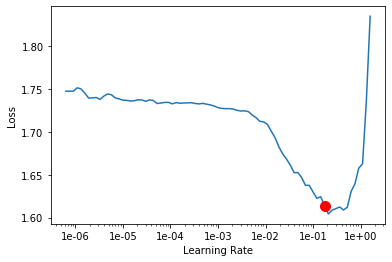

In [419]:
makeup_learner.lr_find()
makeup_learner.recorder.plot(suggestion=True)

In [420]:
makeup_learner.fit_one_cycle(2, max_lr=8e-02)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-02
Min loss divided by 10: 2.09E-02


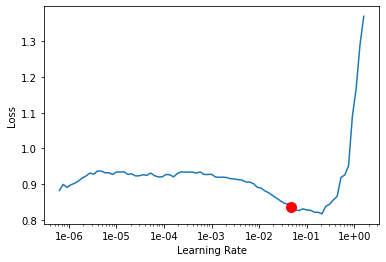

In [421]:
makeup_learner.lr_find()
makeup_learner.recorder.plot(suggestion=True)

In [422]:
makeup_learner.fit_one_cycle(2, max_lr=1e-02)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-05
Min loss divided by 10: 8.32E-03


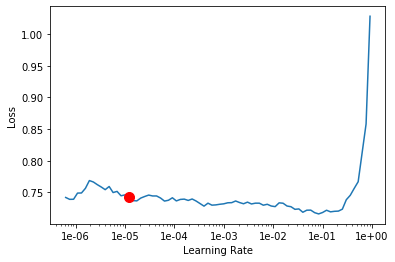

In [369]:
makeup_learner.lr_find()
makeup_learner.recorder.plot(suggestion=True)

In [370]:
makeup_learner.fit_one_cycle(1, max_lr=5e-06)

In [120]:
makeup_learner.fit_one_cycle(2, max_lr=3e-06)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02
Min loss divided by 10: 2.09E-02


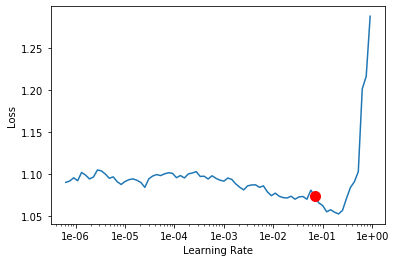

In [121]:
makeup_learner.lr_find()
makeup_learner.recorder.plot(suggestion=True)

In [122]:
makeup_learner.fit_one_cycle(2, max_lr=2e-02)